In [1]:
!pip install xgboost pandas seaborn scikit-learn optuna expetator cryptography
!pip install imbalanced-learn

     |████████████████████████████████| 286kB 7.6MB/s 
     |████████████████████████████████| 2.9MB 19.0MB/s 
     |████████████████████████████████| 2.6MB 32.2MB/s 
     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 163kB 47.9MB/s 
     |████████████████████████████████| 112kB 66.9MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 133kB 49.5MB/s 
     |████████████████████████████████| 481kB 43.1MB/s 
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=7976d1003d5bb14122cc4029dc113b76c481bee1d5d8e0d6db3cf9eca9f8500e
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=136fbd4bb12df5a4a70dea87824d2264c9cbd9792cd8086ecb5e466af6560e0d
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb5

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/ML_DVFS/Modeling and evaluation'
os.chdir(PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from expetator.tools import read_experiment, show_heatmap, add_objectives
from expetator.tools import prune_vectors, mojitos_to_vectors, show_pct_distribution
from expetator.monitors import mojitos
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from random import sample 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def generate_en_features(df):
    df = df.copy()
    cols = set(df.columns)-{'metric','page_faults_min','expe','group','target'}
    print(cols)
    for col in cols:
        for func in ['mean','std','min','max']:
            temp = df.groupby('expe')[col].agg([func]).rename({func:f"{col}_{func}"},axis=1)
            df = pd.merge(df,temp,on='expe',how='left')
        df[col+'_bin10'] = pd.cut(df[col], bins = 10, labels = False)
        df[col+'_bin100'] = pd.cut(df[col], bins = 100, labels = False)
        df[col+'_log'] = df[col].apply(lambda row: np.log(1+row))
        df[col+'log+1'] = (df[col]+1).transform(np.log)
        df[col+'log(x-min(x)+1)'] = (df[col]-df[col].min()+1) .transform(np.log)
    return df
def generate_bin_features(df):
    df = df.copy()
    for col in set(df.columns)-{'metric','expe','freq','group','target'}:
        df[col+'_bin10'] = pd.cut(df[col], bins = 10, labels = False)
        df[col+'_bin100'] = pd.cut(df[col], bins = 100, labels = False)
        #df[col+'_log'] = df[col].apply(lambda row: np.log(1+row))
        #df[col+'log+1'] = (df[col]+1).transform(np.log)
        #df[col+'log(x-min(x)+1)'] = (df[col]-df[col].min()+1) .transform(np.log)
    return df

def outlierdrop(df,factor):
    for col in set(df.columns) - {'metric','expe','freq','group','target'}:
        upper_lim = df[col].mean () + df[col].std () * factor
        lower_lim = df[col].mean () - df[col].std () * factor
        df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]
    return df
def outlierfill(df):
    for column in set(df.columns) - {'metric','expe','freq','group','target'}:
        upper_lim = df[column].quantile(.95)
        lower_lim = df[column].quantile(0.05)
        df.loc[(df[column] > upper_lim),column] = upper_lim
        df.loc[(df[column] < lower_lim),column] = lower_lim
    return df
all_knowledge = pd.read_csv("../csvs/knowledge_allmetrics.csv")
all_vectors = pd.read_csv("../csvs/vectors_allmetrics.csv")
all_vectors['typedata'] = 0
all_knowledge_old = pd.read_csv("../csvs/old/knowledge_allmetrics.csv")
all_vectors_old = pd.read_csv("../csvs/old/vectors_allmetrics.csv")
all_knowledge_old['expe'] = all_knowledge_old['expe'] + all_knowledge.expe.values[-1] + 1
all_vectors_old['typedata'] = 1

all_knowledge = pd.concat([all_knowledge, all_knowledge_old],ignore_index=True)
all_vectors = pd.concat([all_vectors, all_vectors_old],ignore_index=True)

# merge knowlage to vectors => data for training 
all_vectors['expe'] = all_knowledge.expe
all_vectors['target'] = all_knowledge['target']

ignore_columns = ['irxp', 'irxb','itxp', 'itxb', 'core0','core1','bpf_output',
                 'alignment_faults','page_faults_maj','dummy','emulation_faults','nice',
                 'irq','steal','guest','guest_nice']
all_vectors = all_vectors.loc[:,~ all_vectors.columns.isin(ignore_columns)]
#all_vectors_outlier = outlierfill(all_vectors)
vectorbin = generate_en_features(all_vectors)
vectors = vectorbin#prune_vectors(vectorbin)



ignore_columns = ['typedata','expe','group','target','Kfold', #'guest', 'guest_nice', 'irq',
                  #'steal','nice','emulation_faults','irxp', 'irxb', 
                  #'itxp', 'itxb', 'core0','core1','iowait','softirq','txp',
                 ]

# convert categories to numerical
metric_mapping = {
    "energy":0,
    "duration":1,
    "etp":2
}
vectors['metric'] = all_knowledge['metric'].map(metric_mapping)
labels = [1200000,
     1300000,
     1400000,
     1500000,
     1600000,
     1700000,
     1800000,
     1900000,
     2000000,
     2100000,
     2200000,
     2300000,
     2400000]
vectors['target'] = vectors.target.apply(lambda row: labels.index(row))

#split dataset to train, test: 0.8:0.2. Note that split base on expe
testidx = []
exps = list(set(vectors[vectors['typedata'] == 1].expe))
testidx.extend(sample(exps, int(0.2*len(exps))))

exps = list(set(vectors[vectors['typedata'] == 0].expe))
testidx.extend(sample(exps, int(0.2*len(exps))))

train = vectors[~vectors.expe.isin(testidx)].reset_index(drop=True)
test = vectors[vectors.expe.isin(testidx)].reset_index(drop=True)

from imblearn.over_sampling import SMOTE



{'dram0', 'rxp', 'task_clock', 'cache_ll', 'cache_bpu', 'rxb', 'branch_misses', 'package-00', 'iowait', 'branch_instructions', 'context_switches', 'cpu_migrations', 'cache_l1d', 'txb', 'package-11', 'cache_result_access', 'cpu_cycles', 'page_faults', 'dram1', 'cache_itlb', 'freq', 'instructions', 'cache_references', 'bus_cycles', 'cache_op_read', 'cache_dtlb', 'cache_op_prefetch', 'cpu_clock', 'txp', 'system', 'softirq', 'cache_node', 'idle', 'cache_misses', 'ref_cpu_cycles', 'user', 'typedata'}


In [9]:
all_vectors.groupby('expe')['page_faults_min'].agg(['min'])

min
expe           
0      0.000000
1     41.240000
2      0.000000
3      0.000000
4      1.100490
...         ...
2253   0.010246
2254   0.000000
2255   0.000000
2256   0.000000
2257   0.000000

[1632 rows x 1 columns]

In [11]:
metric_list=['mlogloss','merror']#merror
earlyStop=50
def optimize(trial):
    param = {
        "verbosity": 0,
        "num_boost_round":1000,
        "num_class": 13,
        "objective": "multi:softprob",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear"]),#, "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
        'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
        'eval_metric':trial.suggest_categorical('eval_metric', metric_list),
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree', 0.1, 1, 0.01),
        'colsample_bynode':trial.suggest_discrete_uniform('colsample_bynode', 0.1, 1, 0.01),
        'colsample_bylevel':trial.suggest_discrete_uniform('colsample_bylevel', 0.1, 1, 0.01),
        'subsample':trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.05),
        
    }
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    
    
    accuracies = []
    test_pro = []
    skf = GroupKFold(n_splits=5)
    train['group'] = train.apply(lambda row: str(row['expe']) + str(row['metric']),axis = 1)
    for i, (train_index, test_index) in enumerate(skf.split(train, train.target, groups = train['group'])):
        xtrain_fold = train.loc[train_index, ~train.columns.isin(ignore_columns)]
        ytrain_fold = train.loc[train_index,'target']
        X_val_fold = train.loc[test_index, ~train.columns.isin(ignore_columns)]
        y_val_fold = train.loc[test_index,'target']
        
        df_Ytrain = ytrain_fold.reset_index(drop=True)
        df_Yval = y_val_fold.reset_index(drop=True)

        sc = StandardScaler()
        df_train = sc.fit_transform(xtrain_fold)
        df_val = sc.transform(X_val_fold)

        #oversample = SMOTE()
        #xthang, ythang = oversample.fit_resample(df_train, df_Ytrain)
        
        #df_Xtrain_sc = pd.DataFrame(xthang,columns = xtrain_fold.columns)
        df_Xtrain_sc = pd.DataFrame(df_train,columns = xtrain_fold.columns)
        df_Xval_sc = pd.DataFrame(df_val,columns = X_val_fold.columns)
        
        dtrain = xgb.DMatrix(df_Xtrain_sc,label=df_Ytrain)
        dval = xgb.DMatrix(df_Xval_sc,label=df_Yval)
        bst = xgb.train(param, dtrain)
        preds = bst.predict(dval)
        
        df_Yval = y_val_fold.reset_index(drop=True)
        preds = np.argmax(preds,axis = 1)
        accuracy = accuracy_score(df_Yval, preds)
        print(f"FOLD{i}-val acc: {(accuracy * 100.0)}", end=' ')
        
        accuracies.append(accuracy)
        
        X_test = test.loc[:, ~test.columns.isin(ignore_columns)]
        df_Xtest = sc.transform(X_test)
        df_Xtest_sc = pd.DataFrame(df_Xtest,columns = X_test.columns)
        y_test = test.target.reset_index(drop=True)
        dtest = xgb.DMatrix(df_Xtest_sc,label=y_test)
        
        preds = bst.predict(dtest)
        test_pro.append(preds)
        preds = np.argmax(preds,axis = 1)
        accuracy = accuracy_score(y_test, preds)
        print(f"FOLD{i}-test acc: {(accuracy * 100.0)}")
    test_pro_mean = np.mean(test_pro,axis=0)
    preds = np.argmax(test_pro_mean,axis = 1)
    accuracy = accuracy_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    print(f"======================================> TTA on test acc: {(accuracy * 100.0)}, mse: {mse}")
    if accuracy > 0.76:
      print(classification_report(y_test, preds))
      cfm = confusion_matrix(y_test, preds, labels = range(0,13))
      cm = cfm
      cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]
      tmplabel = [i//100000 for i in labels]
      annot = np.empty_like(cfm).astype(str)
      nrows, ncols = cfm.shape
      for i in range(nrows):
          for j in range(ncols):
              c = cfm[i, j]*100
              if c == 0:
                  annot[i, j] = cm[i, j]
              else:
                annot[i, j] = '%.1f%%\n%d' % (c,cm[i, j])
      plt.figure(figsize=(12,10))
      ax = sns.heatmap(cfm, annot=annot, fmt='',cmap="YlGnBu")
      ax.set_xticklabels(tmplabel)
      ax.set_yticklabels(tmplabel)
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.show()    
        
    return -1.0*np.mean(accuracies)

[I 2021-01-15 10:57:34,850] A new study created in memory with name: no-name-6795fc83-c3f8-4e06-97bc-04e60036e2f2


FOLD0-val acc: 62.843040473840084 FOLD0-test acc: 60.96710265556877
FOLD1-val acc: 61.31833432011052 FOLD1-test acc: 62.156163297661514
FOLD2-val acc: 61.83145845668048 FOLD2-test acc: 62.17201743955608
FOLD3-val acc: 63.31162423524768 FOLD3-test acc: 62.39397542608006
FOLD4-val acc: 59.74718546316413 

[I 2021-01-15 10:58:39,798] Trial 0 finished with value: -0.6181032858980858 and parameters: {'booster': 'gbtree', 'lambda': 5.676942173985915e-08, 'alpha': 0.013506428395153534, 'min_child_weight': 2, 'learning_rate': 0.006396127991967307, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.73, 'colsample_bynode': 0.26, 'colsample_bylevel': 0.13, 'subsample': 0.8, 'max_depth': 7, 'eta': 3.437179532354863e-08, 'gamma': 3.77464571021425e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: -0.6181032858980858.


FOLD4-test acc: 60.70550931430836
======================================> TTA on test acc: 62.56044391597305, mse: 11.259770114942528
FOLD0-val acc: 38.440276406712734 FOLD0-test acc: 39.643281807372176
FOLD1-val acc: 36.81665679889481 FOLD1-test acc: 39.302417756638924
FOLD2-val acc: 37.56660746003552 FOLD2-test acc: 39.445105033690055
FOLD3-val acc: 39.77698835602921 FOLD3-test acc: 39.33412604042806
FOLD4-val acc: 40.242938968990714 

[I 2021-01-15 10:59:24,292] Trial 1 finished with value: -0.385686935981326 and parameters: {'booster': 'gbtree', 'lambda': 1.2380215240074135e-05, 'alpha': 0.00026166370752544175, 'min_child_weight': 5, 'learning_rate': 0.04127581355573926, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.42000000000000004, 'colsample_bynode': 0.18, 'colsample_bylevel': 0.6, 'subsample': 0.8, 'max_depth': 1, 'eta': 2.808802664482222e-06, 'gamma': 8.53100388644534e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: -0.6181032858980858.


FOLD4-test acc: 41.39516448672216
======================================> TTA on test acc: 40.039635354736426, mse: 25.449702734839477
FOLD0-val acc: 40.4639684106614 FOLD0-test acc: 43.51169242964725
FOLD1-val acc: 42.026840339451354 FOLD1-test acc: 43.03606817281015
FOLD2-val acc: 40.56641010459838 FOLD2-test acc: 43.32936979785969
FOLD3-val acc: 42.924807578448785 FOLD3-test acc: 43.17875544986128
FOLD4-val acc: 42.287181512936996 

[I 2021-01-15 11:01:19,103] Trial 2 finished with value: -0.4165384158921938 and parameters: {'booster': 'gblinear', 'lambda': 0.14521930380267797, 'alpha': 9.07776663885242e-06, 'min_child_weight': 5, 'learning_rate': 0.07191365890633944, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.19, 'colsample_bynode': 0.24000000000000002, 'colsample_bylevel': 0.89, 'subsample': 0.95}. Best is trial 0 with value: -0.6181032858980858.


FOLD4-test acc: 43.32936979785969
======================================> TTA on test acc: 43.273880301228694, mse: 19.3059849385652
FOLD0-val acc: 42.46791707798618 FOLD0-test acc: 42.71898533491875
FOLD1-val acc: 42.06631142687981 FOLD1-test acc: 43.26595323028141
FOLD2-val acc: 42.184724689165186 FOLD2-test acc: 44.02695204122077
FOLD3-val acc: 46.15156897572528 FOLD3-test acc: 44.97820055489497
FOLD4-val acc: 42.14892356310488 

[I 2021-01-15 11:02:06,141] Trial 3 finished with value: -0.4300388914657226 and parameters: {'booster': 'gbtree', 'lambda': 0.0015458287105458938, 'alpha': 0.01703422415673318, 'min_child_weight': 2, 'learning_rate': 0.25211390030786407, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.28, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'max_depth': 1, 'eta': 0.20331987985620753, 'gamma': 2.209738544251426e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: -0.6181032858980858.


FOLD4-test acc: 42.49702734839477
======================================> TTA on test acc: 44.00317082837891, mse: 24.22972651605232
FOLD0-val acc: 36.85093780848964 FOLD0-test acc: 39.18351169242965
FOLD1-val acc: 37.59621077560687 FOLD1-test acc: 38.75544986127626
FOLD2-val acc: 35.790408525754884 FOLD2-test acc: 38.842647641696395
FOLD3-val acc: 39.7671205841721 FOLD3-test acc: 39.23900118906064
FOLD4-val acc: 36.56922773059451 

[I 2021-01-15 11:04:01,555] Trial 4 finished with value: -0.373147810849236 and parameters: {'booster': 'gblinear', 'lambda': 0.9409647911162138, 'alpha': 0.00024374748005937167, 'min_child_weight': 4, 'learning_rate': 0.009300132285405523, 'eval_metric': 'merror', 'colsample_bytree': 0.56, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.64, 'subsample': 0.95}. Best is trial 0 with value: -0.6181032858980858.


FOLD4-test acc: 39.167657550535075
======================================> TTA on test acc: 39.096313912009514, mse: 21.01450653983353
FOLD0-val acc: 43.84995064165844 FOLD0-test acc: 45.98493856520015
FOLD1-val acc: 44.04973357015986 FOLD1-test acc: 46.04835513277844
FOLD2-val acc: 43.75370041444641 FOLD2-test acc: 45.84225128814903
FOLD3-val acc: 45.92461022301164 FOLD3-test acc: 46.080063416567576
FOLD4-val acc: 45.16097175587596 

[I 2021-01-15 11:05:56,551] Trial 5 finished with value: -0.44547793321030466 and parameters: {'booster': 'gblinear', 'lambda': 1.6718711875630934e-07, 'alpha': 3.0792446897947785e-08, 'min_child_weight': 2, 'learning_rate': 0.23755260168359518, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.76, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.12000000000000001, 'subsample': 1.0}. Best is trial 0 with value: -0.6181032858980858.


FOLD4-test acc: 45.945303210463734
======================================> TTA on test acc: 45.92944906856916, mse: 15.219104240982956
FOLD0-val acc: 60.049358341559724 FOLD0-test acc: 61.52199762187872
FOLD1-val acc: 61.37754095125321 FOLD1-test acc: 61.30003963535474
FOLD2-val acc: 61.002565620682844 FOLD2-test acc: 61.545778834720565
FOLD3-val acc: 63.74580619696073 FOLD3-test acc: 61.57748711850971
FOLD4-val acc: 62.65060240963856 

[I 2021-01-15 11:07:00,805] Trial 6 finished with value: -0.6176517470401901 and parameters: {'booster': 'gbtree', 'lambda': 1.0381718510134188e-06, 'alpha': 0.001173514113241621, 'min_child_weight': 5, 'learning_rate': 0.01378185831277436, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.7, 'colsample_bynode': 0.15000000000000002, 'colsample_bylevel': 0.24000000000000002, 'subsample': 0.8, 'max_depth': 7, 'eta': 0.00044101728630117784, 'gamma': 0.6057187307739916, 'grow_policy': 'depthwise'}. Best is trial 0 with value: -0.6181032858980858.


FOLD4-test acc: 61.617122473246134
======================================> TTA on test acc: 61.831153388822834, mse: 11.397384066587396
FOLD0-val acc: 65.01480750246792 FOLD0-test acc: 68.35513277843836
FOLD1-val acc: 65.91671600552596 FOLD1-test acc: 69.0210067380103
FOLD2-val acc: 66.29169133609632 FOLD2-test acc: 69.18747522790329
FOLD3-val acc: 69.1730807183738 FOLD3-test acc: 69.26674593737614
FOLD4-val acc: 67.43037724669169 

[I 2021-01-15 11:08:47,260] Trial 7 finished with value: -0.6676533456183114 and parameters: {'booster': 'gbtree', 'lambda': 2.8606635979094094e-07, 'alpha': 2.4708031939209655e-08, 'min_child_weight': 0, 'learning_rate': 0.01029457984392825, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.33999999999999997, 'colsample_bynode': 0.37, 'colsample_bylevel': 0.96, 'subsample': 0.95, 'max_depth': 6, 'eta': 0.0006369432666160275, 'gamma': 1.237370218582719e-05, 'grow_policy': 'depthwise'}. Best is trial 7 with value: -0.6676533456183114.


FOLD4-test acc: 67.72096710265558
======================================> TTA on test acc: 69.52833927863654, mse: 9.087831946095918
FOLD0-val acc: 70.79960513326752 FOLD0-test acc: 72.00951248513674
FOLD1-val acc: 70.51509769094139 FOLD1-test acc: 72.60404280618312
FOLD2-val acc: 71.65975922636669 FOLD2-test acc: 72.95283392786367
FOLD3-val acc: 72.3406354845076 FOLD3-test acc: 72.24732461355529
FOLD4-val acc: 72.5755480940154 

[I 2021-01-15 11:12:18,574] Trial 8 finished with value: -0.7157812912581971 and parameters: {'booster': 'gbtree', 'lambda': 0.12135213184927199, 'alpha': 2.32291768178529e-05, 'min_child_weight': 5, 'learning_rate': 0.02998575184446783, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.84, 'colsample_bynode': 0.49, 'colsample_bylevel': 0.84, 'subsample': 0.55, 'max_depth': 6, 'eta': 3.9335196325454276e-07, 'gamma': 2.042751761911686e-08, 'grow_policy': 'lossguide'}. Best is trial 8 with value: -0.7157812912581971.


FOLD4-test acc: 73.07173999207292
======================================> TTA on test acc: 73.1430836305985, mse: 6.791835116924297
FOLD0-val acc: 55.735439289239885 FOLD0-test acc: 57.891399128022194
FOLD1-val acc: 57.17387014012236 FOLD1-test acc: 57.28894173602854
FOLD2-val acc: 56.15748963883955 FOLD2-test acc: 56.66270313119303
FOLD3-val acc: 58.68363923426091 FOLD3-test acc: 57.106619104240984
FOLD4-val acc: 56.90302192376062 

[I 2021-01-15 11:13:17,603] Trial 9 finished with value: -0.5693069204524466 and parameters: {'booster': 'gbtree', 'lambda': 0.5282805898844027, 'alpha': 0.9452773335757952, 'min_child_weight': 1, 'learning_rate': 0.044901823317480175, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.45999999999999996, 'colsample_bynode': 0.33, 'colsample_bylevel': 0.49, 'subsample': 0.95, 'max_depth': 3, 'eta': 0.02677617126436345, 'gamma': 1.407682031715167e-08, 'grow_policy': 'depthwise'}. Best is trial 8 with value: -0.7157812912581971.


FOLD4-test acc: 56.07609988109393
======================================> TTA on test acc: 57.32065001981768, mse: 15.164645263575109
FOLD0-val acc: 75.81441263573544 FOLD0-test acc: 75.54498612762585
FOLD1-val acc: 74.58061969607263 FOLD1-test acc: 75.79072532699168
FOLD2-val acc: 75.65620682849813 FOLD2-test acc: 75.56084026952041
FOLD3-val acc: 75.47858693507006 FOLD3-test acc: 76.0919540229885
FOLD4-val acc: 76.93067351372704 FOLD4-test acc: 76.28220372572333
======================================> TTA on test acc: 76.49623464130005, mse: 4.0104637336504165
              precision    recall  f1-score   support

           0       0.67      0.79      0.73      1033
           1       0.66      0.52      0.58       666
           2       0.80      0.71      0.75       652
           3       0.74      0.78      0.76       413
           4       0.76      0.64      0.69       630
           5       0.71      0.76      0.73       355
           6       0.80      0.83      0.81       322

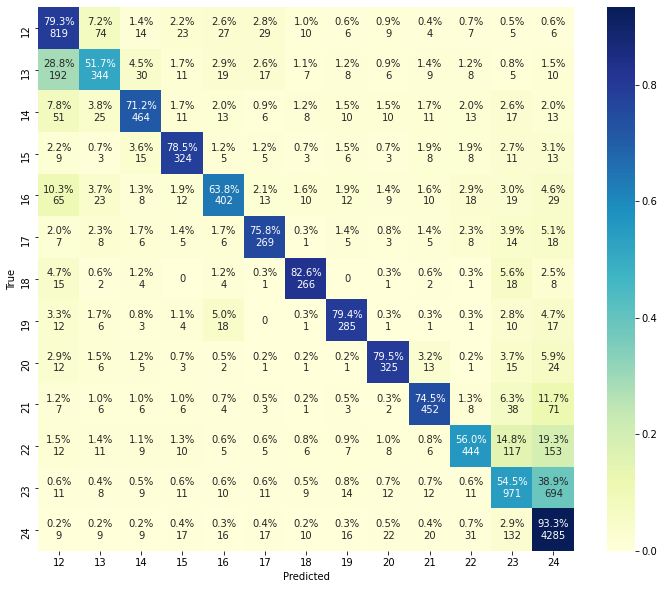

[I 2021-01-15 11:21:19,908] Trial 10 finished with value: -0.7569209992182065 and parameters: {'booster': 'gbtree', 'lambda': 0.00658269830435111, 'alpha': 2.357281490502722e-06, 'min_child_weight': 4, 'learning_rate': 0.023852498665335845, 'eval_metric': 'merror', 'colsample_bytree': 0.98, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.82, 'subsample': 0.5, 'max_depth': 10, 'eta': 1.2131299355157837e-08, 'gamma': 0.003976202105888192, 'grow_policy': 'lossguide'}. Best is trial 10 with value: -0.7569209992182065.


FOLD0-val acc: 75.6959526159921 FOLD0-test acc: 76.18707887435593
FOLD1-val acc: 75.0345372014999 FOLD1-test acc: 76.22671422909235
FOLD2-val acc: 75.86343003749754 FOLD2-test acc: 75.73523583036068
FOLD3-val acc: 75.88316558121177 FOLD3-test acc: 75.70352754657154
FOLD4-val acc: 76.41714398577918 FOLD4-test acc: 75.74316290130797
======================================> TTA on test acc: 76.59928656361474, mse: 3.911296076099881
              precision    recall  f1-score   support

           0       0.67      0.80      0.73      1033
           1       0.66      0.52      0.58       666
           2       0.80      0.71      0.75       652
           3       0.75      0.78      0.76       413
           4       0.76      0.65      0.70       630
           5       0.71      0.76      0.73       355
           6       0.78      0.84      0.81       322
           7       0.76      0.79      0.77       359
           8       0.78      0.79      0.79       409
           9       0.81    

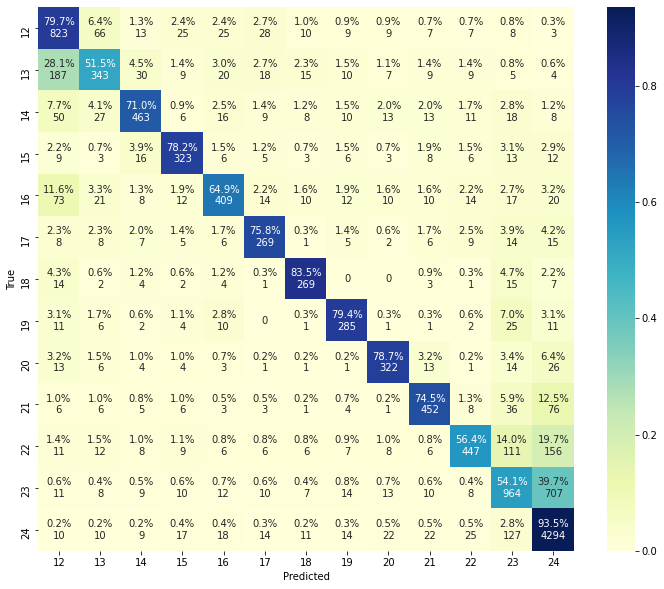

[I 2021-01-15 11:29:04,530] Trial 11 finished with value: -0.757788458843961 and parameters: {'booster': 'gbtree', 'lambda': 0.004116502219548328, 'alpha': 3.028148659738203e-06, 'min_child_weight': 4, 'learning_rate': 0.021476835390599323, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.8099999999999999, 'subsample': 0.5, 'max_depth': 10, 'eta': 1.085361136644833e-08, 'gamma': 0.011582207515031348, 'grow_policy': 'lossguide'}. Best is trial 11 with value: -0.757788458843961.


FOLD0-val acc: 75.3405725567621 FOLD0-test acc: 75.72730875941339
FOLD1-val acc: 74.12670219064536 FOLD1-test acc: 75.54498612762585
FOLD2-val acc: 75.38977698835603 FOLD2-test acc: 75.68767340467697
FOLD3-val acc: 76.10025656206828 FOLD3-test acc: 75.521204914784
FOLD4-val acc: 77.09855816709461 FOLD4-test acc: 75.98890210067381
======================================> TTA on test acc: 76.24256837098692, mse: 3.9239001189060643
              precision    recall  f1-score   support

           0       0.66      0.79      0.72      1033
           1       0.65      0.50      0.56       666
           2       0.80      0.70      0.75       652
           3       0.76      0.79      0.78       413
           4       0.76      0.63      0.69       630
           5       0.71      0.77      0.74       355
           6       0.78      0.84      0.81       322
           7       0.76      0.80      0.78       359
           8       0.78      0.79      0.79       409
           9       0.82    

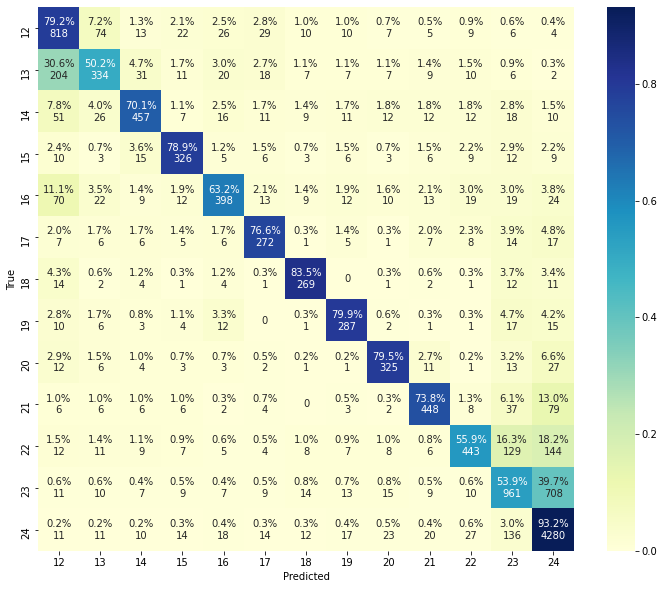

[I 2021-01-15 11:36:38,225] Trial 12 finished with value: -0.7561117329298528 and parameters: {'booster': 'gbtree', 'lambda': 0.00248210864438413, 'alpha': 7.439303911979387e-07, 'min_child_weight': 4, 'learning_rate': 0.020682916888313783, 'eval_metric': 'merror', 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.76, 'subsample': 0.5, 'max_depth': 10, 'eta': 1.004373248544836e-08, 'gamma': 0.013461251918464522, 'grow_policy': 'lossguide'}. Best is trial 11 with value: -0.757788458843961.


FOLD0-val acc: 76.071076011846 FOLD0-test acc: 76.51208878319461
FOLD1-val acc: 75.39964476021315 FOLD1-test acc: 76.17122473246135
FOLD2-val acc: 75.93250444049734 FOLD2-test acc: 76.0919540229885
FOLD3-val acc: 76.3765541740675 FOLD3-test acc: 75.78279825604439
FOLD4-val acc: 77.66146553426823 FOLD4-test acc: 76.1474435196195
======================================> TTA on test acc: 76.94807768529527, mse: 3.356797463337297
              precision    recall  f1-score   support

           0       0.64      0.77      0.70      1033
           1       0.65      0.50      0.56       666
           2       0.81      0.72      0.76       652
           3       0.77      0.79      0.78       413
           4       0.77      0.66      0.71       630
           5       0.72      0.75      0.74       355
           6       0.79      0.82      0.81       322
           7       0.76      0.80      0.78       359
           8       0.80      0.81      0.81       409
           9       0.80      0

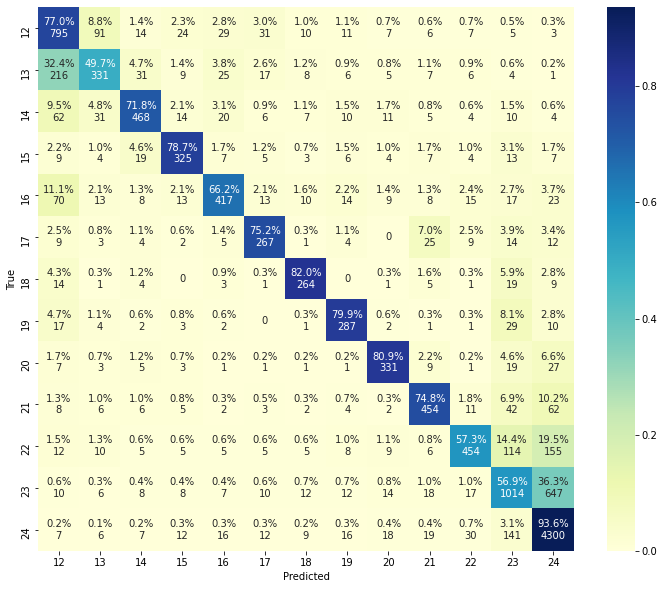

[I 2021-01-15 11:44:21,075] Trial 13 finished with value: -0.7628824898417844 and parameters: {'booster': 'gbtree', 'lambda': 0.003689257822488774, 'alpha': 9.63248325332111e-07, 'min_child_weight': 3, 'learning_rate': 0.10010555739396625, 'eval_metric': 'merror', 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.75, 'subsample': 0.6, 'max_depth': 10, 'eta': 1.3807097947633335e-08, 'gamma': 0.0029446352969711397, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.7628824898417844.


FOLD0-val acc: 74.07699901283317 FOLD0-test acc: 75.41815299246927
FOLD1-val acc: 74.63982632721532 FOLD1-test acc: 75.6718192627824
FOLD2-val acc: 74.80757844878626 FOLD2-test acc: 75.78279825604439
FOLD3-val acc: 75.74501677521216 FOLD3-test acc: 75.83828775267538
FOLD4-val acc: 76.50602409638554 FOLD4-test acc: 75.48156956004757
======================================> TTA on test acc: 76.7261196987713, mse: 3.9285770907649624
              precision    recall  f1-score   support

           0       0.66      0.80      0.72      1033
           1       0.68      0.49      0.57       666
           2       0.81      0.70      0.75       652
           3       0.77      0.78      0.77       413
           4       0.78      0.66      0.71       630
           5       0.71      0.77      0.74       355
           6       0.78      0.82      0.80       322
           7       0.75      0.81      0.78       359
           8       0.80      0.82      0.81       409
           9       0.80   

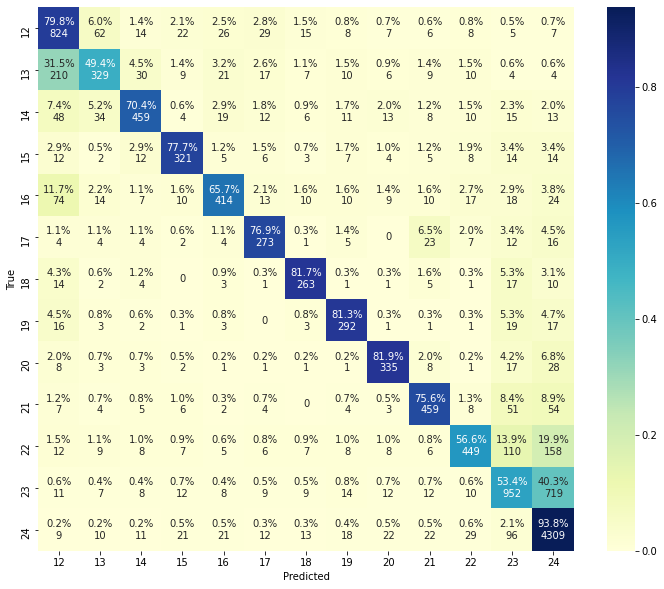

[I 2021-01-15 11:49:02,238] Trial 14 finished with value: -0.7515508893208649 and parameters: {'booster': 'gbtree', 'lambda': 0.00013738700315691634, 'alpha': 1.7287332338125741e-07, 'min_child_weight': 3, 'learning_rate': 0.0998949421529797, 'eval_metric': 'merror', 'colsample_bytree': 0.99, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.42000000000000004, 'subsample': 0.65, 'max_depth': 9, 'eta': 3.2400995229174416e-06, 'gamma': 0.0018515325623875865, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.7628824898417844.


FOLD0-val acc: 75.42941757156959 FOLD0-test acc: 75.83036068172811
FOLD1-val acc: 75.08387606078547 FOLD1-test acc: 75.521204914784
FOLD2-val acc: 75.88316558121177 FOLD2-test acc: 75.96512088783194
FOLD3-val acc: 76.00157884349714 FOLD3-test acc: 75.42608006341656
FOLD4-val acc: 76.38751728224373 FOLD4-test acc: 75.23583036068173
======================================> TTA on test acc: 77.06698374950456, mse: 3.6826793499801824
              precision    recall  f1-score   support

           0       0.67      0.80      0.73      1033
           1       0.71      0.51      0.60       666
           2       0.81      0.71      0.76       652
           3       0.78      0.79      0.79       413
           4       0.78      0.66      0.71       630
           5       0.70      0.76      0.73       355
           6       0.77      0.84      0.80       322
           7       0.75      0.80      0.77       359
           8       0.80      0.80      0.80       409
           9       0.80   

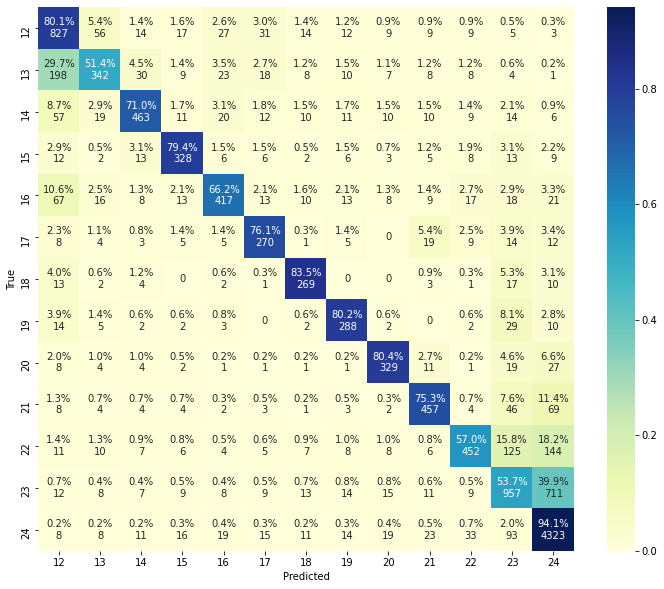

[I 2021-01-15 11:54:04,927] Trial 15 finished with value: -0.7575711106786154 and parameters: {'booster': 'gbtree', 'lambda': 0.015792405039886638, 'alpha': 2.557377367364396e-07, 'min_child_weight': 3, 'learning_rate': 0.12363725004878287, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.7, 'subsample': 0.6, 'max_depth': 9, 'eta': 2.2256715125957455e-07, 'gamma': 0.3517679740528139, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.7628824898417844.


FOLD0-val acc: 76.071076011846 FOLD0-test acc: 76.32183908045977
FOLD1-val acc: 75.300967041642 FOLD1-test acc: 75.71145461751883
FOLD2-val acc: 76.05091770278271 FOLD2-test acc: 75.39437177962742
FOLD3-val acc: 76.32721531478192 FOLD3-test acc: 76.27427665477606
FOLD4-val acc: 77.65158996642307 FOLD4-test acc: 75.81450653983353
======================================> TTA on test acc: 76.79746333729686, mse: 3.5031311930241777
              precision    recall  f1-score   support

           0       0.65      0.79      0.71      1033
           1       0.67      0.50      0.57       666
           2       0.80      0.72      0.76       652
           3       0.77      0.78      0.78       413
           4       0.77      0.65      0.70       630
           5       0.73      0.77      0.75       355
           6       0.79      0.83      0.81       322
           7       0.77      0.81      0.79       359
           8       0.80      0.81      0.80       409
           9       0.79     

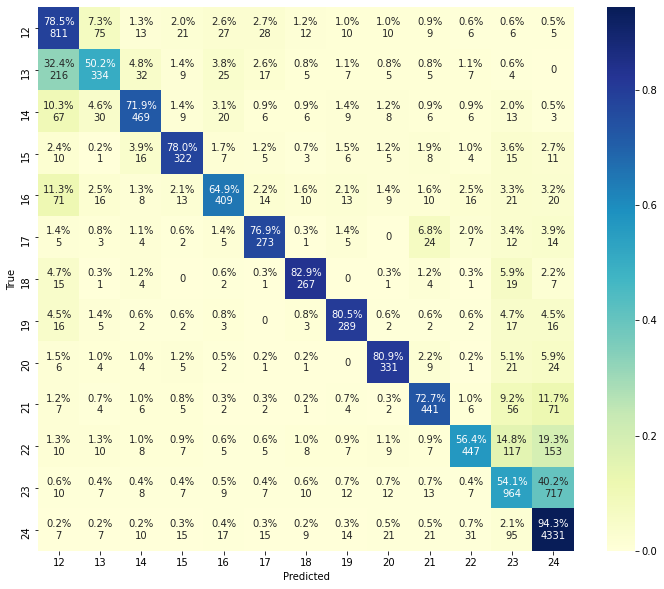

[I 2021-01-15 12:02:03,509] Trial 16 finished with value: -0.7628035320749514 and parameters: {'booster': 'gbtree', 'lambda': 0.00020954897718041457, 'alpha': 1.3130676152247793e-05, 'min_child_weight': 3, 'learning_rate': 0.1344948901163788, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.98, 'subsample': 0.7, 'max_depth': 8, 'eta': 1.8503969726240668e-05, 'gamma': 0.00021642180076023238, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.7628824898417844.


FOLD0-val acc: 44.17571569595262 FOLD0-test acc: 46.682520808561236
FOLD1-val acc: 43.88198144858891 FOLD1-test acc: 46.45263575108997
FOLD2-val acc: 44.30629563844484 FOLD2-test acc: 46.405073325406256
FOLD3-val acc: 46.44760213143872 FOLD3-test acc: 46.45263575108997
FOLD4-val acc: 45.16097175587596 

[I 2021-01-15 12:03:55,508] Trial 17 finished with value: -0.4479451333406021 and parameters: {'booster': 'gblinear', 'lambda': 0.00014620980062391106, 'alpha': 4.119543376096373e-05, 'min_child_weight': 3, 'learning_rate': 0.48664768390983015, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.97, 'subsample': 0.7}. Best is trial 13 with value: -0.7628824898417844.


FOLD4-test acc: 46.19896948077685
======================================> TTA on test acc: 46.539833531510105, mse: 14.89235037653587
FOLD0-val acc: 74.99506416584403 FOLD0-test acc: 75.96512088783194
FOLD1-val acc: 75.41938030392737 FOLD1-test acc: 75.06143479984145
FOLD2-val acc: 75.44898361949872 FOLD2-test acc: 75.07728894173603
FOLD3-val acc: 76.75152950463784 FOLD3-test acc: 75.92548553309551
FOLD4-val acc: 77.4442030416749 FOLD4-test acc: 75.64011097899326
======================================> TTA on test acc: 76.82917162108602, mse: 3.599841458581054
              precision    recall  f1-score   support

           0       0.66      0.79      0.72      1033
           1       0.67      0.48      0.56       666
           2       0.82      0.72      0.76       652
           3       0.78      0.79      0.79       413
           4       0.79      0.65      0.71       630
           5       0.69      0.76      0.73       355
           6       0.79      0.83      0.81       322


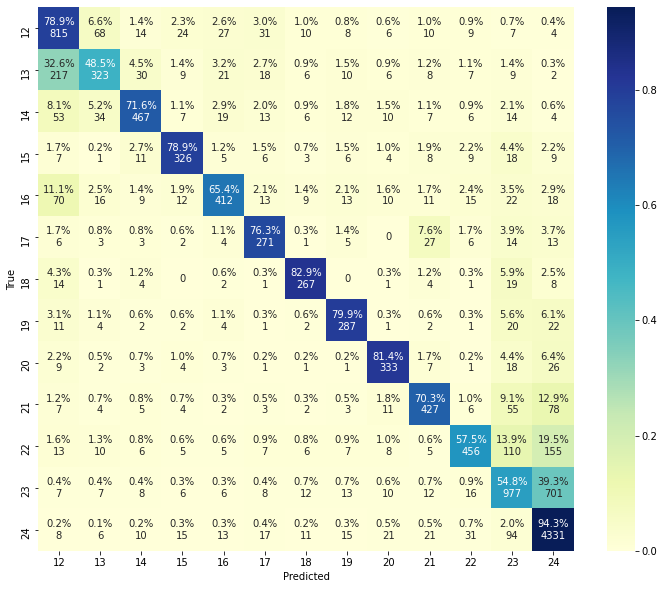

[I 2021-01-15 12:10:29,061] Trial 18 finished with value: -0.7601183212711657 and parameters: {'booster': 'gbtree', 'lambda': 1.87685898279643e-05, 'alpha': 1.1574391037745339e-07, 'min_child_weight': 1, 'learning_rate': 0.21102566372132964, 'eval_metric': 'merror', 'colsample_bytree': 0.65, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.98, 'subsample': 0.7, 'max_depth': 8, 'eta': 3.5576192344793656e-05, 'gamma': 0.00019810443840399887, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.7628824898417844.


FOLD0-val acc: 68.63770977295162 FOLD0-test acc: 69.95640110978994
FOLD1-val acc: 68.86717979080323 FOLD1-test acc: 69.8692033293698
FOLD2-val acc: 68.46260114466153 FOLD2-test acc: 69.03686087990486
FOLD3-val acc: 70.38681665679889 FOLD3-test acc: 69.75029726516053
FOLD4-val acc: 68.71420106656133 

[I 2021-01-15 12:13:37,245] Trial 19 finished with value: -0.6901370168635533 and parameters: {'booster': 'gbtree', 'lambda': 0.0006880812463326398, 'alpha': 1.98804032952901e-06, 'min_child_weight': 3, 'learning_rate': 0.12906275976803183, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.72, 'subsample': 0.6, 'max_depth': 4, 'eta': 0.004236896520337201, 'gamma': 0.00015883507724773487, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.7628824898417844.


FOLD4-test acc: 69.79785969084423
======================================> TTA on test acc: 70.14665081252477, mse: 9.832500990883869
FOLD0-val acc: 61.18460019743337 FOLD0-test acc: 61.894569956401114
FOLD1-val acc: 62.79850009867772 FOLD1-test acc: 62.44946492271106
FOLD2-val acc: 61.31833432011052 FOLD2-test acc: 62.481173206500195
FOLD3-val acc: 63.22281428853365 FOLD3-test acc: 63.345223939754256
FOLD4-val acc: 65.7712818487063 

[I 2021-01-15 12:14:41,997] Trial 20 finished with value: -0.6285910615069231 and parameters: {'booster': 'gbtree', 'lambda': 7.485769844486073e-06, 'alpha': 0.001568195984133286, 'min_child_weight': 1, 'learning_rate': 0.46626582106929415, 'eval_metric': 'merror', 'colsample_bytree': 0.1, 'colsample_bynode': 0.49, 'colsample_bylevel': 0.41000000000000003, 'subsample': 0.75, 'max_depth': 8, 'eta': 2.3858642603521055e-05, 'gamma': 0.07453197822318826, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.7628824898417844.


FOLD4-test acc: 64.0110978993262
======================================> TTA on test acc: 67.5465715418153, mse: 9.743321442726913
FOLD0-val acc: 75.17275419545904 FOLD0-test acc: 75.354736424891
FOLD1-val acc: 75.9127688967831 FOLD1-test acc: 75.00594530321047
FOLD2-val acc: 76.02131438721138 FOLD2-test acc: 74.81569560047564
FOLD3-val acc: 76.63311624235247 FOLD3-test acc: 75.60047562425683
FOLD4-val acc: 77.53308315228125 FOLD4-test acc: 75.94926674593736
======================================> TTA on test acc: 76.76575505350773, mse: 3.4774474831549744
              precision    recall  f1-score   support

           0       0.67      0.79      0.73      1033
           1       0.69      0.52      0.59       666
           2       0.83      0.72      0.77       652
           3       0.77      0.78      0.78       413
           4       0.77      0.66      0.71       630
           5       0.70      0.76      0.73       355
           6       0.79      0.82      0.80       322
    

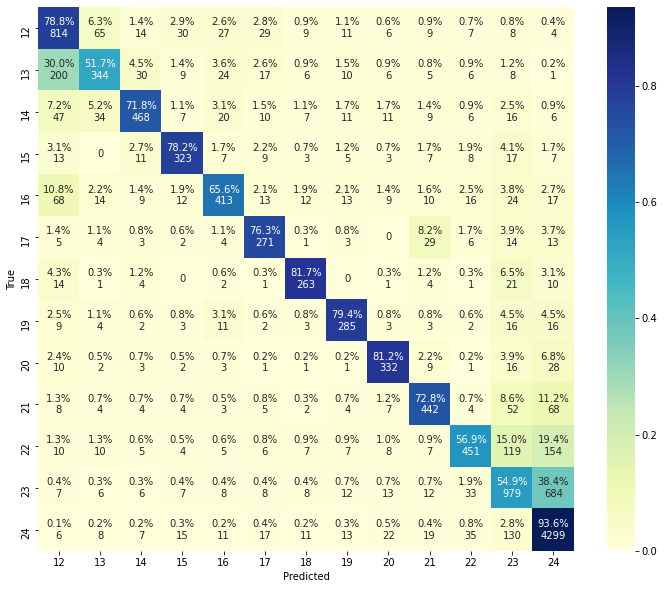

[I 2021-01-15 12:22:35,545] Trial 21 finished with value: -0.7625460737481745 and parameters: {'booster': 'gbtree', 'lambda': 1.683805498277912e-05, 'alpha': 1.0876295756285615e-07, 'min_child_weight': 1, 'learning_rate': 0.22603736269091934, 'eval_metric': 'merror', 'colsample_bytree': 0.65, 'colsample_bynode': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'max_depth': 8, 'eta': 4.6448641977645556e-05, 'gamma': 0.00023660386908840554, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.7628824898417844.


FOLD0-val acc: 76.57453109575518 FOLD0-test acc: 76.54379706698376
FOLD1-val acc: 75.04440497335702 FOLD1-test acc: 75.02972651605232
FOLD2-val acc: 75.61673574106966 FOLD2-test acc: 74.98216409036861
FOLD3-val acc: 77.02782711663706 FOLD3-test acc: 75.57669441141498
FOLD4-val acc: 76.73316215682402 FOLD4-test acc: 75.31510107015458
======================================> TTA on test acc: 76.59135949266745, mse: 3.5432421720174396
              precision    recall  f1-score   support

           0       0.66      0.78      0.72      1033
           1       0.66      0.51      0.58       666
           2       0.80      0.71      0.75       652
           3       0.75      0.78      0.77       413
           4       0.78      0.66      0.71       630
           5       0.70      0.75      0.72       355
           6       0.80      0.83      0.81       322
           7       0.77      0.78      0.77       359
           8       0.75      0.81      0.78       409
           9       0.78 

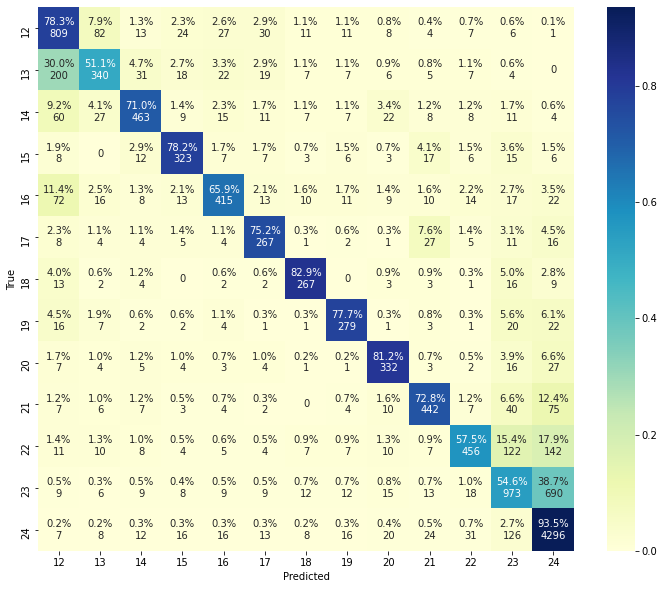

[I 2021-01-15 12:31:50,747] Trial 22 finished with value: -0.7619933221672859 and parameters: {'booster': 'gbtree', 'lambda': 0.0002806949199015187, 'alpha': 1.0037399125532037e-05, 'min_child_weight': 0, 'learning_rate': 0.07920992539396851, 'eval_metric': 'merror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.92, 'subsample': 0.65, 'max_depth': 8, 'eta': 7.899375746623525e-06, 'gamma': 0.0006772435964773564, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.7628824898417844.


FOLD0-val acc: 76.55478775913129 FOLD0-test acc: 76.3614744351962
FOLD1-val acc: 75.9127688967831 FOLD1-test acc: 76.23464130003964
FOLD2-val acc: 76.48509966449576 FOLD2-test acc: 76.00475624256838
FOLD3-val acc: 76.69232287349517 FOLD3-test acc: 76.3614744351962
FOLD4-val acc: 77.99723484100336 FOLD4-test acc: 76.07609988109394
======================================> TTA on test acc: 77.42370194213238, mse: 3.2308363059849388
              precision    recall  f1-score   support

           0       0.66      0.80      0.72      1033
           1       0.68      0.50      0.57       666
           2       0.82      0.72      0.77       652
           3       0.77      0.78      0.78       413
           4       0.77      0.67      0.72       630
           5       0.73      0.76      0.74       355
           6       0.80      0.83      0.81       322
           7       0.78      0.81      0.79       359
           8       0.80      0.80      0.80       409
           9       0.80    

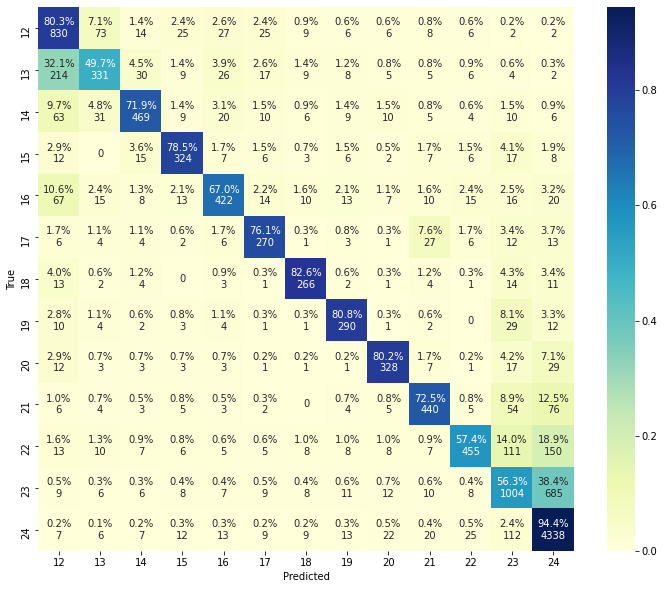

[I 2021-01-15 12:39:27,919] Trial 23 finished with value: -0.7672844280698173 and parameters: {'booster': 'gbtree', 'lambda': 3.0437288628488433e-05, 'alpha': 5.592379220926376e-07, 'min_child_weight': 2, 'learning_rate': 0.1605224639676584, 'eval_metric': 'merror', 'colsample_bytree': 0.79, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88, 'subsample': 0.7, 'max_depth': 9, 'eta': 0.00020526037881489498, 'gamma': 2.9226377677208207e-05, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7672844280698173.


FOLD0-val acc: 76.61401776900296 FOLD0-test acc: 76.10780816488307
FOLD1-val acc: 76.28774422735346 FOLD1-test acc: 76.38525564803805
FOLD2-val acc: 76.13972764949675 FOLD2-test acc: 75.37059056678558
FOLD3-val acc: 76.60351292678114 FOLD3-test acc: 76.17915180340864
FOLD4-val acc: 78.19474619790638 FOLD4-test acc: 76.40903686087991
======================================> TTA on test acc: 77.16210860087199, mse: 3.4667459373761393
              precision    recall  f1-score   support

           0       0.66      0.78      0.71      1033
           1       0.68      0.53      0.60       666
           2       0.81      0.72      0.77       652
           3       0.78      0.79      0.78       413
           4       0.78      0.67      0.72       630
           5       0.71      0.76      0.74       355
           6       0.79      0.82      0.81       322
           7       0.76      0.79      0.78       359
           8       0.81      0.81      0.81       409
           9       0.80 

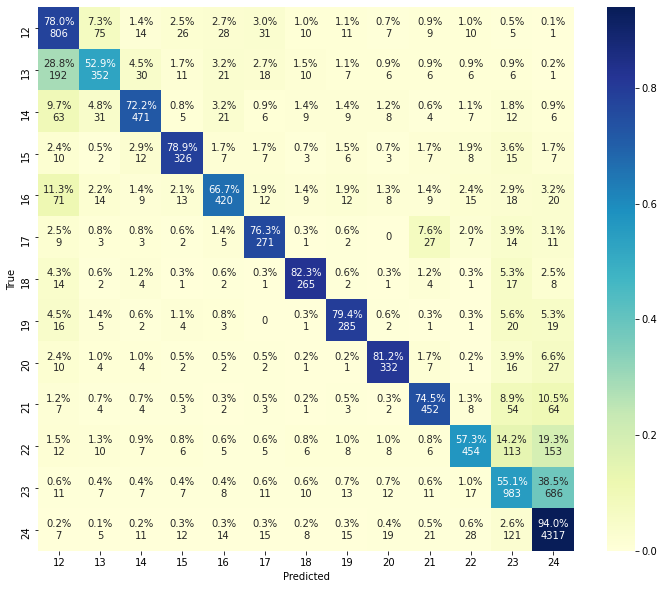

[I 2021-01-15 12:47:13,499] Trial 24 finished with value: -0.7676794975410812 and parameters: {'booster': 'gbtree', 'lambda': 2.128568663034741e-06, 'alpha': 1.2284949140042618e-08, 'min_child_weight': 2, 'learning_rate': 0.156344247900891, 'eval_metric': 'merror', 'colsample_bytree': 0.8, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.88, 'subsample': 0.6, 'max_depth': 9, 'eta': 0.0002458699023532752, 'gamma': 3.534295557838688e-05, 'grow_policy': 'lossguide'}. Best is trial 24 with value: -0.7676794975410812.


FOLD0-val acc: 76.30799605133267 FOLD0-test acc: 75.85414189456996
FOLD1-val acc: 76.11999210578252 FOLD1-test acc: 75.61632976615141
FOLD2-val acc: 76.88967831063745 FOLD2-test acc: 75.41815299246927
FOLD3-val acc: 76.49496743635287 FOLD3-test acc: 76.0919540229885
FOLD4-val acc: 78.10586608730003 FOLD4-test acc: 76.0364645263575
======================================> TTA on test acc: 76.96393182718985, mse: 3.2958382877526753
              precision    recall  f1-score   support

           0       0.66      0.79      0.72      1033
           1       0.67      0.51      0.58       666
           2       0.80      0.71      0.76       652
           3       0.78      0.79      0.79       413
           4       0.78      0.66      0.72       630
           5       0.72      0.76      0.74       355
           6       0.80      0.83      0.81       322
           7       0.75      0.79      0.77       359
           8       0.80      0.81      0.81       409
           9       0.79   

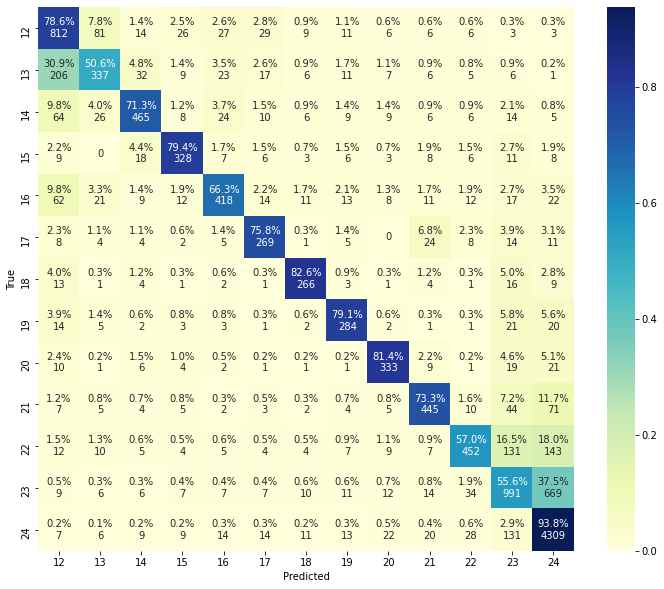

[I 2021-01-15 12:56:22,641] Trial 25 finished with value: -0.7678369999828111 and parameters: {'booster': 'gbtree', 'lambda': 1.0501487126917722e-08, 'alpha': 2.2180833780633202e-08, 'min_child_weight': 2, 'learning_rate': 0.16754633196147112, 'eval_metric': 'merror', 'colsample_bytree': 0.78, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.87, 'subsample': 0.6, 'max_depth': 10, 'eta': 0.0004032138195111091, 'gamma': 1.5104406609849679e-05, 'grow_policy': 'lossguide'}. Best is trial 25 with value: -0.7678369999828111.


FOLD0-val acc: 76.8213228035538 FOLD0-test acc: 75.16448672215617
FOLD1-val acc: 76.00157884349714 FOLD1-test acc: 75.0852160126833
FOLD2-val acc: 76.43576080521018 FOLD2-test acc: 74.90289338089576
FOLD3-val acc: 77.40280244720742 FOLD3-test acc: 75.04558065794689
FOLD4-val acc: 78.35275528342879 FOLD4-test acc: 75.68767340467697
======================================> TTA on test acc: 77.02734839476814, mse: 3.13491874752279
              precision    recall  f1-score   support

           0       0.67      0.79      0.72      1033
           1       0.67      0.52      0.59       666
           2       0.82      0.72      0.76       652
           3       0.76      0.79      0.78       413
           4       0.76      0.67      0.71       630
           5       0.73      0.76      0.74       355
           6       0.79      0.83      0.81       322
           7       0.75      0.81      0.77       359
           8       0.79      0.82      0.81       409
           9       0.80     

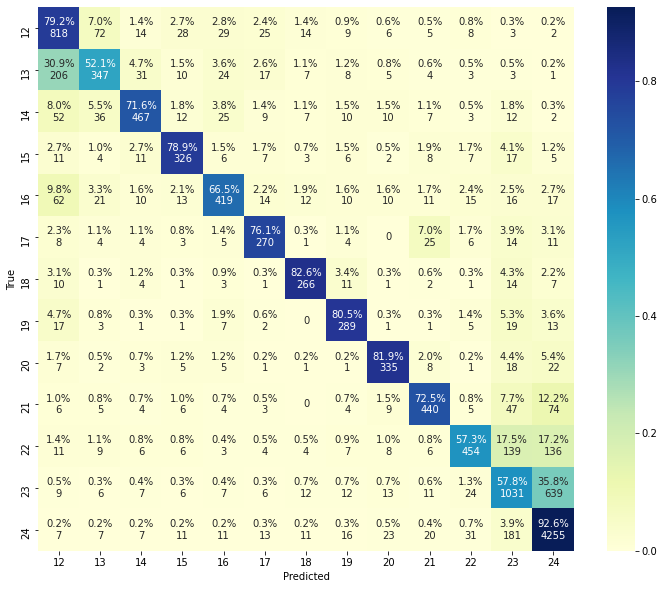

[I 2021-01-15 13:05:05,716] Trial 26 finished with value: -0.7700284403657947 and parameters: {'booster': 'gbtree', 'lambda': 2.0096249238236414e-08, 'alpha': 1.2053730869804415e-08, 'min_child_weight': 2, 'learning_rate': 0.3420095306829231, 'eval_metric': 'merror', 'colsample_bytree': 0.78, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.89, 'subsample': 0.55, 'max_depth': 9, 'eta': 0.0003302881202225289, 'gamma': 4.2693339241788407e-07, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD0-val acc: 44.027640671273446 FOLD0-test acc: 46.30202140309156
FOLD1-val acc: 43.931320307874486 FOLD1-test acc: 46.18311533888229
FOLD2-val acc: 43.97079139530294 FOLD2-test acc: 46.00079270709473
FOLD3-val acc: 46.191040063153736 FOLD3-test acc: 46.15933412604043
FOLD4-val acc: 45.151096188030806 

[I 2021-01-15 13:07:01,161] Trial 27 finished with value: -0.44654377725127076 and parameters: {'booster': 'gblinear', 'lambda': 1.1927716931685046e-08, 'alpha': 1.5415067381094017e-08, 'min_child_weight': 2, 'learning_rate': 0.31912519067108147, 'eval_metric': 'merror', 'colsample_bytree': 0.67, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.67, 'subsample': 0.55}. Best is trial 26 with value: -0.7700284403657947.


FOLD4-test acc: 46.12762584225129
======================================> TTA on test acc: 46.214823622671425, mse: 15.077764565992865
FOLD0-val acc: 74.79763079960513 FOLD0-test acc: 74.06262386048355
FOLD1-val acc: 75.01480165778567 FOLD1-test acc: 74.75227903289733
FOLD2-val acc: 76.60351292678114 FOLD2-test acc: 74.73642489100277
FOLD3-val acc: 77.39293467535032 FOLD3-test acc: 74.85533095521205
FOLD4-val acc: 76.47639739285009 FOLD4-test acc: 74.58581054300436
======================================> TTA on test acc: 77.16210860087199, mse: 3.319223147047166
              precision    recall  f1-score   support

           0       0.67      0.80      0.73      1033
           1       0.70      0.50      0.58       666
           2       0.81      0.73      0.77       652
           3       0.78      0.77      0.78       413
           4       0.77      0.66      0.71       630
           5       0.73      0.77      0.75       355
           6       0.78      0.84      0.81       32

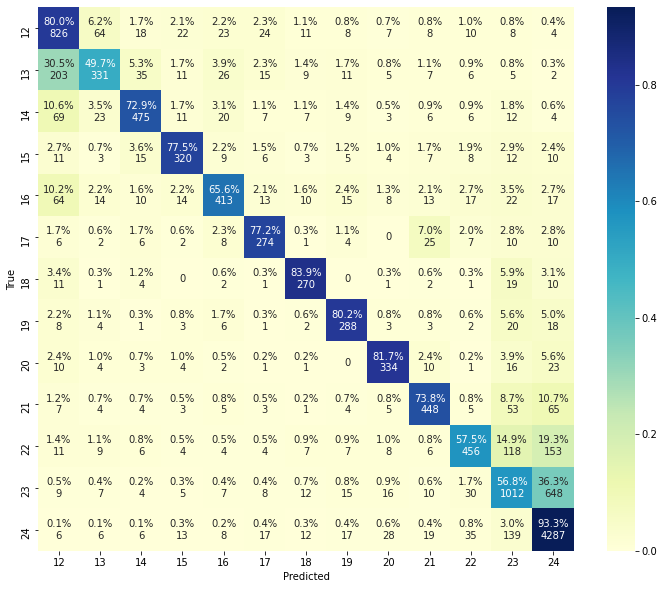

[I 2021-01-15 13:13:52,937] Trial 28 finished with value: -0.7605705549047446 and parameters: {'booster': 'gbtree', 'lambda': 1.145170394592604e-08, 'alpha': 1.0630535108706415e-08, 'min_child_weight': 1, 'learning_rate': 0.3666795831339574, 'eval_metric': 'merror', 'colsample_bytree': 0.62, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.82, 'subsample': 0.55, 'max_depth': 9, 'eta': 0.0027060937968403313, 'gamma': 4.0828847828116655e-07, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD0-val acc: 73.51431391905233 FOLD0-test acc: 72.86563614744352
FOLD1-val acc: 72.66627195579238 FOLD1-test acc: 71.89853349187474
FOLD2-val acc: 72.92283402407736 FOLD2-test acc: 72.183908045977
FOLD3-val acc: 73.78133017564635 FOLD3-test acc: 72.19976218787158
FOLD4-val acc: 73.67173612482718 

[I 2021-01-15 13:18:07,814] Trial 29 finished with value: -0.7331129723987913 and parameters: {'booster': 'gbtree', 'lambda': 3.7943379673132665e-08, 'alpha': 2.6998818721111528e-08, 'min_child_weight': 2, 'learning_rate': 0.3475343342237641, 'eval_metric': 'merror', 'colsample_bytree': 0.75, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.91, 'subsample': 0.65, 'max_depth': 4, 'eta': 0.003784775266577689, 'gamma': 1.6391467533629652e-07, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD4-test acc: 72.96868806975823
======================================> TTA on test acc: 74.00713436385256, mse: 5.644708680142688
FOLD0-val acc: 75.09378084896348 FOLD0-test acc: 76.07609988109394
FOLD1-val acc: 75.05427274521413 FOLD1-test acc: 75.465715418153
FOLD2-val acc: 75.32070258535623 FOLD2-test acc: 75.39437177962742
FOLD3-val acc: 76.06078547463983 FOLD3-test acc: 75.84621482362267
FOLD4-val acc: 76.95042464941734 FOLD4-test acc: 75.60047562425683
======================================> TTA on test acc: 77.19381688466112, mse: 3.579389615537059
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      1033
           1       0.71      0.50      0.59       666
           2       0.81      0.72      0.76       652
           3       0.77      0.79      0.78       413
           4       0.77      0.67      0.72       630
           5       0.72      0.77      0.74       355
           6       0.77      0.84      0.81       322
  

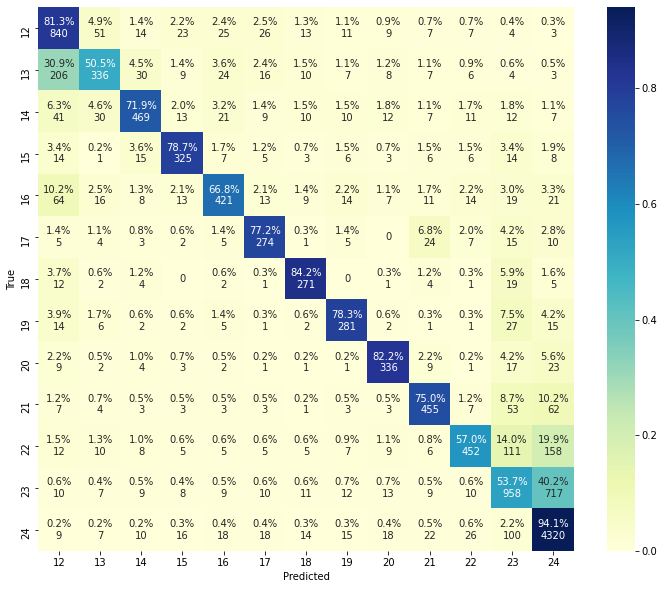

[I 2021-01-15 13:23:53,804] Trial 30 finished with value: -0.7569599326071821 and parameters: {'booster': 'gbtree', 'lambda': 1.408651757327853e-06, 'alpha': 1.0295905779352518e-08, 'min_child_weight': 2, 'learning_rate': 0.16188628137149655, 'eval_metric': 'merror', 'colsample_bytree': 0.73, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.77, 'subsample': 0.55, 'max_depth': 10, 'eta': 0.03087458683660291, 'gamma': 3.2818272837810745e-06, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD0-val acc: 76.4461994076999 FOLD0-test acc: 76.09988109393579
FOLD1-val acc: 75.79435563449773 FOLD1-test acc: 75.66389219183512
FOLD2-val acc: 75.92263666864022 FOLD2-test acc: 75.38644470868014
FOLD3-val acc: 76.67258732978094 FOLD3-test acc: 75.75108997225524
FOLD4-val acc: 77.25656725261703 FOLD4-test acc: 75.78279825604439
======================================> TTA on test acc: 76.96393182718985, mse: 3.4837098692033295
              precision    recall  f1-score   support

           0       0.67      0.80      0.73      1033
           1       0.69      0.52      0.59       666
           2       0.81      0.72      0.76       652
           3       0.79      0.78      0.78       413
           4       0.78      0.67      0.72       630
           5       0.70      0.76      0.73       355
           6       0.80      0.82      0.81       322
           7       0.76      0.80      0.78       359
           8       0.80      0.80      0.80       409
           9       0.79  

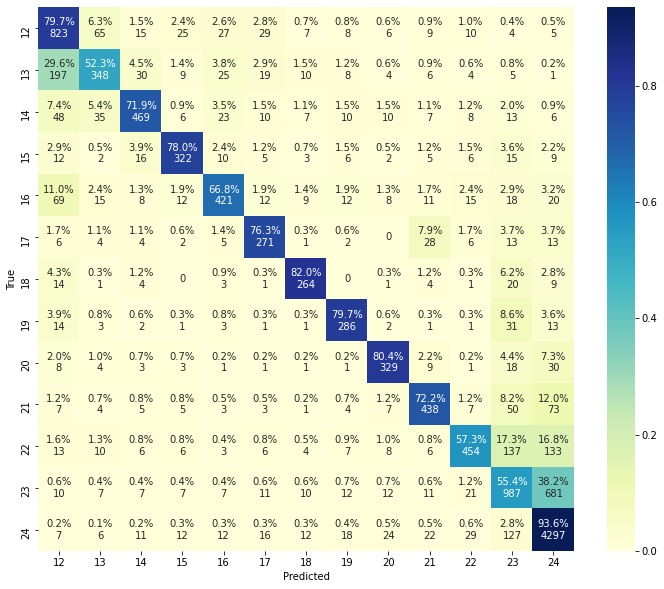

[I 2021-01-15 13:31:25,209] Trial 31 finished with value: -0.7641846925864716 and parameters: {'booster': 'gbtree', 'lambda': 2.422539866912074e-06, 'alpha': 6.846610424541368e-08, 'min_child_weight': 2, 'learning_rate': 0.17287401821441514, 'eval_metric': 'merror', 'colsample_bytree': 0.79, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.88, 'subsample': 0.6, 'max_depth': 9, 'eta': 0.00024820738944379304, 'gamma': 2.0936582769978925e-05, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD0-val acc: 76.85093780848963 FOLD0-test acc: 76.77368212445501
FOLD1-val acc: 76.13972764949675 FOLD1-test acc: 75.98097502972652
FOLD2-val acc: 75.92263666864022 FOLD2-test acc: 75.6718192627824
FOLD3-val acc: 76.96862048549437 FOLD3-test acc: 76.44074514466904
FOLD4-val acc: 77.52320758443611 FOLD4-test acc: 76.0364645263575
======================================> TTA on test acc: 77.24930638129212, mse: 3.3537059056678555
              precision    recall  f1-score   support

           0       0.65      0.79      0.71      1033
           1       0.66      0.53      0.59       666
           2       0.80      0.73      0.77       652
           3       0.78      0.79      0.78       413
           4       0.78      0.66      0.72       630
           5       0.72      0.76      0.74       355
           6       0.82      0.82      0.82       322
           7       0.78      0.80      0.79       359
           8       0.81      0.82      0.81       409
           9       0.79   

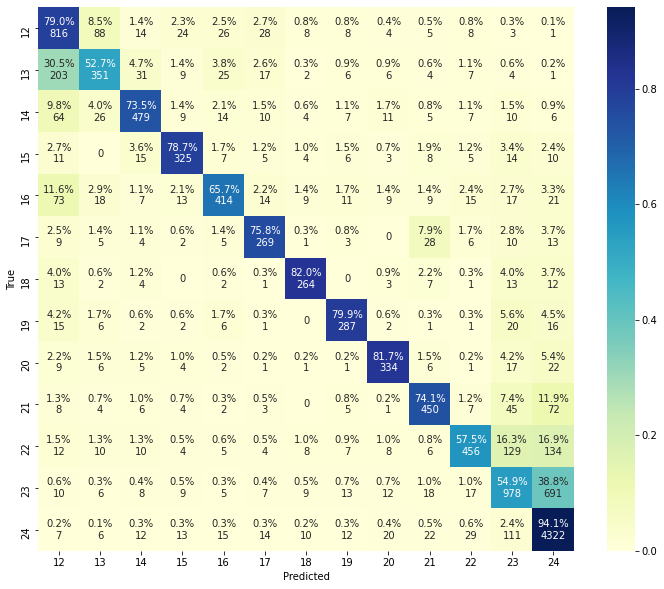

[I 2021-01-15 13:39:21,588] Trial 32 finished with value: -0.7668102603931142 and parameters: {'booster': 'gbtree', 'lambda': 9.38152915274536e-08, 'alpha': 3.333323866194859e-07, 'min_child_weight': 1, 'learning_rate': 0.05881869312780459, 'eval_metric': 'merror', 'colsample_bytree': 0.79, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.87, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 0.00017523265988067833, 'gamma': 4.343688230556101e-05, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD0-val acc: 74.09674234945706 FOLD0-test acc: 75.21997621878715
FOLD1-val acc: 74.81744622064338 FOLD1-test acc: 76.26634958382877
FOLD2-val acc: 75.39964476021315 FOLD2-test acc: 76.45659928656362
FOLD3-val acc: 76.05091770278271 FOLD3-test acc: 75.81450653983353
FOLD4-val acc: 76.92079794588189 FOLD4-test acc: 75.91755846214824
======================================> TTA on test acc: 76.90844233055886, mse: 3.649702734839477
              precision    recall  f1-score   support

           0       0.65      0.79      0.71      1033
           1       0.69      0.50      0.58       666
           2       0.82      0.72      0.77       652
           3       0.79      0.78      0.79       413
           4       0.78      0.65      0.71       630
           5       0.70      0.77      0.73       355
           6       0.78      0.84      0.81       322
           7       0.76      0.80      0.78       359
           8       0.82      0.80      0.81       409
           9       0.79  

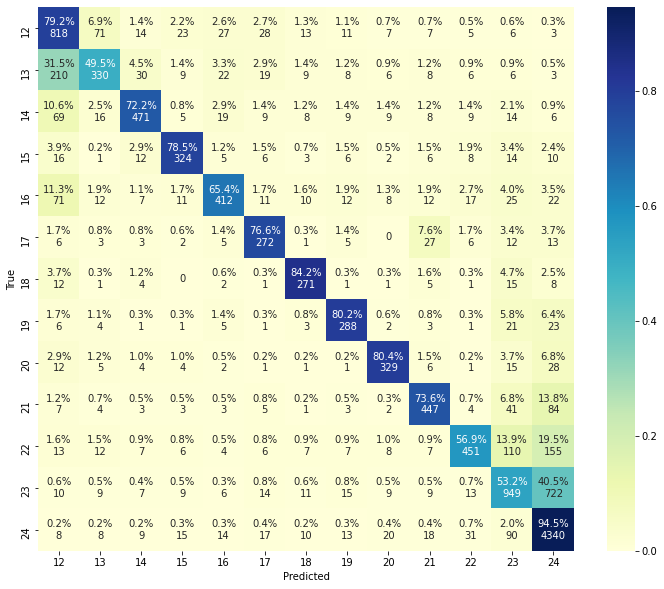

[I 2021-01-15 13:45:50,524] Trial 33 finished with value: -0.7545710979579564 and parameters: {'booster': 'gbtree', 'lambda': 3.626383177010006e-08, 'alpha': 5.467430618096353e-08, 'min_child_weight': 2, 'learning_rate': 0.16759932162448715, 'eval_metric': 'merror', 'colsample_bytree': 0.48, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.93, 'subsample': 0.75, 'max_depth': 9, 'eta': 0.0007078833078038192, 'gamma': 4.534265965593981e-06, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD0-val acc: 76.17966436327738 FOLD0-test acc: 75.71145461751883
FOLD1-val acc: 76.248273139925 FOLD1-test acc: 75.47364248910029
FOLD2-val acc: 77.12650483520821 FOLD2-test acc: 75.06143479984145
FOLD3-val acc: 77.09690151963686 FOLD3-test acc: 75.43400713436385
FOLD4-val acc: 77.14793600632036 FOLD4-test acc: 75.1486325802616
======================================> TTA on test acc: 77.0432025366627, mse: 3.3491874752279034
              precision    recall  f1-score   support

           0       0.66      0.77      0.71      1033
           1       0.67      0.52      0.59       666
           2       0.81      0.72      0.76       652
           3       0.78      0.79      0.79       413
           4       0.78      0.66      0.72       630
           5       0.72      0.77      0.74       355
           6       0.80      0.82      0.81       322
           7       0.76      0.80      0.78       359
           8       0.80      0.81      0.81       409
           9       0.79     

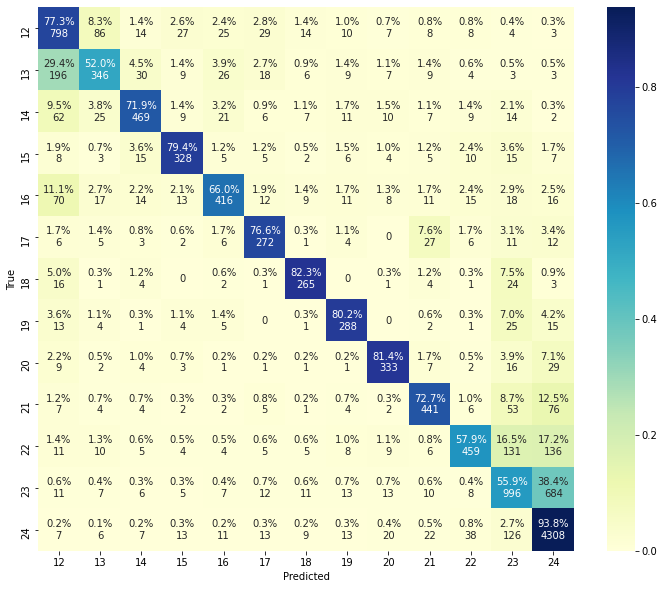

[I 2021-01-15 13:51:27,269] Trial 34 finished with value: -0.7675985597287356 and parameters: {'booster': 'gbtree', 'lambda': 4.876694857723607e-07, 'alpha': 5.116296001438722e-07, 'min_child_weight': 2, 'learning_rate': 0.29610686194875196, 'eval_metric': 'merror', 'colsample_bytree': 0.94, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.86, 'subsample': 0.65, 'max_depth': 7, 'eta': 9.919540195767347e-05, 'gamma': 8.050595274542063e-08, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD0-val acc: 75.53800592300098 FOLD0-test acc: 74.93460166468489
FOLD1-val acc: 75.83382672192619 FOLD1-test acc: 74.86325802615933
FOLD2-val acc: 76.27787645549635 FOLD2-test acc: 74.89496630994847
FOLD3-val acc: 77.10676929149398 FOLD3-test acc: 75.6797463337297
FOLD4-val acc: 76.45664625715979 FOLD4-test acc: 74.37177962742767
======================================> TTA on test acc: 76.51208878319461, mse: 3.4593737613951645
              precision    recall  f1-score   support

           0       0.66      0.77      0.71      1033
           1       0.63      0.50      0.56       666
           2       0.82      0.73      0.77       652
           3       0.79      0.77      0.78       413
           4       0.77      0.67      0.71       630
           5       0.71      0.75      0.73       355
           6       0.82      0.82      0.82       322
           7       0.77      0.81      0.79       359
           8       0.81      0.81      0.81       409
           9       0.78  

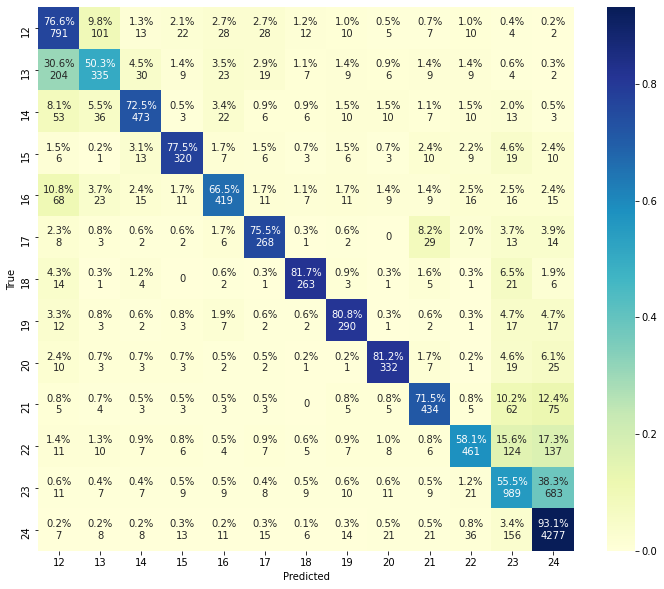

[I 2021-01-15 13:56:40,976] Trial 35 finished with value: -0.7624262492981546 and parameters: {'booster': 'gbtree', 'lambda': 4.4544631149753357e-07, 'alpha': 1.025167893727585e-08, 'min_child_weight': 1, 'learning_rate': 0.314164013624285, 'eval_metric': 'merror', 'colsample_bytree': 0.94, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.79, 'subsample': 0.65, 'max_depth': 7, 'eta': 0.0019048300998921902, 'gamma': 6.426451915238643e-08, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD0-val acc: 44.2152023692004 FOLD0-test acc: 46.55568767340468
FOLD1-val acc: 43.83264258930333 FOLD1-test acc: 46.38921918351169
FOLD2-val acc: 44.38523781330176 FOLD2-test acc: 46.38129211256441
FOLD3-val acc: 46.38839550029603 FOLD3-test acc: 46.44470868014269
FOLD4-val acc: 45.249851866482324 

[I 2021-01-15 13:58:34,660] Trial 36 finished with value: -0.4481426602771677 and parameters: {'booster': 'gblinear', 'lambda': 1.9106231359958665e-08, 'alpha': 5.2929582813687554e-08, 'min_child_weight': 2, 'learning_rate': 0.44823747512282414, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.59, 'subsample': 0.6}. Best is trial 26 with value: -0.7700284403657947.


FOLD4-test acc: 46.206896551724135
======================================> TTA on test acc: 46.50019817677368, mse: 14.883472057074911
FOLD0-val acc: 70.45409674234946 FOLD0-test acc: 72.88941736028538
FOLD1-val acc: 71.44266824551016 FOLD1-test acc: 73.26198969480777
FOLD2-val acc: 72.0742056443655 FOLD2-test acc: 73.20650019817677
FOLD3-val acc: 72.89323070850602 FOLD3-test acc: 72.84185493460167
FOLD4-val acc: 73.80011850681414 

[I 2021-01-15 14:03:26,277] Trial 37 finished with value: -0.7213286396950905 and parameters: {'booster': 'gbtree', 'lambda': 5.05706425524892e-06, 'alpha': 0.0816540826951711, 'min_child_weight': 3, 'learning_rate': 0.005061412886641756, 'eval_metric': 'merror', 'colsample_bytree': 0.59, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.85, 'subsample': 0.55, 'max_depth': 7, 'eta': 8.087538922291918e-05, 'gamma': 1.8121868859911384e-06, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD4-test acc: 74.30836305984938
======================================> TTA on test acc: 73.90408244153785, mse: 6.145778834720571
FOLD0-val acc: 63.721618953603155 FOLD0-test acc: 66.25445897740785
FOLD1-val acc: 67.68304716794947 FOLD1-test acc: 69.78993261989694
FOLD2-val acc: 67.37714624037892 FOLD2-test acc: 69.71858898137138
FOLD3-val acc: 69.09413854351686 FOLD3-test acc: 69.56004756242568
FOLD4-val acc: 70.04740272565672 

[I 2021-01-15 14:04:42,228] Trial 38 finished with value: -0.6758467072622103 and parameters: {'booster': 'gbtree', 'lambda': 5.387183941745358e-07, 'alpha': 1.0712206509325275e-08, 'min_child_weight': 2, 'learning_rate': 0.2668769399096866, 'eval_metric': 'merror', 'colsample_bytree': 0.51, 'colsample_bynode': 0.48, 'colsample_bylevel': 0.22, 'subsample': 0.65, 'max_depth': 6, 'eta': 0.030471009785373367, 'gamma': 4.635023367329255e-07, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD4-test acc: 70.9235037653587
======================================> TTA on test acc: 71.05826397146254, mse: 7.649464922711058
FOLD0-val acc: 43.65251727541954 FOLD0-test acc: 45.96908442330559
FOLD1-val acc: 44.03986579830274 FOLD1-test acc: 45.89774078478002
FOLD2-val acc: 43.59581606473258 FOLD2-test acc: 45.76298057867618
FOLD3-val acc: 45.825932504440495 FOLD3-test acc: 45.945303210463734
FOLD4-val acc: 45.22022516294687 

[I 2021-01-15 14:06:35,613] Trial 39 finished with value: -0.4446687136116845 and parameters: {'booster': 'gblinear', 'lambda': 1.1985474245579478e-07, 'alpha': 3.242611830633004e-08, 'min_child_weight': 2, 'learning_rate': 0.20973834317130297, 'eval_metric': 'merror', 'colsample_bytree': 0.72, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.66, 'subsample': 0.5}. Best is trial 26 with value: -0.7700284403657947.


FOLD4-test acc: 45.95323028141102
======================================> TTA on test acc: 45.810543004359886, mse: 15.32659532302814
FOLD0-val acc: 73.01085883514314 FOLD0-test acc: 74.7284978200555
FOLD1-val acc: 71.59068482336689 FOLD1-test acc: 74.31629013079667
FOLD2-val acc: 72.32089994079337 FOLD2-test acc: 74.05469678953627
FOLD3-val acc: 73.86027235050325 FOLD3-test acc: 74.34799841458582
FOLD4-val acc: 74.60003950227137 

[I 2021-01-15 14:10:23,903] Trial 40 finished with value: -0.730765510904156 and parameters: {'booster': 'gbtree', 'lambda': 5.807553139091576e-08, 'alpha': 0.00023577802052793568, 'min_child_weight': 1, 'learning_rate': 0.06883851579729805, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.82, 'colsample_bynode': 0.4, 'colsample_bylevel': 0.94, 'subsample': 0.6, 'max_depth': 7, 'eta': 0.0011268265751245773, 'gamma': 1.1551800386849888e-07, 'grow_policy': 'depthwise'}. Best is trial 26 with value: -0.7700284403657947.


FOLD4-test acc: 74.86325802615933
======================================> TTA on test acc: 75.32302814110187, mse: 5.000792707094728
FOLD0-val acc: 76.48568608094767 FOLD0-test acc: 75.97304795877923
FOLD1-val acc: 76.84033945135188 FOLD1-test acc: 76.40110978993262
FOLD2-val acc: 76.64298401420959 FOLD2-test acc: 76.0443915973048
FOLD3-val acc: 76.54430629563845 FOLD3-test acc: 76.31391200951249
FOLD4-val acc: 77.72071894133913 FOLD4-test acc: 76.31391200951249
======================================> TTA on test acc: 77.13040031708283, mse: 3.2335315101070154
              precision    recall  f1-score   support

           0       0.66      0.80      0.72      1033
           1       0.69      0.51      0.59       666
           2       0.81      0.72      0.76       652
           3       0.77      0.78      0.78       413
           4       0.79      0.67      0.72       630
           5       0.73      0.78      0.76       355
           6       0.80      0.82      0.81       322


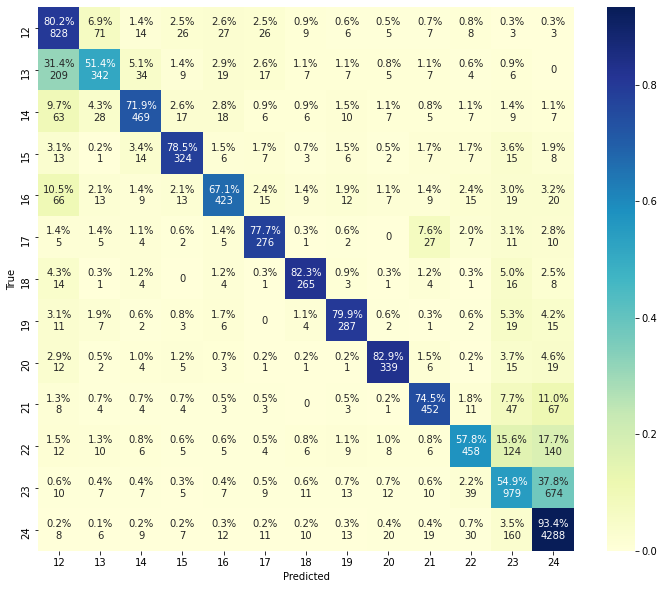

[I 2021-01-15 14:18:04,456] Trial 41 finished with value: -0.7684680695669734 and parameters: {'booster': 'gbtree', 'lambda': 3.1209086063327024e-06, 'alpha': 4.499512775392265e-07, 'min_child_weight': 2, 'learning_rate': 0.08901068972827389, 'eval_metric': 'merror', 'colsample_bytree': 0.77, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.87, 'subsample': 0.8, 'max_depth': 10, 'eta': 9.871291824233498e-05, 'gamma': 8.563264945267781e-06, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7700284403657947.


FOLD0-val acc: 76.96939782823297 FOLD0-test acc: 76.24256837098692
FOLD1-val acc: 76.49496743635287 FOLD1-test acc: 75.36266349583829
FOLD2-val acc: 76.82060390763765 FOLD2-test acc: 75.61632976615141
FOLD3-val acc: 77.67910005920663 FOLD3-test acc: 75.90170432025367
FOLD4-val acc: 77.33557179537823 FOLD4-test acc: 76.09988109393579
======================================> TTA on test acc: 77.49504558065794, mse: 2.9961157352358305
              precision    recall  f1-score   support

           0       0.66      0.80      0.73      1033
           1       0.71      0.52      0.60       666
           2       0.81      0.73      0.77       652
           3       0.78      0.80      0.79       413
           4       0.77      0.67      0.71       630
           5       0.73      0.77      0.75       355
           6       0.80      0.82      0.81       322
           7       0.77      0.81      0.79       359
           8       0.81      0.82      0.82       409
           9       0.79 

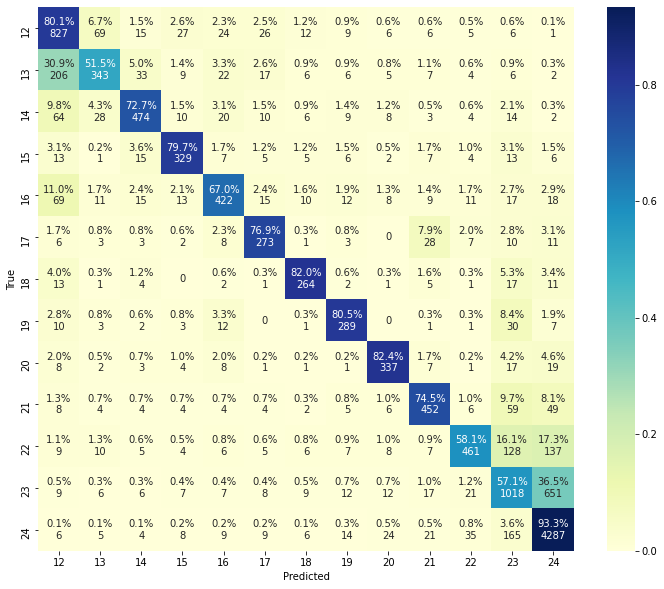

[I 2021-01-15 14:28:23,379] Trial 42 finished with value: -0.7705992820536166 and parameters: {'booster': 'gbtree', 'lambda': 2.3326686602320925e-06, 'alpha': 1.6087970648998295e-07, 'min_child_weight': 2, 'learning_rate': 0.2736647271154232, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.75, 'colsample_bylevel': 1.0, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 9.692784377083902e-05, 'gamma': 5.877174214411033e-06, 'grow_policy': 'lossguide'}. Best is trial 42 with value: -0.7705992820536166.


FOLD0-val acc: 76.85093780848963 FOLD0-test acc: 76.86880697582244
FOLD1-val acc: 77.00809157292284 FOLD1-test acc: 76.58343242172018
FOLD2-val acc: 76.28774422735346 FOLD2-test acc: 75.6718192627824
FOLD3-val acc: 76.92914939806592 FOLD3-test acc: 75.90963139120095
FOLD4-val acc: 78.00711040884852 FOLD4-test acc: 76.48830757035276
======================================> TTA on test acc: 77.70907649623464, mse: 3.1543400713436385
              precision    recall  f1-score   support

           0       0.67      0.81      0.73      1033
           1       0.71      0.56      0.63       666
           2       0.81      0.72      0.76       652
           3       0.78      0.78      0.78       413
           4       0.77      0.67      0.71       630
           5       0.73      0.76      0.75       355
           6       0.83      0.82      0.83       322
           7       0.77      0.80      0.78       359
           8       0.81      0.82      0.82       409
           9       0.79  

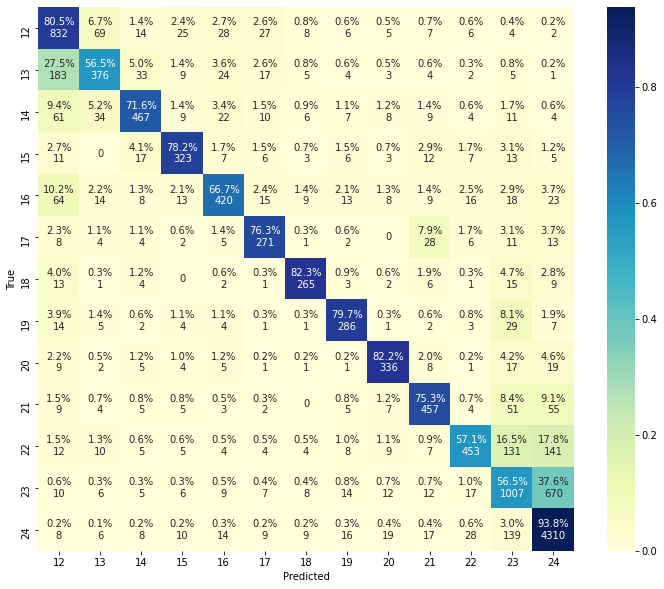

[I 2021-01-15 14:37:13,718] Trial 43 finished with value: -0.7701660668313608 and parameters: {'booster': 'gbtree', 'lambda': 4.3306016999478926e-06, 'alpha': 1.524480852587644e-07, 'min_child_weight': 2, 'learning_rate': 0.10002745657838755, 'eval_metric': 'merror', 'colsample_bytree': 0.77, 'colsample_bynode': 0.76, 'colsample_bylevel': 1.0, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 9.62283862667593e-06, 'gamma': 6.374195188849803e-06, 'grow_policy': 'lossguide'}. Best is trial 42 with value: -0.7705992820536166.


FOLD0-val acc: 75.79466929911155 FOLD0-test acc: 76.06817281014665
FOLD1-val acc: 75.42924807578449 FOLD1-test acc: 76.59928656361474
FOLD2-val acc: 76.03118215906848 FOLD2-test acc: 76.13951644867221
FOLD3-val acc: 76.7811328202092 FOLD3-test acc: 75.90170432025367
FOLD4-val acc: 77.72071894133913 FOLD4-test acc: 76.55172413793103
======================================> TTA on test acc: 77.17796274276655, mse: 3.5449068569163695
              precision    recall  f1-score   support

           0       0.66      0.80      0.73      1033
           1       0.67      0.53      0.60       666
           2       0.80      0.72      0.76       652
           3       0.76      0.78      0.77       413
           4       0.80      0.66      0.72       630
           5       0.71      0.76      0.74       355
           6       0.81      0.83      0.82       322
           7       0.78      0.80      0.79       359
           8       0.82      0.82      0.82       409
           9       0.80  

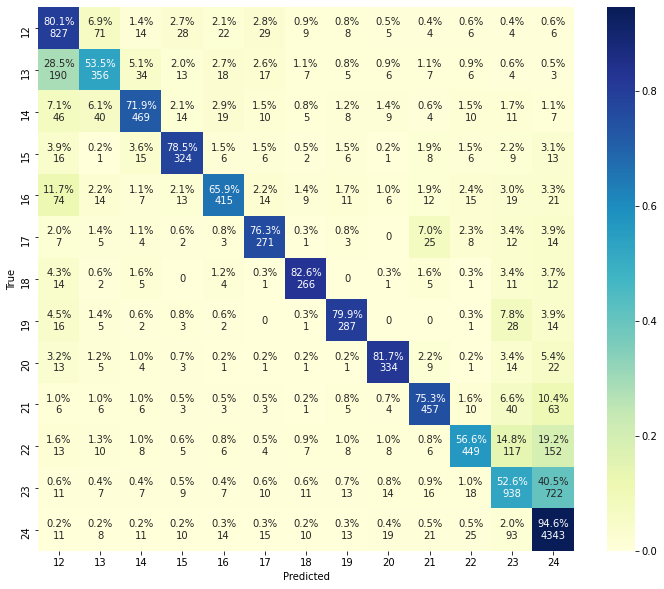

[I 2021-01-15 14:45:10,198] Trial 44 finished with value: -0.7635139025910258 and parameters: {'booster': 'gbtree', 'lambda': 5.217471315737167e-05, 'alpha': 2.116434826562815e-07, 'min_child_weight': 2, 'learning_rate': 0.03650214338015076, 'eval_metric': 'merror', 'colsample_bytree': 0.7, 'colsample_bynode': 0.75, 'colsample_bylevel': 1.0, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 9.486001449516086e-07, 'gamma': 7.818834273460811e-06, 'grow_policy': 'lossguide'}. Best is trial 42 with value: -0.7705992820536166.


FOLD0-val acc: 70.34550839091807 FOLD0-test acc: 73.73761395164486
FOLD1-val acc: 74.35366094335899 FOLD1-test acc: 75.80657946888624
FOLD2-val acc: 74.51154529307283 FOLD2-test acc: 76.21086008719779
FOLD3-val acc: 74.31418985593054 FOLD3-test acc: 75.64011097899326
FOLD4-val acc: 75.2222002765159 FOLD4-test acc: 75.69560047562426
======================================> TTA on test acc: 76.3614744351962, mse: 4.390883868410622
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      1033
           1       0.69      0.51      0.59       666
           2       0.80      0.72      0.75       652
           3       0.79      0.78      0.79       413
           4       0.79      0.65      0.72       630
           5       0.70      0.75      0.73       355
           6       0.76      0.82      0.79       322
           7       0.75      0.80      0.78       359
           8       0.81      0.80      0.80       409
           9       0.79    

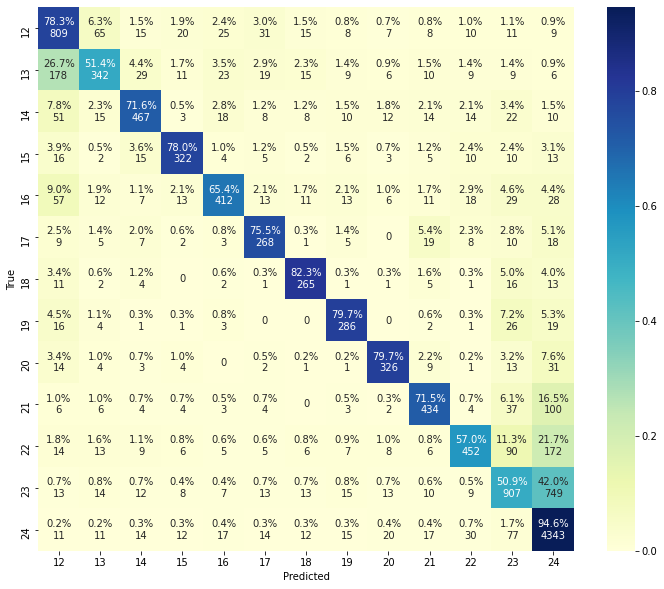

[I 2021-01-15 14:50:44,300] Trial 45 finished with value: -0.7374942095195925 and parameters: {'booster': 'gbtree', 'lambda': 5.221108531514867e-06, 'alpha': 4.408555859420997e-06, 'min_child_weight': 3, 'learning_rate': 0.09516862901969769, 'eval_metric': 'merror', 'colsample_bytree': 0.39, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.94, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 3.51538888220017e-06, 'gamma': 8.401403700889422e-07, 'grow_policy': 'depthwise'}. Best is trial 42 with value: -0.7705992820536166.


FOLD0-val acc: 76.1599210266535 FOLD0-test acc: 76.28220372572333
FOLD1-val acc: 75.96210775606868 FOLD1-test acc: 76.58343242172018
FOLD2-val acc: 76.14959542135385 FOLD2-test acc: 76.25842251288148
FOLD3-val acc: 76.61338069863824 FOLD3-test acc: 76.82124455013873
FOLD4-val acc: 77.6022121271973 FOLD4-test acc: 76.34562029330164
======================================> TTA on test acc: 77.78834720570748, mse: 3.300753071739992
              precision    recall  f1-score   support

           0       0.67      0.81      0.73      1033
           1       0.68      0.52      0.59       666
           2       0.81      0.71      0.76       652
           3       0.78      0.79      0.79       413
           4       0.78      0.66      0.71       630
           5       0.72      0.76      0.74       355
           6       0.80      0.81      0.80       322
           7       0.77      0.81      0.79       359
           8       0.79      0.82      0.81       409
           9       0.79    

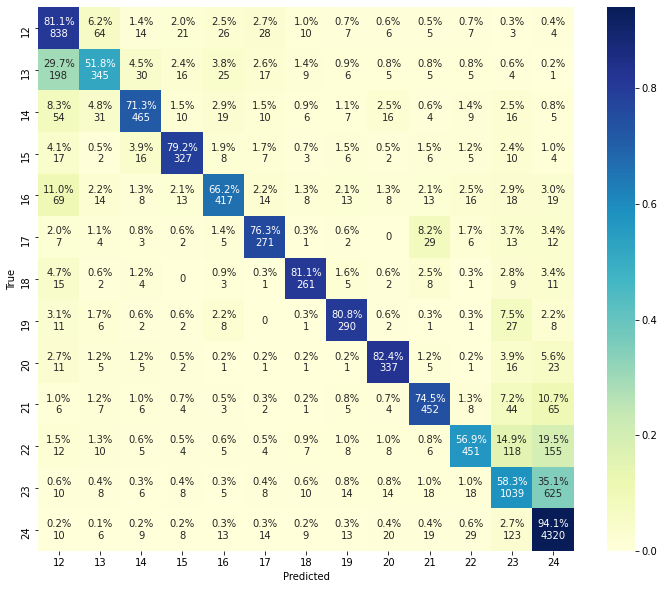

[I 2021-01-15 14:57:57,745] Trial 46 finished with value: -0.7649744340598232 and parameters: {'booster': 'gbtree', 'lambda': 2.2464489523086592e-07, 'alpha': 1.1068222345540818e-06, 'min_child_weight': 1, 'learning_rate': 0.050121996144974076, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.76, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.91, 'subsample': 0.9, 'max_depth': 10, 'eta': 1.1900243194591699e-05, 'gamma': 2.135355476443006e-06, 'grow_policy': 'lossguide'}. Best is trial 42 with value: -0.7705992820536166.


FOLD0-val acc: 76.2290227048371 FOLD0-test acc: 75.97304795877923
FOLD1-val acc: 76.66271955792382 FOLD1-test acc: 75.70352754657154
FOLD2-val acc: 76.19893428063943 FOLD2-test acc: 75.94926674593736
FOLD3-val acc: 76.57390961120979 FOLD3-test acc: 76.07609988109394
FOLD4-val acc: 77.17756270985582 FOLD4-test acc: 76.34562029330164
======================================> TTA on test acc: 77.28101466508124, mse: 3.3885850178359096
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      1033
           1       0.68      0.54      0.60       666
           2       0.81      0.72      0.76       652
           3       0.76      0.78      0.77       413
           4       0.77      0.66      0.71       630
           5       0.72      0.77      0.75       355
           6       0.80      0.82      0.81       322
           7       0.77      0.81      0.79       359
           8       0.81      0.82      0.82       409
           9       0.80  

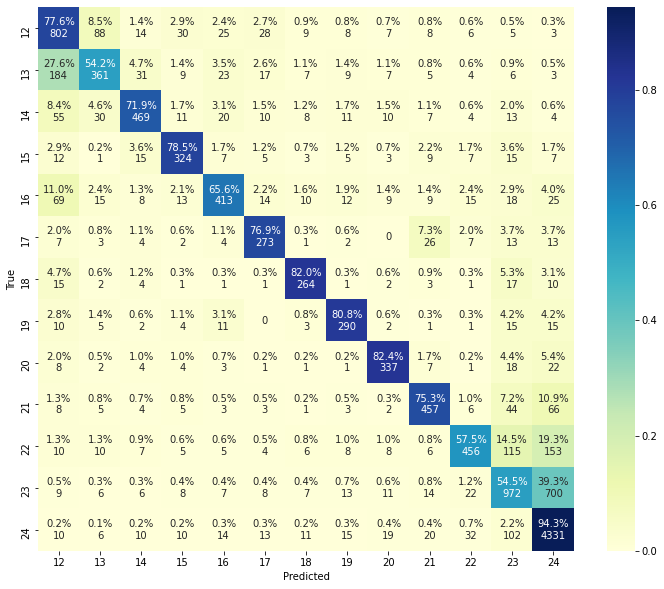

[I 2021-01-15 15:06:52,652] Trial 47 finished with value: -0.7656842977289319 and parameters: {'booster': 'gbtree', 'lambda': 9.742672109946922e-07, 'alpha': 9.169028272574333e-08, 'min_child_weight': 2, 'learning_rate': 0.10662530925517742, 'eval_metric': 'merror', 'colsample_bytree': 0.6799999999999999, 'colsample_bynode': 0.85, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'max_depth': 10, 'eta': 6.7776494589989e-05, 'gamma': 7.009535402866018e-06, 'grow_policy': 'lossguide'}. Best is trial 42 with value: -0.7705992820536166.


FOLD0-val acc: 76.5350444225074 FOLD0-test acc: 76.92429647245342
FOLD1-val acc: 76.47523189263865 FOLD1-test acc: 76.2504954419342
FOLD2-val acc: 76.90941385435168 FOLD2-test acc: 76.40110978993262
FOLD3-val acc: 77.27452141306493 FOLD3-test acc: 76.91636940150615
FOLD4-val acc: 77.64171439857792 FOLD4-test acc: 76.71819262782402
======================================> TTA on test acc: 77.55053507728894, mse: 3.126040428061831
              precision    recall  f1-score   support

           0       0.65      0.81      0.72      1033
           1       0.68      0.52      0.59       666
           2       0.80      0.72      0.76       652
           3       0.79      0.79      0.79       413
           4       0.77      0.68      0.72       630
           5       0.73      0.77      0.75       355
           6       0.86      0.83      0.84       322
           7       0.78      0.80      0.79       359
           8       0.83      0.82      0.83       409
           9       0.81    

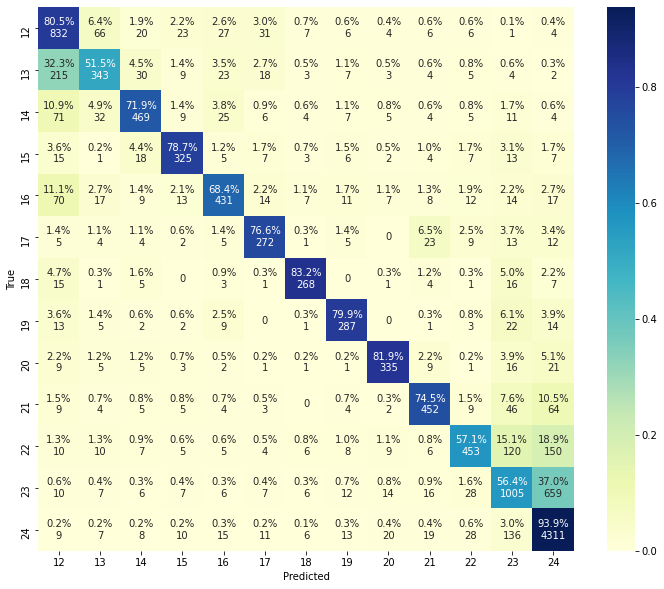

[I 2021-01-15 15:14:35,150] Trial 48 finished with value: -0.7696718519622812 and parameters: {'booster': 'gbtree', 'lambda': 4.737061002384059e-05, 'alpha': 4.809382960013426e-08, 'min_child_weight': 3, 'learning_rate': 0.08665380143973196, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.8099999999999999, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.0006370272336450358, 'gamma': 1.2929710800244121e-05, 'grow_policy': 'depthwise'}. Best is trial 42 with value: -0.7705992820536166.


FOLD0-val acc: 59.39782823297137 FOLD0-test acc: 60.39635354736424
FOLD1-val acc: 60.33155713439905 FOLD1-test acc: 60.91954022988506
FOLD2-val acc: 60.30195381882771 FOLD2-test acc: 61.284185493460164
FOLD3-val acc: 61.061772251825545 FOLD3-test acc: 59.27863654379707
FOLD4-val acc: 59.036144578313255 

[I 2021-01-15 15:16:33,623] Trial 49 finished with value: -0.6002585120326739 and parameters: {'booster': 'gbtree', 'lambda': 6.467051233251851e-05, 'alpha': 2.587176819491481e-07, 'min_child_weight': 4, 'learning_rate': 0.06682062590370531, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.82, 'subsample': 0.9, 'max_depth': 2, 'eta': 0.010926661242253445, 'gamma': 1.2101444506873123e-06, 'grow_policy': 'depthwise'}. Best is trial 42 with value: -0.7705992820536166.


FOLD4-test acc: 60.515259611573526
======================================> TTA on test acc: 61.25247720967103, mse: 16.328735632183907
FOLD0-val acc: 76.64363277393879 FOLD0-test acc: 76.85295283392787
FOLD1-val acc: 75.98184329978291 FOLD1-test acc: 76.29013079667062
FOLD2-val acc: 76.32721531478192 FOLD2-test acc: 76.63892191835117
FOLD3-val acc: 77.11663706335109 FOLD3-test acc: 76.0364645263575
FOLD4-val acc: 77.6022121271973 FOLD4-test acc: 76.29805786761791
======================================> TTA on test acc: 77.1541815299247, mse: 3.4355925485533096
              precision    recall  f1-score   support

           0       0.66      0.79      0.72      1033
           1       0.66      0.52      0.58       666
           2       0.81      0.72      0.76       652
           3       0.76      0.78      0.77       413
           4       0.77      0.66      0.71       630
           5       0.73      0.76      0.74       355
           6       0.83      0.83      0.83       322


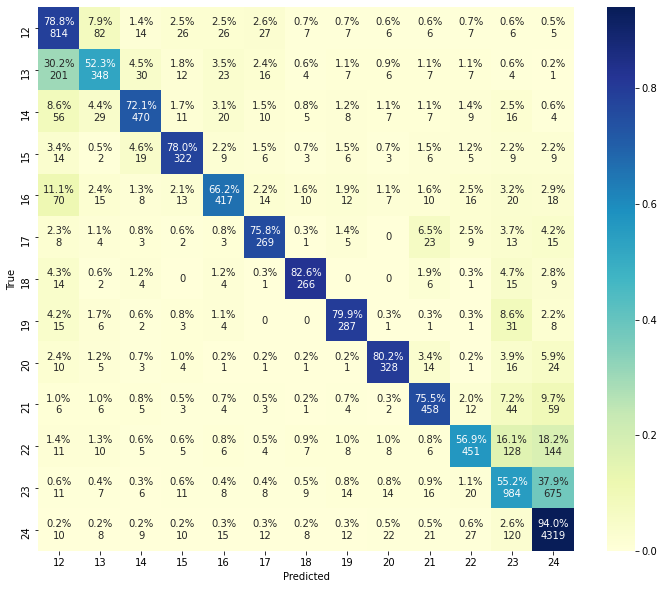

[I 2021-01-15 15:23:42,463] Trial 50 finished with value: -0.7673430811581041 and parameters: {'booster': 'gbtree', 'lambda': 0.0005803851136616133, 'alpha': 1.3130634137712416e-06, 'min_child_weight': 3, 'learning_rate': 0.03518187053013518, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.85, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.73, 'subsample': 0.9, 'max_depth': 10, 'eta': 5.572494039053333e-06, 'gamma': 5.9791330657640656e-05, 'grow_policy': 'depthwise'}. Best is trial 42 with value: -0.7705992820536166.


FOLD0-val acc: 77.62092793682133 FOLD0-test acc: 76.10780816488307
FOLD1-val acc: 77.08703374777976 FOLD1-test acc: 76.39318271898533
FOLD2-val acc: 77.07716597592264 FOLD2-test acc: 75.71938168846611
FOLD3-val acc: 77.07716597592264 FOLD3-test acc: 76.2029330162505
FOLD4-val acc: 78.45151096188032 FOLD4-test acc: 76.09988109393579
======================================> TTA on test acc: 77.0432025366627, mse: 3.164169639318272
              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1033
           1       0.65      0.53      0.59       666
           2       0.81      0.72      0.76       652
           3       0.78      0.79      0.79       413
           4       0.76      0.67      0.71       630
           5       0.73      0.76      0.75       355
           6       0.82      0.81      0.82       322
           7       0.78      0.79      0.78       359
           8       0.84      0.82      0.83       409
           9       0.79    

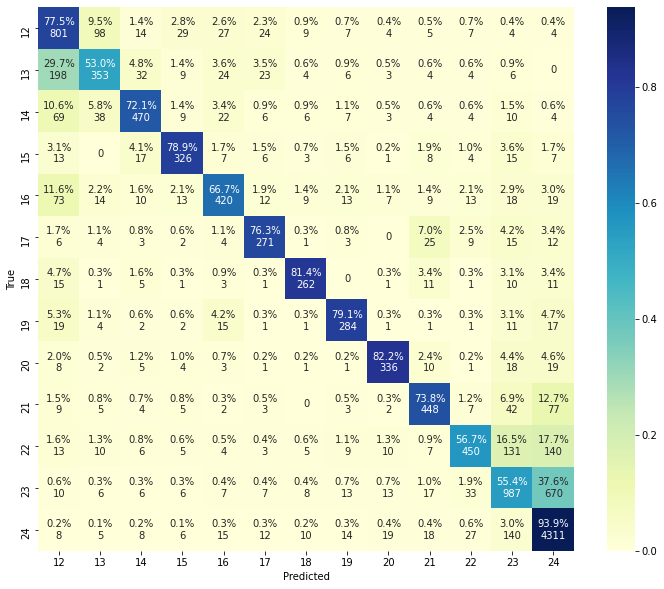

[I 2021-01-15 15:35:08,559] Trial 51 finished with value: -0.7746276091966533 and parameters: {'booster': 'gbtree', 'lambda': 3.6279146944163076e-06, 'alpha': 2.523968545026214e-08, 'min_child_weight': 3, 'learning_rate': 0.08251699635198367, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.96, 'subsample': 0.8, 'max_depth': 10, 'eta': 0.0004783738423986298, 'gamma': 1.426491428926585e-05, 'grow_policy': 'depthwise'}. Best is trial 51 with value: -0.7746276091966533.


FOLD0-val acc: 77.3050345508391 FOLD0-test acc: 76.29013079667062
FOLD1-val acc: 76.72192618906651 FOLD1-test acc: 75.92548553309551
FOLD2-val acc: 76.64298401420959 FOLD2-test acc: 75.71145461751883
FOLD3-val acc: 77.28438918492205 FOLD3-test acc: 76.19500594530321
FOLD4-val acc: 78.61939561524788 FOLD4-test acc: 75.66389219183512
======================================> TTA on test acc: 77.0986920332937, mse: 3.26397146254459
              precision    recall  f1-score   support

           0       0.66      0.80      0.72      1033
           1       0.67      0.53      0.59       666
           2       0.81      0.72      0.76       652
           3       0.76      0.79      0.78       413
           4       0.77      0.65      0.71       630
           5       0.72      0.76      0.74       355
           6       0.82      0.81      0.82       322
           7       0.78      0.79      0.79       359
           8       0.83      0.82      0.82       409
           9       0.78     

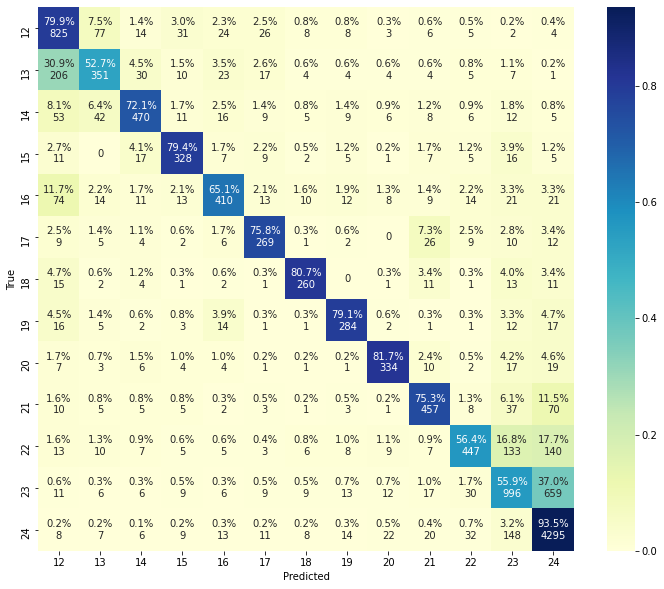

[I 2021-01-15 15:46:50,825] Trial 52 finished with value: -0.7731474591085702 and parameters: {'booster': 'gbtree', 'lambda': 1.0038000815583997e-05, 'alpha': 4.411480376735524e-08, 'min_child_weight': 3, 'learning_rate': 0.07760944890639504, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.96, 'subsample': 0.8, 'max_depth': 10, 'eta': 0.000639292072755118, 'gamma': 1.459211137209658e-05, 'grow_policy': 'depthwise'}. Best is trial 51 with value: -0.7746276091966533.


FOLD0-val acc: 77.20631786771965 FOLD0-test acc: 76.5200158541419
FOLD1-val acc: 76.27787645549635 FOLD1-test acc: 76.25842251288148
FOLD2-val acc: 76.86007499506611 FOLD2-test acc: 75.54498612762585
FOLD3-val acc: 77.26465364120781 FOLD3-test acc: 76.29805786761791
FOLD4-val acc: 78.46138652972546 FOLD4-test acc: 75.61632976615141
======================================> TTA on test acc: 76.94807768529527, mse: 3.2841062227506934
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      1033
           1       0.68      0.53      0.60       666
           2       0.79      0.72      0.76       652
           3       0.75      0.79      0.77       413
           4       0.76      0.66      0.71       630
           5       0.72      0.75      0.74       355
           6       0.83      0.82      0.83       322
           7       0.77      0.80      0.79       359
           8       0.82      0.82      0.82       409
           9       0.81  

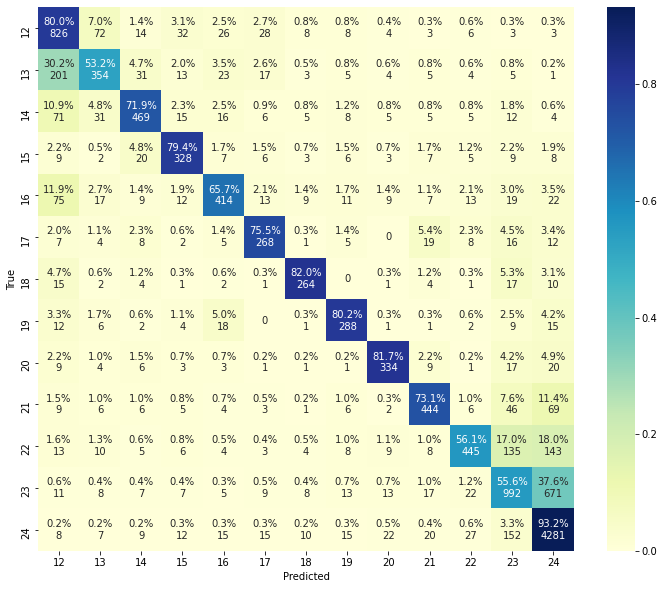

[I 2021-01-15 15:57:08,081] Trial 53 finished with value: -0.7721406189784308 and parameters: {'booster': 'gbtree', 'lambda': 9.007591946284428e-06, 'alpha': 5.5111242793336366e-08, 'min_child_weight': 4, 'learning_rate': 0.055286317551181186, 'eval_metric': 'merror', 'colsample_bytree': 0.88, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.96, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 0.0009938887940721835, 'gamma': 3.897868203744547e-06, 'grow_policy': 'depthwise'}. Best is trial 51 with value: -0.7746276091966533.


FOLD0-val acc: 77.53208292201383 FOLD0-test acc: 75.59254855330956
FOLD1-val acc: 76.9883560292086 FOLD1-test acc: 75.97304795877923
FOLD2-val acc: 76.61338069863824 FOLD2-test acc: 75.40229885057471
FOLD3-val acc: 76.45549634892441 FOLD3-test acc: 76.47245342845818
FOLD4-val acc: 77.69109223780367 FOLD4-test acc: 75.88585017835909
======================================> TTA on test acc: 77.08283789139912, mse: 3.2783987316686485
              precision    recall  f1-score   support

           0       0.65      0.79      0.72      1033
           1       0.67      0.54      0.60       666
           2       0.79      0.72      0.75       652
           3       0.75      0.80      0.77       413
           4       0.77      0.66      0.71       630
           5       0.74      0.75      0.74       355
           6       0.83      0.81      0.82       322
           7       0.78      0.80      0.79       359
           8       0.82      0.80      0.81       409
           9       0.80  

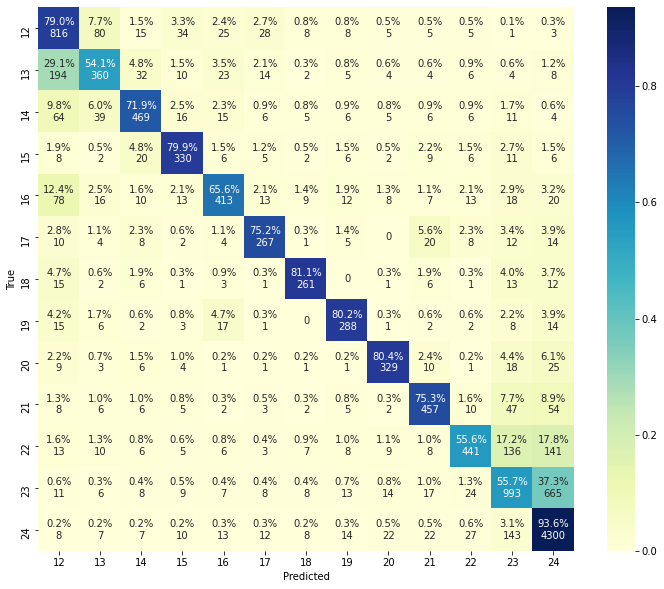

[I 2021-01-15 16:08:20,316] Trial 54 finished with value: -0.7705608164731775 and parameters: {'booster': 'gbtree', 'lambda': 1.0965976609783524e-05, 'alpha': 1.4558103762621205e-07, 'min_child_weight': 4, 'learning_rate': 0.0527924504859695, 'eval_metric': 'merror', 'colsample_bytree': 0.96, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.96, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 0.007614849118059796, 'gamma': 4.224582658227044e-07, 'grow_policy': 'depthwise'}. Best is trial 51 with value: -0.7746276091966533.


FOLD0-val acc: 76.92991115498519 FOLD0-test acc: 75.78279825604439
FOLD1-val acc: 76.94888494178015 FOLD1-test acc: 75.87792310741182
FOLD2-val acc: 76.62324847049537 FOLD2-test acc: 75.31510107015458
FOLD3-val acc: 76.50483520820998 FOLD3-test acc: 76.51208878319461
FOLD4-val acc: 77.84910132332608 FOLD4-test acc: 75.74316290130797
======================================> TTA on test acc: 77.14625445897741, mse: 3.27483154974237
              precision    recall  f1-score   support

           0       0.65      0.79      0.72      1033
           1       0.68      0.55      0.61       666
           2       0.79      0.72      0.75       652
           3       0.74      0.79      0.76       413
           4       0.78      0.66      0.71       630
           5       0.75      0.75      0.75       355
           6       0.82      0.80      0.81       322
           7       0.78      0.80      0.79       359
           8       0.82      0.80      0.81       409
           9       0.79   

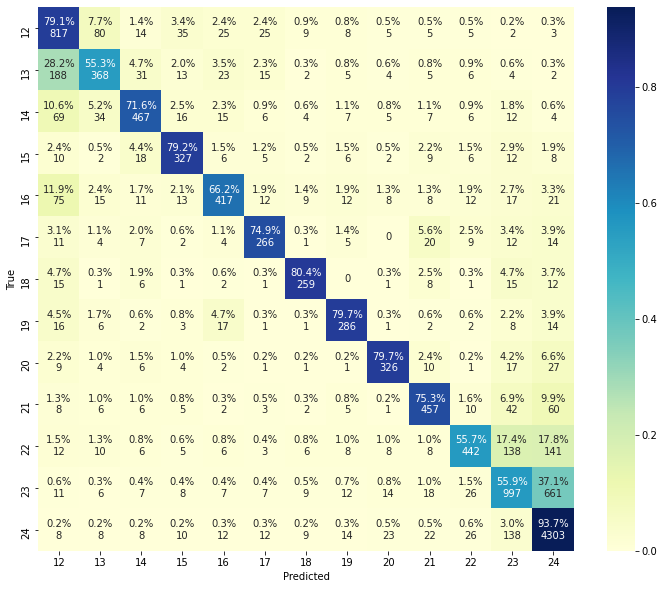

[I 2021-01-15 16:19:43,926] Trial 55 finished with value: -0.7697119621975935 and parameters: {'booster': 'gbtree', 'lambda': 1.0980152462434384e-05, 'alpha': 1.5797808574245387e-07, 'min_child_weight': 4, 'learning_rate': 0.052960622949388476, 'eval_metric': 'merror', 'colsample_bytree': 0.96, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.96, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 0.009575866062733238, 'gamma': 3.751227543645787e-06, 'grow_policy': 'depthwise'}. Best is trial 51 with value: -0.7746276091966533.


FOLD0-val acc: 76.11056268509378 FOLD0-test acc: 75.02972651605232
FOLD1-val acc: 75.71541345964081 FOLD1-test acc: 75.5687673404677
FOLD2-val acc: 76.87981053878035 FOLD2-test acc: 74.75227903289733
FOLD3-val acc: 76.56404183935267 FOLD3-test acc: 75.90170432025367
FOLD4-val acc: 77.23681611692672 FOLD4-test acc: 75.62425683709868
======================================> TTA on test acc: 76.74197384066588, mse: 3.578913991280222
              precision    recall  f1-score   support

           0       0.66      0.80      0.73      1033
           1       0.66      0.56      0.60       666
           2       0.79      0.71      0.75       652
           3       0.74      0.79      0.77       413
           4       0.76      0.65      0.70       630
           5       0.72      0.75      0.73       355
           6       0.83      0.81      0.82       322
           7       0.78      0.79      0.79       359
           8       0.81      0.80      0.81       409
           9       0.84   

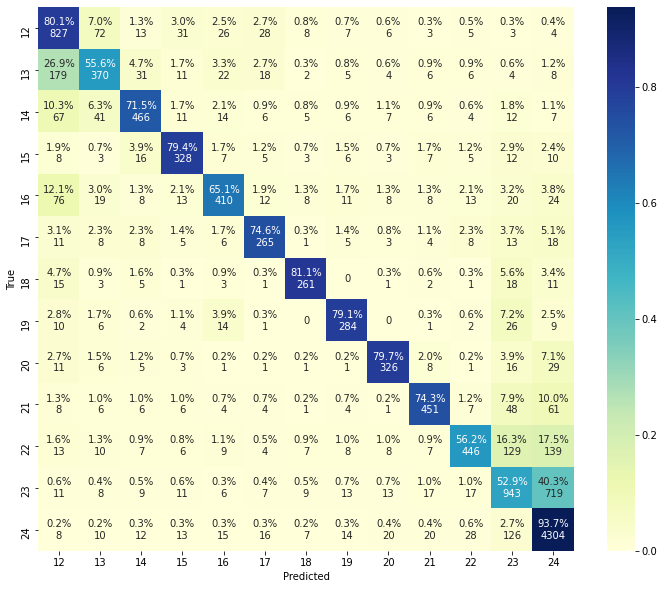

[I 2021-01-15 16:30:40,502] Trial 56 finished with value: -0.7650132892795887 and parameters: {'booster': 'gbtree', 'lambda': 2.227098862186492e-05, 'alpha': 1.1850809763283082e-07, 'min_child_weight': 5, 'learning_rate': 0.029423769980294497, 'eval_metric': 'merror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.96, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'max_depth': 9, 'eta': 0.06855853882234154, 'gamma': 8.173308909750804e-05, 'grow_policy': 'depthwise'}. Best is trial 51 with value: -0.7746276091966533.


In [ ]:
#optimization_function = partial(optimize, X=x, y=y)
study  = optuna.create_study(direction = "minimize")
study.optimize(optimize, n_trials=200 )
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
#optimization_function = partial(optimize, X=x, y=y)
study  = optuna.create_study(direction = "minimize")
study.optimize(optimize, n_trials=200 )
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-01-09 23:08:33,114] A new study created in memory with name: no-name-a166a14d-3ca1-4558-a8be-64a1ad736e98


FOLD0-val acc: 38.55957320687612 FOLD0-test acc: 39.61100569259962
FOLD1-val acc: 40.45643153526971 FOLD1-test acc: 39.35009487666034
FOLD2-val acc: 40.27256567252617 FOLD2-test acc: 39.52403542061986
FOLD3-val acc: 39.03811969188229 FOLD3-test acc: 39.39753320683112


[I 2021-01-09 23:09:13,650] Trial 0 finished with value: -0.3925937494499533 and parameters: {'booster': 'gblinear', 'lambda': 0.17286114243219936, 'alpha': 1.1251466960018656e-08, 'min_child_weight': 0, 'learning_rate': 0.11375286610306179, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.42000000000000004, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.31, 'subsample': 0.8}. Best is trial 0 with value: -0.3925937494499533.


FOLD4-val acc: 37.97018461842235 FOLD4-test acc: 39.223592662871596
======================================> TTA on test acc: 39.579380139152434, mse: 23.95098039215686
FOLD0-val acc: 40.841730883224656 FOLD0-test acc: 38.59898798228969
FOLD1-val acc: 38.02608180201541 FOLD1-test acc: 38.70967741935484
FOLD2-val acc: 40.38119691882283 FOLD2-test acc: 38.93896268184693
FOLD3-val acc: 38.37645664625716 FOLD3-test acc: 38.614800759013285


[I 2021-01-09 23:09:31,418] Trial 1 finished with value: -0.3953180664724044 and parameters: {'booster': 'gbtree', 'lambda': 7.233645024210127e-07, 'alpha': 0.007379847983651439, 'min_child_weight': 1, 'learning_rate': 0.017061280472005176, 'eval_metric': 'merror', 'colsample_bytree': 0.43000000000000005, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.2, 'subsample': 0.65, 'max_depth': 2, 'eta': 0.0015101130193906226, 'gamma': 0.0857654294520979, 'grow_policy': 'depthwise'}. Best is trial 1 with value: -0.3953180664724044.


FOLD4-val acc: 40.03356698588212 FOLD4-test acc: 39.35800126502214
======================================> TTA on test acc: 38.7887413029728, mse: 25.969086021505376
FOLD0-val acc: 69.77869986168741 FOLD0-test acc: 65.74952561669829
FOLD1-val acc: 67.7731673582296 FOLD1-test acc: 65.61511701454775
FOLD2-val acc: 67.5883863322141 FOLD2-test acc: 66.48481973434535
FOLD3-val acc: 70.38317203239185 FOLD3-test acc: 66.808981657179


[I 2021-01-09 23:10:50,795] Trial 2 finished with value: -0.6885332762850496 and parameters: {'booster': 'gbtree', 'lambda': 0.5957203335768055, 'alpha': 5.230600218862722e-06, 'min_child_weight': 5, 'learning_rate': 0.009793227409964711, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.8, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95, 'subsample': 0.8500000000000001, 'max_depth': 5, 'eta': 0.02554191246342826, 'gamma': 0.018042175383108053, 'grow_policy': 'depthwise'}. Best is trial 2 with value: -0.6885332762850496.


FOLD4-val acc: 68.74321255800177 FOLD4-test acc: 66.1843769765971
======================================> TTA on test acc: 66.95920303605313, mse: 10.882273877292853
FOLD0-val acc: 76.6646907725746 FOLD0-test acc: 73.4819734345351
FOLD1-val acc: 75.26180596720016 FOLD1-test acc: 73.08665401644528
FOLD2-val acc: 73.77049180327869 FOLD2-test acc: 72.65970904490828
FOLD3-val acc: 75.15307130159984 FOLD3-test acc: 72.68342820999368


[I 2021-01-09 23:12:35,606] Trial 3 finished with value: -0.7498884897159627 and parameters: {'booster': 'gbtree', 'lambda': 3.2580357291096873e-06, 'alpha': 5.5201844528643065e-06, 'min_child_weight': 5, 'learning_rate': 0.06767816980356159, 'eval_metric': 'merror', 'colsample_bytree': 0.79, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.49, 'subsample': 0.75, 'max_depth': 9, 'eta': 0.0024050005230298378, 'gamma': 0.002010719843610528, 'grow_policy': 'lossguide'}. Best is trial 3 with value: -0.7498884897159627.


FOLD4-val acc: 74.09418501332807 FOLD4-test acc: 72.69924098671727
======================================> TTA on test acc: 73.9247311827957, mse: 5.64207779886148
FOLD0-val acc: 63.85101758545741 FOLD0-test acc: 58.894686907020876
FOLD1-val acc: 60.76862280181782 FOLD1-test acc: 58.483554712207464
FOLD2-val acc: 63.529527947857 FOLD2-test acc: 60.697343453510435
FOLD3-val acc: 63.75666600829548 FOLD3-test acc: 60.01739405439596


[I 2021-01-09 23:13:24,847] Trial 4 finished with value: -0.6290165260271655 and parameters: {'booster': 'gbtree', 'lambda': 8.099844052018264e-05, 'alpha': 6.249078050041556e-07, 'min_child_weight': 1, 'learning_rate': 0.033328672465176984, 'eval_metric': 'merror', 'colsample_bytree': 0.28, 'colsample_bynode': 0.51, 'colsample_bylevel': 1.0, 'subsample': 0.65, 'max_depth': 7, 'eta': 0.0004898652614874359, 'gamma': 0.00025415245284985224, 'grow_policy': 'depthwise'}. Best is trial 3 with value: -0.7498884897159627.


FOLD4-val acc: 62.602428670155 FOLD4-test acc: 59.65370018975332
======================================> TTA on test acc: 60.53130929791271, mse: 12.143105629348513
FOLD0-val acc: 41.09859711519462 FOLD0-test acc: 39.223592662871596
FOLD1-val acc: 38.915234143449915 FOLD1-test acc: 39.69797596457938
FOLD2-val acc: 40.321943511751925 FOLD2-test acc: 39.47659709044908
FOLD3-val acc: 39.26525775232076 FOLD3-test acc: 39.38172043010753


[I 2021-01-09 23:14:05,332] Trial 5 finished with value: -0.39958512359020687 and parameters: {'booster': 'gblinear', 'lambda': 0.00036458924695800316, 'alpha': 5.4126103717961776e-08, 'min_child_weight': 4, 'learning_rate': 0.24695645624564785, 'eval_metric': 'merror', 'colsample_bytree': 0.22, 'colsample_bynode': 0.48, 'colsample_bylevel': 0.85, 'subsample': 0.75}. Best is trial 3 with value: -0.7498884897159627.


FOLD4-val acc: 40.19152927238622 FOLD4-test acc: 39.84029095509171
======================================> TTA on test acc: 39.516129032258064, mse: 22.787792536369388
FOLD0-val acc: 41.03932029243232 FOLD0-test acc: 39.21568627450981
FOLD1-val acc: 38.90535467298953 FOLD1-test acc: 39.52403542061986
FOLD2-val acc: 40.27256567252617 FOLD2-test acc: 39.33428209993675
FOLD3-val acc: 39.285008888011056 FOLD3-test acc: 39.239405439595195


[I 2021-01-09 23:14:45,675] Trial 6 finished with value: -0.3996837368838858 and parameters: {'booster': 'gblinear', 'lambda': 0.0038489977241785325, 'alpha': 5.714834722922813e-06, 'min_child_weight': 4, 'learning_rate': 0.349101335958218, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.87, 'colsample_bynode': 0.13, 'colsample_bylevel': 0.47, 'subsample': 0.75}. Best is trial 3 with value: -0.7498884897159627.


FOLD4-val acc: 40.33961891598381 FOLD4-test acc: 39.642631246046804
======================================> TTA on test acc: 39.37381404174573, mse: 23.01367805186591
FOLD0-val acc: 41.06895870381347 FOLD0-test acc: 39.02593295382669
FOLD1-val acc: 37.78897451096621 FOLD1-test acc: 39.223592662871596
FOLD2-val acc: 39.29488445585621 FOLD2-test acc: 38.970588235294116
FOLD3-val acc: 38.7517282243729 FOLD3-test acc: 39.27893738140417


[I 2021-01-09 23:15:20,036] Trial 7 finished with value: -0.39306666904344834 and parameters: {'booster': 'gblinear', 'lambda': 0.0004272017584165326, 'alpha': 0.009371159262835544, 'min_child_weight': 0, 'learning_rate': 0.13056317202028983, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.30000000000000004, 'colsample_bylevel': 0.99, 'subsample': 0.75}. Best is trial 3 with value: -0.7498884897159627.


FOLD4-val acc: 39.62878862671537 FOLD4-test acc: 39.247311827956985
======================================> TTA on test acc: 39.08918406072106, mse: 26.311827956989248
FOLD0-val acc: 51.88697885793322 FOLD0-test acc: 48.45825426944971
FOLD1-val acc: 49.21952183362972 FOLD1-test acc: 47.27229601518027
FOLD2-val acc: 52.42938968990717 FOLD2-test acc: 48.41872232764074
FOLD3-val acc: 50.464151688722104 FOLD3-test acc: 48.134092346616065


[I 2021-01-09 23:15:43,567] Trial 8 finished with value: -0.509925249507153 and parameters: {'booster': 'gbtree', 'lambda': 4.916368765508064e-06, 'alpha': 0.0007655568166733078, 'min_child_weight': 3, 'learning_rate': 0.029427990938886553, 'eval_metric': 'merror', 'colsample_bytree': 0.98, 'colsample_bynode': 0.56, 'colsample_bylevel': 0.16, 'subsample': 1.0, 'max_depth': 4, 'eta': 0.0009054887898438908, 'gamma': 0.030583413288632944, 'grow_policy': 'depthwise'}. Best is trial 3 with value: -0.7498884897159627.


FOLD4-val acc: 50.96258268338434 FOLD4-test acc: 48.236875395319416
======================================> TTA on test acc: 48.28431372549019, mse: 17.461654016445287
FOLD0-val acc: 38.08535862477771 FOLD0-test acc: 37.7134724857685
FOLD1-val acc: 38.11499703615886 FOLD1-test acc: 38.353889943074
FOLD2-val acc: 36.76673908749753 FOLD2-test acc: 37.93485135989879
FOLD3-val acc: 35.097768121666995 FOLD3-test acc: 37.89531941808982


[I 2021-01-09 23:16:23,447] Trial 9 finished with value: -0.3712210476870873 and parameters: {'booster': 'gblinear', 'lambda': 8.79498450665933e-08, 'alpha': 2.5552277188010506e-05, 'min_child_weight': 1, 'learning_rate': 0.006555951182643937, 'eval_metric': 'merror', 'colsample_bytree': 0.69, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.65, 'subsample': 0.6}. Best is trial 3 with value: -0.7498884897159627.


FOLD4-val acc: 37.545660973442594 FOLD4-test acc: 37.91903858317521
======================================> TTA on test acc: 37.903225806451616, mse: 21.45762175838077
FOLD0-val acc: 75.02469867615096 FOLD0-test acc: 71.48956356736242
FOLD1-val acc: 72.57459000197589 FOLD1-test acc: 71.28399746995572
FOLD2-val acc: 72.91131740075055 FOLD2-test acc: 72.16160657811511
FOLD3-val acc: 74.313648034762 FOLD3-test acc: 72.01138519924099


[I 2021-01-09 23:18:02,480] Trial 10 finished with value: -0.7359215855300727 and parameters: {'booster': 'gbtree', 'lambda': 3.5449331515596934e-08, 'alpha': 0.6773815280298394, 'min_child_weight': 5, 'learning_rate': 0.06633346319534479, 'eval_metric': 'merror', 'colsample_bytree': 0.63, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.67, 'subsample': 0.5, 'max_depth': 10, 'eta': 4.258812864618503e-08, 'gamma': 1.2162270241053665e-08, 'grow_policy': 'lossguide'}. Best is trial 3 with value: -0.7498884897159627.


FOLD4-val acc: 73.13653865139698 FOLD4-test acc: 71.9639468690702
======================================> TTA on test acc: 72.80993042378242, mse: 6.135594560404807
FOLD0-val acc: 74.77771191464137 FOLD0-test acc: 71.90860215053763
FOLD1-val acc: 73.41434499110846 FOLD1-test acc: 71.3393421884883
FOLD2-val acc: 73.77049180327869 FOLD2-test acc: 72.2248576850095
FOLD3-val acc: 75.02468891961288 FOLD3-test acc: 72.2169512966477


[I 2021-01-09 23:19:41,694] Trial 11 finished with value: -0.7397539204147516 and parameters: {'booster': 'gbtree', 'lambda': 1.4716265006468221e-08, 'alpha': 0.6690704440993086, 'min_child_weight': 5, 'learning_rate': 0.07595336976704996, 'eval_metric': 'merror', 'colsample_bytree': 0.63, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.6799999999999999, 'subsample': 0.5, 'max_depth': 10, 'eta': 1.1919876055542047e-08, 'gamma': 2.3349332565718406e-08, 'grow_policy': 'lossguide'}. Best is trial 3 with value: -0.7498884897159627.


FOLD4-val acc: 72.88972257873432 FOLD4-test acc: 71.48165717900063
======================================> TTA on test acc: 73.13409234661606, mse: 5.704301075268817
FOLD0-val acc: 74.09602845287493 FOLD0-test acc: 71.01518026565465
FOLD1-val acc: 71.4977277217941 FOLD1-test acc: 69.99525616698293
FOLD2-val acc: 72.71380604384751 FOLD2-test acc: 71.37096774193549
FOLD3-val acc: 73.67173612482718 FOLD3-test acc: 71.46584440227703


[I 2021-01-09 23:20:57,259] Trial 12 finished with value: -0.7278819849777329 and parameters: {'booster': 'gbtree', 'lambda': 1.2296451762309181e-08, 'alpha': 0.3250061524207597, 'min_child_weight': 5, 'learning_rate': 0.08414438438320877, 'eval_metric': 'merror', 'colsample_bytree': 0.5700000000000001, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.45999999999999996, 'subsample': 0.9, 'max_depth': 10, 'eta': 4.09828249696426e-07, 'gamma': 1.604926288824216e-08, 'grow_policy': 'lossguide'}. Best is trial 3 with value: -0.7498884897159627.


FOLD4-val acc: 71.96169414552276 FOLD4-test acc: 71.35515496521188
======================================> TTA on test acc: 72.46204933586338, mse: 5.80083807716635
FOLD0-val acc: 77.27721794111837 FOLD0-test acc: 73.37128399746996
FOLD1-val acc: 75.86445366528353 FOLD1-test acc: 73.24478178368122
FOLD2-val acc: 75.3209559549674 FOLD2-test acc: 73.0629348513599
FOLD3-val acc: 76.56527750345646 FOLD3-test acc: 73.17362428842505


[I 2021-01-09 23:23:07,786] Trial 13 finished with value: -0.7589155198739501 and parameters: {'booster': 'gbtree', 'lambda': 2.5884468092786094e-06, 'alpha': 0.0002152697001455534, 'min_child_weight': 4, 'learning_rate': 0.18708043557653561, 'eval_metric': 'merror', 'colsample_bytree': 0.75, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.73, 'subsample': 0.5, 'max_depth': 8, 'eta': 0.7482431000978229, 'gamma': 5.224759178609185e-06, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.7589155198739501.


FOLD4-val acc: 74.42985487214926 FOLD4-test acc: 72.80993042378242
======================================> TTA on test acc: 74.30423782416192, mse: 4.896505376344086
FOLD0-val acc: 77.47480735032603 FOLD0-test acc: 74.00379506641366
FOLD1-val acc: 76.2398735427781 FOLD1-test acc: 74.02751423149905
FOLD2-val acc: 76.05174797550859 FOLD2-test acc: 73.56894370651487
FOLD3-val acc: 76.75291329251432 FOLD3-test acc: 74.01960784313727


[I 2021-01-09 23:25:34,870] Trial 14 finished with value: -0.7621748280679348 and parameters: {'booster': 'gbtree', 'lambda': 5.7466210292778015e-06, 'alpha': 0.0005237369631492229, 'min_child_weight': 3, 'learning_rate': 0.21871937628103533, 'eval_metric': 'merror', 'colsample_bytree': 0.76, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.6, 'max_depth': 8, 'eta': 0.8958137073833222, 'gamma': 4.8575092646502666e-06, 'grow_policy': 'lossguide'}. Best is trial 14 with value: -0.7621748280679348.


FOLD4-val acc: 74.56807187284036 FOLD4-test acc: 73.15781151170145
======================================> TTA on test acc: 74.75490196078431, mse: 4.407416192283365
FOLD0-val acc: 77.18830270697491 FOLD0-test acc: 73.65591397849462
FOLD1-val acc: 75.4198774945663 FOLD1-test acc: 73.53731815306767
FOLD2-val acc: 75.04444005530318 FOLD2-test acc: 73.44244149272612
FOLD3-val acc: 76.1505036539601 FOLD3-test acc: 73.2685009487666


[I 2021-01-09 23:28:10,160] Trial 15 finished with value: -0.75733475014168 and parameters: {'booster': 'gbtree', 'lambda': 1.9184454349863794e-05, 'alpha': 0.0005409381640415702, 'min_child_weight': 3, 'learning_rate': 0.18735983456885616, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.8099999999999999, 'subsample': 0.55, 'max_depth': 7, 'eta': 0.7999291460267483, 'gamma': 1.3141926823973912e-06, 'grow_policy': 'lossguide'}. Best is trial 14 with value: -0.7621748280679348.


FOLD4-val acc: 74.86425116003555 FOLD4-test acc: 73.22106261859582
======================================> TTA on test acc: 74.36748893105629, mse: 5.065385831752056
FOLD0-val acc: 78.0774550484094 FOLD0-test acc: 73.05502846299811
FOLD1-val acc: 75.7063821379174 FOLD1-test acc: 72.6518026565465
FOLD2-val acc: 75.90361445783132 FOLD2-test acc: 72.96805819101834
FOLD3-val acc: 76.98992692079794 FOLD3-test acc: 72.82574320050601


[I 2021-01-09 23:30:28,451] Trial 16 finished with value: -0.7614838912991293 and parameters: {'booster': 'gbtree', 'lambda': 3.92286987016271e-07, 'alpha': 0.022710115748193514, 'min_child_weight': 2, 'learning_rate': 0.40545451324756576, 'eval_metric': 'merror', 'colsample_bytree': 0.72, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.8, 'subsample': 0.6, 'max_depth': 8, 'eta': 0.6918254869189226, 'gamma': 3.253988323912562e-06, 'grow_policy': 'lossguide'}. Best is trial 14 with value: -0.7621748280679348.


FOLD4-val acc: 74.06456708460854 FOLD4-test acc: 72.55692599620494
======================================> TTA on test acc: 74.72327640733712, mse: 4.0453826691967105
FOLD0-val acc: 74.62951985773563 FOLD0-test acc: 71.09424414927261
FOLD1-val acc: 73.36494763880656 FOLD1-test acc: 70.54079696394687
FOLD2-val acc: 74.40252814536836 FOLD2-test acc: 71.55281467425681
FOLD3-val acc: 75.55796958325104 FOLD3-test acc: 71.52118912080961


[I 2021-01-09 23:31:39,475] Trial 17 finished with value: -0.743525687188402 and parameters: {'booster': 'gbtree', 'lambda': 1.3542642423790415e-07, 'alpha': 0.028643555628333345, 'min_child_weight': 2, 'learning_rate': 0.4798317770503416, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.47, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.86, 'subsample': 0.65, 'max_depth': 7, 'eta': 0.10940320791768032, 'gamma': 3.6428317884073527e-06, 'grow_policy': 'lossguide'}. Best is trial 14 with value: -0.7621748280679348.


FOLD4-val acc: 73.80787836903939 FOLD4-test acc: 71.52118912080961
======================================> TTA on test acc: 74.16982922201139, mse: 4.705170777988615
FOLD0-val acc: 76.20035566093657 FOLD0-test acc: 71.26027830487034
FOLD1-val acc: 74.9357834420075 FOLD1-test acc: 70.86495888678051
FOLD2-val acc: 73.57298044637567 FOLD2-test acc: 70.89658444022771
FOLD3-val acc: 74.19514122062019 FOLD3-test acc: 71.29190385831751


[I 2021-01-09 23:32:44,362] Trial 18 finished with value: -0.7451280989907635 and parameters: {'booster': 'gbtree', 'lambda': 4.451756216805431e-07, 'alpha': 0.04111248242479422, 'min_child_weight': 2, 'learning_rate': 0.44568768643748125, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.38, 'colsample_bylevel': 0.5700000000000001, 'subsample': 0.6, 'max_depth': 8, 'eta': 2.3372012851459997e-05, 'gamma': 3.215604336396038e-07, 'grow_policy': 'lossguide'}. Best is trial 14 with value: -0.7621748280679348.


FOLD4-val acc: 73.6597887254418 FOLD4-test acc: 71.20493358633776
======================================> TTA on test acc: 74.01170145477546, mse: 4.632827324478178
FOLD0-val acc: 74.27385892116183 FOLD0-test acc: 71.02308665401644
FOLD1-val acc: 72.45603635645129 FOLD1-test acc: 70.88077166350412
FOLD2-val acc: 72.43729014418328 FOLD2-test acc: 70.57242251739405
FOLD3-val acc: 73.37546908947265 FOLD3-test acc: 70.77798861480076


[I 2021-01-09 23:33:47,315] Trial 19 finished with value: -0.7314373674685841 and parameters: {'booster': 'gbtree', 'lambda': 0.008645663184799375, 'alpha': 0.002182744185700102, 'min_child_weight': 2, 'learning_rate': 0.3213460043925508, 'eval_metric': 'merror', 'colsample_bytree': 0.52, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.8, 'subsample': 0.6, 'max_depth': 5, 'eta': 0.04401777156208097, 'gamma': 3.50238556018327e-05, 'grow_policy': 'lossguide'}. Best is trial 14 with value: -0.7621748280679348.


FOLD4-val acc: 73.176029223023 FOLD4-test acc: 71.22865275142316
======================================> TTA on test acc: 72.4067046173308, mse: 6.4418880455407965
FOLD0-val acc: 77.20806164789568 FOLD0-test acc: 72.38298545224542
FOLD1-val acc: 76.10156095633273 FOLD1-test acc: 71.95604048070841
FOLD2-val acc: 76.31838830732767 FOLD2-test acc: 72.36717267552181
FOLD3-val acc: 77.13806043847521 FOLD3-test acc: 72.58855154965211


[I 2021-01-09 23:36:18,356] Trial 20 finished with value: -0.7628657393038734 and parameters: {'booster': 'gbtree', 'lambda': 2.3269798666950805e-05, 'alpha': 0.09167058876113603, 'min_child_weight': 3, 'learning_rate': 0.4939276566659256, 'eval_metric': 'merror', 'colsample_bytree': 0.7, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.94, 'subsample': 0.55, 'max_depth': 8, 'eta': 2.3142815436739904e-05, 'gamma': 0.0002183218775787364, 'grow_policy': 'lossguide'}. Best is trial 20 with value: -0.7628657393038734.


FOLD4-val acc: 74.66679830190543 FOLD4-test acc: 72.06672991777356
======================================> TTA on test acc: 74.66002530044275, mse: 4.006562302340291
FOLD0-val acc: 77.03023117960878 FOLD0-test acc: 72.28810879190387
FOLD1-val acc: 75.85457419482316 FOLD1-test acc: 72.28810879190387
FOLD2-val acc: 76.01224570412799 FOLD2-test acc: 72.53320683111954
FOLD3-val acc: 77.11830930278492 FOLD3-test acc: 72.57273877292853


[I 2021-01-09 23:38:48,372] Trial 21 finished with value: -0.7603375625042238 and parameters: {'booster': 'gbtree', 'lambda': 2.7361375464300416e-05, 'alpha': 0.03966273731227535, 'min_child_weight': 3, 'learning_rate': 0.479394988786652, 'eval_metric': 'merror', 'colsample_bytree': 0.74, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.92, 'subsample': 0.55, 'max_depth': 8, 'eta': 1.4236092510736156e-05, 'gamma': 5.582330358277485e-05, 'grow_policy': 'lossguide'}. Best is trial 20 with value: -0.7628657393038734.


FOLD4-val acc: 74.1534208707671 FOLD4-test acc: 72.14579380139152
======================================> TTA on test acc: 74.53352308665401, mse: 4.048228969006957
FOLD0-val acc: 76.05216360403082 FOLD0-test acc: 72.73086654016446
FOLD1-val acc: 74.43193044852796 FOLD1-test acc: 72.60436432637572
FOLD2-val acc: 74.36302587398775 FOLD2-test acc: 72.2248576850095
FOLD3-val acc: 75.05431562314833 FOLD3-test acc: 72.25648323845667


[I 2021-01-09 23:40:08,046] Trial 22 finished with value: -0.7471027032644603 and parameters: {'booster': 'gbtree', 'lambda': 5.244065454129716e-07, 'alpha': 0.08493011237574415, 'min_child_weight': 3, 'learning_rate': 0.2845617248602028, 'eval_metric': 'merror', 'colsample_bytree': 0.66, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.74, 'subsample': 0.55, 'max_depth': 6, 'eta': 9.84299873018157e-07, 'gamma': 2.2766388580449437e-07, 'grow_policy': 'lossguide'}. Best is trial 20 with value: -0.7628657393038734.


FOLD4-val acc: 73.6499160825353 FOLD4-test acc: 72.0034788108792
======================================> TTA on test acc: 73.75079063883618, mse: 5.46663504111322
FOLD0-val acc: 78.00829875518673 FOLD0-test acc: 74.05123339658444
FOLD1-val acc: 76.81288282948034 FOLD1-test acc: 73.71125869702719
FOLD2-val acc: 76.39739285008889 FOLD2-test acc: 74.09076533839342
FOLD3-val acc: 77.81947461979064 FOLD3-test acc: 74.28051865907653


[I 2021-01-09 23:43:40,108] Trial 23 finished with value: -0.7696409120097745 and parameters: {'booster': 'gbtree', 'lambda': 4.404970561131664e-05, 'alpha': 0.003253129561205373, 'min_child_weight': 2, 'learning_rate': 0.18165978997662963, 'eval_metric': 'merror', 'colsample_bytree': 0.94, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.92, 'subsample': 0.7, 'max_depth': 9, 'eta': 6.98478598998636e-05, 'gamma': 0.0006021620801832238, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.78240695034062 FOLD4-test acc: 74.16982922201139
======================================> TTA on test acc: 74.96837444655282, mse: 4.199636306135357
FOLD0-val acc: 78.03793716656787 FOLD0-test acc: 74.12239089184061
FOLD1-val acc: 76.31890930646117 FOLD1-test acc: 74.23308032890576
FOLD2-val acc: 76.43689512146949 FOLD2-test acc: 74.16192283364958
FOLD3-val acc: 77.64171439857792 FOLD3-test acc: 74.21726755218216


[I 2021-01-09 23:46:16,669] Trial 24 finished with value: -0.768356744743582 and parameters: {'booster': 'gbtree', 'lambda': 0.0007538711734624871, 'alpha': 5.2667399828587884e-05, 'min_child_weight': 4, 'learning_rate': 0.1764008534591612, 'eval_metric': 'merror', 'colsample_bytree': 0.95, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.9, 'subsample': 0.7, 'max_depth': 9, 'eta': 8.284913760475584e-05, 'gamma': 0.0014086491672429505, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.74291637871458 FOLD4-test acc: 73.9326375711575
======================================> TTA on test acc: 74.75490196078431, mse: 4.43010752688172
FOLD0-val acc: 77.70203517091484 FOLD0-test acc: 74.3595825426945
FOLD1-val acc: 76.24975301323849 FOLD1-test acc: 74.05123339658444
FOLD2-val acc: 75.71597866877346 FOLD2-test acc: 73.62428842504744
FOLD3-val acc: 76.94054908157219 FOLD3-test acc: 74.05123339658444


[I 2021-01-09 23:48:49,576] Trial 25 finished with value: -0.7641298513378497 and parameters: {'booster': 'gbtree', 'lambda': 0.005182093827360914, 'alpha': 3.978633437300448e-05, 'min_child_weight': 4, 'learning_rate': 0.12403110931179087, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.91, 'subsample': 0.7, 'max_depth': 9, 'eta': 5.86837323284598e-05, 'gamma': 0.003301314492370733, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.45660973442591 FOLD4-test acc: 73.81404174573055
======================================> TTA on test acc: 74.82605945604048, mse: 4.650853889943074
FOLD0-val acc: 77.93914246196404 FOLD0-test acc: 74.18564199873498
FOLD1-val acc: 76.10156095633273 FOLD1-test acc: 73.77450980392157
FOLD2-val acc: 75.42958720126407 FOLD2-test acc: 73.71125869702719
FOLD3-val acc: 77.09855816709461 FOLD3-test acc: 74.1540164452878


[I 2021-01-09 23:51:19,183] Trial 26 finished with value: -0.7635572848968375 and parameters: {'booster': 'gbtree', 'lambda': 0.008018123636572857, 'alpha': 7.702083542437614e-05, 'min_child_weight': 4, 'learning_rate': 0.13363030342490992, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.9, 'subsample': 0.7, 'max_depth': 9, 'eta': 0.00010516714812931119, 'gamma': 0.002449734428410654, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.20979366176326 FOLD4-test acc: 73.96426312460468
======================================> TTA on test acc: 74.92884250474383, mse: 4.584835547122075
FOLD0-val acc: 77.63287887769216 FOLD0-test acc: 74.1540164452878
FOLD1-val acc: 76.1805967200158 FOLD1-test acc: 73.45825426944972
FOLD2-val acc: 75.51846731187042 FOLD2-test acc: 73.67172675521822
FOLD3-val acc: 76.25913490025677 FOLD3-test acc: 73.59266287160025


[I 2021-01-09 23:54:07,179] Trial 27 finished with value: -0.762036139231083 and parameters: {'booster': 'gbtree', 'lambda': 0.0012318852505808996, 'alpha': 6.281313240359901e-05, 'min_child_weight': 4, 'learning_rate': 0.04132790367476861, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.94, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.99, 'subsample': 0.7, 'max_depth': 9, 'eta': 2.1263537313159307e-06, 'gamma': 0.001846509305419729, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.4269918057064 FOLD4-test acc: 73.65591397849462
======================================> TTA on test acc: 74.55724225173941, mse: 5.081435800126502
FOLD0-val acc: 77.28709741157874 FOLD0-test acc: 73.76660341555977
FOLD1-val acc: 75.93360995850622 FOLD1-test acc: 73.54522454142948
FOLD2-val acc: 74.97531108038712 FOLD2-test acc: 73.2764073371284
FOLD3-val acc: 76.81216669958523 FOLD3-test acc: 73.37919038583175


[I 2021-01-09 23:55:55,818] Trial 28 finished with value: -0.7590735329025432 and parameters: {'booster': 'gbtree', 'lambda': 0.022365292318226093, 'alpha': 1.8736149499904096e-05, 'min_child_weight': 4, 'learning_rate': 0.1565782517592683, 'eval_metric': 'merror', 'colsample_bytree': 0.92, 'colsample_bynode': 0.38, 'colsample_bylevel': 0.88, 'subsample': 0.7, 'max_depth': 10, 'eta': 0.00013457424743070393, 'gamma': 0.5944681912212801, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 74.52858130121433 FOLD4-test acc: 73.18943706514864
======================================> TTA on test acc: 74.52561669829223, mse: 4.83151486401012
FOLD0-val acc: 40.18968583283936 FOLD0-test acc: 39.19196710942441
FOLD1-val acc: 38.342224856747684 FOLD1-test acc: 39.62681846932321
FOLD2-val acc: 39.87754295872013 FOLD2-test acc: 39.516129032258064
FOLD3-val acc: 38.860359470669565 FOLD3-test acc: 39.27893738140417


[I 2021-01-09 23:56:35,681] Trial 29 finished with value: -0.39496217535435196 and parameters: {'booster': 'gblinear', 'lambda': 0.03555222243910224, 'alpha': 4.1379800554415125e-07, 'min_child_weight': 0, 'learning_rate': 0.0987888626470763, 'eval_metric': 'mlogloss', 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.33, 'subsample': 0.8}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 40.21127455819923 FOLD4-test acc: 39.66635041113219
======================================> TTA on test acc: 39.29475015812777, mse: 23.210942441492726
FOLD0-val acc: 68.99822169531713 FOLD0-test acc: 65.2830487033523
FOLD1-val acc: 65.86642955937562 FOLD1-test acc: 64.49240986717267
FOLD2-val acc: 66.62058068338929 FOLD2-test acc: 64.86401012017711
FOLD3-val acc: 66.72921192968596 FOLD3-test acc: 64.33428209993674
FOLD4-val acc: 66.24543390265573 

[I 2021-01-09 23:57:24,190] Trial 30 finished with value: -0.6689197555408476 and parameters: {'booster': 'gbtree', 'lambda': 0.27140039504348606, 'alpha': 0.0025729567061574454, 'min_child_weight': 2, 'learning_rate': 0.05471669711875905, 'eval_metric': 'merror', 'colsample_bytree': 0.83, 'colsample_bynode': 0.15000000000000002, 'colsample_bylevel': 0.74, 'subsample': 0.8, 'max_depth': 9, 'eta': 7.533688461634345e-06, 'gamma': 0.005823811485725594, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-test acc: 64.76122707147375
======================================> TTA on test acc: 66.05787476280834, mse: 9.318074003795067
FOLD0-val acc: 78.2651649871567 FOLD0-test acc: 74.38330170777988
FOLD1-val acc: 76.42758348152539 FOLD1-test acc: 74.32795698924731
FOLD2-val acc: 75.91349002567648 FOLD2-test acc: 73.65591397849462
FOLD3-val acc: 77.13806043847521 FOLD3-test acc: 74.05123339658444


[I 2021-01-09 23:59:54,669] Trial 31 finished with value: -0.7664215626203323 and parameters: {'booster': 'gbtree', 'lambda': 0.05888377946766833, 'alpha': 0.00011923086880953707, 'min_child_weight': 4, 'learning_rate': 0.12367173951185606, 'eval_metric': 'merror', 'colsample_bytree': 0.94, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.9, 'subsample': 0.7, 'max_depth': 9, 'eta': 0.00010809121311672985, 'gamma': 0.0013868173441602392, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.46648237733241 FOLD4-test acc: 73.97216951296647
======================================> TTA on test acc: 74.7944339025933, mse: 4.599225173940544
FOLD0-val acc: 77.64275834815254 FOLD0-test acc: 74.45445920303605
FOLD1-val acc: 76.2398735427781 FOLD1-test acc: 74.01960784313727
FOLD2-val acc: 76.20975706103101 FOLD2-test acc: 74.21726755218216
FOLD3-val acc: 76.95042464941734 FOLD3-test acc: 73.88519924098672


[I 2021-01-10 00:02:38,559] Trial 32 finished with value: -0.7647421579560406 and parameters: {'booster': 'gbtree', 'lambda': 0.0898277181691634, 'alpha': 2.178200930883013e-05, 'min_child_weight': 4, 'learning_rate': 0.10986193481339829, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.69, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'max_depth': 9, 'eta': 0.00025640632819531753, 'gamma': 0.0006743402082610166, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.32826537664133 FOLD4-test acc: 73.98007590132826
======================================> TTA on test acc: 74.92884250474383, mse: 4.5547912713472485
FOLD0-val acc: 78.16637028255286 FOLD0-test acc: 74.52561669829223
FOLD1-val acc: 76.20035566093657 FOLD1-test acc: 74.05123339658444
FOLD2-val acc: 75.63697412601225 FOLD2-test acc: 74.27261227071473
FOLD3-val acc: 77.22694054908158 FOLD3-test acc: 74.43074003795066


[I 2021-01-10 00:05:35,478] Trial 33 finished with value: -0.7657496611364655 and parameters: {'booster': 'gbtree', 'lambda': 0.10085611174227166, 'alpha': 0.0002065066618039007, 'min_child_weight': 4, 'learning_rate': 0.11004698385944986, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.62, 'colsample_bylevel': 1.0, 'subsample': 0.65, 'max_depth': 10, 'eta': 0.006212383603688393, 'gamma': 0.0006399566827094044, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.64418994964952 FOLD4-test acc: 74.05123339658444
======================================> TTA on test acc: 74.85768500948767, mse: 4.57337128399747
FOLD0-val acc: 63.77198182177435 FOLD0-test acc: 57.210626185958255
FOLD1-val acc: 61.242837383916225 FOLD1-test acc: 56.91018342820999
FOLD2-val acc: 61.81117914280071 FOLD2-test acc: 56.17488931056294
FOLD3-val acc: 60.95200474027257 FOLD3-test acc: 55.874446552814675
FOLD4-val acc: 60.89446144732945 

[I 2021-01-10 00:06:17,216] Trial 34 finished with value: -0.6173449290721866 and parameters: {'booster': 'gbtree', 'lambda': 0.8758437967126669, 'alpha': 0.00024878612650234416, 'min_child_weight': 5, 'learning_rate': 0.17054538946079886, 'eval_metric': 'merror', 'colsample_bytree': 0.1, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.94, 'subsample': 0.65, 'max_depth': 10, 'eta': 0.006230752646811645, 'gamma': 0.00046196303851663223, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-test acc: 55.99304237824162
======================================> TTA on test acc: 59.11606578115117, mse: 12.964500316255535
FOLD0-val acc: 77.87986563920174 FOLD0-test acc: 74.29633143580013
FOLD1-val acc: 75.7063821379174 FOLD1-test acc: 73.86148007590133
FOLD2-val acc: 75.43946276910923 FOLD2-test acc: 73.52941176470588
FOLD3-val acc: 76.85166897096582 FOLD3-test acc: 73.82985452245414
FOLD4-val acc: 74.92348701747457 FOLD4-test acc: 74.10657811511702


[I 2021-01-10 00:08:44,844] Trial 35 finished with value: -0.7616017330693376 and parameters: {'booster': 'gbtree', 'lambda': 0.12595680381594757, 'alpha': 0.0017897516072800659, 'min_child_weight': 1, 'learning_rate': 0.09062232002838386, 'eval_metric': 'merror', 'colsample_bytree': 0.99, 'colsample_bynode': 0.47, 'colsample_bylevel': 1.0, 'subsample': 0.65, 'max_depth': 10, 'eta': 0.006939094421757692, 'gamma': 8.53579891610597e-05, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


======================================> TTA on test acc: 75.04743833017078, mse: 4.41421568627451
FOLD0-val acc: 67.70401106500692 FOLD0-test acc: 64.09709044908286
FOLD1-val acc: 66.54811302114206 FOLD1-test acc: 64.35009487666035
FOLD2-val acc: 65.72190400948055 FOLD2-test acc: 63.26691967109424
FOLD3-val acc: 68.59569425241952 FOLD3-test acc: 63.970588235294116


[I 2021-01-10 00:09:37,025] Trial 36 finished with value: -0.6712296806522635 and parameters: {'booster': 'gbtree', 'lambda': 0.00037286733768623513, 'alpha': 1.6634403746857786e-06, 'min_child_weight': 3, 'learning_rate': 0.2475993120983915, 'eval_metric': 'merror', 'colsample_bytree': 0.84, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.86, 'subsample': 0.8, 'max_depth': 3, 'eta': 4.647814268946939e-06, 'gamma': 0.42677915431122526, 'grow_policy': 'depthwise'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 67.04511797808273 FOLD4-test acc: 64.86401012017711
======================================> TTA on test acc: 64.70588235294117, mse: 13.731736242884251
FOLD0-val acc: 58.140683659355865 FOLD0-test acc: 54.85452245414295
FOLD1-val acc: 54.60383323453863 FOLD1-test acc: 53.21790006325111
FOLD2-val acc: 54.79952597274343 FOLD2-test acc: 53.34440227703985
FOLD3-val acc: 56.09322536045822 FOLD3-test acc: 53.10721062618596


[I 2021-01-10 00:10:11,482] Trial 37 finished with value: -0.5608296751648252 and parameters: {'booster': 'gbtree', 'lambda': 0.0013719443485217281, 'alpha': 0.00011944923764493387, 'min_child_weight': 5, 'learning_rate': 0.15840019711251968, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.97, 'subsample': 0.8500000000000001, 'max_depth': 2, 'eta': 0.0015803265953492622, 'gamma': 0.013022360885838496, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 56.777569355316416 FOLD4-test acc: 54.103415559772294
======================================> TTA on test acc: 53.976913345983554, mse: 19.773798228969007
FOLD0-val acc: 60.600671803991304 FOLD0-test acc: 55.06799493991144
FOLD1-val acc: 57.64671013633669 FOLD1-test acc: 54.91777356103732
FOLD2-val acc: 60.70511554414379 FOLD2-test acc: 56.82321315623023
FOLD3-val acc: 60.04345249851867 FOLD3-test acc: 56.246046805819105


[I 2021-01-10 00:10:46,736] Trial 38 finished with value: -0.5963648884149887 and parameters: {'booster': 'gbtree', 'lambda': 0.3772400881541754, 'alpha': 0.008377217313068442, 'min_child_weight': 4, 'learning_rate': 0.05326898824508421, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.33, 'colsample_bynode': 0.52, 'colsample_bylevel': 0.58, 'subsample': 0.7, 'max_depth': 6, 'eta': 6.543371030844219e-05, 'gamma': 0.16246638547141765, 'grow_policy': 'depthwise'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 59.1864942245039 FOLD4-test acc: 55.55028462998103
======================================> TTA on test acc: 56.728336495888676, mse: 14.305977229601519
FOLD0-val acc: 39.98221695317131 FOLD0-test acc: 38.89152435167615
FOLD1-val acc: 38.8065599683857 FOLD1-test acc: 39.263124604680584
FOLD2-val acc: 38.7714793600632 FOLD2-test acc: 38.94686907020873
FOLD3-val acc: 37.65554019356113 FOLD3-test acc: 38.7887413029728


[I 2021-01-10 00:11:26,610] Trial 39 finished with value: -0.38935350034497224 and parameters: {'booster': 'gblinear', 'lambda': 9.6116503424489e-05, 'alpha': 1.3338568368719522e-05, 'min_child_weight': 4, 'learning_rate': 0.018635445777315185, 'eval_metric': 'merror', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.41000000000000003, 'colsample_bylevel': 0.32, 'subsample': 0.75}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 39.46095369730477 FOLD4-test acc: 39.13662239089184
======================================> TTA on test acc: 39.073371283997474, mse: 21.424968374446554
FOLD0-val acc: 78.24540604623593 FOLD0-test acc: 74.01170145477546
FOLD1-val acc: 76.56589606797077 FOLD1-test acc: 73.71125869702719
FOLD2-val acc: 76.1110013825795 FOLD2-test acc: 73.65591397849462
FOLD3-val acc: 77.384949634604 FOLD3-test acc: 74.07495256166983


[I 2021-01-10 00:13:41,273] Trial 40 finished with value: -0.7669946030146809 and parameters: {'booster': 'gbtree', 'lambda': 0.043608608325095624, 'alpha': 1.645303983558012e-06, 'min_child_weight': 3, 'learning_rate': 0.2361878564749278, 'eval_metric': 'merror', 'colsample_bytree': 0.97, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.84, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 0.005557273838423913, 'gamma': 2.0726477081525724e-05, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.19004837595024 FOLD4-test acc: 74.24889310562935
======================================> TTA on test acc: 75.01581277672359, mse: 4.2235926628716
FOLD0-val acc: 78.29480339853784 FOLD0-test acc: 74.10657811511702
FOLD1-val acc: 76.5362576565896 FOLD1-test acc: 74.01170145477546
FOLD2-val acc: 76.08137467904405 FOLD2-test acc: 73.96426312460468
FOLD3-val acc: 77.25656725261703 FOLD3-test acc: 74.23308032890576


[I 2021-01-10 00:15:52,409] Trial 41 finished with value: -0.7677646028735671 and parameters: {'booster': 'gbtree', 'lambda': 0.05262920005600619, 'alpha': 1.7002541773015466e-08, 'min_child_weight': 3, 'learning_rate': 0.20886821073644782, 'eval_metric': 'merror', 'colsample_bytree': 0.98, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.84, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 0.006382539466890869, 'gamma': 1.8111921220522683e-05, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.71329844999507 FOLD4-test acc: 73.96426312460468
======================================> TTA on test acc: 75.18975332068311, mse: 4.25814358001265
FOLD0-val acc: 78.16637028255286 FOLD0-test acc: 74.49399114484504
FOLD1-val acc: 76.56589606797077 FOLD1-test acc: 73.99588867805187
FOLD2-val acc: 76.45664625715979 FOLD2-test acc: 74.02751423149905
FOLD3-val acc: 77.40470077029428 FOLD3-test acc: 74.25679949399114


[I 2021-01-10 00:18:20,335] Trial 42 finished with value: -0.7690679652296447 and parameters: {'booster': 'gbtree', 'lambda': 0.03040609403905904, 'alpha': 3.206273831568378e-08, 'min_child_weight': 3, 'learning_rate': 0.23012658612918013, 'eval_metric': 'merror', 'colsample_bytree': 0.96, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.84, 'subsample': 0.9, 'max_depth': 9, 'eta': 0.00046482005663483724, 'gamma': 1.2032844952822709e-05, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.9403692368447 FOLD4-test acc: 73.94054395951929
======================================> TTA on test acc: 75.12650221378874, mse: 4.234661606578115
FOLD0-val acc: 78.10709345979056 FOLD0-test acc: 74.03542061986084
FOLD1-val acc: 76.44734242244616 FOLD1-test acc: 73.85357368753954
FOLD2-val acc: 76.45664625715979 FOLD2-test acc: 73.82194813409234
FOLD3-val acc: 77.582460991507 FOLD3-test acc: 74.25679949399114


[I 2021-01-10 00:20:49,589] Trial 43 finished with value: -0.768475466161106 and parameters: {'booster': 'gbtree', 'lambda': 0.01899717025043483, 'alpha': 1.623221888894188e-08, 'min_child_weight': 3, 'learning_rate': 0.22702582962114387, 'eval_metric': 'merror', 'colsample_bytree': 0.97, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.84, 'subsample': 0.95, 'max_depth': 9, 'eta': 0.0008823903080785368, 'gamma': 1.8625824746260353e-05, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.64418994964952 FOLD4-test acc: 74.13029728020241
======================================> TTA on test acc: 75.04743833017078, mse: 4.081198608475648
FOLD0-val acc: 77.63287887769216 FOLD0-test acc: 73.2843137254902
FOLD1-val acc: 75.87433313574392 FOLD1-test acc: 73.58475648323845
FOLD2-val acc: 76.16037922180526 FOLD2-test acc: 73.87729285262492
FOLD3-val acc: 77.23681611692672 FOLD3-test acc: 73.88519924098672


[I 2021-01-10 00:22:35,150] Trial 44 finished with value: -0.7648010153164398 and parameters: {'booster': 'gbtree', 'lambda': 0.0010523557109212742, 'alpha': 1.2977501345519677e-08, 'min_child_weight': 2, 'learning_rate': 0.34872009966554873, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.76, 'subsample': 1.0, 'max_depth': 7, 'eta': 0.0005664409852514067, 'gamma': 2.1595258779114584e-05, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7696409120097745.


FOLD4-val acc: 75.49610030605193 FOLD4-test acc: 73.52150537634408
======================================> TTA on test acc: 74.88140417457305, mse: 4.445287792536369
FOLD0-val acc: 78.22564710531516 FOLD0-test acc: 74.07495256166983
FOLD1-val acc: 76.6054139498123 FOLD1-test acc: 73.94845034788109
FOLD2-val acc: 76.6146553426822 FOLD2-test acc: 73.33965844402277
FOLD3-val acc: 77.908354730397 FOLD3-test acc: 74.36748893105629


[I 2021-01-10 00:25:00,862] Trial 45 finished with value: -0.7699372862982733 and parameters: {'booster': 'gbtree', 'lambda': 0.01881148635089338, 'alpha': 5.355321755877872e-08, 'min_child_weight': 3, 'learning_rate': 0.28858075316670184, 'eval_metric': 'merror', 'colsample_bytree': 0.97, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.84, 'subsample': 0.95, 'max_depth': 9, 'eta': 0.0004219213625720381, 'gamma': 0.0001507743479467018, 'grow_policy': 'depthwise'}. Best is trial 45 with value: -0.7699372862982733.


FOLD4-val acc: 75.61457202093 FOLD4-test acc: 74.09076533839342
======================================> TTA on test acc: 74.98418722327641, mse: 3.9988931056293486
FOLD0-val acc: 40.871369294605806 FOLD0-test acc: 39.12080961416825
FOLD1-val acc: 38.75716261608378 FOLD1-test acc: 39.57147375079064
FOLD2-val acc: 40.02567647639739 FOLD2-test acc: 39.27103099304238
FOLD3-val acc: 39.166502073869246 FOLD3-test acc: 39.239405439595195


[I 2021-01-10 00:25:40,416] Trial 46 finished with value: -0.39798498889505884 and parameters: {'booster': 'gblinear', 'lambda': 0.013137857152095712, 'alpha': 8.12490150102742e-08, 'min_child_weight': 2, 'learning_rate': 0.2734962336771513, 'eval_metric': 'merror', 'colsample_bytree': 0.78, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.6799999999999999, 'subsample': 0.95}. Best is trial 45 with value: -0.7699372862982733.


FOLD4-val acc: 40.1717839865732 FOLD4-test acc: 39.737507906388366
======================================> TTA on test acc: 39.37381404174573, mse: 23.22865275142315
FOLD0-val acc: 78.2651649871567 FOLD0-test acc: 73.34756483238458
FOLD1-val acc: 76.4769808338273 FOLD1-test acc: 73.75079063883618
FOLD2-val acc: 76.50602409638554 FOLD2-test acc: 73.82194813409234
FOLD3-val acc: 77.4639541773652 FOLD3-test acc: 74.07495256166983


[I 2021-01-10 00:27:53,339] Trial 47 finished with value: -0.7687126280887685 and parameters: {'booster': 'gbtree', 'lambda': 0.0033307202623459936, 'alpha': 7.248870356411368e-08, 'min_child_weight': 3, 'learning_rate': 0.34578479729320116, 'eval_metric': 'merror', 'colsample_bytree': 0.88, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.95, 'subsample': 0.95, 'max_depth': 8, 'eta': 0.00037011513927221883, 'gamma': 0.00018804374484723564, 'grow_policy': 'depthwise'}. Best is trial 45 with value: -0.7699372862982733.


FOLD4-val acc: 75.64418994964952 FOLD4-test acc: 73.7033523086654
======================================> TTA on test acc: 74.78652751423151, mse: 4.078431372549019
FOLD0-val acc: 77.138905354673 FOLD0-test acc: 73.75079063883618
FOLD1-val acc: 76.36830665876309 FOLD1-test acc: 74.06704617330804
FOLD2-val acc: 76.46652182500495 FOLD2-test acc: 73.78241619228336
FOLD3-val acc: 76.9800513529528 FOLD3-test acc: 73.41872232764072


[I 2021-01-10 00:29:29,759] Trial 48 finished with value: -0.7651169691388346 and parameters: {'booster': 'gbtree', 'lambda': 0.0027254271560246137, 'alpha': 4.6443254906259115e-08, 'min_child_weight': 3, 'learning_rate': 0.38912723068835686, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.64, 'subsample': 0.95, 'max_depth': 7, 'eta': 0.0007146216010197068, 'gamma': 0.00018047619258175604, 'grow_policy': 'depthwise'}. Best is trial 45 with value: -0.7699372862982733.


FOLD4-val acc: 75.6046993780235 FOLD4-test acc: 73.18153067678685
======================================> TTA on test acc: 74.88931056293485, mse: 4.471062618595825
FOLD0-val acc: 77.6723967595337 FOLD0-test acc: 73.59266287160025
FOLD1-val acc: 76.46710136336692 FOLD1-test acc: 73.41872232764072
FOLD2-val acc: 75.93324116136678 FOLD2-test acc: 73.24478178368122
FOLD3-val acc: 77.19731384554612 FOLD3-test acc: 74.1144845034788


[I 2021-01-10 00:31:48,483] Trial 49 finished with value: -0.7653348540136007 and parameters: {'booster': 'gbtree', 'lambda': 0.00014148107111628986, 'alpha': 2.0886293095697117e-07, 'min_child_weight': 1, 'learning_rate': 0.3063972052719731, 'eval_metric': 'merror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.72, 'colsample_bylevel': 0.96, 'subsample': 0.95, 'max_depth': 8, 'eta': 0.0002582011780007638, 'gamma': 0.00013216907343931812, 'grow_policy': 'depthwise'}. Best is trial 45 with value: -0.7699372862982733.


FOLD4-val acc: 75.39737387698688 FOLD4-test acc: 73.75869702719797
======================================> TTA on test acc: 75.06325110689437, mse: 4.173387096774194
FOLD0-val acc: 78.15649081209247 FOLD0-test acc: 73.63219481340923
FOLD1-val acc: 76.52637818612922 FOLD1-test acc: 73.77450980392157
FOLD2-val acc: 77.04918032786885 FOLD2-test acc: 72.99968374446553
FOLD3-val acc: 77.72071894133913 FOLD3-test acc: 73.20524984187223
FOLD4-val acc: 75.97985980847074 

[I 2021-01-10 00:34:32,385] Trial 50 finished with value: -0.7708652561518008 and parameters: {'booster': 'gbtree', 'lambda': 0.017713326196789832, 'alpha': 3.280714185431454e-08, 'min_child_weight': 3, 'learning_rate': 0.3692571395714809, 'eval_metric': 'merror', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.77, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.001676643240535659, 'gamma': 9.52915437345067e-06, 'grow_policy': 'depthwise'}. Best is trial 50 with value: -0.7708652561518008.


FOLD4-test acc: 73.6954459203036
======================================> TTA on test acc: 75.32416192283365, mse: 3.8294592030360532
FOLD0-val acc: 78.2058881643944 FOLD0-test acc: 74.05913978494624
FOLD1-val acc: 76.55601659751036 FOLD1-test acc: 73.43453510436433
FOLD2-val acc: 77.0393047600237 FOLD2-test acc: 73.52941176470588
FOLD3-val acc: 78.08611495160972 FOLD3-test acc: 73.9089184060721
FOLD4-val acc: 75.74291637871458 FOLD4-test acc: 73.58475648323845
======================================> TTA on test acc: 75.04743833017078, mse: 3.887966476913346


[I 2021-01-10 00:37:20,326] Trial 51 finished with value: -0.7712604817045055 and parameters: {'booster': 'gbtree', 'lambda': 0.018557991914620032, 'alpha': 2.482700224539879e-08, 'min_child_weight': 3, 'learning_rate': 0.37167869363849476, 'eval_metric': 'merror', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.82, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.002099961370572897, 'gamma': 1.0376959262429813e-05, 'grow_policy': 'depthwise'}. Best is trial 51 with value: -0.7712604817045055.


FOLD0-val acc: 78.35408022130014 FOLD0-test acc: 73.24478178368122
FOLD1-val acc: 76.56589606797077 FOLD1-test acc: 73.45825426944972
FOLD2-val acc: 77.41457633813944 FOLD2-test acc: 73.66382036685643
FOLD3-val acc: 77.77009678056488 FOLD3-test acc: 73.77450980392157
FOLD4-val acc: 75.80215223615362 FOLD4-test acc: 73.37919038583175
======================================> TTA on test acc: 74.81024667931689, mse: 3.8910499683744466

[I 2021-01-10 00:40:09,464] Trial 52 finished with value: -0.7718136032882577 and parameters: {'booster': 'gbtree', 'lambda': 0.005638351933536803, 'alpha': 3.7496551547649146e-08, 'min_child_weight': 3, 'learning_rate': 0.3680043403758686, 'eval_metric': 'merror', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.78, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.0025179281787189507, 'gamma': 1.0517240191498455e-05, 'grow_policy': 'depthwise'}. Best is trial 52 with value: -0.7718136032882577.



FOLD0-val acc: 78.70974115787394 FOLD0-test acc: 73.98007590132826
FOLD1-val acc: 77.21794111835607 FOLD1-test acc: 73.37128399746996
FOLD2-val acc: 76.88129567450129 FOLD2-test acc: 73.79032258064517
FOLD3-val acc: 77.63183883073278 FOLD3-test acc: 73.84566729917773
FOLD4-val acc: 75.67380787836903 

[I 2021-01-10 00:42:52,163] Trial 53 finished with value: -0.7722292493196662 and parameters: {'booster': 'gbtree', 'lambda': 0.022072014908214952, 'alpha': 3.357399175562283e-08, 'min_child_weight': 2, 'learning_rate': 0.29248093714696677, 'eval_metric': 'merror', 'colsample_bytree': 0.8, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.76, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.0020068496886338906, 'gamma': 6.449902424821902e-07, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.


FOLD4-test acc: 73.22896900695763
======================================> TTA on test acc: 75.12650221378874, mse: 3.9628399746995573
FOLD0-val acc: 78.22564710531516 FOLD0-test acc: 73.65591397849462
FOLD1-val acc: 76.58565500889154 FOLD1-test acc: 72.94433902593296
FOLD2-val acc: 77.059055895714 FOLD2-test acc: 72.99177735610373
FOLD3-val acc: 77.73059450918429 FOLD3-test acc: 73.62428842504744
FOLD4-val acc: 75.46648237733241 FOLD4-test acc: 73.11827956989248
======================================> TTA on test acc: 74.88140417457305, mse: 3.8224225173940543


[I 2021-01-10 00:45:35,423] Trial 54 finished with value: -0.7701348697928748 and parameters: {'booster': 'gbtree', 'lambda': 0.0094134940362603, 'alpha': 1.444101287408222e-07, 'min_child_weight': 2, 'learning_rate': 0.3923854165450561, 'eval_metric': 'merror', 'colsample_bytree': 0.79, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.77, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.025287876870804773, 'gamma': 9.368050210321406e-07, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.


FOLD0-val acc: 78.00829875518673 FOLD0-test acc: 73.61638203668565
FOLD1-val acc: 77.29697688203913 FOLD1-test acc: 73.2843137254902
FOLD2-val acc: 77.0393047600237 FOLD2-test acc: 73.11037318153068
FOLD3-val acc: 77.76022121271973 FOLD3-test acc: 73.22106261859582
FOLD4-val acc: 74.814887945503 FOLD4-test acc: 73.21315623023403
======================================> TTA on test acc: 74.84187223276408, mse: 3.9906704617330804


[I 2021-01-10 00:48:16,902] Trial 55 finished with value: -0.7698393791109446 and parameters: {'booster': 'gbtree', 'lambda': 0.009521670396079145, 'alpha': 1.647299313368798e-07, 'min_child_weight': 2, 'learning_rate': 0.37775383553230985, 'eval_metric': 'merror', 'colsample_bytree': 0.79, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.78, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.04651947003088136, 'gamma': 6.348870183678804e-07, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.


FOLD0-val acc: 77.92926299150366 FOLD0-test acc: 72.90480708412397
FOLD1-val acc: 76.45722189290653 FOLD1-test acc: 72.03510436432637
FOLD2-val acc: 76.14062808611494 FOLD2-test acc: 72.01138519924099
FOLD3-val acc: 77.59233655935216 FOLD3-test acc: 72.04301075268818
FOLD4-val acc: 75.12093987560469 FOLD4-test acc: 72.77039848197343
======================================> TTA on test acc: 75.05534471853258, mse: 3.7461258697027198


[I 2021-01-10 00:50:21,545] Trial 56 finished with value: -0.766480778810964 and parameters: {'booster': 'gbtree', 'lambda': 0.17282166085100134, 'alpha': 1.2564179152673386e-07, 'min_child_weight': 2, 'learning_rate': 0.4806662680165046, 'eval_metric': 'merror', 'colsample_bytree': 0.6, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.69, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.002564951462623416, 'gamma': 5.27742318616287e-08, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.


FOLD0-val acc: 78.58130804188896 FOLD0-test acc: 73.45825426944972
FOLD1-val acc: 76.44734242244616 FOLD1-test acc: 73.41872232764072
FOLD2-val acc: 76.76278886035946 FOLD2-test acc: 73.51359898798229
FOLD3-val acc: 77.37507406675884 FOLD3-test acc: 73.35547122074637
FOLD4-val acc: 75.7725343074341 FOLD4-test acc: 72.69133459835547


[I 2021-01-10 00:52:38,388] Trial 57 finished with value: -0.7698780953977751 and parameters: {'booster': 'gbtree', 'lambda': 0.0026540875245222167, 'alpha': 3.8060808927428644e-07, 'min_child_weight': 2, 'learning_rate': 0.4064977156399542, 'eval_metric': 'merror', 'colsample_bytree': 0.67, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.72, 'subsample': 1.0, 'max_depth': 10, 'eta': 0.02255429148744836, 'gamma': 1.5759747849083577e-06, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.


======================================> TTA on test acc: 74.9762808349146, mse: 3.8489089184060723
FOLD0-val acc: 78.1466113416321 FOLD0-test acc: 73.9089184060721
FOLD1-val acc: 76.65481130211421 FOLD1-test acc: 73.96426312460468
FOLD2-val acc: 76.73316215682402 FOLD2-test acc: 73.75869702719797
FOLD3-val acc: 77.02942919217855 FOLD3-test acc: 73.7270714737508
FOLD4-val acc: 75.19004837595024 FOLD4-test acc: 73.6954459203036
======================================> TTA on test acc: 75.07115749525617, mse: 4.0419829222011385

[I 2021-01-10 00:54:44,427] Trial 58 finished with value: -0.7675081247373983 and parameters: {'booster': 'gbtree', 'lambda': 0.005061483441335736, 'alpha': 2.8295539764730458e-08, 'min_child_weight': 3, 'learning_rate': 0.28866366367969415, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.74, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.62, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.27380314193227334, 'gamma': 1.1125307368897492e-07, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.



FOLD0-val acc: 40.77257459000197 FOLD0-test acc: 38.97849462365591
FOLD1-val acc: 38.8065599683857 FOLD1-test acc: 39.39753320683112
FOLD2-val acc: 39.97629863717164 FOLD2-test acc: 39.06546489563567
FOLD3-val acc: 39.20600434524985 FOLD3-test acc: 39.04965211891208


[I 2021-01-10 00:55:24,091] Trial 59 finished with value: -0.39816262234196 and parameters: {'booster': 'gblinear', 'lambda': 0.014277665037293689, 'alpha': 1.0388951327304736e-08, 'min_child_weight': 2, 'learning_rate': 0.49264972327418277, 'eval_metric': 'merror', 'colsample_bytree': 0.71, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.52, 'subsample': 0.8500000000000001}. Best is trial 53 with value: -0.7722292493196662.


FOLD4-val acc: 40.3198736301708 FOLD4-test acc: 39.53984819734345
======================================> TTA on test acc: 39.239405439595195, mse: 23.430265654648956
FOLD0-val acc: 78.03793716656787 FOLD0-test acc: 74.10657811511702
FOLD1-val acc: 76.1805967200158 FOLD1-test acc: 73.30012650221379
FOLD2-val acc: 75.33083152281256 FOLD2-test acc: 73.75079063883618
FOLD3-val acc: 76.535650799921 FOLD3-test acc: 73.7270714737508
FOLD4-val acc: 75.40724651989338 

[I 2021-01-10 00:57:41,104] Trial 60 finished with value: -0.7629845254584212 and parameters: {'booster': 'gbtree', 'lambda': 0.29170320766622243, 'alpha': 3.139242602830726e-08, 'min_child_weight': 3, 'learning_rate': 0.006787373772411882, 'eval_metric': 'merror', 'colsample_bytree': 0.83, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.77, 'subsample': 1.0, 'max_depth': 10, 'eta': 0.016365701876044463, 'gamma': 7.447414365897415e-06, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.


FOLD4-test acc: 73.7033523086654
======================================> TTA on test acc: 74.39120809614168, mse: 4.984661606578115
FOLD0-val acc: 78.36395969176053 FOLD0-test acc: 73.05502846299811
FOLD1-val acc: 76.6646907725746 FOLD1-test acc: 73.30012650221379
FOLD2-val acc: 76.45664625715979 FOLD2-test acc: 73.33965844402277
FOLD3-val acc: 77.20718941339128 FOLD3-test acc: 73.52150537634408
FOLD4-val acc: 76.06871359462927 FOLD4-test acc: 73.22896900695763
======================================> TTA on test acc: 75.10278304870334, mse: 3.9017235926628717

[I 2021-01-10 00:59:59,334] Trial 61 finished with value: -0.7695223994590309 and parameters: {'booster': 'gbtree', 'lambda': 0.0023676164784693383, 'alpha': 3.672681584790283e-07, 'min_child_weight': 2, 'learning_rate': 0.4066348391867528, 'eval_metric': 'merror', 'colsample_bytree': 0.67, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.72, 'subsample': 1.0, 'max_depth': 10, 'eta': 0.0019657465582087444, 'gamma': 1.5850157202635343e-06, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.



FOLD0-val acc: 77.4352894684845 FOLD0-test acc: 72.75458570524984
FOLD1-val acc: 76.07192254495159 FOLD1-test acc: 72.55692599620494
FOLD2-val acc: 76.89117124234643 FOLD2-test acc: 72.56483238456674
FOLD3-val acc: 77.68121666995852 FOLD3-test acc: 73.4819734345351
FOLD4-val acc: 75.01234080363314 

[I 2021-01-10 01:02:35,707] Trial 62 finished with value: -0.7661838814587483 and parameters: {'booster': 'gbtree', 'lambda': 0.005936804498296913, 'alpha': 9.220502281957854e-07, 'min_child_weight': 1, 'learning_rate': 0.398957643897439, 'eval_metric': 'merror', 'colsample_bytree': 0.77, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.71, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.01814200724191174, 'gamma': 1.8710590377578058e-06, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.


FOLD4-test acc: 72.99177735610373
======================================> TTA on test acc: 74.72327640733712, mse: 3.987349778621126
FOLD0-val acc: 77.63287887769216 FOLD0-test acc: 73.52941176470588
FOLD1-val acc: 76.02252519264967 FOLD1-test acc: 73.35547122074637
FOLD2-val acc: 76.83191783527553 FOLD2-test acc: 73.73497786211259
FOLD3-val acc: 77.02942919217855 FOLD3-test acc: 73.79822896900696
FOLD4-val acc: 74.9629775891006 

[I 2021-01-10 01:04:50,185] Trial 63 finished with value: -0.764959457373793 and parameters: {'booster': 'gbtree', 'lambda': 0.0019479161557271422, 'alpha': 1.0907020834662868e-07, 'min_child_weight': 2, 'learning_rate': 0.27910460675264076, 'eval_metric': 'merror', 'colsample_bytree': 0.63, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.8, 'subsample': 0.95, 'max_depth': 10, 'eta': 0.09111010777470659, 'gamma': 8.97242206404418e-07, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.


FOLD4-test acc: 73.21315623023403
======================================> TTA on test acc: 75.21347248576849, mse: 4.029965211891208
FOLD0-val acc: 77.92926299150366 FOLD0-test acc: 73.2685009487666
FOLD1-val acc: 76.10156095633273 FOLD1-test acc: 73.21315623023403
FOLD2-val acc: 76.22950819672131 FOLD2-test acc: 72.93643263757116
FOLD3-val acc: 76.93067351372704 FOLD3-test acc: 72.64389626818469
FOLD4-val acc: 74.1435482278606 

[I 2021-01-10 01:06:49,411] Trial 64 finished with value: -0.7626691077722907 and parameters: {'booster': 'gbtree', 'lambda': 0.019774640175268362, 'alpha': 2.966119795411405e-07, 'min_child_weight': 3, 'learning_rate': 0.3204997017203548, 'eval_metric': 'merror', 'colsample_bytree': 0.54, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.76, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.0025390043996588656, 'gamma': 3.5477147639811e-07, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.


FOLD4-test acc: 72.46204933586338
======================================> TTA on test acc: 75.18975332068311, mse: 4.081672991777356
FOLD0-val acc: 77.46492787986564 FOLD0-test acc: 73.23687539531943
FOLD1-val acc: 76.95119541592571 FOLD1-test acc: 72.77039848197343
FOLD2-val acc: 76.69365988544341 FOLD2-test acc: 73.0471220746363
FOLD3-val acc: 77.66146553426823 FOLD3-test acc: 73.13409234661606
FOLD4-val acc: 75.18017573304373 FOLD4-test acc: 72.51739405439595


[I 2021-01-10 01:09:52,256] Trial 65 finished with value: -0.7679028488970935 and parameters: {'booster': 'gbtree', 'lambda': 0.000611353605668845, 'alpha': 5.1205798831787364e-08, 'min_child_weight': 2, 'learning_rate': 0.46510524218370086, 'eval_metric': 'merror', 'colsample_bytree': 0.8, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.8099999999999999, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 0.012181834000105977, 'gamma': 2.834216683682701e-06, 'grow_policy': 'depthwise'}. Best is trial 53 with value: -0.7722292493196662.


======================================> TTA on test acc: 75.18975332068311, mse: 3.842425679949399
FOLD0-val acc: 78.79865639201739 FOLD0-test acc: 73.76660341555977
FOLD1-val acc: 77.01047223868801 FOLD1-test acc: 73.0708412397217
FOLD2-val acc: 76.44677068931463 FOLD2-test acc: 73.37919038583175
FOLD3-val acc: 77.83922575548094 FOLD3-test acc: 73.83776091081594
FOLD4-val acc: 76.20693059532037 FOLD4-test acc: 72.57273877292853
======================================> TTA on test acc: 74.50980392156863, mse: 4.0191334598355475


[I 2021-01-10 01:11:54,411] Trial 66 finished with value: -0.7726041113416426 and parameters: {'booster': 'gbtree', 'lambda': 0.010229070938714033, 'alpha': 6.556089094326508e-07, 'min_child_weight': 3, 'learning_rate': 0.41557828342713443, 'eval_metric': 'merror', 'colsample_bytree': 0.67, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.65, 'subsample': 1.0, 'max_depth': 10, 'eta': 0.045139593862911255, 'gamma': 4.9879570550319834e-05, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD0-val acc: 78.05769610748864 FOLD0-test acc: 73.68753953194181
FOLD1-val acc: 76.4769808338273 FOLD1-test acc: 73.78241619228336
FOLD2-val acc: 77.09855816709461 FOLD2-test acc: 73.22106261859582
FOLD3-val acc: 77.64171439857792 FOLD3-test acc: 73.42662871600253
FOLD4-val acc: 75.50597294895843 FOLD4-test acc: 73.25268817204301
======================================> TTA on test acc: 75.15812776723592, mse: 3.89674256799494


[I 2021-01-10 01:14:09,390] Trial 67 finished with value: -0.7695618449118938 and parameters: {'booster': 'gbtree', 'lambda': 0.01031726348030433, 'alpha': 7.741560573897835e-07, 'min_child_weight': 3, 'learning_rate': 0.3309331073292915, 'eval_metric': 'merror', 'colsample_bytree': 0.74, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.63, 'subsample': 0.95, 'max_depth': 10, 'eta': 0.19159752404406463, 'gamma': 5.054149679467668e-05, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD0-val acc: 78.33432128037937 FOLD0-test acc: 74.02751423149905
FOLD1-val acc: 76.74372653625767 FOLD1-test acc: 74.12239089184061
FOLD2-val acc: 76.24925933241161 FOLD2-test acc: 73.74288425047439
FOLD3-val acc: 77.32569622753309 FOLD3-test acc: 74.27261227071473


[I 2021-01-10 01:16:11,053] Trial 68 finished with value: -0.7691472546552269 and parameters: {'booster': 'gbtree', 'lambda': 0.03056235123579866, 'alpha': 2.4945397435101717e-08, 'min_child_weight': 3, 'learning_rate': 0.2627634993343434, 'eval_metric': 'merror', 'colsample_bytree': 0.84, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.67, 'subsample': 0.9, 'max_depth': 9, 'eta': 0.05654458504796769, 'gamma': 6.457836302583457e-06, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 75.9206239510317 FOLD4-test acc: 73.2843137254902
======================================> TTA on test acc: 75.0, mse: 4.211733080328906
FOLD0-val acc: 78.28492392807746 FOLD0-test acc: 73.63219481340923
FOLD1-val acc: 76.31890930646117 FOLD1-test acc: 72.63598987982289
FOLD2-val acc: 77.02942919217855 FOLD2-test acc: 73.09456040480708
FOLD3-val acc: 77.74047007702943 FOLD3-test acc: 73.15781151170145


[I 2021-01-10 01:18:12,772] Trial 69 finished with value: -0.7700950807642313 and parameters: {'booster': 'gbtree', 'lambda': 0.06791861579747832, 'alpha': 6.947358982335709e-08, 'min_child_weight': 3, 'learning_rate': 0.41354127520004097, 'eval_metric': 'merror', 'colsample_bytree': 0.76, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.61, 'subsample': 0.95, 'max_depth': 10, 'eta': 0.001605009889635335, 'gamma': 9.902379206908182e-06, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 75.67380787836903 FOLD4-test acc: 73.38709677419355
======================================> TTA on test acc: 75.12650221378874, mse: 3.812381404174573
FOLD0-val acc: 78.15649081209247 FOLD0-test acc: 74.09076533839342
FOLD1-val acc: 76.50661924520846 FOLD1-test acc: 73.90101201771031
FOLD2-val acc: 75.75548094015406 FOLD2-test acc: 73.65591397849462
FOLD3-val acc: 77.51333201659095 FOLD3-test acc: 73.97216951296647
FOLD4-val acc: 75.30852009082831 FOLD4-test acc: 73.45825426944972
======================================> TTA on test acc: 75.01581277672359, mse: 4.210863377609108


[I 2021-01-10 01:20:14,492] Trial 70 finished with value: -0.7664808862097485 and parameters: {'booster': 'gbtree', 'lambda': 0.5865850192612896, 'alpha': 1.0517611864913287e-08, 'min_child_weight': 3, 'learning_rate': 0.20053134964007013, 'eval_metric': 'merror', 'colsample_bytree': 0.72, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.6, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 0.0011918271523599312, 'gamma': 8.485179016705437e-06, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD0-val acc: 77.87986563920174 FOLD0-test acc: 73.65591397849462
FOLD1-val acc: 76.417704011065 FOLD1-test acc: 72.78621125869704
FOLD2-val acc: 76.30851273948252 FOLD2-test acc: 72.88108791903858
FOLD3-val acc: 77.55283428797156 FOLD3-test acc: 73.56894370651487


[I 2021-01-10 01:22:14,419] Trial 71 finished with value: -0.7680208642568139 and parameters: {'booster': 'gbtree', 'lambda': 0.07582151879828815, 'alpha': 5.3773009935768345e-08, 'min_child_weight': 3, 'learning_rate': 0.41510490995165616, 'eval_metric': 'merror', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.52, 'subsample': 0.95, 'max_depth': 10, 'eta': 0.002468169114018068, 'gamma': 5.3170757594262966e-05, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 75.85151545068615 FOLD4-test acc: 73.35547122074637
======================================> TTA on test acc: 74.92884250474383, mse: 3.8371283997469954
FOLD0-val acc: 79.00612527168543 FOLD0-test acc: 73.75079063883618
FOLD1-val acc: 76.03240466311006 FOLD1-test acc: 73.58475648323845
FOLD2-val acc: 76.60477977483706 FOLD2-test acc: 73.2764073371284
FOLD3-val acc: 77.4837053130555 FOLD3-test acc: 73.62428842504744


[I 2021-01-10 01:24:13,720] Trial 72 finished with value: -0.7692659759432929 and parameters: {'booster': 'gbtree', 'lambda': 0.006137153006671276, 'alpha': 2.1465439295321523e-07, 'min_child_weight': 3, 'learning_rate': 0.3490603554921277, 'eval_metric': 'merror', 'colsample_bytree': 0.76, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'max_depth': 9, 'eta': 0.003458817704291942, 'gamma': 6.023964529287143e-07, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 75.50597294895843 FOLD4-test acc: 73.61638203668565
======================================> TTA on test acc: 74.9762808349146, mse: 3.987349778621126
FOLD0-val acc: 77.97866034380557 FOLD0-test acc: 72.84946236559139
FOLD1-val acc: 76.79312388855958 FOLD1-test acc: 72.80202403542062
FOLD2-val acc: 76.83191783527553 FOLD2-test acc: 72.6122707147375
FOLD3-val acc: 77.41457633813944 FOLD3-test acc: 73.09456040480708
FOLD4-val acc: 75.55533616349098 FOLD4-test acc: 72.83364958886781
======================================> TTA on test acc: 74.96046805819103, mse: 3.9060721062618597


[I 2021-01-10 01:26:28,847] Trial 73 finished with value: -0.7691472291385422 and parameters: {'booster': 'gbtree', 'lambda': 0.16009335619534676, 'alpha': 1.228104416938332e-07, 'min_child_weight': 3, 'learning_rate': 0.4473874449895659, 'eval_metric': 'merror', 'colsample_bytree': 0.69, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.66, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.0011557123588926345, 'gamma': 3.0243374416961664e-06, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD0-val acc: 77.9095040505829 FOLD0-test acc: 73.9563567362429
FOLD1-val acc: 77.06974906145031 FOLD1-test acc: 73.86938646426312
FOLD2-val acc: 76.03199683981829 FOLD2-test acc: 73.33175205566097
FOLD3-val acc: 77.40470077029428 FOLD3-test acc: 73.89310562934851


[I 2021-01-10 01:28:46,156] Trial 74 finished with value: -0.7681400266294036 and parameters: {'booster': 'gbtree', 'lambda': 0.022840988287095042, 'alpha': 1.813738395713163e-08, 'min_child_weight': 3, 'learning_rate': 0.3114362878856672, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.74, 'subsample': 0.95, 'max_depth': 9, 'eta': 0.00021356061850758421, 'gamma': 3.395673529220134e-05, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 75.65406259255603 FOLD4-test acc: 73.4740670461733
======================================> TTA on test acc: 75.03953194180897, mse: 4.0164452877925365
FOLD0-val acc: 78.12685240071133 FOLD0-test acc: 73.99588867805187
FOLD1-val acc: 76.58565500889154 FOLD1-test acc: 73.68753953194181
FOLD2-val acc: 76.79241556389492 FOLD2-test acc: 74.03542061986084
FOLD3-val acc: 77.49358088090065 FOLD3-test acc: 73.98798228969007
FOLD4-val acc: 75.34801066245433 

[I 2021-01-10 01:31:24,087] Trial 75 finished with value: -0.7686930290337056 and parameters: {'booster': 'gbtree', 'lambda': 0.06271738755072062, 'alpha': 8.344557211736845e-08, 'min_child_weight': 3, 'learning_rate': 0.2576972555335811, 'eval_metric': 'merror', 'colsample_bytree': 0.64, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.88, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.009254330810821075, 'gamma': 1.1503941413203073e-07, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-test acc: 73.74288425047439
======================================> TTA on test acc: 75.24509803921569, mse: 3.978178368121442
FOLD0-val acc: 77.8502272278206 FOLD0-test acc: 73.7033523086654
FOLD1-val acc: 76.20035566093657 FOLD1-test acc: 73.64800759013282
FOLD2-val acc: 76.06162354335375 FOLD2-test acc: 73.45034788108792
FOLD3-val acc: 77.81947461979064 FOLD3-test acc: 73.96426312460468
FOLD4-val acc: 75.4269918057064 

[I 2021-01-10 01:33:13,120] Trial 76 finished with value: -0.7667173457152158 and parameters: {'booster': 'gbtree', 'lambda': 0.015273654229861263, 'alpha': 2.60423993347826e-06, 'min_child_weight': 2, 'learning_rate': 0.37386450904032165, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.45000000000000007, 'subsample': 1.0, 'max_depth': 10, 'eta': 0.030008994604447222, 'gamma': 0.00010553766342766204, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-test acc: 73.0708412397217
======================================> TTA on test acc: 75.11859582542695, mse: 3.925205566097407
FOLD0-val acc: 74.09602845287493 FOLD0-test acc: 71.5607210626186
FOLD1-val acc: 73.57241651847461 FOLD1-test acc: 71.07052498418722
FOLD2-val acc: 72.30890776219633 FOLD2-test acc: 70.63567362428842
FOLD3-val acc: 73.66186055698203 FOLD3-test acc: 70.2719797596458


[I 2021-01-10 01:34:03,820] Trial 77 finished with value: -0.7333737963115328 and parameters: {'booster': 'gbtree', 'lambda': 0.034509680013540905, 'alpha': 3.238548205400609e-08, 'min_child_weight': 3, 'learning_rate': 0.49960797730615003, 'eval_metric': 'merror', 'colsample_bytree': 0.58, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.82, 'subsample': 0.95, 'max_depth': 4, 'eta': 0.003724434098937721, 'gamma': 1.084850274380456e-05, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 73.04768486523842 FOLD4-test acc: 71.17330803289057
======================================> TTA on test acc: 72.85736875395318, mse: 6.65607210626186
FOLD0-val acc: 78.35408022130014 FOLD0-test acc: 72.73877292852625
FOLD1-val acc: 76.6646907725746 FOLD1-test acc: 73.16571790006326
FOLD2-val acc: 76.88129567450129 FOLD2-test acc: 73.89310562934851
FOLD3-val acc: 77.99723484100336 FOLD3-test acc: 73.0629348513599


[I 2021-01-10 01:36:15,337] Trial 78 finished with value: -0.771398907491066 and parameters: {'booster': 'gbtree', 'lambda': 0.007920516207306293, 'alpha': 1.0060967157992873e-08, 'min_child_weight': 3, 'learning_rate': 0.4440441616331102, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.77, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.78, 'subsample': 0.9, 'max_depth': 9, 'eta': 0.0016415312913090367, 'gamma': 0.00037543363081027673, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 75.80215223615362 FOLD4-test acc: 72.83364958886781
======================================> TTA on test acc: 74.88931056293485, mse: 4.013836179633143
FOLD0-val acc: 77.87986563920174 FOLD0-test acc: 72.77039848197343
FOLD1-val acc: 76.3584271883027 FOLD1-test acc: 72.70714737507906
FOLD2-val acc: 76.06162354335375 FOLD2-test acc: 72.33554712207464
FOLD3-val acc: 77.52320758443611 FOLD3-test acc: 72.73086654016446


[I 2021-01-10 01:38:13,962] Trial 79 finished with value: -0.7658288918043589 and parameters: {'booster': 'gbtree', 'lambda': 0.008892646443028845, 'alpha': 1.1149110378533573e-08, 'min_child_weight': 2, 'learning_rate': 0.4969184804631845, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.78, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.77, 'subsample': 0.8, 'max_depth': 8, 'eta': 0.2860490314963682, 'gamma': 3.6639609720711587e-06, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 75.09132194688519 FOLD4-test acc: 73.25268817204301
======================================> TTA on test acc: 74.98418722327641, mse: 3.9516919671094244
FOLD0-val acc: 77.6131199367714 FOLD0-test acc: 73.42662871600253
FOLD1-val acc: 75.8842126062043 FOLD1-test acc: 72.86527514231499
FOLD2-val acc: 76.75291329251432 FOLD2-test acc: 72.50948766603416
FOLD3-val acc: 76.91092237803674 FOLD3-test acc: 73.15781151170145


[I 2021-01-10 01:40:25,947] Trial 80 finished with value: -0.7646629426073279 and parameters: {'booster': 'gbtree', 'lambda': 0.005244492735645664, 'alpha': 5.794295738531064e-07, 'min_child_weight': 3, 'learning_rate': 0.42654742560308645, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.74, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.79, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 0.012085237310533323, 'gamma': 3.052927096050088e-05, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 75.17030309013722 FOLD4-test acc: 72.86527514231499
======================================> TTA on test acc: 75.01581277672359, mse: 3.9321631878557874
FOLD0-val acc: 78.28492392807746 FOLD0-test acc: 73.54522454142948
FOLD1-val acc: 76.22011460185733 FOLD1-test acc: 73.31593927893738
FOLD2-val acc: 76.75291329251432 FOLD2-test acc: 73.90101201771031
FOLD3-val acc: 77.582460991507 FOLD3-test acc: 73.61638203668565


[I 2021-01-10 01:42:33,070] Trial 81 finished with value: -0.7689494602413983 and parameters: {'booster': 'gbtree', 'lambda': 0.049987701133172316, 'alpha': 4.7950498497121316e-08, 'min_child_weight': 3, 'learning_rate': 0.3011517777576678, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.72, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.75, 'subsample': 0.9, 'max_depth': 9, 'eta': 0.0012687703416432356, 'gamma': 6.581777302211267e-05, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 75.63431730674301 FOLD4-test acc: 73.61638203668565
======================================> TTA on test acc: 74.9762808349146, mse: 4.131799493991145
FOLD0-val acc: 78.41335704406244 FOLD0-test acc: 73.58475648323845
FOLD1-val acc: 76.87215965224264 FOLD1-test acc: 73.60056925996204
FOLD2-val acc: 76.83191783527553 FOLD2-test acc: 73.46616065781151
FOLD3-val acc: 77.83922575548094 FOLD3-test acc: 73.59266287160025


[I 2021-01-10 01:45:18,586] Trial 82 finished with value: -0.7718532949052517 and parameters: {'booster': 'gbtree', 'lambda': 0.0002269703722076065, 'alpha': 2.04911537687037e-08, 'min_child_weight': 3, 'learning_rate': 0.3732713382319949, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.8, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.86, 'subsample': 0.9, 'max_depth': 9, 'eta': 0.0005271183849293117, 'gamma': 1.376302410217875e-05, 'grow_policy': 'depthwise'}. Best is trial 66 with value: -0.7726041113416426.


FOLD4-val acc: 75.96998716556422 FOLD4-test acc: 73.84566729917773
======================================> TTA on test acc: 75.13440860215054, mse: 3.9129506641366225
FOLD0-val acc: 78.0181782256471 FOLD0-test acc: 73.87729285262492
FOLD1-val acc: 77.52420470262794 FOLD1-test acc: 73.41081593927893
FOLD2-val acc: 77.23681611692672 FOLD2-test acc: 73.74288425047439
FOLD3-val acc: 78.24412403713214 FOLD3-test acc: 73.86148007590133
FOLD4-val acc: 75.57508144930398 

[I 2021-01-10 01:48:28,907] Trial 83 finished with value: -0.7731968090632758 and parameters: {'booster': 'gbtree', 'lambda': 0.0042173183051941055, 'alpha': 2.0688610375036323e-08, 'min_child_weight': 3, 'learning_rate': 0.35826324908183527, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.79, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.88, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.0008669265562091144, 'gamma': 5.326944685814923e-06, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-test acc: 73.41081593927893
======================================> TTA on test acc: 75.16603415559773, mse: 3.732052498418722
FOLD0-val acc: 78.3837186326813 FOLD0-test acc: 73.74288425047439
FOLD1-val acc: 76.7832444180992 FOLD1-test acc: 73.90101201771031
FOLD2-val acc: 77.0195536243334 FOLD2-test acc: 73.25268817204301
FOLD3-val acc: 77.83922575548094 FOLD3-test acc: 73.61638203668565


[I 2021-01-10 01:51:48,652] Trial 84 finished with value: -0.7708857231867895 and parameters: {'booster': 'gbtree', 'lambda': 0.0017179819891827996, 'alpha': 2.309357603236855e-08, 'min_child_weight': 3, 'learning_rate': 0.3587491258091461, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.86, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.88, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 0.004089076436056323, 'gamma': 4.370263720324286e-06, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.41711916279988 FOLD4-test acc: 73.52150537634408
======================================> TTA on test acc: 75.09487666034155, mse: 3.827561669829222
FOLD0-val acc: 78.2651649871567 FOLD0-test acc: 73.74288425047439
FOLD1-val acc: 76.76348547717843 FOLD1-test acc: 73.98007590132826
FOLD2-val acc: 76.78253999604976 FOLD2-test acc: 73.9563567362429
FOLD3-val acc: 77.582460991507 FOLD3-test acc: 73.55313092979127


[I 2021-01-10 01:54:24,526] Trial 85 finished with value: -0.770371862090278 and parameters: {'booster': 'gbtree', 'lambda': 0.00015722928207757998, 'alpha': 1.9241391970180337e-08, 'min_child_weight': 3, 'learning_rate': 0.36050913715632743, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.86, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.82, 'subsample': 0.8500000000000001, 'max_depth': 8, 'eta': 0.003655002377643205, 'gamma': 0.00035073894276789973, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.79227959324712 FOLD4-test acc: 73.82194813409234
======================================> TTA on test acc: 74.85768500948767, mse: 4.012650221378874
FOLD0-val acc: 41.09859711519462 FOLD0-test acc: 39.247311827956985
FOLD1-val acc: 38.944872554831065 FOLD1-test acc: 39.658444022770404
FOLD2-val acc: 40.341694647442225 FOLD2-test acc: 39.516129032258064
FOLD3-val acc: 39.26525775232076 FOLD3-test acc: 39.42125237191651


[I 2021-01-10 01:55:04,140] Trial 86 finished with value: -0.3996839026843498 and parameters: {'booster': 'gblinear', 'lambda': 0.00024936622088330156, 'alpha': 2.206761802362567e-08, 'min_child_weight': 4, 'learning_rate': 0.24692803664368915, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.91, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.87, 'subsample': 0.8500000000000001}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 40.19152927238622 FOLD4-test acc: 39.84029095509171
======================================> TTA on test acc: 39.50822264389627, mse: 22.790559772296014
FOLD0-val acc: 77.5538431140091 FOLD0-test acc: 73.60056925996204
FOLD1-val acc: 76.68444971349537 FOLD1-test acc: 73.44244149272612
FOLD2-val acc: 76.86154453881097 FOLD2-test acc: 73.40290955091714
FOLD3-val acc: 77.17756270985582 FOLD3-test acc: 73.33175205566097


[I 2021-01-10 01:58:14,258] Trial 87 finished with value: -0.7679813970523327 and parameters: {'booster': 'gbtree', 'lambda': 0.0005818270191772986, 'alpha': 1.302485355578582e-08, 'min_child_weight': 3, 'learning_rate': 0.33873316326405517, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.82, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.93, 'subsample': 0.8, 'max_depth': 9, 'eta': 0.0006847088481832805, 'gamma': 1.363285184123578e-05, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.71329844999507 FOLD4-test acc: 73.2843137254902
======================================> TTA on test acc: 74.85768500948767, mse: 3.937065148640101
FOLD0-val acc: 77.80082987551867 FOLD0-test acc: 73.45825426944972
FOLD1-val acc: 76.2398735427781 FOLD1-test acc: 72.78621125869704
FOLD2-val acc: 76.46652182500495 FOLD2-test acc: 73.22106261859582
FOLD3-val acc: 77.75034564487459 FOLD3-test acc: 73.2685009487666


[I 2021-01-10 02:00:39,827] Trial 88 finished with value: -0.7661844082389846 and parameters: {'booster': 'gbtree', 'lambda': 0.00102342015643875, 'alpha': 3.244560383981956e-08, 'min_child_weight': 3, 'learning_rate': 0.4526452502202981, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.69, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.88, 'subsample': 0.9, 'max_depth': 9, 'eta': 4.096893980226514e-05, 'gamma': 6.270960050802825e-06, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 74.83463323131603 FOLD4-test acc: 73.23687539531943
======================================> TTA on test acc: 75.07906388361796, mse: 3.8828273244781784
FOLD0-val acc: 78.09721398933017 FOLD0-test acc: 73.96426312460468
FOLD1-val acc: 75.97312784034776 FOLD1-test acc: 73.31593927893738
FOLD2-val acc: 75.63697412601225 FOLD2-test acc: 73.67963314358002
FOLD3-val acc: 76.24925933241161 FOLD3-test acc: 73.66382036685643


[I 2021-01-10 02:03:42,069] Trial 89 finished with value: -0.7626289171869252 and parameters: {'booster': 'gbtree', 'lambda': 0.001664864580524978, 'alpha': 8.190512293113785e-06, 'min_child_weight': 4, 'learning_rate': 0.024888577873809586, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.86, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.82, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 0.00017558535708149924, 'gamma': 4.904182696855938e-06, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.35788330536084 FOLD4-test acc: 73.21315623023403
======================================> TTA on test acc: 74.44655281467426, mse: 4.766524351676154
FOLD0-val acc: 76.91167753408418 FOLD0-test acc: 73.12618595825427
FOLD1-val acc: 74.50108674175064 FOLD1-test acc: 72.62017710309931
FOLD2-val acc: 73.79024293896899 FOLD2-test acc: 72.99968374446553
FOLD3-val acc: 74.62966620580683 FOLD3-test acc: 72.60436432637572


[I 2021-01-10 02:04:55,185] Trial 90 finished with value: -0.7473798300083652 and parameters: {'booster': 'gbtree', 'lambda': 0.003916276528285465, 'alpha': 1.0154952582127695e-08, 'min_child_weight': 3, 'learning_rate': 0.22226056416112358, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.8, 'colsample_bynode': 0.28, 'colsample_bylevel': 0.91, 'subsample': 0.9, 'max_depth': 9, 'eta': 0.00034104940371893784, 'gamma': 2.663863213083474e-05, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 73.85724158357192 FOLD4-test acc: 72.38298545224542
======================================> TTA on test acc: 74.19354838709677, mse: 4.872944339025933
FOLD0-val acc: 77.9095040505829 FOLD0-test acc: 73.98798228969007
FOLD1-val acc: 76.6646907725746 FOLD1-test acc: 74.00379506641366
FOLD2-val acc: 76.71341102113371 FOLD2-test acc: 73.7033523086654
FOLD3-val acc: 77.56270985581672 FOLD3-test acc: 73.9247311827957
FOLD4-val acc: 76.02922302300325 FOLD4-test acc: 73.9089184060721
======================================> TTA on test acc: 75.04743833017078, mse: 4.025379506641366


[I 2021-01-10 02:07:36,870] Trial 91 finished with value: -0.7697590774462223 and parameters: {'booster': 'gbtree', 'lambda': 0.00032802776212569084, 'alpha': 1.7411199936330436e-08, 'min_child_weight': 3, 'learning_rate': 0.355795511586641, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.86, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.86, 'subsample': 0.8500000000000001, 'max_depth': 8, 'eta': 0.0044683148375310525, 'gamma': 0.0003736480719989919, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD0-val acc: 77.9687808733452 FOLD0-test acc: 74.03542061986084
FOLD1-val acc: 76.80300335901997 FOLD1-test acc: 73.61638203668565
FOLD2-val acc: 76.75291329251432 FOLD2-test acc: 74.13029728020241
FOLD3-val acc: 77.13806043847521 FOLD3-test acc: 73.2843137254902


[I 2021-01-10 02:10:08,824] Trial 92 finished with value: -0.7683966976820653 and parameters: {'booster': 'gbtree', 'lambda': 4.361072025837784e-05, 'alpha': 2.089217382355978e-08, 'min_child_weight': 3, 'learning_rate': 0.3195146360886032, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.84, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.82, 'subsample': 0.9, 'max_depth': 8, 'eta': 0.0037099691598416027, 'gamma': 0.0009256589801388045, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.53559087767795 FOLD4-test acc: 73.83776091081594
======================================> TTA on test acc: 74.92884250474383, mse: 4.105471220746363
FOLD0-val acc: 77.11914641375223 FOLD0-test acc: 73.18943706514864
FOLD1-val acc: 76.09168148587236 FOLD1-test acc: 73.4898798228969
FOLD2-val acc: 76.34801501086312 FOLD2-test acc: 73.42662871600253
FOLD3-val acc: 76.79241556389492 FOLD3-test acc: 73.33175205566097


[I 2021-01-10 02:12:31,840] Trial 93 finished with value: -0.7627469438418445 and parameters: {'booster': 'gbtree', 'lambda': 0.00012251740270785157, 'alpha': 3.3973117371258673e-08, 'min_child_weight': 3, 'learning_rate': 0.36765939482242777, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.89, 'subsample': 0.8500000000000001, 'max_depth': 7, 'eta': 0.0008824279884694775, 'gamma': 0.000331879988915616, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.02221344653964 FOLD4-test acc: 73.40290955091714
======================================> TTA on test acc: 74.73118279569893, mse: 4.251502213788742
FOLD0-val acc: 78.17624975301324 FOLD0-test acc: 73.5056925996205
FOLD1-val acc: 76.64493183165384 FOLD1-test acc: 73.36337760910816
FOLD2-val acc: 76.86154453881097 FOLD2-test acc: 73.11037318153068
FOLD3-val acc: 78.11574165514517 FOLD3-test acc: 73.30012650221379
FOLD4-val acc: 75.28877480501531 

[I 2021-01-10 02:15:12,123] Trial 94 finished with value: -0.7701744851672769 and parameters: {'booster': 'gbtree', 'lambda': 1.0884750912274672e-05, 'alpha': 1.009753436445904e-08, 'min_child_weight': 3, 'learning_rate': 0.43886575217143964, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.79, 'subsample': 0.8, 'max_depth': 9, 'eta': 0.008878490594213575, 'gamma': 2.314918962706176e-06, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-test acc: 73.39500316255535
======================================> TTA on test acc: 75.29253636938647, mse: 3.9131087919038583
FOLD0-val acc: 77.40565105710334 FOLD0-test acc: 72.62017710309931
FOLD1-val acc: 76.26951195415926 FOLD1-test acc: 72.45414294750158
FOLD2-val acc: 76.94054908157219 FOLD2-test acc: 72.73877292852625
FOLD3-val acc: 78.04661268022912 FOLD3-test acc: 72.70714737507906
FOLD4-val acc: 75.63431730674301 

[I 2021-01-10 02:18:03,412] Trial 95 finished with value: -0.7685932841596138 and parameters: {'booster': 'gbtree', 'lambda': 0.00024956435171918803, 'alpha': 8.267794550489275e-08, 'min_child_weight': 3, 'learning_rate': 0.49902203608248036, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.76, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.85, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.001891784125905697, 'gamma': 1.3849904922735962e-05, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-test acc: 72.45414294750158
======================================> TTA on test acc: 74.71537001897534, mse: 3.7983870967741935
FOLD0-val acc: 71.675558190081 FOLD0-test acc: 66.43738140417457
FOLD1-val acc: 68.88954752025292 FOLD1-test acc: 65.92346616065781
FOLD2-val acc: 68.38830732767134 FOLD2-test acc: 66.44528779253636
FOLD3-val acc: 67.74639541773652 FOLD3-test acc: 66.5955091714105
FOLD4-val acc: 70.36232599466878 

[I 2021-01-10 02:18:54,077] Trial 96 finished with value: -0.694124268900821 and parameters: {'booster': 'gbtree', 'lambda': 7.568273453955815e-05, 'alpha': 3.905545346078634e-08, 'min_child_weight': 3, 'learning_rate': 0.1987141278018344, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.91, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.1, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 0.0005589180664080214, 'gamma': 8.585367836712158e-05, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-test acc: 67.93168880455408
======================================> TTA on test acc: 69.97944339025933, mse: 7.680028462998102
FOLD0-val acc: 77.99841928472634 FOLD0-test acc: 74.1382036685642
FOLD1-val acc: 76.56589606797077 FOLD1-test acc: 73.9247311827957
FOLD2-val acc: 76.43689512146949 FOLD2-test acc: 73.78241619228336
FOLD3-val acc: 78.0268615445388 FOLD3-test acc: 74.32005060088551
FOLD4-val acc: 75.9206239510317 FOLD4-test acc: 73.2843137254902
======================================> TTA on test acc: 74.9920936116382, mse: 4.102387729285263

[I 2021-01-10 02:21:24,436] Trial 97 finished with value: -0.7698973919394743 and parameters: {'booster': 'gbtree', 'lambda': 0.0039125914539441175, 'alpha': 1.7825670462296482e-08, 'min_child_weight': 3, 'learning_rate': 0.2657378551653679, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.79, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.83, 'subsample': 0.9, 'max_depth': 9, 'eta': 0.003138542815160456, 'gamma': 4.1977917939796746e-05, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.



FOLD0-val acc: 78.22564710531516 FOLD0-test acc: 74.09867172675521
FOLD1-val acc: 76.81288282948034 FOLD1-test acc: 73.4819734345351
FOLD2-val acc: 76.50602409638554 FOLD2-test acc: 73.74288425047439
FOLD3-val acc: 77.61208769504246 FOLD3-test acc: 73.9089184060721


[I 2021-01-10 02:24:24,483] Trial 98 finished with value: -0.7688908330624775 and parameters: {'booster': 'gbtree', 'lambda': 0.0015269879450009894, 'alpha': 2.3108107271902038e-07, 'min_child_weight': 3, 'learning_rate': 0.292548267976476, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.85, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.74, 'subsample': 0.75, 'max_depth': 10, 'eta': 0.0009547244256539603, 'gamma': 4.009408286190007e-06, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.28877480501531 FOLD4-test acc: 73.46616065781151
======================================> TTA on test acc: 75.17394054395952, mse: 3.9559614168247945
FOLD0-val acc: 78.324441809919 FOLD0-test acc: 73.33175205566097
FOLD1-val acc: 76.20035566093657 FOLD1-test acc: 73.33175205566097
FOLD2-val acc: 77.06893146355915 FOLD2-test acc: 73.07874762808349
FOLD3-val acc: 77.28619395615249 FOLD3-test acc: 73.67172675521822


[I 2021-01-10 02:26:44,838] Trial 99 finished with value: -0.7688507728223033 and parameters: {'booster': 'gbtree', 'lambda': 0.0007717842676617716, 'alpha': 1.456656288839486e-08, 'min_child_weight': 4, 'learning_rate': 0.3599735149512098, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.83, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.8, 'subsample': 0.8500000000000001, 'max_depth': 8, 'eta': 0.005094992859821729, 'gamma': 0.0002233443333682647, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.54546352058446 FOLD4-test acc: 73.71125869702719
======================================> TTA on test acc: 74.5414294750158, mse: 4.294275774826059
FOLD0-val acc: 45.34676941315946 FOLD0-test acc: 43.413978494623656
FOLD1-val acc: 41.93835210432721 FOLD1-test acc: 43.105629348513595
FOLD2-val acc: 45.022713806043846 FOLD2-test acc: 43.643263757115754
FOLD3-val acc: 43.482125222200274 FOLD3-test acc: 42.0303605313093


[I 2021-01-10 02:27:12,223] Trial 100 finished with value: -0.43865663152684514 and parameters: {'booster': 'gbtree', 'lambda': 0.012509732849954677, 'alpha': 9.587912345007792e-08, 'min_child_weight': 3, 'learning_rate': 0.31697660239956066, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.73, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.98, 'subsample': 0.9, 'max_depth': 1, 'eta': 0.0016013328452049356, 'gamma': 1.8849402903464293e-05, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 43.53835521769177 FOLD4-test acc: 42.267552182163186
======================================> TTA on test acc: 42.50474383301708, mse: 27.52253320683112
FOLD0-val acc: 77.65263781861293 FOLD0-test acc: 73.58475648323845
FOLD1-val acc: 76.97095435684648 FOLD1-test acc: 73.30012650221379
FOLD2-val acc: 76.89117124234643 FOLD2-test acc: 72.92852624920936
FOLD3-val acc: 77.87872802686154 FOLD3-test acc: 72.76249209361164


[I 2021-01-10 02:29:52,159] Trial 101 finished with value: -0.7694830042142433 and parameters: {'booster': 'gbtree', 'lambda': 1.5780519209348805e-05, 'alpha': 2.5480642968801712e-08, 'min_child_weight': 3, 'learning_rate': 0.4121143888584641, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.79, 'subsample': 0.8, 'max_depth': 9, 'eta': 0.008177638831606633, 'gamma': 1.0174898321778064e-06, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.34801066245433 FOLD4-test acc: 73.44244149272612
======================================> TTA on test acc: 74.96837444655282, mse: 3.9837919038583176
FOLD0-val acc: 78.40347757360206 FOLD0-test acc: 73.22896900695763
FOLD1-val acc: 76.417704011065 FOLD1-test acc: 72.77830487033523
FOLD2-val acc: 77.17756270985582 FOLD2-test acc: 72.80202403542062
FOLD3-val acc: 77.35532293106854 FOLD3-test acc: 72.88899430740038


[I 2021-01-10 02:32:23,729] Trial 102 finished with value: -0.7698977879214167 and parameters: {'booster': 'gbtree', 'lambda': 0.00018366905616138763, 'alpha': 1.06288518780876e-08, 'min_child_weight': 3, 'learning_rate': 0.4464686284785263, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.78, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.78, 'subsample': 0.8, 'max_depth': 9, 'eta': 0.010695152387024405, 'gamma': 2.324761953568044e-06, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.594826735117 FOLD4-test acc: 73.13409234661606
======================================> TTA on test acc: 74.86559139784946, mse: 4.012571157495256
FOLD0-val acc: 77.01047223868801 FOLD0-test acc: 71.58444022770398
FOLD1-val acc: 75.89409207666469 FOLD1-test acc: 71.06261859582543
FOLD2-val acc: 75.88386332214102 FOLD2-test acc: 72.12207463630614
FOLD3-val acc: 76.58502863914674 FOLD3-test acc: 71.57653383934219
FOLD4-val acc: 74.09418501332807 

[I 2021-01-10 02:34:29,162] Trial 103 finished with value: -0.758935282579937 and parameters: {'booster': 'gbtree', 'lambda': 8.827453367401032e-06, 'alpha': 1.0325251339570554e-08, 'min_child_weight': 3, 'learning_rate': 0.4481398262509432, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.49, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.86, 'subsample': 0.8, 'max_depth': 10, 'eta': 0.0022186102835064425, 'gamma': 6.224789439969087e-06, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-test acc: 71.88488298545225
======================================> TTA on test acc: 74.66793168880456, mse: 4.0521030993042375
FOLD0-val acc: 77.40565105710334 FOLD0-test acc: 74.02751423149905
FOLD1-val acc: 76.63505236119344 FOLD1-test acc: 73.4898798228969
FOLD2-val acc: 76.98992692079794 FOLD2-test acc: 73.54522454142948
FOLD3-val acc: 78.19474619790638 FOLD3-test acc: 73.31593927893738


[I 2021-01-10 02:37:22,225] Trial 104 finished with value: -0.7702525104044395 and parameters: {'booster': 'gbtree', 'lambda': 2.355459099480222e-06, 'alpha': 6.065971507840977e-08, 'min_child_weight': 3, 'learning_rate': 0.38030422693664345, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.82, 'subsample': 0.9, 'max_depth': 9, 'eta': 0.005250840886578774, 'gamma': 2.0785883246058012e-06, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-val acc: 75.90087866521867 FOLD4-test acc: 73.57685009487666
======================================> TTA on test acc: 75.15022137887412, mse: 3.948687539531942
FOLD0-val acc: 77.76131199367714 FOLD0-test acc: 73.73497786211259
FOLD1-val acc: 77.36613317526181 FOLD1-test acc: 73.45825426944972
FOLD2-val acc: 76.41714398577918 FOLD2-test acc: 73.41081593927893
FOLD3-val acc: 78.18487063006123 FOLD3-test acc: 73.20524984187223
FOLD4-val acc: 76.29578438147892 

[I 2021-01-10 02:40:56,069] Trial 105 finished with value: -0.7720504883325165 and parameters: {'booster': 'gbtree', 'lambda': 7.297095501337631e-05, 'alpha': 6.869130258266494e-08, 'min_child_weight': 3, 'learning_rate': 0.38557588667284093, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.92, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.0006118909670592434, 'gamma': 5.879327329102049e-07, 'grow_policy': 'depthwise'}. Best is trial 83 with value: -0.7731968090632758.


FOLD4-test acc: 73.22106261859582
======================================> TTA on test acc: 75.01581277672359, mse: 3.814674256799494
FOLD0-val acc: 78.46275439636436 FOLD0-test acc: 73.9089184060721
FOLD1-val acc: 77.06974906145031 FOLD1-test acc: 73.76660341555977
FOLD2-val acc: 77.13806043847521 FOLD2-test acc: 73.52150537634408
FOLD3-val acc: 78.17499506221608 FOLD3-test acc: 74.00379506641366
FOLD4-val acc: 75.7626616645276 

[I 2021-01-10 02:44:42,175] Trial 106 finished with value: -0.773216441246067 and parameters: {'booster': 'gbtree', 'lambda': 4.1024992241017065e-05, 'alpha': 4.1181592716282374e-08, 'min_child_weight': 3, 'learning_rate': 0.3367308727328707, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.9, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.94, 'subsample': 0.9, 'max_depth': 10, 'eta': 0.000360217470348465, 'gamma': 1.3609365598354397e-07, 'grow_policy': 'depthwise'}. Best is trial 106 with value: -0.773216441246067.


FOLD4-test acc: 73.75869702719797
======================================> TTA on test acc: 75.25300442757748, mse: 3.680819101834282
FOLD0-val acc: 78.4331159849832 FOLD0-test acc: 74.04332700822265
FOLD1-val acc: 76.56589606797077 FOLD1-test acc: 74.18564199873498
FOLD2-val acc: 76.69365988544341 FOLD2-test acc: 74.36748893105629
FOLD3-val acc: 78.33300414773849 FOLD3-test acc: 74.67583807716635
FOLD4-val acc: 75.84164280777964 

[I 2021-01-10 02:48:08,034] Trial 107 finished with value: -0.771734637787831 and parameters: {'booster': 'gbtree', 'lambda': 6.059138962579213e-05, 'alpha': 1.6731288737262641e-07, 'min_child_weight': 3, 'learning_rate': 0.2857425277414492, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.9, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.92, 'subsample': 0.95, 'max_depth': 10, 'eta': 0.00030920002399497276, 'gamma': 2.5409375035116335e-08, 'grow_policy': 'depthwise'}. Best is trial 106 with value: -0.773216441246067.


FOLD4-test acc: 73.88519924098672
======================================> TTA on test acc: 75.33206831119544, mse: 3.973671726755218
FOLD0-val acc: 41.049199762892705 FOLD0-test acc: 39.13662239089184
FOLD1-val acc: 39.033787788974514 FOLD1-test acc: 39.6505376344086
FOLD2-val acc: 40.331819079597075 FOLD2-test acc: 39.39753320683112
FOLD3-val acc: 39.34426229508197 FOLD3-test acc: 39.37381404174573


[I 2021-01-10 02:48:47,826] Trial 108 finished with value: -0.4000789039701821 and parameters: {'booster': 'gblinear', 'lambda': 5.6324930198506815e-05, 'alpha': 1.3332207489254724e-07, 'min_child_weight': 4, 'learning_rate': 0.2764221948752771, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.92, 'subsample': 0.95}. Best is trial 106 with value: -0.773216441246067.


FOLD4-val acc: 40.28038305854477 FOLD4-test acc: 39.784946236559136
======================================> TTA on test acc: 39.429158760278305, mse: 22.824715370018975
FOLD0-val acc: 78.34420075083976 FOLD0-test acc: 74.31214421252372
FOLD1-val acc: 76.7832444180992 FOLD1-test acc: 74.1144845034788
FOLD2-val acc: 76.81216669958523 FOLD2-test acc: 74.43864642631246
FOLD3-val acc: 77.87872802686154 FOLD3-test acc: 74.63630613535737
FOLD4-val acc: 75.9206239510317 

[I 2021-01-10 02:52:34,551] Trial 109 finished with value: -0.7714779276928349 and parameters: {'booster': 'gbtree', 'lambda': 3.978173392196346e-05, 'alpha': 4.565737021830926e-08, 'min_child_weight': 3, 'learning_rate': 0.24259683515045605, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.9, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.96, 'subsample': 0.95, 'max_depth': 10, 'eta': 0.00017879810971569479, 'gamma': 2.2750720935500542e-08, 'grow_policy': 'depthwise'}. Best is trial 106 with value: -0.773216441246067.


FOLD4-test acc: 73.719165085389
======================================> TTA on test acc: 75.38741302972802, mse: 3.806214421252372
FOLD0-val acc: 78.53191068958704 FOLD0-test acc: 74.31214421252372
FOLD1-val acc: 76.68444971349537 FOLD1-test acc: 74.07495256166983
FOLD2-val acc: 76.19988149318586 FOLD2-test acc: 73.9326375711575
FOLD3-val acc: 77.59233655935216 FOLD3-test acc: 74.73908918406073
FOLD4-val acc: 75.57508144930398 

[I 2021-01-10 02:56:08,505] Trial 110 finished with value: -0.7691673198098489 and parameters: {'booster': 'gbtree', 'lambda': 3.871443573476778e-05, 'alpha': 1.9674950268572379e-07, 'min_child_weight': 2, 'learning_rate': 0.15039310782114554, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.9, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.95, 'subsample': 0.95, 'max_depth': 10, 'eta': 0.0001423787880818954, 'gamma': 1.8958446575457247e-08, 'grow_policy': 'depthwise'}. Best is trial 106 with value: -0.773216441246067.


FOLD4-test acc: 73.20524984187223
======================================> TTA on test acc: 75.16603415559773, mse: 3.9515338393421886
FOLD0-val acc: 78.68010274649279 FOLD0-test acc: 74.39911448450349
FOLD1-val acc: 76.63505236119344 FOLD1-test acc: 73.65591397849462
FOLD2-val acc: 76.34801501086312 FOLD2-test acc: 73.94845034788109
FOLD3-val acc: 78.03673711238396 FOLD3-test acc: 74.50189753320683
FOLD4-val acc: 75.81202487906012 

[I 2021-01-10 03:00:03,885] Trial 111 finished with value: -0.7710238642199869 and parameters: {'booster': 'gbtree', 'lambda': 2.4961624730504037e-05, 'alpha': 4.491419204645857e-08, 'min_child_weight': 3, 'learning_rate': 0.23703467344401336, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.95, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.97, 'subsample': 0.95, 'max_depth': 10, 'eta': 0.00027093876254259984, 'gamma': 4.238321531524386e-08, 'grow_policy': 'depthwise'}. Best is trial 106 with value: -0.773216441246067.


FOLD4-test acc: 73.99588867805187
======================================> TTA on test acc: 75.26091081593927, mse: 3.913187855787476
FOLD0-val acc: 78.2651649871567 FOLD0-test acc: 74.29633143580013
FOLD1-val acc: 76.80300335901997 FOLD1-test acc: 73.85357368753954
FOLD2-val acc: 76.48627296069525 FOLD2-test acc: 74.18564199873498
FOLD3-val acc: 77.62196326288762 FOLD3-test acc: 74.573055028463
FOLD4-val acc: 75.69355316418205 

[I 2021-01-10 03:03:59,610] Trial 112 finished with value: -0.769739915467883 and parameters: {'booster': 'gbtree', 'lambda': 2.826948255567714e-05, 'alpha': 4.8446825055450784e-08, 'min_child_weight': 3, 'learning_rate': 0.24770786831202807, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.96, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.94, 'subsample': 0.95, 'max_depth': 10, 'eta': 0.00029674894376970567, 'gamma': 2.701662715017523e-08, 'grow_policy': 'depthwise'}. Best is trial 106 with value: -0.773216441246067.


FOLD4-test acc: 73.75869702719797
======================================> TTA on test acc: 75.29253636938647, mse: 3.759962049335863
FOLD0-val acc: 78.3145623394586 FOLD0-test acc: 73.96426312460468
FOLD1-val acc: 77.01047223868801 FOLD1-test acc: 73.9168247944339
FOLD2-val acc: 77.36519849891368 FOLD2-test acc: 73.88519924098672
FOLD3-val acc: 78.08611495160972 FOLD3-test acc: 73.84566729917773
FOLD4-val acc: 76.25629380985289 

[I 2021-01-10 03:07:40,870] Trial 113 finished with value: -0.7740652836770459 and parameters: {'booster': 'gbtree', 'lambda': 7.99442898572761e-05, 'alpha': 9.550990277389344e-08, 'min_child_weight': 3, 'learning_rate': 0.29213918870370853, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.89, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.99, 'subsample': 1.0, 'max_depth': 10, 'eta': 0.000443690521357677, 'gamma': 1.0047786418030956e-08, 'grow_policy': 'depthwise'}. Best is trial 113 with value: -0.7740652836770459.


FOLD4-test acc: 73.56894370651487
======================================> TTA on test acc: 75.18975332068311, mse: 3.7469165085388996
FOLD0-val acc: 78.23552657577554 FOLD0-test acc: 74.02751423149905
FOLD1-val acc: 76.69432918395574 FOLD1-test acc: 74.30423782416192
FOLD2-val acc: 76.76278886035946 FOLD2-test acc: 74.18564199873498
FOLD3-val acc: 78.28362630851274 FOLD3-test acc: 74.09076533839342
FOLD4-val acc: 75.90087866521867 FOLD4-test acc: 73.89310562934851


[I 2021-01-10 03:11:04,197] Trial 114 finished with value: -0.7717542991876443 and parameters: {'booster': 'gbtree', 'lambda': 5.860750525449708e-05, 'alpha': 3.0177169167817066e-07, 'min_child_weight': 3, 'learning_rate': 0.3010871413323082, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.9, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'max_depth': 10, 'eta': 9.395633957670715e-05, 'gamma': 1.257367969878195e-08, 'grow_policy': 'depthwise'}. Best is trial 113 with value: -0.7740652836770459.


======================================> TTA on test acc: 75.38741302972802, mse: 3.7732447817836814
FOLD0-val acc: 78.73937956925509 FOLD0-test acc: 74.38330170777988
FOLD1-val acc: 76.91167753408418 FOLD1-test acc: 74.49399114484504
FOLD2-val acc: 76.50602409638554 FOLD2-test acc: 73.59266287160025
FOLD3-val acc: 78.10586608730003 FOLD3-test acc: 73.67172675521822
FOLD4-val acc: 76.22667588113337 

[I 2021-01-10 03:14:25,667] Trial 115 finished with value: -0.7729792463363163 and parameters: {'booster': 'gbtree', 'lambda': 7.197717480925325e-05, 'alpha': 4.988465697384495e-07, 'min_child_weight': 3, 'learning_rate': 0.2957864590087927, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.89, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'max_depth': 10, 'eta': 3.2323618720911834e-05, 'gamma': 1.0130787636376703e-07, 'grow_policy': 'depthwise'}. Best is trial 113 with value: -0.7740652836770459.


FOLD4-test acc: 73.81404174573055
======================================> TTA on test acc: 75.0, mse: 3.8074794433902595
FOLD0-val acc: 78.35408022130014 FOLD0-test acc: 74.5414294750158
FOLD1-val acc: 76.6646907725746 FOLD1-test acc: 74.16982922201139
FOLD2-val acc: 76.86154453881097 FOLD2-test acc: 74.47027197975964
FOLD3-val acc: 77.77997234841003 FOLD3-test acc: 74.04332700822265
FOLD4-val acc: 76.01935038009675 FOLD4-test acc: 74.48608475648324


[I 2021-01-10 03:17:54,658] Trial 116 finished with value: -0.7713592765223849 and parameters: {'booster': 'gbtree', 'lambda': 7.54876951518429e-05, 'alpha': 1.2094026102221267e-06, 'min_child_weight': 3, 'learning_rate': 0.187449760602077, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.93, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'max_depth': 10, 'eta': 3.250879842046799e-05, 'gamma': 1.2079410577848421e-08, 'grow_policy': 'depthwise'}. Best is trial 113 with value: -0.7740652836770459.


======================================> TTA on test acc: 75.11068943706515, mse: 3.924414927261227
FOLD0-val acc: 78.4331159849832 FOLD0-test acc: 74.27261227071473
FOLD1-val acc: 76.8425212408615 FOLD1-test acc: 74.51771030993042
FOLD2-val acc: 76.91092237803674 FOLD2-test acc: 74.1540164452878
FOLD3-val acc: 77.9873592731582 FOLD3-test acc: 74.26470588235294
FOLD4-val acc: 76.38463816763748 

[I 2021-01-10 03:21:38,186] Trial 117 finished with value: -0.7731171140893544 and parameters: {'booster': 'gbtree', 'lambda': 5.758406421213103e-05, 'alpha': 2.572589646546683e-07, 'min_child_weight': 3, 'learning_rate': 0.22374394204761944, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.89, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.99, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.3267236789845309e-05, 'gamma': 9.663421557792625e-08, 'grow_policy': 'depthwise'}. Best is trial 113 with value: -0.7740652836770459.


FOLD4-test acc: 73.9563567362429
======================================> TTA on test acc: 75.34788108791903, mse: 3.8284313725490198
FOLD0-val acc: 78.34420075083976 FOLD0-test acc: 74.50980392156863
FOLD1-val acc: 76.61529342027268 FOLD1-test acc: 74.3595825426945
FOLD2-val acc: 76.93067351372704 FOLD2-test acc: 73.98798228969007
FOLD3-val acc: 78.14536835868063 FOLD3-test acc: 74.1382036685642
FOLD4-val acc: 76.0983315233488 FOLD4-test acc: 73.9326375711575


[I 2021-01-10 03:25:09,845] Trial 118 finished with value: -0.7722677351337378 and parameters: {'booster': 'gbtree', 'lambda': 8.885485235723477e-05, 'alpha': 4.102165678555073e-07, 'min_child_weight': 3, 'learning_rate': 0.2177886251742817, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 10, 'eta': 7.659689436205018e-05, 'gamma': 1.162121393769289e-07, 'grow_policy': 'depthwise'}. Best is trial 113 with value: -0.7740652836770459.


======================================> TTA on test acc: 75.17394054395952, mse: 3.8287476280834913
FOLD0-val acc: 78.59118751234934 FOLD0-test acc: 73.98798228969007
FOLD1-val acc: 76.70420865441614 FOLD1-test acc: 73.79822896900696
FOLD2-val acc: 76.43689512146949 FOLD2-test acc: 74.24889310562935
FOLD3-val acc: 78.04661268022912 FOLD3-test acc: 74.73118279569893
FOLD4-val acc: 75.82189752196663 

[I 2021-01-10 03:28:49,919] Trial 119 finished with value: -0.7712016029808614 and parameters: {'booster': 'gbtree', 'lambda': 0.00011431778880232548, 'alpha': 6.015795766508405e-07, 'min_child_weight': 3, 'learning_rate': 0.21678582034336835, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.94, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.413089819255936e-05, 'gamma': 1.5477131382232918e-07, 'grow_policy': 'depthwise'}. Best is trial 113 with value: -0.7740652836770459.


FOLD4-test acc: 73.98007590132826
======================================> TTA on test acc: 75.30834914611006, mse: 3.7683428209993677
FOLD0-val acc: 78.65046433511164 FOLD0-test acc: 74.06704617330804
FOLD1-val acc: 76.98083382730687 FOLD1-test acc: 74.28051865907653
FOLD2-val acc: 76.95042464941734 FOLD2-test acc: 73.7033523086654
FOLD3-val acc: 78.20462176575153 FOLD3-test acc: 74.29633143580013
FOLD4-val acc: 76.34514759601146 

[I 2021-01-10 03:32:28,128] Trial 120 finished with value: -0.7742629843471975 and parameters: {'booster': 'gbtree', 'lambda': 1.3448992445704408e-05, 'alpha': 4.600059337985181e-07, 'min_child_weight': 3, 'learning_rate': 0.3025552380503288, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 0.95, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.3894982693780681e-05, 'gamma': 3.899385435691099e-07, 'grow_policy': 'depthwise'}. Best is trial 120 with value: -0.7742629843471975.


FOLD4-test acc: 73.7270714737508
======================================> TTA on test acc: 75.27672359266288, mse: 3.75466476913346
FOLD0-val acc: 78.8480537443193 FOLD0-test acc: 74.39911448450349
FOLD1-val acc: 76.81288282948034 FOLD1-test acc: 74.42283364958887
FOLD2-val acc: 76.92079794588189 FOLD2-test acc: 73.87729285262492
FOLD3-val acc: 78.10586608730003 FOLD3-test acc: 73.9563567362429
FOLD4-val acc: 75.96011452265772 FOLD4-test acc: 73.99588867805187


[I 2021-01-10 03:35:55,745] Trial 121 finished with value: -0.7732954302592786 and parameters: {'booster': 'gbtree', 'lambda': 1.484540287866201e-05, 'alpha': 2.4638336938523305e-06, 'min_child_weight': 3, 'learning_rate': 0.30403141671112355, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.89, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.93, 'subsample': 1.0, 'max_depth': 10, 'eta': 7.744076184659829e-06, 'gamma': 6.595125337080725e-08, 'grow_policy': 'depthwise'}. Best is trial 120 with value: -0.7742629843471975.


======================================> TTA on test acc: 75.34788108791903, mse: 3.8118279569892475
FOLD0-val acc: 78.24540604623593 FOLD0-test acc: 74.18564199873498
FOLD1-val acc: 77.11914641375223 FOLD1-test acc: 73.62428842504744
FOLD2-val acc: 77.37507406675884 FOLD2-test acc: 73.66382036685643
FOLD3-val acc: 78.59964447955757 FOLD3-test acc: 73.98007590132826
FOLD4-val acc: 76.22667588113337 

[I 2021-01-10 03:39:37,440] Trial 122 finished with value: -0.7751318937748759 and parameters: {'booster': 'gbtree', 'lambda': 1.5852761523109688e-05, 'alpha': 2.5196599142109902e-06, 'min_child_weight': 3, 'learning_rate': 0.3266115433236452, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.99, 'subsample': 1.0, 'max_depth': 10, 'eta': 5.3052295305666886e-06, 'gamma': 6.752769113119957e-08, 'grow_policy': 'depthwise'}. Best is trial 122 with value: -0.7751318937748759.


FOLD4-test acc: 73.7033523086654
======================================> TTA on test acc: 75.1976597090449, mse: 3.760831752055661
FOLD0-val acc: 78.6702232760324 FOLD0-test acc: 73.80613535736875
FOLD1-val acc: 77.20806164789568 FOLD1-test acc: 73.9247311827957
FOLD2-val acc: 77.41457633813944 FOLD2-test acc: 73.88519924098672
FOLD3-val acc: 78.33300414773849 FOLD3-test acc: 73.61638203668565
FOLD4-val acc: 76.48336459670254 FOLD4-test acc: 73.9168247944339


[I 2021-01-10 03:43:21,442] Trial 123 finished with value: -0.7762184600130171 and parameters: {'booster': 'gbtree', 'lambda': 3.689873935980946e-06, 'alpha': 1.3842370059253982e-06, 'min_child_weight': 3, 'learning_rate': 0.32216011557232577, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 0.98, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 3.6641015019290414e-06, 'gamma': 7.306817168340858e-08, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


======================================> TTA on test acc: 75.03162555344718, mse: 3.8136464263124603
FOLD0-val acc: 78.71962062833433 FOLD0-test acc: 74.09867172675521
FOLD1-val acc: 77.03023117960878 FOLD1-test acc: 74.13029728020241
FOLD2-val acc: 76.71341102113371 FOLD2-test acc: 74.13029728020241
FOLD3-val acc: 78.20462176575153 FOLD3-test acc: 73.81404174573055
FOLD4-val acc: 76.24642116694639 FOLD4-test acc: 73.88519924098672

[I 2021-01-10 03:47:08,869] Trial 124 finished with value: -0.7738286115235494 and parameters: {'booster': 'gbtree', 'lambda': 3.606532319431139e-06, 'alpha': 2.4768400538829587e-06, 'min_child_weight': 3, 'learning_rate': 0.2703511502988691, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 3.774927073881415e-06, 'gamma': 5.8173728877279866e-08, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.



======================================> TTA on test acc: 75.31625553447185, mse: 3.7275458570524984
FOLD0-val acc: 78.03793716656787 FOLD0-test acc: 74.19354838709677
FOLD1-val acc: 76.42758348152539 FOLD1-test acc: 74.12239089184061
FOLD2-val acc: 76.49614852854039 FOLD2-test acc: 74.28842504743834
FOLD3-val acc: 77.95773256962275 FOLD3-test acc: 74.05913978494624
FOLD4-val acc: 75.91075130812519 FOLD4-test acc: 73.9326375711575
======================================> TTA on test acc: 74.91302972802025, mse: 3.9259171410499683


[I 2021-01-10 03:51:04,128] Trial 125 finished with value: -0.7696603061087631 and parameters: {'booster': 'gbtree', 'lambda': 3.6489020063034315e-06, 'alpha': 2.5922656707054043e-06, 'min_child_weight': 3, 'learning_rate': 0.1733542922494873, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.6661027845126744e-06, 'gamma': 7.090532744963344e-08, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


FOLD0-val acc: 78.3837186326813 FOLD0-test acc: 74.00379506641366
FOLD1-val acc: 76.56589606797077 FOLD1-test acc: 74.02751423149905
FOLD2-val acc: 77.08868259924945 FOLD2-test acc: 74.24889310562935
FOLD3-val acc: 78.0268615445388 FOLD3-test acc: 74.32795698924731


[I 2021-01-10 03:54:48,088] Trial 126 finished with value: -0.7722282543065131 and parameters: {'booster': 'gbtree', 'lambda': 1.2911348846454467e-06, 'alpha': 3.0723436387353295e-06, 'min_child_weight': 3, 'learning_rate': 0.21208380783388978, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 0.98, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 9.213679247919819e-06, 'gamma': 1.5340215986326346e-07, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


FOLD4-val acc: 76.04896830881627 FOLD4-test acc: 73.86148007590133
======================================> TTA on test acc: 75.12650221378874, mse: 3.8818785578747628
FOLD0-val acc: 78.54179016004743 FOLD0-test acc: 74.3595825426945
FOLD1-val acc: 76.89191859316341 FOLD1-test acc: 74.42283364958887
FOLD2-val acc: 77.23681611692672 FOLD2-test acc: 74.00379506641366
FOLD3-val acc: 77.9676081374679 FOLD3-test acc: 74.00379506641366
FOLD4-val acc: 76.0983315233488 

[I 2021-01-10 03:58:30,540] Trial 127 finished with value: -0.7734729290619085 and parameters: {'booster': 'gbtree', 'lambda': 5.781169372818738e-06, 'alpha': 4.172941865938759e-06, 'min_child_weight': 3, 'learning_rate': 0.2604257849641523, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.87, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 10, 'eta': 4.0138551751106364e-07, 'gamma': 2.5526485710598183e-07, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


FOLD4-test acc: 74.02751423149905
======================================> TTA on test acc: 75.40322580645162, mse: 3.774272612270715
FOLD0-val acc: 78.05769610748864 FOLD0-test acc: 74.02751423149905
FOLD1-val acc: 76.50661924520846 FOLD1-test acc: 73.57685009487666
FOLD2-val acc: 76.70353545328857 FOLD2-test acc: 73.6954459203036
FOLD3-val acc: 77.63183883073278 FOLD3-test acc: 74.38330170777988
FOLD4-val acc: 75.72317109290157 

[I 2021-01-10 04:02:36,010] Trial 128 finished with value: -0.7692457214592399 and parameters: {'booster': 'gbtree', 'lambda': 1.4674269435462792e-05, 'alpha': 4.413738497987815e-06, 'min_child_weight': 3, 'learning_rate': 0.25768936121372876, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.99, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.99, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.8764053715041475e-07, 'gamma': 2.7386624654233316e-07, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


FOLD4-test acc: 73.88519924098672
======================================> TTA on test acc: 75.15812776723592, mse: 3.7839974699557244
FOLD0-val acc: 78.4331159849832 FOLD0-test acc: 73.94054395951929
FOLD1-val acc: 76.92155700454457 FOLD1-test acc: 73.63219481340923
FOLD2-val acc: 76.65415761406281 FOLD2-test acc: 73.9563567362429
FOLD3-val acc: 78.3725064191191 FOLD3-test acc: 74.04332700822265
FOLD4-val acc: 76.25629380985289 

[I 2021-01-10 04:06:13,016] Trial 129 finished with value: -0.7732752616651252 and parameters: {'booster': 'gbtree', 'lambda': 4.394479607829796e-06, 'alpha': 1.4318988556760024e-06, 'min_child_weight': 3, 'learning_rate': 0.32636303347805756, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.87, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.96, 'subsample': 1.0, 'max_depth': 10, 'eta': 7.626673008676833e-07, 'gamma': 7.402232215621853e-08, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


FOLD4-test acc: 73.79032258064517
======================================> TTA on test acc: 75.2213788741303, mse: 3.7250158127767237
FOLD0-val acc: 78.0181782256471 FOLD0-test acc: 73.88519924098672
FOLD1-val acc: 76.59553447935191 FOLD1-test acc: 73.73497786211259
FOLD2-val acc: 76.46652182500495 FOLD2-test acc: 73.78241619228336
FOLD3-val acc: 77.61208769504246 FOLD3-test acc: 73.67172675521822
FOLD4-val acc: 75.88113337940567 

[I 2021-01-10 04:08:08,080] Trial 130 finished with value: -0.7691469112089041 and parameters: {'booster': 'gbtree', 'lambda': 5.854541796044446e-06, 'alpha': 1.3455655877569644e-06, 'min_child_weight': 3, 'learning_rate': 0.32270710285617427, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.84, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.42000000000000004, 'subsample': 1.0, 'max_depth': 10, 'eta': 6.740054044054937e-07, 'gamma': 7.586668345770384e-08, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


FOLD4-test acc: 73.84566729917773
======================================> TTA on test acc: 75.01581277672359, mse: 4.0809614168247945
FOLD0-val acc: 78.82829480339853 FOLD0-test acc: 74.21726755218216
FOLD1-val acc: 77.05986959098993 FOLD1-test acc: 74.05913978494624
FOLD2-val acc: 76.74303772466916 FOLD2-test acc: 74.07495256166983
FOLD3-val acc: 78.30337744420304 FOLD3-test acc: 74.12239089184061
FOLD4-val acc: 76.11807680916182 

[I 2021-01-10 04:11:57,393] Trial 131 finished with value: -0.774105312744845 and parameters: {'booster': 'gbtree', 'lambda': 1.8155168747167123e-06, 'alpha': 9.118353867677961e-06, 'min_child_weight': 3, 'learning_rate': 0.26647183882350745, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.97, 'subsample': 1.0, 'max_depth': 10, 'eta': 4.457614877969956e-06, 'gamma': 1.8734421386305065e-07, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


FOLD4-test acc: 73.82194813409234
======================================> TTA on test acc: 75.15022137887412, mse: 3.8659867172675524
FOLD0-val acc: 78.87769215570046 FOLD0-test acc: 73.98007590132826
FOLD1-val acc: 77.14878482513338 FOLD1-test acc: 73.82194813409234
FOLD2-val acc: 76.79241556389492 FOLD2-test acc: 73.66382036685643
FOLD3-val acc: 78.14536835868063 FOLD3-test acc: 73.97216951296647
FOLD4-val acc: 76.00947773719025 FOLD4-test acc: 73.67963314358002


[I 2021-01-10 04:15:45,763] Trial 132 finished with value: -0.7739474772811993 and parameters: {'booster': 'gbtree', 'lambda': 2.1775180586541614e-06, 'alpha': 6.07850974023965e-06, 'min_child_weight': 3, 'learning_rate': 0.33384765309252007, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.96, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.1006221019159762e-06, 'gamma': 4.374361049371964e-08, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


======================================> TTA on test acc: 75.15812776723592, mse: 3.767156862745098
FOLD0-val acc: 78.70974115787394 FOLD0-test acc: 73.79032258064517
FOLD1-val acc: 77.01047223868801 FOLD1-test acc: 74.21726755218216
FOLD2-val acc: 76.46652182500495 FOLD2-test acc: 74.05123339658444
FOLD3-val acc: 77.71084337349397 FOLD3-test acc: 74.19354838709677
FOLD4-val acc: 76.03909566590976 

[I 2021-01-10 04:19:37,464] Trial 133 finished with value: -0.7718733485219411 and parameters: {'booster': 'gbtree', 'lambda': 1.676361687238493e-06, 'alpha': 9.474786359021038e-06, 'min_child_weight': 3, 'learning_rate': 0.27759155599888663, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.94, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.96, 'subsample': 1.0, 'max_depth': 10, 'eta': 4.133487411468074e-06, 'gamma': 3.421732109301017e-08, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


FOLD4-test acc: 73.78241619228336
======================================> TTA on test acc: 75.17394054395952, mse: 3.754348513598988
FOLD0-val acc: 78.77889745109663 FOLD0-test acc: 73.75869702719797
FOLD1-val acc: 76.92155700454457 FOLD1-test acc: 73.7270714737508
FOLD2-val acc: 77.53308315228125 FOLD2-test acc: 73.88519924098672
FOLD3-val acc: 78.43175982619 FOLD3-test acc: 74.01170145477546
FOLD4-val acc: 76.28591173857242 

[I 2021-01-10 04:23:21,882] Trial 134 finished with value: -0.7759024183453697 and parameters: {'booster': 'gbtree', 'lambda': 6.847183145663889e-06, 'alpha': 3.886893032823918e-06, 'min_child_weight': 3, 'learning_rate': 0.3268136646761358, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.94, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.48878285813183e-06, 'gamma': 5.915762324560593e-08, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


FOLD4-test acc: 73.68753953194181
======================================> TTA on test acc: 75.11859582542695, mse: 3.838314358001265
FOLD0-val acc: 75.80517684252123 FOLD0-test acc: 71.43421884882986
FOLD1-val acc: 73.31555028650463 FOLD1-test acc: 71.14958886780519
FOLD2-val acc: 74.14576338139443 FOLD2-test acc: 71.04680581910183
FOLD3-val acc: 74.69879518072288 FOLD3-test acc: 71.27609108159393
FOLD4-val acc: 72.89959522164084 

[I 2021-01-10 04:25:19,266] Trial 135 finished with value: -0.741729761825568 and parameters: {'booster': 'gbtree', 'lambda': 8.288573934047967e-07, 'alpha': 4.073907798489298e-06, 'min_child_weight': 3, 'learning_rate': 0.2617281597894966, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.38, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.94, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.5018656091640004e-06, 'gamma': 6.163628392401885e-08, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7762184600130171.


FOLD4-test acc: 70.88867805186591
======================================> TTA on test acc: 73.05502846299811, mse: 4.482368753953194
FOLD0-val acc: 78.76901798063624 FOLD0-test acc: 73.90101201771031
FOLD1-val acc: 77.23770005927683 FOLD1-test acc: 73.64010120177103
FOLD2-val acc: 77.53308315228125 FOLD2-test acc: 73.64800759013282
FOLD3-val acc: 78.10586608730003 FOLD3-test acc: 74.05123339658444
FOLD4-val acc: 76.46361931088953 

[I 2021-01-10 04:29:08,810] Trial 136 finished with value: -0.7762185731807677 and parameters: {'booster': 'gbtree', 'lambda': 6.344034240942434e-06, 'alpha': 3.460516137352627e-05, 'min_child_weight': 3, 'learning_rate': 0.3264657181878667, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.98, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.814803900719422e-07, 'gamma': 2.042262284557351e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-test acc: 73.64800759013282
======================================> TTA on test acc: 75.03162555344718, mse: 3.8398956356736242
FOLD0-val acc: 77.8996245801225 FOLD0-test acc: 73.74288425047439
FOLD1-val acc: 76.88203912270303 FOLD1-test acc: 73.35547122074637
FOLD2-val acc: 76.52577523207584 FOLD2-test acc: 73.97216951296647
FOLD3-val acc: 77.93798143393245 FOLD3-test acc: 73.6954459203036
FOLD4-val acc: 76.0983315233488 FOLD4-test acc: 73.56894370651487


[I 2021-01-10 04:33:02,704] Trial 137 finished with value: -0.7706875037843652 and parameters: {'booster': 'gbtree', 'lambda': 6.5697285918667375e-06, 'alpha': 6.537029641594925e-06, 'min_child_weight': 3, 'learning_rate': 0.32329927296243716, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.96, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.96, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.728979586487508e-07, 'gamma': 4.035425718819745e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


======================================> TTA on test acc: 74.68374446552815, mse: 3.9109740670461735
FOLD0-val acc: 78.9073305670816 FOLD0-test acc: 73.9326375711575
FOLD1-val acc: 77.18830270697491 FOLD1-test acc: 73.84566729917773
FOLD2-val acc: 77.23681611692672 FOLD2-test acc: 73.59266287160025
FOLD3-val acc: 78.32312857989334 FOLD3-test acc: 74.05123339658444
FOLD4-val acc: 75.90087866521867 

[I 2021-01-10 04:36:52,088] Trial 138 finished with value: -0.7751129132721906 and parameters: {'booster': 'gbtree', 'lambda': 3.2750379307947534e-06, 'alpha': 3.715393200648595e-05, 'min_child_weight': 3, 'learning_rate': 0.3335327041119157, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.98, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.1060094840120941e-06, 'gamma': 1.997122025099722e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-test acc: 73.64800759013282
======================================> TTA on test acc: 75.25300442757748, mse: 3.850806451612903
FOLD0-val acc: 78.58130804188896 FOLD0-test acc: 73.9326375711575
FOLD1-val acc: 77.00059276822763 FOLD1-test acc: 73.65591397849462
FOLD2-val acc: 76.88129567450129 FOLD2-test acc: 73.56894370651487
FOLD3-val acc: 78.52063993679637 FOLD3-test acc: 74.01960784313727
FOLD4-val acc: 76.17731266660086 FOLD4-test acc: 73.79822896900696
======================================> TTA on test acc: 75.15022137887412, mse: 3.68904174573055

[I 2021-01-10 04:40:35,432] Trial 139 finished with value: -0.7743222981760302 and parameters: {'booster': 'gbtree', 'lambda': 2.846221935755655e-06, 'alpha': 4.402968543526789e-05, 'min_child_weight': 3, 'learning_rate': 0.33113613232326244, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.93, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.97, 'subsample': 1.0, 'max_depth': 10, 'eta': 7.325478931756778e-07, 'gamma': 2.0352160836573792e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.



FOLD0-val acc: 78.6109464532701 FOLD0-test acc: 74.13029728020241
FOLD1-val acc: 77.14878482513338 FOLD1-test acc: 73.80613535736875
FOLD2-val acc: 76.9800513529528 FOLD2-test acc: 74.14611005692599
FOLD3-val acc: 78.21449733359668 FOLD3-test acc: 73.9563567362429
FOLD4-val acc: 76.40438345345049 

[I 2021-01-10 04:44:23,481] Trial 140 finished with value: -0.7747173268368069 and parameters: {'booster': 'gbtree', 'lambda': 3.738405243577891e-06, 'alpha': 3.0208209475099064e-05, 'min_child_weight': 3, 'learning_rate': 0.3088821950889526, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.97, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 8.811971267760841e-08, 'gamma': 2.0914019320443507e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-test acc: 73.75079063883618
======================================> TTA on test acc: 75.18975332068311, mse: 3.829538266919671
FOLD0-val acc: 78.5022722782059 FOLD0-test acc: 74.01170145477546
FOLD1-val acc: 77.23770005927683 FOLD1-test acc: 74.28051865907653
FOLD2-val acc: 77.14793600632036 FOLD2-test acc: 74.05913978494624
FOLD3-val acc: 78.06636381591942 FOLD3-test acc: 74.00379506641366
FOLD4-val acc: 76.51298252542206 FOLD4-test acc: 73.45825426944972

[I 2021-01-10 04:48:12,775] Trial 141 finished with value: -0.7749345093702891 and parameters: {'booster': 'gbtree', 'lambda': 3.5268730205106004e-06, 'alpha': 2.77231541898995e-05, 'min_child_weight': 3, 'learning_rate': 0.309220977657933, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.93, 'colsample_bynode': 0.97, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.0631213702639566e-07, 'gamma': 2.0540927666956367e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.



======================================> TTA on test acc: 75.15812776723592, mse: 3.812539531941809
FOLD0-val acc: 78.86781268524007 FOLD0-test acc: 74.24889310562935
FOLD1-val acc: 76.89191859316341 FOLD1-test acc: 74.16982922201139
FOLD2-val acc: 76.81216669958523 FOLD2-test acc: 74.02751423149905
FOLD3-val acc: 78.26387517282244 FOLD3-test acc: 73.97216951296647
FOLD4-val acc: 76.28591173857242 FOLD4-test acc: 73.9168247944339
======================================> TTA on test acc: 75.18184693232132, mse: 3.8916034155597723


[I 2021-01-10 04:51:59,768] Trial 142 finished with value: -0.7742433697787672 and parameters: {'booster': 'gbtree', 'lambda': 2.4845076620444554e-06, 'alpha': 4.32746560140555e-05, 'min_child_weight': 3, 'learning_rate': 0.2664221262270355, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.97, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 8.870121787929715e-08, 'gamma': 2.3208957697397204e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD0-val acc: 78.58130804188896 FOLD0-test acc: 74.08285895003162
FOLD1-val acc: 76.73384706579728 FOLD1-test acc: 74.30423782416192
FOLD2-val acc: 76.95042464941734 FOLD2-test acc: 73.9563567362429
FOLD3-val acc: 78.13549279083547 FOLD3-test acc: 74.07495256166983
FOLD4-val acc: 75.9304965939382 

[I 2021-01-10 04:55:47,437] Trial 143 finished with value: -0.7726631382837544 and parameters: {'booster': 'gbtree', 'lambda': 2.6331191439335183e-07, 'alpha': 3.212704320486731e-05, 'min_child_weight': 3, 'learning_rate': 0.27110374904692447, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.97, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.5017961326192504e-08, 'gamma': 2.1546461553177325e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-test acc: 73.86148007590133
======================================> TTA on test acc: 75.1976597090449, mse: 3.849462365591398
FOLD0-val acc: 78.22564710531516 FOLD0-test acc: 74.31214421252372
FOLD1-val acc: 76.54613712704999 FOLD1-test acc: 73.90101201771031
FOLD2-val acc: 76.47639739285009 FOLD2-test acc: 73.94845034788109
FOLD3-val acc: 77.75034564487459 FOLD3-test acc: 73.98798228969007
FOLD4-val acc: 75.5849540922105 FOLD4-test acc: 73.87729285262492


[I 2021-01-10 04:59:44,275] Trial 144 finished with value: -0.7691669627246005 and parameters: {'booster': 'gbtree', 'lambda': 2.2849608884205287e-06, 'alpha': 4.9432544020535526e-05, 'min_child_weight': 3, 'learning_rate': 0.24251624738562455, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.98, 'colsample_bynode': 0.97, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 9.78291389002361e-08, 'gamma': 2.1810290816221752e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


======================================> TTA on test acc: 74.96837444655282, mse: 3.824003795066414
FOLD0-val acc: 77.98853981426596 FOLD0-test acc: 74.39911448450349
FOLD1-val acc: 76.21023513139696 FOLD1-test acc: 73.76660341555977
FOLD2-val acc: 75.6666008295477 FOLD2-test acc: 73.64010120177103
FOLD3-val acc: 77.18743827770098 FOLD3-test acc: 73.85357368753954
FOLD4-val acc: 75.28877480501531 FOLD4-test acc: 73.719165085389
======================================> TTA on test acc: 74.73118279569893, mse: 4.124130297280202


[I 2021-01-10 05:03:33,752] Trial 145 finished with value: -0.7646831777158537 and parameters: {'booster': 'gbtree', 'lambda': 1.3080078728501104e-06, 'alpha': 1.7463128755332136e-05, 'min_child_weight': 3, 'learning_rate': 0.07055958828078213, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.95, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 10, 'eta': 9.491429950752765e-08, 'gamma': 4.2027379912181144e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD0-val acc: 77.8403477573602 FOLD0-test acc: 73.73497786211259
FOLD1-val acc: 76.57577553843115 FOLD1-test acc: 73.65591397849462
FOLD2-val acc: 76.5554019356113 FOLD2-test acc: 73.67963314358002
FOLD3-val acc: 77.93798143393245 FOLD3-test acc: 74.12239089184061
FOLD4-val acc: 75.51584559186495 FOLD4-test acc: 73.9247311827957


[I 2021-01-10 05:07:38,493] Trial 146 finished with value: -0.7688507045144 and parameters: {'booster': 'gbtree', 'lambda': 3.2142820177965385e-06, 'alpha': 1.3575034840985267e-05, 'min_child_weight': 3, 'learning_rate': 0.2874318381281257, 'eval_metric': 'mlogloss', 'colsample_bytree': 1.0, 'colsample_bynode': 0.97, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.3041345750836889e-06, 'gamma': 2.0811755278244123e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


======================================> TTA on test acc: 74.98418722327641, mse: 3.792536369386464
FOLD0-val acc: 77.48468682078641 FOLD0-test acc: 73.22106261859582
FOLD1-val acc: 75.0642165579925 FOLD1-test acc: 72.27229601518027
FOLD2-val acc: 74.64941734149714 FOLD2-test acc: 73.11827956989248
FOLD3-val acc: 76.03199683981829 FOLD3-test acc: 73.12618595825427


[I 2021-01-10 05:11:12,896] Trial 147 finished with value: -0.7555375430084303 and parameters: {'booster': 'gbtree', 'lambda': 7.829381429896102e-06, 'alpha': 8.846877390602902e-05, 'min_child_weight': 3, 'learning_rate': 0.010754456566622076, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.93, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.97, 'subsample': 1.0, 'max_depth': 10, 'eta': 4.846499542955828e-07, 'gamma': 4.3384403563232466e-08, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-val acc: 74.53845394412085 FOLD4-test acc: 73.17362428842505
======================================> TTA on test acc: 74.26470588235294, mse: 4.597881087919038
FOLD0-val acc: 78.1367318711717 FOLD0-test acc: 74.13029728020241
FOLD1-val acc: 76.42758348152539 FOLD1-test acc: 73.90101201771031
FOLD2-val acc: 76.49614852854039 FOLD2-test acc: 74.5651486401012
FOLD3-val acc: 77.70096780564883 FOLD3-test acc: 74.12239089184061


[I 2021-01-10 05:14:35,119] Trial 148 finished with value: -0.7687125168440065 and parameters: {'booster': 'gbtree', 'lambda': 8.102285851063826e-07, 'alpha': 3.764182205490844e-05, 'min_child_weight': 3, 'learning_rate': 0.26713852258988974, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.97, 'colsample_bynode': 0.93, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 9, 'eta': 3.3649130418765723e-06, 'gamma': 1.6892122762380386e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-val acc: 75.594826735117 FOLD4-test acc: 73.76660341555977
======================================> TTA on test acc: 75.37160025300442, mse: 3.894607843137255
FOLD0-val acc: 41.108476585655005 FOLD0-test acc: 39.29475015812777
FOLD1-val acc: 39.01402884805375 FOLD1-test acc: 39.50031625553447
FOLD2-val acc: 40.29231680821647 FOLD2-test acc: 39.38172043010753
FOLD3-val acc: 39.40351570215287 FOLD3-test acc: 39.263124604680584


[I 2021-01-10 05:15:14,649] Trial 149 finished with value: -0.4003356590059369 and parameters: {'booster': 'gblinear', 'lambda': 4.2552206704245144e-06, 'alpha': 0.0001499734526350941, 'min_child_weight': 3, 'learning_rate': 0.33469437508088973, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.2, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.98, 'subsample': 1.0}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-val acc: 40.349491558890314 FOLD4-test acc: 39.69006957621758
======================================> TTA on test acc: 39.42125237191651, mse: 22.954063883617962
FOLD0-val acc: 78.69986168741356 FOLD0-test acc: 73.82194813409234
FOLD1-val acc: 77.05986959098993 FOLD1-test acc: 73.76660341555977
FOLD2-val acc: 77.22694054908158 FOLD2-test acc: 73.79822896900696
FOLD3-val acc: 78.45151096188032 FOLD3-test acc: 73.94845034788109
FOLD4-val acc: 75.86138809359265 

[I 2021-01-10 05:18:51,947] Trial 150 finished with value: -0.7745991417659159 and parameters: {'booster': 'gbtree', 'lambda': 1.7605372559012497e-06, 'alpha': 2.532528914656642e-05, 'min_child_weight': 3, 'learning_rate': 0.31032378603245325, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.95, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.8442182336524396e-06, 'gamma': 3.061462092257752e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-test acc: 73.9247311827957
======================================> TTA on test acc: 75.05534471853258, mse: 3.743991144845035
FOLD0-val acc: 78.79865639201739 FOLD0-test acc: 74.01170145477546
FOLD1-val acc: 77.04011065006917 FOLD1-test acc: 73.67963314358002
FOLD2-val acc: 77.17756270985582 FOLD2-test acc: 73.56894370651487
FOLD3-val acc: 78.55026664033183 FOLD3-test acc: 73.71125869702719
FOLD4-val acc: 76.33527495310494 FOLD4-test acc: 73.90101201771031


[I 2021-01-10 05:22:28,796] Trial 151 finished with value: -0.7758037426907582 and parameters: {'booster': 'gbtree', 'lambda': 1.7058965974894536e-06, 'alpha': 2.832401994416786e-05, 'min_child_weight': 3, 'learning_rate': 0.3057838529220675, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.95, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.0888437307673206e-06, 'gamma': 3.3268814305381416e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


======================================> TTA on test acc: 75.03162555344718, mse: 3.8681214421252372
FOLD0-val acc: 72.45603635645129 FOLD0-test acc: 68.38235294117648
FOLD1-val acc: 70.51966014621617 FOLD1-test acc: 68.65117014547755
FOLD2-val acc: 70.2350385147146 FOLD2-test acc: 68.0819101834282
FOLD3-val acc: 71.29172427414576 FOLD3-test acc: 67.85262492093611
FOLD4-val acc: 69.37506170401817 

[I 2021-01-10 05:23:17,497] Trial 152 finished with value: -0.707755041991092 and parameters: {'booster': 'gbtree', 'lambda': 1.61946604241645e-06, 'alpha': 2.8654463324968873e-05, 'min_child_weight': 3, 'learning_rate': 0.30648740848953115, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.1, 'colsample_bylevel': 0.95, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.228894291158416e-06, 'gamma': 3.261041989526639e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-test acc: 68.77767235926629
======================================> TTA on test acc: 71.04680581910183, mse: 6.231103731815307
FOLD0-val acc: 78.4429954554436 FOLD0-test acc: 73.94845034788109
FOLD1-val acc: 76.82276229994073 FOLD1-test acc: 73.75079063883618
FOLD2-val acc: 76.70353545328857 FOLD2-test acc: 73.9089184060721
FOLD3-val acc: 77.91823029824215 FOLD3-test acc: 73.80613535736875
FOLD4-val acc: 76.37476552473098 

[I 2021-01-10 05:27:05,568] Trial 153 finished with value: -0.7725245780632919 and parameters: {'booster': 'gbtree', 'lambda': 2.9802547905946283e-06, 'alpha': 6.82390915643954e-05, 'min_child_weight': 3, 'learning_rate': 0.34081272931955364, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.94, 'colsample_bynode': 0.96, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 5.474932995395035e-06, 'gamma': 4.24370714856795e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-test acc: 73.55313092979127
======================================> TTA on test acc: 75.2213788741303, mse: 3.6603415559772294
FOLD0-val acc: 78.83817427385893 FOLD0-test acc: 74.10657811511702
FOLD1-val acc: 77.10926694329184 FOLD1-test acc: 74.04332700822265
FOLD2-val acc: 76.92079794588189 FOLD2-test acc: 73.86148007590133
FOLD3-val acc: 77.94785700177759 FOLD3-test acc: 74.07495256166983
FOLD4-val acc: 76.01935038009675 

[I 2021-01-10 05:30:37,533] Trial 154 finished with value: -0.773670893089814 and parameters: {'booster': 'gbtree', 'lambda': 2.175149616659829e-06, 'alpha': 1.919289884665391e-05, 'min_child_weight': 3, 'learning_rate': 0.30699545894121133, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.96, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.651411479345399e-06, 'gamma': 4.4957456703496236e-08, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-test acc: 73.52150537634408
======================================> TTA on test acc: 75.2292852624921, mse: 3.790559772296015
FOLD0-val acc: 78.35408022130014 FOLD0-test acc: 74.44655281467426
FOLD1-val acc: 76.7832444180992 FOLD1-test acc: 74.05123339658444
FOLD2-val acc: 76.51589966423069 FOLD2-test acc: 74.50189753320683
FOLD3-val acc: 77.70096780564883 FOLD3-test acc: 74.65211891208097
FOLD4-val acc: 75.62444466383651 

[I 2021-01-10 05:34:20,599] Trial 155 finished with value: -0.7699572735462307 and parameters: {'booster': 'gbtree', 'lambda': 4.651437201698956e-07, 'alpha': 1.146234169669697e-05, 'min_child_weight': 3, 'learning_rate': 0.23459316639802943, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.96, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.94, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.195833880875782e-07, 'gamma': 1.7026532331958564e-07, 'grow_policy': 'depthwise'}. Best is trial 136 with value: -0.7762185731807677.


FOLD4-test acc: 74.05913978494624
======================================> TTA on test acc: 75.11068943706515, mse: 3.8396584440227706
FOLD0-val acc: 78.5516696305078 FOLD0-test acc: 74.08285895003162
FOLD1-val acc: 76.91167753408418 FOLD1-test acc: 74.37539531941809
FOLD2-val acc: 77.09855816709461 FOLD2-test acc: 74.32795698924731
FOLD3-val acc: 78.72802686154455 FOLD3-test acc: 74.18564199873498
FOLD4-val acc: 76.84865238424327 FOLD4-test acc: 74.18564199873498


[I 2021-01-10 05:38:03,661] Trial 156 finished with value: -0.7762771691549488 and parameters: {'booster': 'gbtree', 'lambda': 1.1200630798997886e-05, 'alpha': 4.920831772565094e-05, 'min_child_weight': 3, 'learning_rate': 0.2815882240325083, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.97, 'subsample': 1.0, 'max_depth': 10, 'eta': 5.565625737297989e-08, 'gamma': 6.119124580663454e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


======================================> TTA on test acc: 75.31625553447185, mse: 3.8266129032258065
FOLD0-val acc: 78.59118751234934 FOLD0-test acc: 74.3595825426945
FOLD1-val acc: 76.65481130211421 FOLD1-test acc: 73.38709677419355
FOLD2-val acc: 77.02942919217855 FOLD2-test acc: 73.68753953194181
FOLD3-val acc: 78.03673711238396 FOLD3-test acc: 73.9247311827957
FOLD4-val acc: 75.72317109290157 

[I 2021-01-10 05:41:35,661] Trial 157 finished with value: -0.7720706724238553 and parameters: {'booster': 'gbtree', 'lambda': 9.679733720965629e-06, 'alpha': 5.7189106665905035e-05, 'min_child_weight': 3, 'learning_rate': 0.3312301795800937, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.91, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.97, 'subsample': 1.0, 'max_depth': 10, 'eta': 3.903066351043286e-08, 'gamma': 7.358382148641427e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-test acc: 73.66382036685643
======================================> TTA on test acc: 75.06325110689437, mse: 3.682716635041113
FOLD0-val acc: 78.04781663702826 FOLD0-test acc: 74.23308032890576
FOLD1-val acc: 76.5362576565896 FOLD1-test acc: 73.67963314358002
FOLD2-val acc: 76.80229113174008 FOLD2-test acc: 73.86938646426312
FOLD3-val acc: 77.75034564487459 FOLD3-test acc: 73.96426312460468


[I 2021-01-10 05:44:58,131] Trial 158 finished with value: -0.7705885569020408 and parameters: {'booster': 'gbtree', 'lambda': 1.36567533813178e-06, 'alpha': 2.7323891674145133e-05, 'min_child_weight': 3, 'learning_rate': 0.296459072027756, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.98, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.95, 'subsample': 1.0, 'max_depth': 9, 'eta': 5.681161184393339e-08, 'gamma': 5.248403287377735e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-val acc: 76.15756738078784 FOLD4-test acc: 73.86938646426312
======================================> TTA on test acc: 75.2292852624921, mse: 3.9047280202403543
FOLD0-val acc: 78.23552657577554 FOLD0-test acc: 74.01170145477546
FOLD1-val acc: 77.0203517091484 FOLD1-test acc: 73.05502846299811
FOLD2-val acc: 77.0393047600237 FOLD2-test acc: 73.41081593927893
FOLD3-val acc: 77.4639541773652 FOLD3-test acc: 73.79822896900696
FOLD4-val acc: 75.82189752196663 FOLD4-test acc: 74.00379506641366


[I 2021-01-10 05:48:34,048] Trial 159 finished with value: -0.7711620694885589 and parameters: {'booster': 'gbtree', 'lambda': 9.082213378885232e-07, 'alpha': 1.6877153620963533e-05, 'min_child_weight': 3, 'learning_rate': 0.39036365923768723, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.94, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.93, 'subsample': 0.95, 'max_depth': 10, 'eta': 8.48545546680054e-07, 'gamma': 3.095287751665877e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


======================================> TTA on test acc: 75.30834914611006, mse: 3.7356894370651488
FOLD0-val acc: 75.84469472436277 FOLD0-test acc: 72.69133459835547
FOLD1-val acc: 74.83698873740367 FOLD1-test acc: 72.64389626818469
FOLD2-val acc: 74.47165712028442 FOLD2-test acc: 72.28020240354206
FOLD3-val acc: 75.686351965238 FOLD3-test acc: 72.11416824794435


[I 2021-01-10 05:50:15,912] Trial 160 finished with value: -0.7500454626935509 and parameters: {'booster': 'gbtree', 'lambda': 2.000987144448463e-06, 'alpha': 6.74364955852454e-06, 'min_child_weight': 3, 'learning_rate': 0.3351193592042517, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.95, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 5, 'eta': 2.0695210206336488e-07, 'gamma': 1.062384540792433e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-val acc: 74.18303879948662 FOLD4-test acc: 72.36717267552181
======================================> TTA on test acc: 73.15781151170145, mse: 5.894291587602783
FOLD0-val acc: 78.4429954554436 FOLD0-test acc: 74.24098671726756
FOLD1-val acc: 76.77336494763881 FOLD1-test acc: 73.98798228969007
FOLD2-val acc: 76.73316215682402 FOLD2-test acc: 74.3437697659709
FOLD3-val acc: 78.36263085127395 FOLD3-test acc: 74.06704617330804
FOLD4-val acc: 76.12794945206832 FOLD4-test acc: 74.01170145477546
======================================> TTA on test acc: 75.28462998102466, mse: 3.78882036685642


[I 2021-01-10 05:54:01,890] Trial 161 finished with value: -0.7728802057264973 and parameters: {'booster': 'gbtree', 'lambda': 4.40127312890635e-06, 'alpha': 3.687450736979845e-05, 'min_child_weight': 3, 'learning_rate': 0.2788766420855855, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.91, 'colsample_bynode': 0.98, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 5.16180968513563e-06, 'gamma': 2.5456394789577387e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD0-val acc: 78.39359810314167 FOLD0-test acc: 73.94845034788109
FOLD1-val acc: 76.85240071132188 FOLD1-test acc: 74.28051865907653
FOLD2-val acc: 76.5751530713016 FOLD2-test acc: 74.1540164452878
FOLD3-val acc: 78.03673711238396 FOLD3-test acc: 73.75079063883618
FOLD4-val acc: 76.01935038009675 FOLD4-test acc: 74.16982922201139
======================================> TTA on test acc: 75.11068943706515, mse: 3.7964104996837444


[I 2021-01-10 05:57:48,279] Trial 162 finished with value: -0.7717544787564918 and parameters: {'booster': 'gbtree', 'lambda': 3.036396049134841e-06, 'alpha': 0.00011111110313090365, 'min_child_weight': 3, 'learning_rate': 0.24986902055053845, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.93, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.97, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.20877006180126e-06, 'gamma': 1.095831455642774e-06, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD0-val acc: 78.58130804188896 FOLD0-test acc: 74.29633143580013
FOLD1-val acc: 76.5362576565896 FOLD1-test acc: 73.89310562934851
FOLD2-val acc: 76.78253999604976 FOLD2-test acc: 73.94845034788109
FOLD3-val acc: 78.32312857989334 FOLD3-test acc: 74.20936116382036
FOLD4-val acc: 76.53272781123506 FOLD4-test acc: 74.13029728020241


[I 2021-01-10 06:01:19,655] Trial 163 finished with value: -0.7735119241713135 and parameters: {'booster': 'gbtree', 'lambda': 1.1494915009138616e-05, 'alpha': 2.088226280123331e-05, 'min_child_weight': 3, 'learning_rate': 0.27714374702817257, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.86, 'colsample_bynode': 0.94, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 3.081058917054106e-06, 'gamma': 1.5585636784886299e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


======================================> TTA on test acc: 75.21347248576849, mse: 3.7405913978494625
FOLD0-val acc: 78.45287492590397 FOLD0-test acc: 74.19354838709677
FOLD1-val acc: 76.82276229994073 FOLD1-test acc: 73.74288425047439
FOLD2-val acc: 76.32826387517282 FOLD2-test acc: 73.84566729917773
FOLD3-val acc: 78.22437290144182 FOLD3-test acc: 74.07495256166983
FOLD4-val acc: 76.12794945206832 

[I 2021-01-10 06:04:53,568] Trial 164 finished with value: -0.7719124469090552 and parameters: {'booster': 'gbtree', 'lambda': 6.914489356177287e-06, 'alpha': 5.1569742904112306e-05, 'min_child_weight': 3, 'learning_rate': 0.3060995070539719, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.9, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.95, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.9753962285279095e-06, 'gamma': 3.5310133272123644e-08, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-test acc: 73.76660341555977
======================================> TTA on test acc: 75.15022137887412, mse: 3.739405439595193
FOLD0-val acc: 78.75913851017586 FOLD0-test acc: 73.85357368753954
FOLD1-val acc: 77.20806164789568 FOLD1-test acc: 73.79032258064517
FOLD2-val acc: 77.4442030416749 FOLD2-test acc: 73.33965844402277
FOLD3-val acc: 78.26387517282244 FOLD3-test acc: 73.24478178368122
FOLD4-val acc: 75.96998716556422 

[I 2021-01-10 06:08:42,646] Trial 165 finished with value: -0.7752905310762662 and parameters: {'booster': 'gbtree', 'lambda': 4.263348519641143e-06, 'alpha': 9.573706201777244e-06, 'min_child_weight': 3, 'learning_rate': 0.36625296900892595, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.6051645367791466e-08, 'gamma': 9.180691192531751e-08, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-test acc: 73.55313092979127
======================================> TTA on test acc: 75.2213788741303, mse: 3.746046805819102
FOLD0-val acc: 78.74925903971547 FOLD0-test acc: 73.82194813409234
FOLD1-val acc: 76.71408812487651 FOLD1-test acc: 73.43453510436433
FOLD2-val acc: 76.64428204621765 FOLD2-test acc: 73.79822896900696
FOLD3-val acc: 78.19474619790638 FOLD3-test acc: 73.55313092979127
FOLD4-val acc: 76.24642116694639 FOLD4-test acc: 73.64010120177103


[I 2021-01-10 06:12:28,548] Trial 166 finished with value: -0.7730975931513248 and parameters: {'booster': 'gbtree', 'lambda': 1.0657787555952388e-06, 'alpha': 7.264474491863975e-06, 'min_child_weight': 3, 'learning_rate': 0.3898326210390571, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.97, 'subsample': 0.95, 'max_depth': 10, 'eta': 2.9926825137527665e-08, 'gamma': 1.0530034625364442e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


======================================> TTA on test acc: 74.92093611638204, mse: 3.8747628083491463
FOLD0-val acc: 77.57360205492986 FOLD0-test acc: 73.34756483238458
FOLD1-val acc: 77.03023117960878 FOLD1-test acc: 73.83776091081594
FOLD2-val acc: 76.47639739285009 FOLD2-test acc: 73.66382036685643
FOLD3-val acc: 77.62196326288762 FOLD3-test acc: 73.60847564832385
FOLD4-val acc: 75.62444466383651 FOLD4-test acc: 73.80613535736875


[I 2021-01-10 06:16:09,693] Trial 167 finished with value: -0.7686532771082257 and parameters: {'booster': 'gbtree', 'lambda': 6.225919388906242e-07, 'alpha': 7.862312620356021e-05, 'min_child_weight': 3, 'learning_rate': 0.34855167519886326, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.96, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.93, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.8938127785455043e-08, 'gamma': 4.3807378043029227e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


======================================> TTA on test acc: 75.03953194180897, mse: 3.8866223908918407
FOLD0-val acc: 77.24757952973721 FOLD0-test acc: 73.52150537634408
FOLD1-val acc: 75.98300731080813 FOLD1-test acc: 73.0708412397217
FOLD2-val acc: 76.00237013628283 FOLD2-test acc: 73.21315623023403
FOLD3-val acc: 76.93067351372704 FOLD3-test acc: 73.24478178368122


[I 2021-01-10 06:18:13,890] Trial 168 finished with value: -0.7632602257357753 and parameters: {'booster': 'gbtree', 'lambda': 4.5355147697527325e-06, 'alpha': 1.2963537276716646e-05, 'min_child_weight': 3, 'learning_rate': 0.3600039721035657, 'eval_metric': 'mlogloss', 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 6, 'eta': 1.3727107559953477e-08, 'gamma': 2.1307034148522971e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-val acc: 75.46648237733241 FOLD4-test acc: 73.02340290955091
======================================> TTA on test acc: 74.24889310562935, mse: 4.997232764073371
FOLD0-val acc: 77.53408417308833 FOLD0-test acc: 73.73497786211259
FOLD1-val acc: 75.42975696502667 FOLD1-test acc: 73.20524984187223
FOLD2-val acc: 75.23207584436105 FOLD2-test acc: 72.70714737507906
FOLD3-val acc: 75.80485877937981 FOLD3-test acc: 73.24478178368122
FOLD4-val acc: 75.08144930397867 

[I 2021-01-10 06:19:38,568] Trial 169 finished with value: -0.758164450131669 and parameters: {'booster': 'gbtree', 'lambda': 2.0207900353092877e-05, 'alpha': 2.3933358951280696e-05, 'min_child_weight': 3, 'learning_rate': 0.4062719087374267, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.94, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.24000000000000002, 'subsample': 1.0, 'max_depth': 10, 'eta': 4.2841700050562874e-07, 'gamma': 8.559117504249883e-08, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-test acc: 73.22106261859582
======================================> TTA on test acc: 75.0237191650854, mse: 4.05668880455408
FOLD0-val acc: 78.10709345979056 FOLD0-test acc: 74.43074003795066
FOLD1-val acc: 76.13119936771389 FOLD1-test acc: 73.52150537634408
FOLD2-val acc: 75.38020936203831 FOLD2-test acc: 73.7270714737508
FOLD3-val acc: 76.9998024886431 FOLD3-test acc: 74.04332700822265


[I 2021-01-10 06:23:03,415] Trial 170 finished with value: -0.764939640257744 and parameters: {'booster': 'gbtree', 'lambda': 2.5514526126097656e-06, 'alpha': 0.00022987883719410786, 'min_child_weight': 3, 'learning_rate': 0.04286643279470988, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.91, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.95, 'subsample': 0.95, 'max_depth': 10, 'eta': 6.724706175983326e-08, 'gamma': 3.014389508363165e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-val acc: 75.85151545068615 FOLD4-test acc: 73.53731815306767
======================================> TTA on test acc: 74.85768500948767, mse: 4.387729285262492
FOLD0-val acc: 78.52203121912666 FOLD0-test acc: 74.38330170777988
FOLD1-val acc: 76.74372653625767 FOLD1-test acc: 74.28842504743834
FOLD2-val acc: 76.5554019356113 FOLD2-test acc: 74.18564199873498
FOLD3-val acc: 77.8688524590164 FOLD3-test acc: 74.21726755218216
FOLD4-val acc: 76.11807680916182 

[I 2021-01-10 06:26:51,893] Trial 171 finished with value: -0.7716161779183477 and parameters: {'booster': 'gbtree', 'lambda': 5.4792356250589306e-06, 'alpha': 1.9304089055597903e-06, 'min_child_weight': 3, 'learning_rate': 0.1994407831487091, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.89, 'colsample_bynode': 1.0, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.4038128708623073e-07, 'gamma': 5.634247104226183e-08, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-test acc: 73.9563567362429
======================================> TTA on test acc: 75.16603415559773, mse: 3.89168247944339
FOLD0-val acc: 78.65046433511164 FOLD0-test acc: 73.86938646426312
FOLD1-val acc: 76.92155700454457 FOLD1-test acc: 73.94054395951929
FOLD2-val acc: 76.9800513529528 FOLD2-test acc: 74.18564199873498
FOLD3-val acc: 78.30337744420304 FOLD3-test acc: 73.99588867805187
FOLD4-val acc: 76.50310988251555 FOLD4-test acc: 73.73497786211259

[I 2021-01-10 06:30:45,495] Trial 172 finished with value: -0.7747171200386551 and parameters: {'booster': 'gbtree', 'lambda': 3.6313524590966084e-06, 'alpha': 1.042308445274552e-05, 'min_child_weight': 3, 'learning_rate': 0.31680143135667266, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.93, 'colsample_bynode': 0.99, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.8846436165788035e-07, 'gamma': 1.5058918186493358e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.



======================================> TTA on test acc: 75.07115749525617, mse: 3.7749841872232763
FOLD0-val acc: 78.64058486465126 FOLD0-test acc: 73.87729285262492
FOLD1-val acc: 76.95119541592571 FOLD1-test acc: 73.75079063883618
FOLD2-val acc: 76.84179340312069 FOLD2-test acc: 73.7033523086654
FOLD3-val acc: 78.14536835868063 FOLD3-test acc: 74.43074003795066
FOLD4-val acc: 76.11807680916182 FOLD4-test acc: 73.56103731815307


[I 2021-01-10 06:34:31,690] Trial 173 finished with value: -0.7733940377030801 and parameters: {'booster': 'gbtree', 'lambda': 1.9540981117124353e-06, 'alpha': 1.0298976504516339e-05, 'min_child_weight': 3, 'learning_rate': 0.3215402466221543, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.93, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 10, 'eta': 5.947129754575517e-07, 'gamma': 1.399750385594929e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


======================================> TTA on test acc: 75.07906388361796, mse: 3.715528146742568
FOLD0-val acc: 76.77336494763881 FOLD0-test acc: 73.08665401644528
FOLD1-val acc: 75.15313179213594 FOLD1-test acc: 72.86527514231499
FOLD2-val acc: 75.37033379419317 FOLD2-test acc: 72.2169512966477
FOLD3-val acc: 75.80485877937981 FOLD3-test acc: 73.18153067678685
FOLD4-val acc: 74.52858130121433 

[I 2021-01-10 06:35:51,800] Trial 174 finished with value: -0.7552605412291241 and parameters: {'booster': 'gbtree', 'lambda': 1.0856497380535312e-05, 'alpha': 5.10012443310907e-06, 'min_child_weight': 3, 'learning_rate': 0.2998000483642152, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.97, 'colsample_bynode': 0.22, 'colsample_bylevel': 0.96, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.4438658576722855e-07, 'gamma': 7.522204889366095e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-test acc: 72.89690069576218
======================================> TTA on test acc: 74.33586337760912, mse: 4.579301075268817
FOLD0-val acc: 78.48251333728513 FOLD0-test acc: 73.42662871600253
FOLD1-val acc: 77.11914641375223 FOLD1-test acc: 73.34756483238458
FOLD2-val acc: 77.53308315228125 FOLD2-test acc: 73.44244149272612
FOLD3-val acc: 78.06636381591942 FOLD3-test acc: 73.61638203668565
FOLD4-val acc: 76.30565702438543 FOLD4-test acc: 73.43453510436433


[I 2021-01-10 06:39:31,723] Trial 175 finished with value: -0.7750135274872468 and parameters: {'booster': 'gbtree', 'lambda': 7.992531016686268e-06, 'alpha': 4.22233809246672e-05, 'min_child_weight': 3, 'learning_rate': 0.3626920874250583, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.92, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.99, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.0509511316949463e-06, 'gamma': 1.8186544622717323e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


======================================> TTA on test acc: 74.92093611638204, mse: 3.8058981657179
FOLD0-val acc: 78.17624975301324 FOLD0-test acc: 73.9247311827957
FOLD1-val acc: 77.06974906145031 FOLD1-test acc: 73.6954459203036
FOLD2-val acc: 76.49614852854039 FOLD2-test acc: 73.57685009487666
FOLD3-val acc: 77.83922575548094 FOLD3-test acc: 73.81404174573055
FOLD4-val acc: 75.82189752196663 FOLD4-test acc: 73.86938646426312
======================================> TTA on test acc: 75.03953194180897, mse: 3.8827482605945605

[I 2021-01-10 06:43:17,225] Trial 176 finished with value: -0.7708065412409031 and parameters: {'booster': 'gbtree', 'lambda': 7.962782284905654e-06, 'alpha': 3.8408216660030725e-05, 'min_child_weight': 3, 'learning_rate': 0.35610872818445566, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.95, 'colsample_bynode': 0.94, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 3.36579602311662e-07, 'gamma': 3.621521817063962e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.



FOLD0-val acc: 79.10491997628927 FOLD0-test acc: 73.4819734345351
FOLD1-val acc: 77.23770005927683 FOLD1-test acc: 73.4898798228969
FOLD2-val acc: 76.88129567450129 FOLD2-test acc: 73.14199873497786
FOLD3-val acc: 78.50088880110606 FOLD3-test acc: 73.21315623023403
FOLD4-val acc: 76.1082041662553 FOLD4-test acc: 73.45825426944972


[I 2021-01-10 06:46:55,293] Trial 177 finished with value: -0.7756660173548575 and parameters: {'booster': 'gbtree', 'lambda': 3.133330147720939e-06, 'alpha': 4.384635578537842e-05, 'min_child_weight': 3, 'learning_rate': 0.40057187957571205, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.9, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.99, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.0805543985381158e-06, 'gamma': 1.853620723481742e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


======================================> TTA on test acc: 75.18184693232132, mse: 3.6279253636938646
FOLD0-val acc: 77.33649476388067 FOLD0-test acc: 73.77450980392157
FOLD1-val acc: 76.80300335901997 FOLD1-test acc: 73.18943706514864
FOLD2-val acc: 76.96030021726249 FOLD2-test acc: 73.26059456040481
FOLD3-val acc: 77.77997234841003 FOLD3-test acc: 73.26059456040481


[I 2021-01-10 06:50:01,372] Trial 178 finished with value: -0.7689886854190064 and parameters: {'booster': 'gbtree', 'lambda': 3.334431183414515e-06, 'alpha': 0.00016755210361116258, 'min_child_weight': 3, 'learning_rate': 0.4260944057566227, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.91, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.92, 'subsample': 0.95, 'max_depth': 9, 'eta': 1.0365972877782127e-06, 'gamma': 1.825657579146999e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-val acc: 75.61457202093 FOLD4-test acc: 73.44244149272612
======================================> TTA on test acc: 75.21347248576849, mse: 3.8166508538899433
FOLD0-val acc: 78.06757557794903 FOLD0-test acc: 73.59266287160025
FOLD1-val acc: 77.11914641375223 FOLD1-test acc: 73.57685009487666
FOLD2-val acc: 76.89117124234643 FOLD2-test acc: 73.30803289057557
FOLD3-val acc: 77.95773256962275 FOLD3-test acc: 73.82985452245414
FOLD4-val acc: 75.78240695034062 

[I 2021-01-10 06:53:35,787] Trial 179 finished with value: -0.771636065508022 and parameters: {'booster': 'gbtree', 'lambda': 4.5175835665362045e-06, 'alpha': 5.397836733252874e-05, 'min_child_weight': 3, 'learning_rate': 0.38416676486885104, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.94, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 10, 'eta': 6.229309861844062e-08, 'gamma': 1.3275745158311532e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-test acc: 74.03542061986084
======================================> TTA on test acc: 75.18184693232132, mse: 3.637966476913346
FOLD0-val acc: 78.2552855166963 FOLD0-test acc: 73.64800759013282
FOLD1-val acc: 76.417704011065 FOLD1-test acc: 73.10246679316889
FOLD2-val acc: 76.52577523207584 FOLD2-test acc: 73.15781151170145
FOLD3-val acc: 77.74047007702943 FOLD3-test acc: 73.292220113852
FOLD4-val acc: 75.84164280777964 FOLD4-test acc: 73.36337760910816


[I 2021-01-10 06:57:29,909] Trial 180 finished with value: -0.7695617552892925 and parameters: {'booster': 'gbtree', 'lambda': 1.3148095820491554e-05, 'alpha': 2.2879360188290454e-05, 'min_child_weight': 3, 'learning_rate': 0.4008412755025219, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.98, 'colsample_bynode': 0.96, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.4702629248453316e-07, 'gamma': 8.905345820394411e-08, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


======================================> TTA on test acc: 74.69165085388994, mse: 3.8012333965844403
FOLD0-val acc: 78.68010274649279 FOLD0-test acc: 74.32005060088551
FOLD1-val acc: 76.7832444180992 FOLD1-test acc: 74.27261227071473
FOLD2-val acc: 76.77266442820462 FOLD2-test acc: 73.86938646426312
FOLD3-val acc: 78.40213312265455 FOLD3-test acc: 73.99588867805187
FOLD4-val acc: 76.28591173857242 

[I 2021-01-10 07:01:11,145] Trial 181 finished with value: -0.7738481129080471 and parameters: {'booster': 'gbtree', 'lambda': 7.050104749857905e-06, 'alpha': 4.341666143266973e-05, 'min_child_weight': 3, 'learning_rate': 0.3090037316467202, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.9, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.99, 'subsample': 1.0, 'max_depth': 10, 'eta': 9.968317544284508e-07, 'gamma': 2.485147433177087e-07, 'grow_policy': 'depthwise'}. Best is trial 156 with value: -0.7762771691549488.


FOLD4-test acc: 73.99588867805187
======================================> TTA on test acc: 75.41903858317521, mse: 3.7979127134724857
FOLD0-val acc: 78.88757162616083 FOLD0-test acc: 74.26470588235294
FOLD1-val acc: 77.04999012052954 FOLD1-test acc: 74.26470588235294
FOLD2-val acc: 77.23681611692672 FOLD2-test acc: 73.84566729917773
FOLD3-val acc: 78.25399960497728 FOLD3-test acc: 73.90101201771031
FOLD4-val acc: 76.7499259551782 

[I 2021-01-10 07:04:49,094] Trial 182 finished with value: -0.7763566068475451 and parameters: {'booster': 'gbtree', 'lambda': 2.9072658866242766e-06, 'alpha': 1.4693538158353194e-05, 'min_child_weight': 3, 'learning_rate': 0.28972199800707676, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.87, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 10, 'eta': 6.336059408146023e-06, 'gamma': 5.422401393320507e-07, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


FOLD4-test acc: 74.13029728020241
======================================> TTA on test acc: 75.21347248576849, mse: 3.7171094244149274
FOLD0-val acc: 78.54179016004743 FOLD0-test acc: 73.99588867805187
FOLD1-val acc: 76.7239675953369 FOLD1-test acc: 73.37128399746996
FOLD2-val acc: 77.34544736322339 FOLD2-test acc: 73.64800759013282
FOLD3-val acc: 78.45151096188032 FOLD3-test acc: 73.83776091081594
FOLD4-val acc: 76.73018066936518 FOLD4-test acc: 74.06704617330804


[I 2021-01-10 07:08:22,576] Trial 183 finished with value: -0.7755857934997064 and parameters: {'booster': 'gbtree', 'lambda': 2.8546791175322237e-06, 'alpha': 1.4408407876941745e-05, 'min_child_weight': 3, 'learning_rate': 0.35493311041204223, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.85, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.97, 'subsample': 1.0, 'max_depth': 10, 'eta': 9.542060173761068e-06, 'gamma': 5.833201795256541e-07, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


======================================> TTA on test acc: 75.30044275774827, mse: 3.6929949399114483
FOLD0-val acc: 78.196008693934 FOLD0-test acc: 73.64800759013282
FOLD1-val acc: 77.05986959098993 FOLD1-test acc: 73.7270714737508
FOLD2-val acc: 76.95042464941734 FOLD2-test acc: 73.67172675521822
FOLD3-val acc: 78.32312857989334 FOLD3-test acc: 73.7270714737508
FOLD4-val acc: 76.03909566590976 FOLD4-test acc: 73.89310562934851


[I 2021-01-10 07:11:49,173] Trial 184 finished with value: -0.7731370543602887 and parameters: {'booster': 'gbtree', 'lambda': 2.999383152296513e-06, 'alpha': 1.5795683263342823e-05, 'min_child_weight': 3, 'learning_rate': 0.36239732962572624, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.85, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.94, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.089294457362746e-05, 'gamma': 4.238373383477235e-07, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


======================================> TTA on test acc: 75.16603415559773, mse: 3.8804554079696394
FOLD0-val acc: 78.30468286899823 FOLD0-test acc: 73.37128399746996
FOLD1-val acc: 76.82276229994073 FOLD1-test acc: 72.77830487033523
FOLD2-val acc: 76.69365988544341 FOLD2-test acc: 73.17362428842505
FOLD3-val acc: 78.34287971558365 FOLD3-test acc: 73.0392156862745
FOLD4-val acc: 76.28591173857242 FOLD4-test acc: 72.77830487033523


[I 2021-01-10 07:15:28,695] Trial 185 finished with value: -0.7728997930170769 and parameters: {'booster': 'gbtree', 'lambda': 6.46233375161825e-06, 'alpha': 3.0404360534563723e-05, 'min_child_weight': 3, 'learning_rate': 0.46258446830289585, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.87, 'colsample_bynode': 0.99, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.253888895431384e-05, 'gamma': 7.452990544295728e-07, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


======================================> TTA on test acc: 74.87349778621126, mse: 3.767235926628716
FOLD0-val acc: 78.40347757360206 FOLD0-test acc: 73.78241619228336
FOLD1-val acc: 76.97095435684648 FOLD1-test acc: 73.56103731815307
FOLD2-val acc: 76.77266442820462 FOLD2-test acc: 73.81404174573055
FOLD3-val acc: 78.17499506221608 FOLD3-test acc: 73.56894370651487
FOLD4-val acc: 76.20693059532037 FOLD4-test acc: 73.6954459203036
======================================> TTA on test acc: 74.7944339025933, mse: 3.7726913345983553

[I 2021-01-10 07:18:59,868] Trial 186 finished with value: -0.7730580440323791 and parameters: {'booster': 'gbtree', 'lambda': 4.5549620279969874e-06, 'alpha': 7.419387066173403e-05, 'min_child_weight': 3, 'learning_rate': 0.3393624934880396, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.7022618540173253e-06, 'gamma': 5.19456766978238e-07, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.



FOLD0-val acc: 73.38470657972732 FOLD0-test acc: 69.67900063251106
FOLD1-val acc: 72.00158071527366 FOLD1-test acc: 69.10183428209994
FOLD2-val acc: 71.04483507801699 FOLD2-test acc: 69.55249841872234
FOLD3-val acc: 73.36559352162749 FOLD3-test acc: 70.13757115749526


[I 2021-01-10 07:20:16,326] Trial 187 finished with value: -0.7233588577938324 and parameters: {'booster': 'gbtree', 'lambda': 1.3040349109118919e-06, 'alpha': 2.5877145496250335e-05, 'min_child_weight': 3, 'learning_rate': 0.3163473153264624, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.86, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.96, 'subsample': 1.0, 'max_depth': 4, 'eta': 7.1598859632663434e-06, 'gamma': 2.875398874579912e-07, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


FOLD4-val acc: 71.8827130022707 FOLD4-test acc: 69.25996204933587
======================================> TTA on test acc: 69.96363061353573, mse: 8.970667299177736
FOLD0-val acc: 78.77889745109663 FOLD0-test acc: 73.98007590132826
FOLD1-val acc: 76.94131594546533 FOLD1-test acc: 73.12618595825427
FOLD2-val acc: 77.07880703140431 FOLD2-test acc: 73.58475648323845
FOLD3-val acc: 78.00711040884852 FOLD3-test acc: 74.22517394054397
FOLD4-val acc: 75.96998716556422 

[I 2021-01-10 07:23:54,210] Trial 188 finished with value: -0.7735522360047579 and parameters: {'booster': 'gbtree', 'lambda': 1.970306587744007e-05, 'alpha': 1.4260838621278702e-05, 'min_child_weight': 3, 'learning_rate': 0.3778751285314732, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.9, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.94, 'subsample': 0.95, 'max_depth': 10, 'eta': 2.480563652773472e-06, 'gamma': 1.1774551173517751e-07, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


FOLD4-test acc: 73.24478178368122
======================================> TTA on test acc: 75.2055660974067, mse: 3.7966476913345986
FOLD0-val acc: 78.79865639201739 FOLD0-test acc: 73.33175205566097
FOLD1-val acc: 77.04011065006917 FOLD1-test acc: 73.22896900695763
FOLD2-val acc: 76.86154453881097 FOLD2-test acc: 73.18943706514864
FOLD3-val acc: 78.16511949437093 FOLD3-test acc: 73.54522454142948
FOLD4-val acc: 76.22667588113337 FOLD4-test acc: 73.03130929791271
======================================> TTA on test acc: 74.96046805819103, mse: 3.765101201771031


[I 2021-01-10 07:27:35,773] Trial 189 finished with value: -0.7741842139128037 and parameters: {'booster': 'gbtree', 'lambda': 9.446644237717329e-06, 'alpha': 3.643325582640501e-05, 'min_child_weight': 3, 'learning_rate': 0.43537779020052264, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.93, 'colsample_bynode': 0.94, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 5.859617620128481e-07, 'gamma': 1.1711671912831866e-06, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


FOLD0-val acc: 41.09859711519462 FOLD0-test acc: 39.21568627450981
FOLD1-val acc: 39.01402884805375 FOLD1-test acc: 39.61100569259962
FOLD2-val acc: 40.312067943906776 FOLD2-test acc: 39.389626818469324
FOLD3-val acc: 39.32451115939167 FOLD3-test acc: 39.34218848829855


[I 2021-01-10 07:28:15,575] Trial 190 finished with value: -0.4001381573934353 and parameters: {'booster': 'gblinear', 'lambda': 3.247596410619796e-06, 'alpha': 2.0726995245444256e-05, 'min_child_weight': 3, 'learning_rate': 0.2889049805871136, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.95, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.98, 'subsample': 1.0}. Best is trial 182 with value: -0.7763566068475451.


FOLD4-val acc: 40.3198736301708 FOLD4-test acc: 39.76913345983555
======================================> TTA on test acc: 39.4449715370019, mse: 22.842979127134726
FOLD0-val acc: 78.70974115787394 FOLD0-test acc: 73.26059456040481
FOLD1-val acc: 76.87215965224264 FOLD1-test acc: 72.99968374446553
FOLD2-val acc: 76.42701955362433 FOLD2-test acc: 73.21315623023403
FOLD3-val acc: 78.23424846928698 FOLD3-test acc: 72.94433902593296
FOLD4-val acc: 75.97985980847074 FOLD4-test acc: 72.95224541429475
======================================> TTA on test acc: 74.82605945604048, mse: 3.707384566729918


[I 2021-01-10 07:31:56,537] Trial 191 finished with value: -0.7724460572829972 and parameters: {'booster': 'gbtree', 'lambda': 9.431514822410566e-06, 'alpha': 3.9816886796325635e-05, 'min_child_weight': 3, 'learning_rate': 0.4333274267778961, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.93, 'colsample_bynode': 0.94, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 6.083733344642506e-07, 'gamma': 5.554053491965071e-07, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


FOLD0-val acc: 78.59118751234934 FOLD0-test acc: 73.64010120177103
FOLD1-val acc: 76.73384706579728 FOLD1-test acc: 73.58475648323845
FOLD2-val acc: 77.23681611692672 FOLD2-test acc: 74.01960784313727
FOLD3-val acc: 78.38238198696426 FOLD3-test acc: 74.35167615433271
FOLD4-val acc: 76.18718530950736 FOLD4-test acc: 73.32384566729918


[I 2021-01-10 07:35:38,209] Trial 192 finished with value: -0.7742628359830899 and parameters: {'booster': 'gbtree', 'lambda': 5.212036069650995e-06, 'alpha': 6.717712631368698e-05, 'min_child_weight': 3, 'learning_rate': 0.3443459095921456, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.91, 'colsample_bynode': 0.97, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.8983818378605476e-07, 'gamma': 1.3101447399110142e-06, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


======================================> TTA on test acc: 75.08697027197975, mse: 3.7363219481340924
FOLD0-val acc: 79.27287097411579 FOLD0-test acc: 74.21726755218216
FOLD1-val acc: 77.01047223868801 FOLD1-test acc: 73.83776091081594
FOLD2-val acc: 77.0195536243334 FOLD2-test acc: 73.36337760910816
FOLD3-val acc: 78.18487063006123 FOLD3-test acc: 73.68753953194181
FOLD4-val acc: 76.08845888044229 FOLD4-test acc: 73.62428842504744
======================================> TTA on test acc: 75.21347248576849, mse: 3.695762175838077


[I 2021-01-10 07:39:11,785] Trial 193 finished with value: -0.7751524526952814 and parameters: {'booster': 'gbtree', 'lambda': 5.4842825577122085e-06, 'alpha': 0.00012064726197875263, 'min_child_weight': 3, 'learning_rate': 0.3429767548922821, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.9, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.96, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.1864760480680453e-06, 'gamma': 3.31555177893441e-07, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


FOLD0-val acc: 78.27504445761707 FOLD0-test acc: 73.75079063883618
FOLD1-val acc: 76.79312388855958 FOLD1-test acc: 73.45825426944972
FOLD2-val acc: 77.0195536243334 FOLD2-test acc: 73.9089184060721
FOLD3-val acc: 78.38238198696426 FOLD3-test acc: 73.77450980392157
FOLD4-val acc: 75.74291637871458 FOLD4-test acc: 73.45034788108792


[I 2021-01-10 07:42:47,767] Trial 194 finished with value: -0.7724260406723777 and parameters: {'booster': 'gbtree', 'lambda': 5.178492227473122e-06, 'alpha': 0.00011068588450929499, 'min_child_weight': 3, 'learning_rate': 0.35047028804009245, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.89, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.95, 'subsample': 1.0, 'max_depth': 10, 'eta': 3.4297919128348715e-07, 'gamma': 1.3919975957134241e-06, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.


======================================> TTA on test acc: 75.01581277672359, mse: 3.7168722327640733
FOLD0-val acc: 78.42323651452283 FOLD0-test acc: 73.68753953194181
FOLD1-val acc: 76.81288282948034 FOLD1-test acc: 73.18153067678685
FOLD2-val acc: 77.13806043847521 FOLD2-test acc: 73.37128399746996
FOLD3-val acc: 78.18487063006123 FOLD3-test acc: 73.5056925996205
FOLD4-val acc: 75.87126073649915 FOLD4-test acc: 73.37919038583175
======================================> TTA on test acc: 75.12650221378874, mse: 3.7447027197975964

[I 2021-01-10 07:46:21,830] Trial 195 finished with value: -0.7728606222980775 and parameters: {'booster': 'gbtree', 'lambda': 6.553425722532024e-06, 'alpha': 6.72246235934456e-05, 'min_child_weight': 3, 'learning_rate': 0.3936664267473275, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.91, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.97, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.235537578624004e-06, 'gamma': 3.3097499396451023e-07, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7763566068475451.



FOLD0-val acc: 78.9666073898439 FOLD0-test acc: 74.16982922201139
FOLD1-val acc: 77.00059276822763 FOLD1-test acc: 73.90101201771031
FOLD2-val acc: 77.09855816709461 FOLD2-test acc: 74.16192283364958
FOLD3-val acc: 78.28362630851274 FOLD3-test acc: 74.01960784313727
FOLD4-val acc: 77.02635995656037 FOLD4-test acc: 73.98798228969007


[I 2021-01-10 07:49:43,758] Trial 196 finished with value: -0.7767514891804785 and parameters: {'booster': 'gbtree', 'lambda': 3.6778686065749044e-06, 'alpha': 9.454619494904051e-05, 'min_child_weight': 3, 'learning_rate': 0.32391279791391964, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.87, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.91, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.8743872491719602e-05, 'gamma': 7.355397486161675e-07, 'grow_policy': 'depthwise'}. Best is trial 196 with value: -0.7767514891804785.


======================================> TTA on test acc: 75.18184693232132, mse: 3.8019449715370017
FOLD0-val acc: 78.71962062833433 FOLD0-test acc: 74.35167615433271
FOLD1-val acc: 76.7239675953369 FOLD1-test acc: 74.00379506641366
FOLD2-val acc: 76.28876160379222 FOLD2-test acc: 73.30012650221379
FOLD3-val acc: 77.31582065968793 FOLD3-test acc: 74.22517394054397
FOLD4-val acc: 75.594826735117 FOLD4-test acc: 73.86938646426312


[I 2021-01-10 07:51:37,154] Trial 197 finished with value: -0.7692859944445367 and parameters: {'booster': 'gbtree', 'lambda': 3.6024176511906165e-06, 'alpha': 0.0002905250934700624, 'min_child_weight': 3, 'learning_rate': 0.32226771424544515, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.84, 'colsample_bynode': 0.45999999999999996, 'colsample_bylevel': 0.91, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.0786522091687303e-05, 'gamma': 7.570221445269289e-07, 'grow_policy': 'depthwise'}. Best is trial 196 with value: -0.7767514891804785.


======================================> TTA on test acc: 75.25300442757748, mse: 3.9336654016445287
FOLD0-val acc: 78.6109464532701 FOLD0-test acc: 73.62428842504744
FOLD1-val acc: 77.20806164789568 FOLD1-test acc: 73.84566729917773
FOLD2-val acc: 76.86154453881097 FOLD2-test acc: 73.30803289057557
FOLD3-val acc: 78.25399960497728 FOLD3-test acc: 74.1382036685642
FOLD4-val acc: 75.85151545068615 FOLD4-test acc: 73.99588867805187
======================================> TTA on test acc: 75.07115749525617, mse: 3.808111954459203


[I 2021-01-10 07:55:04,996] Trial 198 finished with value: -0.7735721353912803 and parameters: {'booster': 'gbtree', 'lambda': 1.7576114527262896e-06, 'alpha': 0.0001384490040689311, 'min_child_weight': 3, 'learning_rate': 0.37241524750721133, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.88, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.93, 'subsample': 1.0, 'max_depth': 10, 'eta': 7.742339510666337e-06, 'gamma': 1.616827535285579e-07, 'grow_policy': 'depthwise'}. Best is trial 196 with value: -0.7767514891804785.


FOLD0-val acc: 78.68010274649279 FOLD0-test acc: 73.9168247944339
FOLD1-val acc: 76.89191859316341 FOLD1-test acc: 73.94054395951929
FOLD2-val acc: 77.13806043847521 FOLD2-test acc: 73.96426312460468
FOLD3-val acc: 78.21449733359668 FOLD3-test acc: 74.53352308665401
FOLD4-val acc: 76.51298252542206 

[I 2021-01-10 07:58:27,153] Trial 199 finished with value: -0.7748751232743002 and parameters: {'booster': 'gbtree', 'lambda': 1.4775191807988497e-05, 'alpha': 8.809093928612835e-07, 'min_child_weight': 3, 'learning_rate': 0.30221516278498395, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.86, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.96, 'subsample': 1.0, 'max_depth': 10, 'eta': 6.051772726539225e-06, 'gamma': 5.419831080060248e-07, 'grow_policy': 'depthwise'}. Best is trial 196 with value: -0.7767514891804785.


FOLD4-test acc: 73.6954459203036
======================================> TTA on test acc: 75.11859582542695, mse: 3.7252530044275773
Number of finished trials:  200
Best trial:
  Value: -0.7767514891804785
  Params: 
    booster: gbtree
    lambda: 3.6778686065749044e-06
    alpha: 9.454619494904051e-05
    min_child_weight: 3
    learning_rate: 0.32391279791391964
    eval_metric: mlogloss
    colsample_bytree: 0.87
    colsample_bynode: 0.98
    colsample_bylevel: 0.91
    subsample: 1.0
    max_depth: 10
    eta: 1.8743872491719602e-05
    gamma: 7.355397486161675e-07
    grow_policy: depthwise


In [ ]:
#optimization_function = partial(optimize, X=x, y=y)
#study  = optuna.create_study(direction = "minimize")
study.optimize(optimize, n_trials=200 )
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
study.optimize(optimize, n_trials=200 )
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#optimization_function = partial(optimize, X=x, y=y)
study  = optuna.create_study(direction = "minimize")
study.optimize(optimize, n_trials=200 )
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-01-08 23:54:12,157] A new study created in memory with name: no-name-63219ab6-e727-4fa9-8d85-825c594920b5


FOLD0-val acc: 36.2002567394095 FOLD0-test acc: 38.92447607750099
FOLD1-val acc: 40.84131529574405 FOLD1-test acc: 38.99565045472519
FOLD2-val acc: 37.97630799605133 FOLD2-test acc: 39.25662317121392
FOLD3-val acc: 39.14246196403873 FOLD3-test acc: 39.23289837880585


[I 2021-01-08 23:54:36,857] Trial 0 finished with value: -0.38852222518787904 and parameters: {'booster': 'gblinear', 'lambda': 0.009635687583322549, 'alpha': 1.0487051540644777e-06, 'min_child_weight': 4, 'learning_rate': 0.03526595594638656, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.69, 'colsample_bynode': 0.24000000000000002, 'colsample_bylevel': 0.56, 'subsample': 0.7}. Best is trial 0 with value: -0.38852222518787904.


FOLD4-val acc: 40.10077059869591 FOLD4-test acc: 38.95610913404507
======================================> TTA on test acc: 39.1063661526295
FOLD0-val acc: 35.04492939666239 FOLD0-test acc: 37.848952155001975
FOLD1-val acc: 37.90856127184753 FOLD1-test acc: 37.841043890865954
FOLD2-val acc: 37.4827245804541 FOLD2-test acc: 37.88058521154606
FOLD3-val acc: 35.743924125666865 FOLD3-test acc: 37.83313562672993


[I 2021-01-08 23:54:56,960] Trial 1 finished with value: -0.3616548845583904 and parameters: {'booster': 'gblinear', 'lambda': 1.352144144559247e-05, 'alpha': 0.023818773744778227, 'min_child_weight': 4, 'learning_rate': 0.09989334517948852, 'eval_metric': 'merror', 'colsample_bytree': 0.97, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.5, 'subsample': 0.5}. Best is trial 0 with value: -0.38852222518787904.


FOLD4-val acc: 34.64730290456431 FOLD4-test acc: 37.698695136417555
======================================> TTA on test acc: 37.83313562672993
FOLD0-val acc: 37.306211118791346 FOLD0-test acc: 38.9640173981811
FOLD1-val acc: 40.71294559099437 FOLD1-test acc: 39.35152234084619
FOLD2-val acc: 39.55577492596249 FOLD2-test acc: 39.16172400158165
FOLD3-val acc: 37.09741157873938 FOLD3-test acc: 39.20126532226176


[I 2021-01-08 23:55:21,854] Trial 2 finished with value: -0.38517950168287757 and parameters: {'booster': 'gblinear', 'lambda': 0.0021028745503250063, 'alpha': 1.2710519197568665e-05, 'min_child_weight': 0, 'learning_rate': 0.015700782829311366, 'eval_metric': 'merror', 'colsample_bytree': 0.47, 'colsample_bynode': 0.37, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.6}. Best is trial 0 with value: -0.38852222518787904.


FOLD4-val acc: 37.917407626951196 FOLD4-test acc: 38.750494266508504
======================================> TTA on test acc: 39.00355871886121
FOLD0-val acc: 37.77031697442481 FOLD0-test acc: 39.541320680110715
FOLD1-val acc: 40.91043744445542 FOLD1-test acc: 39.691577698695134
FOLD2-val acc: 40.64165844027641 FOLD2-test acc: 39.47014630288652
FOLD3-val acc: 37.917407626951196 FOLD3-test acc: 39.62040332147094


[I 2021-01-08 23:55:46,679] Trial 3 finished with value: -0.390828188690058 and parameters: {'booster': 'gblinear', 'lambda': 0.052754083372487263, 'alpha': 2.146299852282418e-07, 'min_child_weight': 3, 'learning_rate': 0.08021729415235279, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.89, 'colsample_bynode': 0.33, 'colsample_bylevel': 0.14, 'subsample': 0.65}. Best is trial 3 with value: -0.390828188690058.


FOLD4-val acc: 38.17427385892116 FOLD4-test acc: 39.1775405298537
======================================> TTA on test acc: 39.50177935943061
FOLD0-val acc: 50.25180211316284 FOLD0-test acc: 48.6437327006722
FOLD1-val acc: 52.009479608966124 FOLD1-test acc: 49.16567813364966
FOLD2-val acc: 51.85587364264561 FOLD2-test acc: 48.351126927639385
FOLD3-val acc: 49.21952183362972 FOLD3-test acc: 47.6789244760775


[I 2021-01-08 23:56:06,182] Trial 4 finished with value: -0.5057446841735326 and parameters: {'booster': 'gbtree', 'lambda': 1.6806594386344118e-08, 'alpha': 0.0018233494281261185, 'min_child_weight': 1, 'learning_rate': 0.13014249858840585, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.44000000000000006, 'colsample_bynode': 0.38, 'colsample_bylevel': 0.21000000000000002, 'subsample': 1.0, 'max_depth': 10, 'eta': 0.01588300559970117, 'gamma': 3.070578191674645e-07, 'grow_policy': 'depthwise'}. Best is trial 4 with value: -0.5057446841735326.


FOLD4-val acc: 49.535664888361985 FOLD4-test acc: 48.888888888888886
======================================> TTA on test acc: 49.36338473705022
FOLD0-val acc: 47.97077120568777 FOLD0-test acc: 53.51522340846184
FOLD1-val acc: 50.617162042065765 FOLD1-test acc: 53.25425069197311
FOLD2-val acc: 53.19842053307009 FOLD2-test acc: 54.42467378410439
FOLD3-val acc: 47.77711914641375 FOLD3-test acc: 51.22973507315144


[I 2021-01-08 23:56:27,317] Trial 5 finished with value: -0.49507636296571766 and parameters: {'booster': 'gbtree', 'lambda': 2.1914873484809223e-05, 'alpha': 3.2087693404561505e-05, 'min_child_weight': 3, 'learning_rate': 0.06498823997471992, 'eval_metric': 'merror', 'colsample_bytree': 0.52, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.39, 'subsample': 0.75, 'max_depth': 3, 'eta': 3.178465146010439e-05, 'gamma': 0.0003125911484963141, 'grow_policy': 'lossguide'}. Best is trial 4 with value: -0.5057446841735326.


FOLD4-val acc: 47.97470855562142 FOLD4-test acc: 51.66468960063266
======================================> TTA on test acc: 53.27797548438118
FOLD0-val acc: 32.833020637898684 FOLD0-test acc: 36.18821668643732
FOLD1-val acc: 36.02251407129456 FOLD1-test acc: 36.18821668643732
FOLD2-val acc: 35.192497532082925 FOLD2-test acc: 36.18821668643732
FOLD3-val acc: 33.54080221300138 FOLD3-test acc: 36.18821668643732


[I 2021-01-08 23:56:38,825] Trial 6 finished with value: -0.34103421899747033 and parameters: {'booster': 'gbtree', 'lambda': 0.0027754395390471574, 'alpha': 0.01016244631330607, 'min_child_weight': 2, 'learning_rate': 0.030249460792984545, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.37, 'colsample_bynode': 0.22, 'colsample_bylevel': 0.18, 'subsample': 0.6, 'max_depth': 1, 'eta': 0.024781277713409818, 'gamma': 0.012305694791255544, 'grow_policy': 'depthwise'}. Best is trial 4 with value: -0.5057446841735326.


FOLD4-val acc: 32.928275044457614 FOLD4-test acc: 36.18821668643732
======================================> TTA on test acc: 36.18821668643732
FOLD0-val acc: 37.9579342352128 FOLD0-test acc: 40.67220245156189
FOLD1-val acc: 41.078305519897306 FOLD1-test acc: 40.7512850929221
FOLD2-val acc: 36.841066140177695 FOLD2-test acc: 37.967576117042306
FOLD3-val acc: 38.10511756569848 FOLD3-test acc: 40.4270462633452


[I 2021-01-08 23:56:53,362] Trial 7 finished with value: -0.3822782237249759 and parameters: {'booster': 'gbtree', 'lambda': 4.0025467073293687e-07, 'alpha': 0.005927005158843088, 'min_child_weight': 4, 'learning_rate': 0.05205259971889942, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.11, 'colsample_bynode': 0.33999999999999997, 'colsample_bylevel': 0.1, 'subsample': 0.7, 'max_depth': 4, 'eta': 0.04454352141645602, 'gamma': 0.06808597984264841, 'grow_policy': 'depthwise'}. Best is trial 4 with value: -0.5057446841735326.


FOLD4-val acc: 37.15668840150168 FOLD4-test acc: 40.49031237643337
======================================> TTA on test acc: 40.0
FOLD0-val acc: 32.833020637898684 FOLD0-test acc: 36.18821668643732
FOLD1-val acc: 36.02251407129456 FOLD1-test acc: 36.18821668643732
FOLD2-val acc: 35.192497532082925 FOLD2-test acc: 36.18821668643732
FOLD3-val acc: 33.54080221300138 FOLD3-test acc: 36.18821668643732


[I 2021-01-08 23:57:12,744] Trial 8 finished with value: -0.34103421899747033 and parameters: {'booster': 'gblinear', 'lambda': 5.983885960156698e-08, 'alpha': 0.6973638522095925, 'min_child_weight': 0, 'learning_rate': 0.060177877114881956, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.85, 'colsample_bynode': 0.21000000000000002, 'colsample_bylevel': 0.45999999999999996, 'subsample': 0.8}. Best is trial 4 with value: -0.5057446841735326.


FOLD4-val acc: 32.928275044457614 FOLD4-test acc: 36.18821668643732
======================================> TTA on test acc: 36.18821668643732
FOLD0-val acc: 35.85464599585267 FOLD0-test acc: 38.109924871490705
FOLD1-val acc: 38.77752542707613 FOLD1-test acc: 37.92012653222618
FOLD2-val acc: 39.04244817374136 FOLD2-test acc: 38.13364966389877
FOLD3-val acc: 36.44536652835408 FOLD3-test acc: 38.094108343218664


[I 2021-01-08 23:57:37,448] Trial 9 finished with value: -0.37180685626506527 and parameters: {'booster': 'gblinear', 'lambda': 0.6606317909479942, 'alpha': 2.0523719311515675e-05, 'min_child_weight': 3, 'learning_rate': 0.03780791335730391, 'eval_metric': 'merror', 'colsample_bytree': 0.97, 'colsample_bynode': 0.26, 'colsample_bylevel': 0.88, 'subsample': 0.8}. Best is trial 4 with value: -0.5057446841735326.


FOLD4-val acc: 35.7834420075084 FOLD4-test acc: 38.18109924871491
======================================> TTA on test acc: 38.109924871490705
FOLD0-val acc: 66.47575787498766 FOLD0-test acc: 66.27916172400158
FOLD1-val acc: 67.34472203021625 FOLD1-test acc: 65.70976670620799
FOLD2-val acc: 68.10463968410662 FOLD2-test acc: 66.36615262949782
FOLD3-val acc: 65.60956332740565 FOLD3-test acc: 66.01818900751285


[I 2021-01-08 23:58:15,579] Trial 10 finished with value: -0.6668219838931043 and parameters: {'booster': 'gbtree', 'lambda': 1.57647582909973e-08, 'alpha': 0.0006804707530723386, 'min_child_weight': 1, 'learning_rate': 0.43822741929236675, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.26, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.74, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.6384130291782106e-08, 'gamma': 1.1880263255282661e-08, 'grow_policy': 'depthwise'}. Best is trial 10 with value: -0.6668219838931043.


FOLD4-val acc: 65.876309029836 FOLD4-test acc: 66.11308817714512
======================================> TTA on test acc: 69.92487149070779
FOLD0-val acc: 64.81682630591487 FOLD0-test acc: 64.34954527481219
FOLD1-val acc: 65.08344030808729 FOLD1-test acc: 63.5349940688019
FOLD2-val acc: 65.94274432379072 FOLD2-test acc: 64.76077500988534
FOLD3-val acc: 63.88065599683856 FOLD3-test acc: 64.16765519968367
FOLD4-val acc: 63.99920964236316 

[I 2021-01-08 23:58:53,767] Trial 11 finished with value: -0.6474457531539892 and parameters: {'booster': 'gbtree', 'lambda': 1.2139946133147547e-08, 'alpha': 0.00030413013035249264, 'min_child_weight': 1, 'learning_rate': 0.45307383596446194, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.22, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.76, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.0778978143510588e-07, 'gamma': 1.035270414370669e-08, 'grow_policy': 'depthwise'}. Best is trial 10 with value: -0.6668219838931043.


FOLD4-test acc: 64.59470146302887
======================================> TTA on test acc: 68.10597073942269
FOLD0-val acc: 63.118396366149895 FOLD0-test acc: 58.73467773823645
FOLD1-val acc: 63.47388170237978 FOLD1-test acc: 59.406880189798336
FOLD2-val acc: 65.11352418558737 FOLD2-test acc: 59.62040332147094
FOLD3-val acc: 62.477771191464136 FOLD3-test acc: 58.33135626729933


[I 2021-01-08 23:59:24,892] Trial 12 finished with value: -0.6327496799873884 and parameters: {'booster': 'gbtree', 'lambda': 5.62737214792846e-07, 'alpha': 0.0004890022430378094, 'min_child_weight': 1, 'learning_rate': 0.29793008144225286, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.16, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.78, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.6338639625651237e-08, 'gamma': 1.4559666112081638e-08, 'grow_policy': 'depthwise'}. Best is trial 10 with value: -0.6668219838931043.


FOLD4-val acc: 62.19126654811302 FOLD4-test acc: 59.137999209173586
======================================> TTA on test acc: 62.24594701463029
FOLD0-val acc: 67.02873506467859 FOLD0-test acc: 65.81257413997628
FOLD1-val acc: 68.56917152167473 FOLD1-test acc: 65.61486753657572
FOLD2-val acc: 71.19447186574531 FOLD2-test acc: 67.11743772241992
FOLD3-val acc: 66.42955937561746 FOLD3-test acc: 65.88374851720047


[I 2021-01-08 23:59:57,185] Trial 13 finished with value: -0.679480824874954 and parameters: {'booster': 'gbtree', 'lambda': 1.128908436177926e-08, 'alpha': 0.3879426731824808, 'min_child_weight': 1, 'learning_rate': 0.4890008605539173, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.27, 'colsample_bynode': 0.5700000000000001, 'colsample_bylevel': 0.69, 'subsample': 0.9, 'max_depth': 8, 'eta': 1.0816373505965778e-08, 'gamma': 1.0648477893450825e-08, 'grow_policy': 'depthwise'}. Best is trial 13 with value: -0.679480824874954.


FOLD4-val acc: 66.51847460976091 FOLD4-test acc: 64.94266508501384
======================================> TTA on test acc: 72.70858046658758
FOLD0-val acc: 60.79786708798262 FOLD0-test acc: 63.56662712534599
FOLD1-val acc: 60.6991211612521 FOLD1-test acc: 62.839066824831946
FOLD2-val acc: 63.04047384007897 FOLD2-test acc: 63.51917754052986
FOLD3-val acc: 58.0616478956728 FOLD3-test acc: 60.79873467773823


[I 2021-01-09 00:00:31,483] Trial 14 finished with value: -0.6018154892843378 and parameters: {'booster': 'gbtree', 'lambda': 1.0703126471483938e-06, 'alpha': 0.39786808097828924, 'min_child_weight': 2, 'learning_rate': 0.005071693120697936, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.30000000000000004, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.67, 'subsample': 0.9, 'max_depth': 7, 'eta': 5.978202785633914e-07, 'gamma': 2.1711190788188596e-06, 'grow_policy': 'lossguide'}. Best is trial 13 with value: -0.679480824874954.


FOLD4-val acc: 58.30863465718238 FOLD4-test acc: 60.16607354685647
======================================> TTA on test acc: 63.9620403321471
FOLD0-val acc: 73.21023007800929 FOLD0-test acc: 75.75326215895612
FOLD1-val acc: 74.39518119877555 FOLD1-test acc: 75.87979438513246
FOLD2-val acc: 75.6959526159921 FOLD2-test acc: 76.0379596678529
FOLD3-val acc: 73.42422446156885 FOLD3-test acc: 75.98260181890075


[I 2021-01-09 00:01:29,183] Trial 15 finished with value: -0.7382249368351489 and parameters: {'booster': 'gbtree', 'lambda': 7.884476435497825e-08, 'alpha': 1.5242168261230863e-08, 'min_child_weight': 0, 'learning_rate': 0.21227468901245056, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.67, 'colsample_bynode': 0.49, 'colsample_bylevel': 1.0, 'subsample': 0.9, 'max_depth': 7, 'eta': 1.1920637398588135e-08, 'gamma': 4.307315306352105e-07, 'grow_policy': 'depthwise'}. Best is trial 15 with value: -0.7382249368351489.


FOLD4-val acc: 72.3868800632286 FOLD4-test acc: 74.92289442467379
======================================> TTA on test acc: 77.40608936338474
FOLD0-val acc: 73.29910141206675 FOLD0-test acc: 75.68208778173191
FOLD1-val acc: 73.63483756295052 FOLD1-test acc: 75.55555555555556
FOLD2-val acc: 75.2319842053307 FOLD2-test acc: 75.66627125345985
FOLD3-val acc: 73.44398340248964 FOLD3-test acc: 75.5318307631475


[I 2021-01-09 00:02:23,374] Trial 16 finished with value: -0.7350649030688564 and parameters: {'booster': 'gbtree', 'lambda': 1.0109826650756274e-07, 'alpha': 1.122075309947253e-08, 'min_child_weight': 0, 'learning_rate': 0.1989581073011662, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.65, 'colsample_bynode': 0.48, 'colsample_bylevel': 0.97, 'subsample': 0.9, 'max_depth': 7, 'eta': 6.678770992561143e-06, 'gamma': 1.4724540977542984e-06, 'grow_policy': 'depthwise'}. Best is trial 15 with value: -0.7382249368351489.


FOLD4-val acc: 71.9225449515906 FOLD4-test acc: 75.57928034796362
======================================> TTA on test acc: 77.2479240806643
FOLD0-val acc: 72.55850696158784 FOLD0-test acc: 76.01423487544484
FOLD1-val acc: 73.61508837760442 FOLD1-test acc: 75.9272439699486
FOLD2-val acc: 75.80454096742349 FOLD2-test acc: 76.23566627125345
FOLD3-val acc: 73.29579134558386 FOLD3-test acc: 75.80071174377224


[I 2021-01-09 00:03:17,434] Trial 17 finished with value: -0.7340372842710067 and parameters: {'booster': 'gbtree', 'lambda': 4.0877456015053504e-06, 'alpha': 2.4199018316897518e-08, 'min_child_weight': 0, 'learning_rate': 0.18395750071493916, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.67, 'colsample_bynode': 0.45999999999999996, 'colsample_bylevel': 1.0, 'subsample': 0.9, 'max_depth': 7, 'eta': 1.0115184105805336e-05, 'gamma': 4.91824060532103e-06, 'grow_policy': 'depthwise'}. Best is trial 15 with value: -0.7382249368351489.


FOLD4-val acc: 71.7447144833037 FOLD4-test acc: 74.9308026888098
======================================> TTA on test acc: 77.34282325029656
FOLD0-val acc: 72.51900859089562 FOLD0-test acc: 75.27876631079478
FOLD1-val acc: 72.49925940554952 FOLD1-test acc: 75.69790431000395
FOLD2-val acc: 73.94866732477789 FOLD2-test acc: 75.19177540529853
FOLD3-val acc: 72.73266152934202 FOLD3-test acc: 75.25504151838672


[I 2021-01-09 00:04:08,067] Trial 18 finished with value: -0.7273825961907567 and parameters: {'booster': 'gbtree', 'lambda': 0.00011416535528204553, 'alpha': 1.860647062565906e-08, 'min_child_weight': 5, 'learning_rate': 0.2736945140158497, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.65, 'colsample_bynode': 0.75, 'colsample_bylevel': 0.96, 'subsample': 0.8500000000000001, 'max_depth': 5, 'eta': 0.0006653911630767066, 'gamma': 7.404559045816449e-05, 'grow_policy': 'depthwise'}. Best is trial 15 with value: -0.7382249368351489.


FOLD4-val acc: 71.99170124481327 FOLD4-test acc: 75.22340846184262
======================================> TTA on test acc: 76.40964808224595
FOLD0-val acc: 74.47417794015998 FOLD0-test acc: 76.71016211941479
FOLD1-val acc: 74.91853461044732 FOLD1-test acc: 77.02649268485567
FOLD2-val acc: 76.25863770977294 FOLD2-test acc: 76.67062079873467
FOLD3-val acc: 74.43193044852796 FOLD3-test acc: 77.15302491103203


[I 2021-01-09 00:05:14,115] Trial 19 finished with value: -0.7462444116450442 and parameters: {'booster': 'gbtree', 'lambda': 1.12060313120126e-07, 'alpha': 3.054635111810673e-07, 'min_child_weight': 0, 'learning_rate': 0.16872641657985157, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.77, 'colsample_bynode': 0.49, 'colsample_bylevel': 0.87, 'subsample': 0.95, 'max_depth': 8, 'eta': 1.414185291694898e-06, 'gamma': 5.186584623556312e-07, 'grow_policy': 'lossguide'}. Best is trial 19 with value: -0.7462444116450442.


FOLD4-val acc: 73.0389251136139 FOLD4-test acc: 76.79715302491104
======================================> TTA on test acc: 78.22854883353104
FOLD0-val acc: 63.6121259998025 FOLD0-test acc: 61.138790035587185
FOLD1-val acc: 63.493630887725885 FOLD1-test acc: 61.00434954527481
FOLD2-val acc: 65.15301085883515 FOLD2-test acc: 62.799525504151845
FOLD3-val acc: 63.77198182177435 FOLD3-test acc: 64.0015816528272


[I 2021-01-09 00:05:41,348] Trial 20 finished with value: -0.6377481223332724 and parameters: {'booster': 'gbtree', 'lambda': 0.00031194653516939395, 'alpha': 2.096941340137013e-07, 'min_child_weight': 0, 'learning_rate': 0.13540978971005796, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.8, 'colsample_bynode': 0.11, 'colsample_bylevel': 0.88, 'subsample': 0.95, 'max_depth': 8, 'eta': 4.3882029178947473e-07, 'gamma': 1.880118261386847e-07, 'grow_policy': 'lossguide'}. Best is trial 19 with value: -0.7462444116450442.


FOLD4-val acc: 62.84331159849832 FOLD4-test acc: 63.75642546461052
======================================> TTA on test acc: 65.89956504547251
FOLD0-val acc: 73.56571541423916 FOLD0-test acc: 76.20403321470937
FOLD1-val acc: 75.0666535005431 FOLD1-test acc: 76.07750098853302
FOLD2-val acc: 76.04146100691017 FOLD2-test acc: 76.05377619612496
FOLD3-val acc: 74.25409998024107 FOLD3-test acc: 75.95887702649269


[I 2021-01-09 00:06:36,666] Trial 21 finished with value: -0.7437163616809663 and parameters: {'booster': 'gbtree', 'lambda': 1.1427170958979765e-07, 'alpha': 1.0029134983118428e-08, 'min_child_weight': 0, 'learning_rate': 0.25516677027231116, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.76, 'colsample_bynode': 0.47, 'colsample_bylevel': 0.9, 'subsample': 0.95, 'max_depth': 7, 'eta': 2.8134704841808423e-06, 'gamma': 4.888426369824131e-07, 'grow_policy': 'lossguide'}. Best is trial 19 with value: -0.7462444116450442.


FOLD4-val acc: 72.93025093854969 FOLD4-test acc: 75.66627125345985
======================================> TTA on test acc: 77.76196124950573
FOLD0-val acc: 74.11869260393009 FOLD0-test acc: 76.40173981810993
FOLD1-val acc: 74.92840920312037 FOLD1-test acc: 76.47291419533413
FOLD2-val acc: 76.34748272458044 FOLD2-test acc: 75.61091340450771
FOLD3-val acc: 74.175064216558 FOLD3-test acc: 75.74535389482008


[I 2021-01-09 00:07:39,638] Trial 22 finished with value: -0.7457506391284664 and parameters: {'booster': 'gbtree', 'lambda': 1.4651279127848132e-07, 'alpha': 1.1262027596888409e-07, 'min_child_weight': 0, 'learning_rate': 0.2904784885116082, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.74, 'colsample_bynode': 0.45999999999999996, 'colsample_bylevel': 0.88, 'subsample': 0.95, 'max_depth': 8, 'eta': 1.6135687729774175e-06, 'gamma': 3.508943649196935e-05, 'grow_policy': 'lossguide'}. Best is trial 19 with value: -0.7462444116450442.


FOLD4-val acc: 73.30567081604426 FOLD4-test acc: 75.84816132858838
======================================> TTA on test acc: 78.1415579280348
FOLD0-val acc: 74.76054112767848 FOLD0-test acc: 76.91577698695137
FOLD1-val acc: 75.55050854152266 FOLD1-test acc: 76.29102412020562
FOLD2-val acc: 76.9101678183613 FOLD2-test acc: 76.09331751680506
FOLD3-val acc: 75.55819008101166 FOLD3-test acc: 76.40173981810993


[I 2021-01-09 00:08:39,865] Trial 23 finished with value: -0.7525653355876522 and parameters: {'booster': 'gbtree', 'lambda': 2.2465751363793825e-06, 'alpha': 1.6576662955520434e-06, 'min_child_weight': 2, 'learning_rate': 0.32878068337736205, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.75, 'colsample_bynode': 0.44000000000000006, 'colsample_bylevel': 0.88, 'subsample': 0.95, 'max_depth': 8, 'eta': 1.6767274539865396e-06, 'gamma': 9.161706738971698e-05, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -0.7525653355876522.


FOLD4-val acc: 73.50326022525194 FOLD4-test acc: 76.00632661130882
======================================> TTA on test acc: 78.10201660735468
FOLD0-val acc: 75.77762417300286 FOLD0-test acc: 76.36219849742982
FOLD1-val acc: 76.23185543596327 FOLD1-test acc: 76.78133649663899
FOLD2-val acc: 76.89042448173741 FOLD2-test acc: 75.97469355476473
FOLD3-val acc: 74.9456629124679 FOLD3-test acc: 76.24357453538948


[I 2021-01-09 00:10:07,359] Trial 24 finished with value: -0.7583530585271886 and parameters: {'booster': 'gbtree', 'lambda': 4.3484436216243254e-06, 'alpha': 2.120620261420997e-06, 'min_child_weight': 2, 'learning_rate': 0.36989899499815737, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.77, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.83, 'subsample': 0.95, 'max_depth': 9, 'eta': 0.00019950888321152794, 'gamma': 7.56667857610249e-05, 'grow_policy': 'lossguide'}. Best is trial 24 with value: -0.7583530585271886.


FOLD4-val acc: 75.33096226042284 FOLD4-test acc: 76.00632661130882
======================================> TTA on test acc: 78.06247528667457
FOLD0-val acc: 75.31351831736941 FOLD0-test acc: 76.2831158560696
FOLD1-val acc: 75.61963069023403 FOLD1-test acc: 75.87979438513246
FOLD2-val acc: 76.79170779861796 FOLD2-test acc: 75.80862000790827
FOLD3-val acc: 75.4791543173286 FOLD3-test acc: 76.19612495057335


[I 2021-01-09 00:11:24,094] Trial 25 finished with value: -0.7563783838357189 and parameters: {'booster': 'gbtree', 'lambda': 3.7191456149561018e-06, 'alpha': 2.718350613534797e-06, 'min_child_weight': 2, 'learning_rate': 0.4023724018779537, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.84, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.6, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 0.0004980211654552186, 'gamma': 0.0011820005477542546, 'grow_policy': 'lossguide'}. Best is trial 24 with value: -0.7583530585271886.


FOLD4-val acc: 74.98518079430943 FOLD4-test acc: 76.0379596678529
======================================> TTA on test acc: 77.9992091735864
FOLD0-val acc: 75.69862743161845 FOLD0-test acc: 76.33056544088572
FOLD1-val acc: 76.08373654586748 FOLD1-test acc: 76.02214313958086
FOLD2-val acc: 77.26554787759132 FOLD2-test acc: 76.03005140371688
FOLD3-val acc: 75.62734637423434 FOLD3-test acc: 76.49663898774219


[I 2021-01-09 00:12:45,521] Trial 26 finished with value: -0.7589256992288267 and parameters: {'booster': 'gbtree', 'lambda': 3.4251282581811285e-06, 'alpha': 3.0413606866624925e-06, 'min_child_weight': 2, 'learning_rate': 0.39674485991125136, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.91, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.59, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 0.0004156700948312321, 'gamma': 0.001003566814572676, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7589256992288267.


FOLD4-val acc: 74.78759138510176 FOLD4-test acc: 75.76907868722816
======================================> TTA on test acc: 77.67497034400948
FOLD0-val acc: 75.0666535005431 FOLD0-test acc: 76.84460260972716
FOLD1-val acc: 76.49846943813567 FOLD1-test acc: 76.11704230921312
FOLD2-val acc: 76.38696939782822 FOLD2-test acc: 75.86397785686042
FOLD3-val acc: 74.96542185338866 FOLD3-test acc: 75.52392249901146


[I 2021-01-09 00:14:28,276] Trial 27 finished with value: -0.757010685364577 and parameters: {'booster': 'gbtree', 'lambda': 1.181650894624572e-05, 'alpha': 6.742679446373523e-06, 'min_child_weight': 2, 'learning_rate': 0.4008733007672783, 'eval_metric': 'merror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.59, 'subsample': 0.8, 'max_depth': 9, 'eta': 0.0006437488688076706, 'gamma': 0.0011166944806287288, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7589256992288267.


FOLD4-val acc: 75.5878284923928 FOLD4-test acc: 76.12495057334915
======================================> TTA on test acc: 77.86476868327402
FOLD0-val acc: 74.89878542510121 FOLD0-test acc: 76.94741004349545
FOLD1-val acc: 74.1581909746223 FOLD1-test acc: 77.16093317516805
FOLD2-val acc: 75.57749259624876 FOLD2-test acc: 76.84460260972716
FOLD3-val acc: 73.86880063228611 FOLD3-test acc: 76.93159351522341


[I 2021-01-09 00:15:44,385] Trial 28 finished with value: -0.7440130597070207 and parameters: {'booster': 'gbtree', 'lambda': 2.5146231417699686e-05, 'alpha': 7.242231391769319e-06, 'min_child_weight': 2, 'learning_rate': 0.009812482108916283, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.42000000000000004, 'subsample': 0.8, 'max_depth': 9, 'eta': 0.0009496964259025688, 'gamma': 0.0031957408601899755, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7589256992288267.


FOLD4-val acc: 73.50326022525194 FOLD4-test acc: 76.84460260972716
======================================> TTA on test acc: 77.76986951364175
FOLD0-val acc: 74.12856719660314 FOLD0-test acc: 75.08105970739423
FOLD1-val acc: 75.54063394884962 FOLD1-test acc: 75.10478449980229
FOLD2-val acc: 76.32773938795656 FOLD2-test acc: 74.91498616053777
FOLD3-val acc: 74.4121715076072 FOLD3-test acc: 73.6417556346382


[I 2021-01-09 00:16:53,608] Trial 29 finished with value: -0.7492869061606736 and parameters: {'booster': 'gbtree', 'lambda': 0.00011762516680581109, 'alpha': 6.88082329059013e-05, 'min_child_weight': 3, 'learning_rate': 0.4831417371709848, 'eval_metric': 'merror', 'colsample_bytree': 0.59, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.53, 'subsample': 0.75, 'max_depth': 9, 'eta': 0.003783561251405914, 'gamma': 0.90427809970061, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7589256992288267.


FOLD4-val acc: 74.2343410393203 FOLD4-test acc: 73.80782918149467
======================================> TTA on test acc: 77.49308026888097
FOLD0-val acc: 72.76587340772193 FOLD0-test acc: 75.49228944246738
FOLD1-val acc: 72.98311444652909 FOLD1-test acc: 75.9667852906287
FOLD2-val acc: 74.89634748272458 FOLD2-test acc: 75.67417951759589
FOLD3-val acc: 73.60205492985577 FOLD3-test acc: 76.14867536575721


[I 2021-01-09 00:17:52,589] Trial 30 finished with value: -0.7338020320649806 and parameters: {'booster': 'gbtree', 'lambda': 0.0005102913079339219, 'alpha': 3.373786587601755e-06, 'min_child_weight': 2, 'learning_rate': 0.12667817905303716, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.6, 'subsample': 0.8500000000000001, 'max_depth': 6, 'eta': 0.7186368134409341, 'gamma': 0.023648642725487293, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7589256992288267.


FOLD4-val acc: 72.65362576565896 FOLD4-test acc: 75.9667852906287
======================================> TTA on test acc: 76.38592328983788
FOLD0-val acc: 74.73091734965934 FOLD0-test acc: 75.72953736654804
FOLD1-val acc: 75.63937987558013 FOLD1-test acc: 76.1407671016212
FOLD2-val acc: 76.79170779861796 FOLD2-test acc: 76.16449189402927
FOLD3-val acc: 75.1827702035171 FOLD3-test acc: 76.6389877421906


[I 2021-01-09 00:19:11,879] Trial 31 finished with value: -0.7543437689886356 and parameters: {'booster': 'gbtree', 'lambda': 8.640573896139927e-06, 'alpha': 7.710610765314816e-07, 'min_child_weight': 2, 'learning_rate': 0.37812013709593806, 'eval_metric': 'merror', 'colsample_bytree': 0.84, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.62, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 0.00014218210647016813, 'gamma': 0.0006113135755078151, 'grow_policy': 'lossguide'}. Best is trial 26 with value: -0.7589256992288267.


FOLD4-val acc: 74.8271092669433 FOLD4-test acc: 75.9667852906287
======================================> TTA on test acc: 77.73032819296164
FOLD0-val acc: 75.32339291004246 FOLD0-test acc: 75.97469355476473
FOLD1-val acc: 76.31085217734768 FOLD1-test acc: 76.67062079873467
FOLD2-val acc: 77.07798617966436 FOLD2-test acc: 76.20403321470937
FOLD3-val acc: 75.9434894289666 FOLD3-test acc: 76.29893238434164


[I 2021-01-09 00:20:36,401] Trial 32 finished with value: -0.7609020361361639 and parameters: {'booster': 'gbtree', 'lambda': 3.936341554740701e-06, 'alpha': 4.036459543504385e-06, 'min_child_weight': 2, 'learning_rate': 0.3661894599029838, 'eval_metric': 'merror', 'colsample_bytree': 0.98, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.5700000000000001, 'subsample': 0.8, 'max_depth': 9, 'eta': 0.00017585720051075567, 'gamma': 0.0009216762095045889, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 75.79529737206086 FOLD4-test acc: 76.1407671016212
======================================> TTA on test acc: 78.10201660735468
FOLD0-val acc: 74.84941246173595 FOLD0-test acc: 75.95096876235667
FOLD1-val acc: 75.84674632171424 FOLD1-test acc: 75.84816132858838
FOLD2-val acc: 76.72260612043435 FOLD2-test acc: 75.9667852906287
FOLD3-val acc: 75.22228808535863 FOLD3-test acc: 75.69790431000395


[I 2021-01-09 00:22:03,076] Trial 33 finished with value: -0.7542645205210669 and parameters: {'booster': 'gbtree', 'lambda': 4.0633666657245326e-05, 'alpha': 5.958163297043894e-06, 'min_child_weight': 3, 'learning_rate': 0.487898742611054, 'eval_metric': 'merror', 'colsample_bytree': 0.97, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'max_depth': 9, 'eta': 7.460449794633616e-05, 'gamma': 2.0483444388413197e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 74.49120727129026 FOLD4-test acc: 75.52392249901146
======================================> TTA on test acc: 77.84895215500198
FOLD0-val acc: 37.89868667917448 FOLD0-test acc: 40.37959667852906
FOLD1-val acc: 41.512787597511604 FOLD1-test acc: 40.458679319889285
FOLD2-val acc: 40.631786771964464 FOLD2-test acc: 40.482404112297345
FOLD3-val acc: 38.796680497925315 FOLD3-test acc: 40.466587584025305


[I 2021-01-09 00:22:27,793] Trial 34 finished with value: -0.39531276197084386 and parameters: {'booster': 'gblinear', 'lambda': 1.0035368185891128e-05, 'alpha': 7.958342366754977e-05, 'min_child_weight': 1, 'learning_rate': 0.22189732858065309, 'eval_metric': 'merror', 'colsample_bytree': 0.97, 'colsample_bynode': 0.6799999999999999, 'colsample_bylevel': 0.33, 'subsample': 0.8}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 38.81643943884608 FOLD4-test acc: 40.52194543297746
======================================> TTA on test acc: 40.40332147093713
FOLD0-val acc: 75.22464698331194 FOLD0-test acc: 76.33056544088572
FOLD1-val acc: 75.65912906092623 FOLD1-test acc: 76.86041913799922
FOLD2-val acc: 76.96939782823297 FOLD2-test acc: 75.86397785686042
FOLD3-val acc: 75.69650266745703 FOLD3-test acc: 76.55990510083038


[I 2021-01-09 00:24:07,890] Trial 35 finished with value: -0.756911643141109 and parameters: {'booster': 'gbtree', 'lambda': 1.3877806730402486e-06, 'alpha': 8.273142611189973e-07, 'min_child_weight': 3, 'learning_rate': 0.3499915988525164, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.56, 'subsample': 0.75, 'max_depth': 10, 'eta': 0.00023243533089034572, 'gamma': 0.002385833258082473, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 74.90614503062636 FOLD4-test acc: 76.4650059311981
======================================> TTA on test acc: 77.84104389086596
FOLD0-val acc: 37.602448898982914 FOLD0-test acc: 40.38750494266509
FOLD1-val acc: 41.660906487607384 FOLD1-test acc: 40.347963621984974
FOLD2-val acc: 40.77986179664364 FOLD2-test acc: 40.52985369711348
FOLD3-val acc: 38.618850029638416 FOLD3-test acc: 40.23724792408066


[I 2021-01-09 00:24:32,544] Trial 36 finished with value: -0.3946211113077838 and parameters: {'booster': 'gblinear', 'lambda': 5.9412171928184817e-05, 'alpha': 6.081256546372977e-08, 'min_child_weight': 4, 'learning_rate': 0.1469192068276651, 'eval_metric': 'merror', 'colsample_bytree': 0.88, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.66, 'subsample': 0.65}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 38.648488441019566 FOLD4-test acc: 40.68011071569791
======================================> TTA on test acc: 40.44286279161724
FOLD0-val acc: 74.97778216648562 FOLD0-test acc: 77.29537366548043
FOLD1-val acc: 75.39251505875383 FOLD1-test acc: 77.27164887307237
FOLD2-val acc: 76.68311944718657 FOLD2-test acc: 77.00276789244761
FOLD3-val acc: 75.93360995850622 FOLD3-test acc: 77.50889679715303


[I 2021-01-09 00:26:08,601] Trial 37 finished with value: -0.7548971909816828 and parameters: {'booster': 'gbtree', 'lambda': 9.857176692458444e-06, 'alpha': 1.5453186168440577e-05, 'min_child_weight': 2, 'learning_rate': 0.10559827504928676, 'eval_metric': 'merror', 'colsample_bytree': 0.92, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.8099999999999999, 'subsample': 0.5, 'max_depth': 9, 'eta': 0.003640199390505356, 'gamma': 0.00025985078401812516, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 74.46156885990911 FOLD4-test acc: 77.05812574139976
======================================> TTA on test acc: 78.20482404112298
FOLD0-val acc: 75.11602646390836 FOLD0-test acc: 76.74179517595888
FOLD1-val acc: 76.05411276784832 FOLD1-test acc: 76.6389877421906
FOLD2-val acc: 77.31490621915104 FOLD2-test acc: 76.2514827995255
FOLD3-val acc: 75.59770796285319 FOLD3-test acc: 76.82878608145512


[I 2021-01-09 00:27:59,003] Trial 38 finished with value: -0.7584717704117937 and parameters: {'booster': 'gbtree', 'lambda': 3.946316079846229e-07, 'alpha': 4.193296527673312e-05, 'min_child_weight': 1, 'learning_rate': 0.2445488420513821, 'eval_metric': 'merror', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.71, 'subsample': 0.7, 'max_depth': 10, 'eta': 0.005199524730316659, 'gamma': 0.008091953278264697, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 75.15313179213594 FOLD4-test acc: 76.61526294978252
======================================> TTA on test acc: 78.06247528667457
FOLD0-val acc: 72.33139133010764 FOLD0-test acc: 75.35784895215501
FOLD1-val acc: 72.53875777624172 FOLD1-test acc: 75.37366548042705
FOLD2-val acc: 74.16584402764067 FOLD2-test acc: 75.41320680110715
FOLD3-val acc: 72.5647105315155 FOLD3-test acc: 75.04942665085014


[I 2021-01-09 00:29:16,270] Trial 39 finished with value: -0.7260387912472333 and parameters: {'booster': 'gbtree', 'lambda': 5.042714408914262e-07, 'alpha': 3.9103797222345764e-05, 'min_child_weight': 1, 'learning_rate': 0.023874099285438266, 'eval_metric': 'merror', 'colsample_bytree': 0.59, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.69, 'subsample': 0.7, 'max_depth': 10, 'eta': 0.10706482330439215, 'gamma': 0.3365846552313725, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 71.41869195811104 FOLD4-test acc: 74.60656385923289
======================================> TTA on test acc: 77.145116646896
FOLD0-val acc: 38.00730719857806 FOLD0-test acc: 40.37168841439304
FOLD1-val acc: 41.45354004147329 FOLD1-test acc: 40.466587584025305
FOLD2-val acc: 40.631786771964464 FOLD2-test acc: 40.458679319889285
FOLD3-val acc: 38.77692155700455 FOLD3-test acc: 40.482404112297345


[I 2021-01-09 00:29:41,084] Trial 40 finished with value: -0.39537199001573287 and parameters: {'booster': 'gblinear', 'lambda': 2.5349917795683766e-07, 'alpha': 0.00018573951535344615, 'min_child_weight': 1, 'learning_rate': 0.24011613990655578, 'eval_metric': 'merror', 'colsample_bytree': 0.8, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.73, 'subsample': 0.65}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 38.81643943884608 FOLD4-test acc: 40.51403716884144
======================================> TTA on test acc: 40.38750494266509
FOLD0-val acc: 74.75066653500542 FOLD0-test acc: 75.91142744167655
FOLD1-val acc: 76.43922188209736 FOLD1-test acc: 76.45709766706207
FOLD2-val acc: 76.94965449160908 FOLD2-test acc: 76.47291419533413
FOLD3-val acc: 75.69650266745703 FOLD3-test acc: 76.45709766706207


[I 2021-01-09 00:31:32,786] Trial 41 finished with value: -0.7583537746141042 and parameters: {'booster': 'gbtree', 'lambda': 3.944629193048154e-06, 'alpha': 5.666999018298224e-06, 'min_child_weight': 2, 'learning_rate': 0.34846724098985266, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.55, 'subsample': 0.75, 'max_depth': 10, 'eta': 0.003882845192424455, 'gamma': 0.0059372921133755835, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 75.34084173088323 FOLD4-test acc: 76.20403321470937
======================================> TTA on test acc: 77.77777777777779
FOLD0-val acc: 74.88891083242815 FOLD0-test acc: 76.86041913799922
FOLD1-val acc: 76.01461439715612 FOLD1-test acc: 77.74614472123369
FOLD2-val acc: 77.1076011846002 FOLD2-test acc: 77.0739422696718
FOLD3-val acc: 75.79529737206086 FOLD3-test acc: 77.42981415579281


[I 2021-01-09 00:33:17,613] Trial 42 finished with value: -0.7572670661063772 and parameters: {'booster': 'gbtree', 'lambda': 3.8330317073031915e-06, 'alpha': 1.0428633973921133e-06, 'min_child_weight': 2, 'learning_rate': 0.08507015616473403, 'eval_metric': 'merror', 'colsample_bytree': 0.98, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.5, 'subsample': 0.75, 'max_depth': 10, 'eta': 0.003646076821693788, 'gamma': 0.008599142370613306, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 74.8271092669433 FOLD4-test acc: 77.39818109924872
======================================> TTA on test acc: 77.94385132463424
FOLD0-val acc: 74.77041572035154 FOLD0-test acc: 75.713720838276
FOLD1-val acc: 75.53075935617656 FOLD1-test acc: 76.67852906287071
FOLD2-val acc: 76.79170779861796 FOLD2-test acc: 75.30249110320285
FOLD3-val acc: 75.21240861489824 FOLD3-test acc: 75.2866745749308


[I 2021-01-09 00:34:39,182] Trial 43 finished with value: -0.7522098716582155 and parameters: {'booster': 'gbtree', 'lambda': 9.470847242373905e-07, 'alpha': 4.5354984320721935e-07, 'min_child_weight': 3, 'learning_rate': 0.34455789471035875, 'eval_metric': 'merror', 'colsample_bytree': 0.71, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.8099999999999999, 'subsample': 0.6, 'max_depth': 10, 'eta': 4.475204195760654e-05, 'gamma': 0.000334807838710822, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 73.79964433906343 FOLD4-test acc: 75.8244365361803
======================================> TTA on test acc: 78.00711743772241
FOLD0-val acc: 61.12372864619334 FOLD0-test acc: 64.99011466982996
FOLD1-val acc: 62.575293769132024 FOLD1-test acc: 65.21945432977462
FOLD2-val acc: 64.42250740375124 FOLD2-test acc: 65.83629893238434
FOLD3-val acc: 63.47559770796285 FOLD3-test acc: 65.99446421510478


[I 2021-01-09 00:35:02,979] Trial 44 finished with value: -0.6273594398001765 and parameters: {'booster': 'gbtree', 'lambda': 1.2288590400686925e-06, 'alpha': 2.6368826950581958e-05, 'min_child_weight': 1, 'learning_rate': 0.48968460000977104, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.64, 'subsample': 0.7, 'max_depth': 2, 'eta': 0.008108628025674717, 'gamma': 0.06630742745971703, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 62.082592373048804 FOLD4-test acc: 65.57532621589561
======================================> TTA on test acc: 66.76156583629893
FOLD0-val acc: 75.53075935617656 FOLD0-test acc: 76.87623566627126
FOLD1-val acc: 76.03436358250222 FOLD1-test acc: 76.8208778173191
FOLD2-val acc: 77.40375123395854 FOLD2-test acc: 76.44918940292605
FOLD3-val acc: 75.25192649673977 FOLD3-test acc: 76.93950177935943


[I 2021-01-09 00:36:44,421] Trial 45 finished with value: -0.7582934092818484 and parameters: {'booster': 'gbtree', 'lambda': 3.74693393858936e-08, 'alpha': 2.8263744969081294e-06, 'min_child_weight': 2, 'learning_rate': 0.29051851898671704, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.55, 'subsample': 0.75, 'max_depth': 9, 'eta': 0.001519871076505405, 'gamma': 0.014067749182567724, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 74.92590397154713 FOLD4-test acc: 76.57572162910242
======================================> TTA on test acc: 77.97548438117833
FOLD0-val acc: 74.6321714229288 FOLD0-test acc: 76.63107947805456
FOLD1-val acc: 74.55317468154439 FOLD1-test acc: 76.8920521945433
FOLD2-val acc: 76.01184600197433 FOLD2-test acc: 76.59944642151048
FOLD3-val acc: 74.78759138510176 FOLD3-test acc: 76.57572162910242


[I 2021-01-09 00:37:56,701] Trial 46 finished with value: -0.7486951152937091 and parameters: {'booster': 'gbtree', 'lambda': 2.8409335734650053e-07, 'alpha': 0.0014682596275652552, 'min_child_weight': 3, 'learning_rate': 0.16493639291255438, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.45999999999999996, 'subsample': 0.65, 'max_depth': 10, 'eta': 0.049975819943826105, 'gamma': 0.004086193418759443, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 74.36277415530527 FOLD4-test acc: 76.82878608145512
======================================> TTA on test acc: 77.86476868327402
FOLD0-val acc: 74.7802903130246 FOLD0-test acc: 76.94741004349545
FOLD1-val acc: 76.32072677002074 FOLD1-test acc: 76.8208778173191
FOLD2-val acc: 77.4827245804541 FOLD2-test acc: 76.40964808224595
FOLD3-val acc: 75.79529737206086 FOLD3-test acc: 76.77342823250297


[I 2021-01-09 00:39:45,591] Trial 47 finished with value: -0.7585506091914526 and parameters: {'booster': 'gbtree', 'lambda': 4.731681733979377e-06, 'alpha': 1.0912307054992477e-05, 'min_child_weight': 1, 'learning_rate': 0.24581174624886418, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.64, 'colsample_bylevel': 0.72, 'subsample': 0.8, 'max_depth': 10, 'eta': 2.49425147337153e-05, 'gamma': 0.04550807848656009, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 74.89626556016597 FOLD4-test acc: 75.95096876235667
======================================> TTA on test acc: 77.94385132463424
FOLD0-val acc: 75.12590105658141 FOLD0-test acc: 76.74970344009489
FOLD1-val acc: 76.50834403080873 FOLD1-test acc: 76.89996045867932
FOLD2-val acc: 77.07798617966436 FOLD2-test acc: 76.41755634638197
FOLD3-val acc: 76.25963248369887 FOLD3-test acc: 76.6389877421906


[I 2021-01-09 00:41:31,745] Trial 48 finished with value: -0.760467339435907 and parameters: {'booster': 'gbtree', 'lambda': 2.808777262930349e-08, 'alpha': 9.962353614629835e-06, 'min_child_weight': 1, 'learning_rate': 0.23391658379873256, 'eval_metric': 'merror', 'colsample_bytree': 0.99, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.73, 'subsample': 0.8, 'max_depth': 10, 'eta': 1.983160018188702e-05, 'gamma': 0.056212766584600615, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 75.26180596720016 FOLD4-test acc: 76.69434559114275
======================================> TTA on test acc: 78.1099248714907
FOLD0-val acc: 74.8197886837168 FOLD0-test acc: 77.16884143930407
FOLD1-val acc: 75.59000691221488 FOLD1-test acc: 77.35073151443258
FOLD2-val acc: 77.2852912142152 FOLD2-test acc: 76.67062079873467
FOLD3-val acc: 75.71626160837779 FOLD3-test acc: 77.6037959667853


[I 2021-01-09 00:43:04,555] Trial 49 finished with value: -0.756299084902649 and parameters: {'booster': 'gbtree', 'lambda': 3.600547985348952e-08, 'alpha': 0.00013914600235549922, 'min_child_weight': 1, 'learning_rate': 0.10878986448890693, 'eval_metric': 'merror', 'colsample_bytree': 0.94, 'colsample_bynode': 0.55, 'colsample_bylevel': 0.73, 'subsample': 0.8, 'max_depth': 10, 'eta': 1.902098988395296e-05, 'gamma': 0.055943447723980674, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 74.73819403279984 FOLD4-test acc: 77.53262158956109
======================================> TTA on test acc: 78.04665875840253
FOLD0-val acc: 37.88881208650143 FOLD0-test acc: 40.347963621984974
FOLD1-val acc: 41.48316381949245 FOLD1-test acc: 40.466587584025305
FOLD2-val acc: 40.6614017769003 FOLD2-test acc: 40.52194543297746
FOLD3-val acc: 38.826318909306465 FOLD3-test acc: 40.43495452748122


[I 2021-01-09 00:43:29,160] Trial 50 finished with value: -0.39531275418025186 and parameters: {'booster': 'gblinear', 'lambda': 2.876530688476779e-08, 'alpha': 1.3334101051902597e-05, 'min_child_weight': 1, 'learning_rate': 0.21734136945567112, 'eval_metric': 'merror', 'colsample_bytree': 0.44000000000000006, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.71, 'subsample': 0.8500000000000001}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 38.796680497925315 FOLD4-test acc: 40.49822064056939
======================================> TTA on test acc: 40.40332147093713
FOLD0-val acc: 75.72825120963759 FOLD0-test acc: 76.19612495057335
FOLD1-val acc: 76.32072677002074 FOLD1-test acc: 76.27520759193357
FOLD2-val acc: 77.37413622902271 FOLD2-test acc: 76.83669434559114
FOLD3-val acc: 76.08180201541197 FOLD3-test acc: 76.92368525108738


[I 2021-01-09 00:45:22,978] Trial 51 finished with value: -0.7607233278048349 and parameters: {'booster': 'gbtree', 'lambda': 1.9715735774968315e-06, 'alpha': 4.831676995818572e-05, 'min_child_weight': 1, 'learning_rate': 0.255751892749358, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.64, 'subsample': 0.8, 'max_depth': 10, 'eta': 3.798218351631731e-05, 'gamma': 0.029905868386708997, 'grow_policy': 'lossguide'}. Best is trial 32 with value: -0.7609020361361639.


FOLD4-val acc: 74.85674767832444 FOLD4-test acc: 76.35429023329378
======================================> TTA on test acc: 77.5721629102412
FOLD0-val acc: 75.37276587340772 FOLD0-test acc: 76.68643732700671
FOLD1-val acc: 76.52809321615483 FOLD1-test acc: 76.75761170423092
FOLD2-val acc: 77.51233958538994 FOLD2-test acc: 76.67062079873467
FOLD3-val acc: 76.26951195415926 FOLD3-test acc: 76.93950177935943


[I 2021-01-09 00:47:34,655] Trial 52 finished with value: -0.7628967391795829 and parameters: {'booster': 'gbtree', 'lambda': 2.01055800040259e-06, 'alpha': 4.949638437691487e-05, 'min_child_weight': 1, 'learning_rate': 0.24718750238038678, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.76, 'subsample': 0.8, 'max_depth': 10, 'eta': 3.14904285932375e-05, 'gamma': 0.21684662316246714, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 75.7656589606797 FOLD4-test acc: 76.54408857255832
======================================> TTA on test acc: 77.8252273625939
FOLD0-val acc: 75.14565024192751 FOLD0-test acc: 77.08185053380782
FOLD1-val acc: 76.43922188209736 FOLD1-test acc: 77.33491498616054
FOLD2-val acc: 77.43336623889438 FOLD2-test acc: 76.88414393040728
FOLD3-val acc: 75.81505631298162 FOLD3-test acc: 77.46935547647291


[I 2021-01-09 00:49:28,255] Trial 53 finished with value: -0.7612571840959235 and parameters: {'booster': 'gbtree', 'lambda': 2.3475579903983087e-05, 'alpha': 0.00026123009935292524, 'min_child_weight': 1, 'learning_rate': 0.18913430406580048, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.77, 'subsample': 0.8, 'max_depth': 10, 'eta': 2.332674552035159e-05, 'gamma': 0.27750497441928945, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 75.79529737206086 FOLD4-test acc: 76.81296955318308
======================================> TTA on test acc: 77.99130090945037
FOLD0-val acc: 74.86916164708207 FOLD0-test acc: 77.00276789244761
FOLD1-val acc: 75.81712254369506 FOLD1-test acc: 77.02649268485567
FOLD2-val acc: 76.64363277393879 FOLD2-test acc: 76.97113483590353
FOLD3-val acc: 75.40011855364553 FOLD3-test acc: 76.83669434559114


[I 2021-01-09 00:51:02,104] Trial 54 finished with value: -0.7548179054567979 and parameters: {'booster': 'gbtree', 'lambda': 2.4237735160960003e-05, 'alpha': 0.001500146657077215, 'min_child_weight': 1, 'learning_rate': 0.17687640080041658, 'eval_metric': 'merror', 'colsample_bytree': 0.96, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.77, 'subsample': 0.8, 'max_depth': 8, 'eta': 7.182383541398738e-05, 'gamma': 0.21041186826782876, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.67891721003754 FOLD4-test acc: 76.8920521945433
======================================> TTA on test acc: 77.91221826809014
FOLD0-val acc: 75.44188802211909 FOLD0-test acc: 77.29537366548043
FOLD1-val acc: 76.5972153648662 FOLD1-test acc: 77.83313562672993
FOLD2-val acc: 77.24580454096743 FOLD2-test acc: 77.33491498616054
FOLD3-val acc: 75.68662319699663 FOLD3-test acc: 77.69869513641756


[I 2021-01-09 00:52:42,731] Trial 55 finished with value: -0.7598541470157552 and parameters: {'booster': 'gbtree', 'lambda': 0.03846179879636628, 'alpha': 0.0002443937612498608, 'min_child_weight': 1, 'learning_rate': 0.07740179064418812, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.64, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 2.3955028895035138e-05, 'gamma': 0.19351362183094262, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.95554238292827 FOLD4-test acc: 77.39818109924872
======================================> TTA on test acc: 78.26809015421115
FOLD0-val acc: 74.74079194233238 FOLD0-test acc: 77.48517200474497
FOLD1-val acc: 75.77762417300286 FOLD1-test acc: 77.47726374060893
FOLD2-val acc: 77.24580454096743 FOLD2-test acc: 77.04230921312771
FOLD3-val acc: 75.03457814661134 FOLD3-test acc: 77.42190589165678


[I 2021-01-09 00:54:05,333] Trial 56 finished with value: -0.7544416995619632 and parameters: {'booster': 'gbtree', 'lambda': 0.0799683848304722, 'alpha': 0.0004441274484229991, 'min_child_weight': 1, 'learning_rate': 0.07399327008393744, 'eval_metric': 'merror', 'colsample_bytree': 0.88, 'colsample_bynode': 0.59, 'colsample_bylevel': 0.65, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 6.946102770891999e-06, 'gamma': 0.33054132139622405, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.42205097806757 FOLD4-test acc: 77.47726374060893
======================================> TTA on test acc: 78.14946619217082
FOLD0-val acc: 66.19926928014219 FOLD0-test acc: 70.65243179122183
FOLD1-val acc: 67.15710476942827 FOLD1-test acc: 70.8580466587584
FOLD2-val acc: 68.22309970384995 FOLD2-test acc: 70.27283511269276
FOLD3-val acc: 68.31653823355069 FOLD3-test acc: 71.02412020561488


[I 2021-01-09 00:54:52,826] Trial 57 finished with value: -0.6731253573072755 and parameters: {'booster': 'gbtree', 'lambda': 0.003789149410553543, 'alpha': 0.006642708808318654, 'min_child_weight': 1, 'learning_rate': 0.08867086233568298, 'eval_metric': 'merror', 'colsample_bytree': 0.99, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.77, 'subsample': 0.8, 'max_depth': 4, 'eta': 1.1972601044761784e-05, 'gamma': 0.7087582959497752, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 66.66666666666666 FOLD4-test acc: 70.7868722815342
======================================> TTA on test acc: 71.11111111111111
FOLD0-val acc: 75.22464698331194 FOLD0-test acc: 77.7856860419138
FOLD1-val acc: 76.39972351140516 FOLD1-test acc: 77.61961249505734
FOLD2-val acc: 76.9101678183613 FOLD2-test acc: 77.19256623171214
FOLD3-val acc: 75.65698478561549 FOLD3-test acc: 77.44563068406485


[I 2021-01-09 00:56:39,278] Trial 58 finished with value: -0.7585312382542936 and parameters: {'booster': 'gbtree', 'lambda': 0.5538557409336653, 'alpha': 0.0007456977411899083, 'min_child_weight': 0, 'learning_rate': 0.0515670081816682, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.73, 'colsample_bylevel': 0.67, 'subsample': 0.9, 'max_depth': 10, 'eta': 2.9592392662273665e-05, 'gamma': 0.1910959155922346, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 75.07409602845287 FOLD4-test acc: 77.62752075919336
======================================> TTA on test acc: 78.33135626729933
FOLD0-val acc: 75.15552483460057 FOLD0-test acc: 77.68287860814551
FOLD1-val acc: 75.92574306309865 FOLD1-test acc: 77.40608936338474
FOLD2-val acc: 77.00888450148075 FOLD2-test acc: 77.18465796757611
FOLD3-val acc: 75.55819008101166 FOLD3-test acc: 78.07829181494662


[I 2021-01-09 00:58:16,640] Trial 59 finished with value: -0.7564964478530922 and parameters: {'booster': 'gbtree', 'lambda': 0.0004626142755349119, 'alpha': 0.00032483047166277504, 'min_child_weight': 1, 'learning_rate': 0.06652370752252537, 'eval_metric': 'merror', 'colsample_bytree': 0.95, 'colsample_bynode': 0.53, 'colsample_bylevel': 0.83, 'subsample': 0.75, 'max_depth': 10, 'eta': 5.5848873071597614e-05, 'gamma': 0.13750502612720084, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.59988144635447 FOLD4-test acc: 77.20838275998419
======================================> TTA on test acc: 78.27599841834717
FOLD0-val acc: 74.96790757381258 FOLD0-test acc: 76.99485962831159
FOLD1-val acc: 76.01461439715612 FOLD1-test acc: 77.09766706207988
FOLD2-val acc: 77.12734452122409 FOLD2-test acc: 77.1055753262159
FOLD3-val acc: 75.3507212013436 FOLD3-test acc: 77.42190589165678


[I 2021-01-09 00:59:50,363] Trial 60 finished with value: -0.7561406972207025 and parameters: {'booster': 'gbtree', 'lambda': 0.055357325766807554, 'alpha': 0.0028787760464474015, 'min_child_weight': 0, 'learning_rate': 0.1233908463990892, 'eval_metric': 'merror', 'colsample_bytree': 0.95, 'colsample_bynode': 0.61, 'colsample_bylevel': 0.79, 'subsample': 0.8, 'max_depth': 9, 'eta': 1.491793677537814e-05, 'gamma': 0.02905265356841924, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.60976091681486 FOLD4-test acc: 77.42190589165678
======================================> TTA on test acc: 77.91221826809014
FOLD0-val acc: 75.03702972252395 FOLD0-test acc: 76.45709766706207
FOLD1-val acc: 77.07119581317271 FOLD1-test acc: 76.72597864768683
FOLD2-val acc: 77.680157946693 FOLD2-test acc: 76.43337287465401
FOLD3-val acc: 75.81505631298162 FOLD3-test acc: 76.97113483590353


[I 2021-01-09 01:01:20,784] Trial 61 finished with value: -0.7621059114026374 and parameters: {'booster': 'gbtree', 'lambda': 0.0001685154633854205, 'alpha': 5.838569978140698e-05, 'min_child_weight': 1, 'learning_rate': 0.30446289803144816, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.69, 'colsample_bylevel': 0.63, 'subsample': 0.8500000000000001, 'max_depth': 9, 'eta': 3.7022033081584697e-06, 'gamma': 0.08934814411610584, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 75.44951590594744 FOLD4-test acc: 76.52036378015026
======================================> TTA on test acc: 77.84104389086596
FOLD0-val acc: 74.99753135183174 FOLD0-test acc: 77.15302491103203
FOLD1-val acc: 76.6367137355584 FOLD1-test acc: 77.01858442071965
FOLD2-val acc: 77.41362290227049 FOLD2-test acc: 77.2874654013444
FOLD3-val acc: 76.22999407231772 FOLD3-test acc: 77.48517200474497


[I 2021-01-09 01:03:02,868] Trial 62 finished with value: -0.7605063267716548 and parameters: {'booster': 'gbtree', 'lambda': 0.0011868717072927946, 'alpha': 0.00013557069992788294, 'min_child_weight': 1, 'learning_rate': 0.15318408511045284, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.63, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 3.005798236629073e-06, 'gamma': 0.09635778394657499, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.97530132384904 FOLD4-test acc: 77.24001581652827
======================================> TTA on test acc: 78.10201660735468
FOLD0-val acc: 74.91853461044732 FOLD0-test acc: 76.68643732700671
FOLD1-val acc: 75.13577564925447 FOLD1-test acc: 77.58797943851324
FOLD2-val acc: 76.88055281342547 FOLD2-test acc: 77.01067615658363
FOLD3-val acc: 75.21240861489824 FOLD3-test acc: 77.2479240806643


[I 2021-01-09 01:04:16,679] Trial 63 finished with value: -0.7538302082644129 and parameters: {'booster': 'gbtree', 'lambda': 0.0015861024814702973, 'alpha': 0.00010392967105895107, 'min_child_weight': 1, 'learning_rate': 0.15012999892049822, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.66, 'colsample_bylevel': 0.69, 'subsample': 0.8500000000000001, 'max_depth': 8, 'eta': 4.101463829350433e-06, 'gamma': 0.10364707128956181, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.767832444181 FOLD4-test acc: 76.97904310003955
======================================> TTA on test acc: 77.93594306049823
FOLD0-val acc: 75.05677890787005 FOLD0-test acc: 76.86041913799922
FOLD1-val acc: 76.30097758467464 FOLD1-test acc: 77.24001581652827
FOLD2-val acc: 77.11747285291214 FOLD2-test acc: 76.90786872281534
FOLD3-val acc: 75.78541790160047 FOLD3-test acc: 77.01858442071965


[I 2021-01-09 01:06:10,034] Trial 64 finished with value: -0.7594598441878511 and parameters: {'booster': 'gbtree', 'lambda': 0.00021275005214825627, 'alpha': 4.982829967870975e-05, 'min_child_weight': 1, 'learning_rate': 0.193916073395874, 'eval_metric': 'merror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.76, 'subsample': 0.8, 'max_depth': 9, 'eta': 2.3653998416255501e-07, 'gamma': 0.5136364501505483, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 75.4692748468682 FOLD4-test acc: 76.76551996836695
======================================> TTA on test acc: 78.07829181494662
FOLD0-val acc: 69.20114545275008 FOLD0-test acc: 68.99169632265718
FOLD1-val acc: 70.80082946578453 FOLD1-test acc: 69.79833926453144
FOLD2-val acc: 71.77690029615005 FOLD2-test acc: 69.64808224594702
FOLD3-val acc: 65.5799249160245 FOLD3-test acc: 65.51996836694346


[I 2021-01-09 01:06:52,127] Trial 65 finished with value: -0.687339611721604 and parameters: {'booster': 'gbtree', 'lambda': 0.0010173097335494435, 'alpha': 0.00011931402423323673, 'min_child_weight': 0, 'learning_rate': 0.3019574439331938, 'eval_metric': 'merror', 'colsample_bytree': 0.36, 'colsample_bynode': 0.58, 'colsample_bylevel': 0.61, 'subsample': 0.9, 'max_depth': 9, 'eta': 4.1571095497198766e-06, 'gamma': 0.022245155696039954, 'grow_policy': 'depthwise'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 66.31100573009286 FOLD4-test acc: 66.13681296955318
======================================> TTA on test acc: 73.95017793594306
FOLD0-val acc: 74.73091734965934 FOLD0-test acc: 76.86041913799922
FOLD1-val acc: 75.65912906092623 FOLD1-test acc: 76.97113483590353
FOLD2-val acc: 77.49259624876605 FOLD2-test acc: 76.92368525108738
FOLD3-val acc: 75.09385496937364 FOLD3-test acc: 77.27164887307237


[I 2021-01-09 01:08:21,704] Trial 66 finished with value: -0.7550342045046349 and parameters: {'booster': 'gbtree', 'lambda': 7.5864391294619e-05, 'alpha': 1.877732295761219e-05, 'min_child_weight': 1, 'learning_rate': 0.20046421296288808, 'eval_metric': 'merror', 'colsample_bytree': 0.96, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.63, 'subsample': 0.8, 'max_depth': 8, 'eta': 6.739180874737512e-07, 'gamma': 0.07909850034326099, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.54060462359217 FOLD4-test acc: 76.6389877421906
======================================> TTA on test acc: 77.98339264531435
FOLD0-val acc: 75.2542707613311 FOLD0-test acc: 76.73388691182285
FOLD1-val acc: 76.25160462130937 FOLD1-test acc: 76.65480427046263
FOLD2-val acc: 76.70286278381046 FOLD2-test acc: 76.4650059311981
FOLD3-val acc: 75.72614107883817 FOLD3-test acc: 76.72597864768683


[I 2021-01-09 01:09:37,502] Trial 67 finished with value: -0.756575547860268 and parameters: {'booster': 'gbtree', 'lambda': 0.00015555727868449694, 'alpha': 0.0006836720222268825, 'min_child_weight': 1, 'learning_rate': 0.2754710190960133, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 0.63, 'colsample_bylevel': 0.52, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 0.00010665291006143475, 'gamma': 0.9011661923497449, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.3528946848449 FOLD4-test acc: 76.56781336496638
======================================> TTA on test acc: 78.24436536180308
FOLD0-val acc: 75.34314209538856 FOLD0-test acc: 77.08975879794386
FOLD1-val acc: 75.8961192850795 FOLD1-test acc: 77.44563068406485
FOLD2-val acc: 77.07798617966436 FOLD2-test acc: 76.88414393040728
FOLD3-val acc: 75.7656589606797 FOLD3-test acc: 77.39818109924872


[I 2021-01-09 01:11:13,008] Trial 68 finished with value: -0.7579385852210354 and parameters: {'booster': 'gbtree', 'lambda': 0.01002480834927435, 'alpha': 2.82853984636179e-05, 'min_child_weight': 5, 'learning_rate': 0.1548277643517791, 'eval_metric': 'merror', 'colsample_bytree': 0.92, 'colsample_bynode': 0.71, 'colsample_bylevel': 0.75, 'subsample': 0.75, 'max_depth': 9, 'eta': 7.09533446211945e-06, 'gamma': 0.039786173525986165, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.8863860897056 FOLD4-test acc: 77.06603400553578
======================================> TTA on test acc: 77.80150257018585
FOLD0-val acc: 72.72637503702973 FOLD0-test acc: 75.713720838276
FOLD1-val acc: 74.4050557914486 FOLD1-test acc: 75.98260181890075
FOLD2-val acc: 76.09081934846989 FOLD2-test acc: 76.25939106366152
FOLD3-val acc: 74.21458209839953 FOLD3-test acc: 75.61882166864373


[I 2021-01-09 01:12:12,795] Trial 69 finished with value: -0.7412478988917348 and parameters: {'booster': 'gbtree', 'lambda': 1.8299048309859895e-05, 'alpha': 7.179775063972157e-05, 'min_child_weight': 0, 'learning_rate': 0.3111907259412448, 'eval_metric': 'merror', 'colsample_bytree': 0.97, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.58, 'subsample': 0.8, 'max_depth': 6, 'eta': 2.3633269573077687e-06, 'gamma': 0.016000460328895225, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 73.18711717051966 FOLD4-test acc: 75.74535389482008
======================================> TTA on test acc: 77.46935547647291
FOLD0-val acc: 74.4050557914486 FOLD0-test acc: 77.46935547647291
FOLD1-val acc: 74.8197886837168 FOLD1-test acc: 77.32700672202452
FOLD2-val acc: 76.5350444225074 FOLD2-test acc: 76.78133649663899
FOLD3-val acc: 74.9950602647698 FOLD3-test acc: 77.62752075919336


[I 2021-01-09 01:13:27,031] Trial 70 finished with value: -0.7494846068805067 and parameters: {'booster': 'gbtree', 'lambda': 0.00084540279440167, 'alpha': 0.03460977464021908, 'min_child_weight': 1, 'learning_rate': 0.04103646687833844, 'eval_metric': 'merror', 'colsample_bytree': 0.94, 'colsample_bynode': 0.67, 'colsample_bylevel': 0.45999999999999996, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 3.8677582341561395e-05, 'gamma': 0.4870807381719318, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 73.98735427781071 FOLD4-test acc: 76.55990510083038
======================================> TTA on test acc: 77.856860419138
FOLD0-val acc: 75.45176261479214 FOLD0-test acc: 76.87623566627126
FOLD1-val acc: 76.55771699417399 FOLD1-test acc: 77.00276789244761
FOLD2-val acc: 77.38400789733466 FOLD2-test acc: 77.16093317516805
FOLD3-val acc: 75.56806955147204 FOLD3-test acc: 77.49308026888097


[I 2021-01-09 01:15:13,219] Trial 71 finished with value: -0.7601503419361344 and parameters: {'booster': 'gbtree', 'lambda': 0.0074619566686296036, 'alpha': 0.0002667232938456582, 'min_child_weight': 1, 'learning_rate': 0.18993392394679803, 'eval_metric': 'merror', 'colsample_bytree': 0.99, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.6799999999999999, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 9.831337945314244e-07, 'gamma': 0.18741132664105273, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 75.1136139102944 FOLD4-test acc: 77.31119019375247
======================================> TTA on test acc: 78.22854883353104
FOLD0-val acc: 75.34314209538856 FOLD0-test acc: 76.95531830763147
FOLD1-val acc: 76.26147921398243 FOLD1-test acc: 76.97113483590353
FOLD2-val acc: 77.51233958538994 FOLD2-test acc: 76.81296955318308
FOLD3-val acc: 76.16083777909503 FOLD3-test acc: 77.39818109924872


[I 2021-01-09 01:17:01,470] Trial 72 finished with value: -0.7621857099736752 and parameters: {'booster': 'gbtree', 'lambda': 0.004926322208400859, 'alpha': 0.00014030425122498562, 'min_child_weight': 1, 'learning_rate': 0.22148228756732605, 'eval_metric': 'merror', 'colsample_bytree': 0.98, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.6799999999999999, 'subsample': 0.9, 'max_depth': 10, 'eta': 9.552256801735684e-07, 'gamma': 0.12054161384679717, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 75.81505631298162 FOLD4-test acc: 76.86832740213522
======================================> TTA on test acc: 78.07038355081059
FOLD0-val acc: 74.74079194233238 FOLD0-test acc: 75.66627125345985
FOLD1-val acc: 75.57025772686876 FOLD1-test acc: 75.89561091340451
FOLD2-val acc: 76.65350444225074 FOLD2-test acc: 75.47647291419534
FOLD3-val acc: 75.37048014226437 FOLD3-test acc: 76.30684064847766


[I 2021-01-09 01:18:27,932] Trial 73 finished with value: -0.7542650102185569 and parameters: {'booster': 'gbtree', 'lambda': 2.089080651229497e-06, 'alpha': 0.0001735328264445471, 'min_child_weight': 1, 'learning_rate': 0.419591750342899, 'eval_metric': 'merror', 'colsample_bytree': 0.92, 'colsample_bynode': 0.74, 'colsample_bylevel': 0.58, 'subsample': 0.8, 'max_depth': 9, 'eta': 1.4764267301937469e-07, 'gamma': 0.09804551052344815, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 74.79747085556214 FOLD4-test acc: 75.16014234875445
======================================> TTA on test acc: 77.6433372874654
FOLD0-val acc: 75.31351831736941 FOLD0-test acc: 76.89996045867932
FOLD1-val acc: 76.69596129159673 FOLD1-test acc: 77.38236457097668
FOLD2-val acc: 77.60118460019744 FOLD2-test acc: 77.08185053380782
FOLD3-val acc: 76.33866824738193 FOLD3-test acc: 77.27955713720839


[I 2021-01-09 01:20:59,151] Trial 74 finished with value: -0.7628964914295897 and parameters: {'booster': 'gbtree', 'lambda': 3.86492020074388e-05, 'alpha': 5.470384962772773e-05, 'min_child_weight': 1, 'learning_rate': 0.22652297322757028, 'eval_metric': 'merror', 'colsample_bytree': 0.97, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.92, 'subsample': 0.9, 'max_depth': 10, 'eta': 4.130838099835127e-06, 'gamma': 0.3378776978340659, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 75.49891325824936 FOLD4-test acc: 76.93159351522341
======================================> TTA on test acc: 78.26018189007513
FOLD0-val acc: 59.603041374543295 FOLD0-test acc: 52.90628706998813
FOLD1-val acc: 60.0177742668115 FOLD1-test acc: 52.803479636219855
FOLD2-val acc: 62.023692003948675 FOLD2-test acc: 52.66903914590747
FOLD3-val acc: 59.63248369887374 FOLD3-test acc: 51.11111111111111


[I 2021-01-09 01:21:29,017] Trial 75 finished with value: -0.6001394401078367 and parameters: {'booster': 'gbtree', 'lambda': 5.077227281206078e-05, 'alpha': 6.537677874490007e-05, 'min_child_weight': 0, 'learning_rate': 0.27302904668084127, 'eval_metric': 'merror', 'colsample_bytree': 0.1, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.92, 'subsample': 0.9, 'max_depth': 9, 'eta': 3.939333808897426e-06, 'gamma': 0.3101291263696264, 'grow_policy': 'lossguide'}. Best is trial 52 with value: -0.7628967391795829.


FOLD4-val acc: 58.79272870974116 FOLD4-test acc: 51.506524317912216
======================================> TTA on test acc: 56.97904310003954
FOLD0-val acc: 76.03436358250222 FOLD0-test acc: 76.96322657176749
FOLD1-val acc: 76.29110299200158 FOLD1-test acc: 77.52471332542507
FOLD2-val acc: 77.62092793682133 FOLD2-test acc: 77.08185053380782
FOLD3-val acc: 76.36830665876309 FOLD3-test acc: 77.05021747726374


[I 2021-01-09 01:23:43,447] Trial 76 finished with value: -0.764140961320615 and parameters: {'booster': 'gbtree', 'lambda': 3.824475640096405e-05, 'alpha': 0.0004504955642560603, 'min_child_weight': 1, 'learning_rate': 0.21186939342979594, 'eval_metric': 'merror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.93, 'subsample': 0.9, 'max_depth': 10, 'eta': 3.2941231559972106e-08, 'gamma': 0.10988921700183593, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.75577949021933 FOLD4-test acc: 76.73388691182285
======================================> TTA on test acc: 77.99130090945037
FOLD0-val acc: 75.57025772686876 FOLD0-test acc: 76.72597864768683
FOLD1-val acc: 76.48859484546261 FOLD1-test acc: 77.13720838275998
FOLD2-val acc: 77.857847976308 FOLD2-test acc: 77.23210755239225
FOLD3-val acc: 76.14107883817427 FOLD3-test acc: 77.53262158956109


[I 2021-01-09 01:25:48,163] Trial 77 finished with value: -0.7636666356359074 and parameters: {'booster': 'gbtree', 'lambda': 3.650804568140093e-05, 'alpha': 0.00043465952357541637, 'min_child_weight': 2, 'learning_rate': 0.22195477375434772, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.99, 'subsample': 0.9, 'max_depth': 9, 'eta': 2.8365256121632487e-08, 'gamma': 0.4294854132029745, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.77553843114009 FOLD4-test acc: 77.23210755239225
======================================> TTA on test acc: 78.31553973902729
FOLD0-val acc: 75.56038313419572 FOLD0-test acc: 77.46144721233689
FOLD1-val acc: 76.13310950923274 FOLD1-test acc: 77.46935547647291
FOLD2-val acc: 76.86080947680158 FOLD2-test acc: 77.22419928825623
FOLD3-val acc: 75.95336889942699 FOLD3-test acc: 77.36654804270464


[I 2021-01-09 01:27:29,665] Trial 78 finished with value: -0.7593018466826652 and parameters: {'booster': 'gbtree', 'lambda': 1.5249399761593056e-05, 'alpha': 0.0008149981527504871, 'min_child_weight': 2, 'learning_rate': 0.21252545895637195, 'eval_metric': 'merror', 'colsample_bytree': 0.84, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.96, 'subsample': 0.9, 'max_depth': 8, 'eta': 4.398154422469906e-08, 'gamma': 0.8098451621651951, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.14325232167556 FOLD4-test acc: 77.31909845788849
======================================> TTA on test acc: 78.14946619217082
FOLD0-val acc: 37.681445640367336 FOLD0-test acc: 40.094899169632264
FOLD1-val acc: 41.35479411474277 FOLD1-test acc: 39.89719256623171
FOLD2-val acc: 40.64165844027641 FOLD2-test acc: 40.12653222617635
FOLD3-val acc: 38.36198379766845 FOLD3-test acc: 39.98418347172796


[I 2021-01-09 01:27:52,965] Trial 79 finished with value: -0.3928432494632883 and parameters: {'booster': 'gblinear', 'lambda': 3.5523162925665484e-05, 'alpha': 0.003262473436087005, 'min_child_weight': 2, 'learning_rate': 0.11672546339685519, 'eval_metric': 'merror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.92, 'subsample': 0.95}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 38.38174273858922 FOLD4-test acc: 40.11071569790431
======================================> TTA on test acc: 40.063266113088176
FOLD0-val acc: 75.32339291004246 FOLD0-test acc: 77.20838275998419
FOLD1-val acc: 76.77495803298115 FOLD1-test acc: 77.59588770264926
FOLD2-val acc: 77.27541954590326 FOLD2-test acc: 77.31909845788849
FOLD3-val acc: 76.64493183165384 FOLD3-test acc: 77.84104389086596


[I 2021-01-09 01:30:05,549] Trial 80 finished with value: -0.7632525795077885 and parameters: {'booster': 'gbtree', 'lambda': 6.227326535204747e-06, 'alpha': 0.00038847415085060125, 'min_child_weight': 2, 'learning_rate': 0.18099353589655554, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.99, 'subsample': 0.9, 'max_depth': 9, 'eta': 2.230313554687861e-08, 'gamma': 0.41883048780953214, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.60758743331357 FOLD4-test acc: 77.11348359035192
======================================> TTA on test acc: 78.23645709766707
FOLD0-val acc: 75.61963069023403 FOLD0-test acc: 77.47726374060893
FOLD1-val acc: 76.75520884763503 FOLD1-test acc: 77.39818109924872
FOLD2-val acc: 77.23593287265548 FOLD2-test acc: 76.87623566627126
FOLD3-val acc: 75.97312784034776 FOLD3-test acc: 77.42981415579281


[I 2021-01-09 01:32:15,644] Trial 81 finished with value: -0.762699118423104 and parameters: {'booster': 'gbtree', 'lambda': 8.11707201371424e-06, 'alpha': 0.0004147454347238907, 'min_child_weight': 2, 'learning_rate': 0.17743237316357752, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.98, 'subsample': 0.9, 'max_depth': 9, 'eta': 4.078845415962117e-08, 'gamma': 0.4589808083000657, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.7656589606797 FOLD4-test acc: 77.1767497034401
======================================> TTA on test acc: 78.03875049426651
FOLD0-val acc: 75.2740199466772 FOLD0-test acc: 76.76551996836695
FOLD1-val acc: 76.31085217734768 FOLD1-test acc: 77.05812574139976
FOLD2-val acc: 77.12734452122409 FOLD2-test acc: 76.95531830763147
FOLD3-val acc: 75.83481525390239 FOLD3-test acc: 77.53262158956109


[I 2021-01-09 01:34:18,641] Trial 82 finished with value: -0.760210443960326 and parameters: {'booster': 'gbtree', 'lambda': 6.364743625690432e-06, 'alpha': 0.0003840326124034807, 'min_child_weight': 2, 'learning_rate': 0.17582378213429908, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.94, 'colsample_bylevel': 1.0, 'subsample': 0.9, 'max_depth': 8, 'eta': 4.1156271619376304e-08, 'gamma': 0.44815469419823906, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.55819008101166 FOLD4-test acc: 77.1055753262159
======================================> TTA on test acc: 77.73032819296164
FOLD0-val acc: 75.88624469240644 FOLD0-test acc: 77.16884143930407
FOLD1-val acc: 76.6367137355584 FOLD1-test acc: 77.31909845788849
FOLD2-val acc: 77.16683119447187 FOLD2-test acc: 76.97113483590353
FOLD3-val acc: 76.03240466311006 FOLD3-test acc: 77.48517200474497


[I 2021-01-09 01:36:46,314] Trial 83 finished with value: -0.7626990813195622 and parameters: {'booster': 'gbtree', 'lambda': 3.1868594038734626e-05, 'alpha': 0.0008843560093745423, 'min_child_weight': 2, 'learning_rate': 0.1350252441702547, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.97, 'subsample': 0.9, 'max_depth': 9, 'eta': 1.6018628217960377e-08, 'gamma': 0.28876730083133073, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.62734637423434 FOLD4-test acc: 77.145116646896
======================================> TTA on test acc: 77.9992091735864
FOLD0-val acc: 75.77762417300286 FOLD0-test acc: 77.18465796757611
FOLD1-val acc: 76.69596129159673 FOLD1-test acc: 77.12930011862397
FOLD2-val acc: 77.45310957551827 FOLD2-test acc: 76.98695136417555
FOLD3-val acc: 75.824935783442 FOLD3-test acc: 77.9280347963622


[I 2021-01-09 01:38:49,408] Trial 84 finished with value: -0.7627974722774299 and parameters: {'booster': 'gbtree', 'lambda': 8.849974309823997e-05, 'alpha': 0.0010737557267584692, 'min_child_weight': 2, 'learning_rate': 0.13670222045664038, 'eval_metric': 'merror', 'colsample_bytree': 0.78, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.98, 'subsample': 0.9, 'max_depth': 9, 'eta': 1.7639829019719175e-08, 'gamma': 0.8301891492578989, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.6471053151551 FOLD4-test acc: 77.76196124950573
======================================> TTA on test acc: 78.10201660735468
FOLD0-val acc: 75.26414535400416 FOLD0-test acc: 77.30328192961645
FOLD1-val acc: 76.49846943813567 FOLD1-test acc: 77.33491498616054
FOLD2-val acc: 77.72951628825273 FOLD2-test acc: 77.38236457097668
FOLD3-val acc: 75.60758743331357 FOLD3-test acc: 77.79359430604981


[I 2021-01-09 01:40:50,957] Trial 85 finished with value: -0.7613553350712771 and parameters: {'booster': 'gbtree', 'lambda': 8.07930054280969e-05, 'alpha': 0.022456465657571454, 'min_child_weight': 2, 'learning_rate': 0.13033726520962685, 'eval_metric': 'merror', 'colsample_bytree': 0.79, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.97, 'subsample': 0.95, 'max_depth': 9, 'eta': 1.993282395123076e-08, 'gamma': 0.8959584605114777, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.57794902193243 FOLD4-test acc: 77.56425464610518
======================================> TTA on test acc: 77.9992091735864
FOLD0-val acc: 75.2937691320233 FOLD0-test acc: 76.72597864768683
FOLD1-val acc: 76.27135380665547 FOLD1-test acc: 77.18465796757611
FOLD2-val acc: 77.05824284304047 FOLD2-test acc: 77.08185053380782
FOLD3-val acc: 75.69650266745703 FOLD3-test acc: 77.86476868327402


[I 2021-01-09 01:42:42,227] Trial 86 finished with value: -0.758807687896179 and parameters: {'booster': 'gbtree', 'lambda': 4.212567569437673e-05, 'alpha': 0.002707063691106822, 'min_child_weight': 2, 'learning_rate': 0.09729767416002288, 'eval_metric': 'merror', 'colsample_bytree': 0.83, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.93, 'subsample': 1.0, 'max_depth': 8, 'eta': 1.0538581104399773e-08, 'gamma': 0.6130965037376227, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.08397549891326 FOLD4-test acc: 77.20838275998419
======================================> TTA on test acc: 77.84895215500198
FOLD0-val acc: 75.33326750271551 FOLD0-test acc: 77.08185053380782
FOLD1-val acc: 76.3898489187321 FOLD1-test acc: 77.92012653222618
FOLD2-val acc: 77.36426456071077 FOLD2-test acc: 76.70225385527877
FOLD3-val acc: 75.65698478561549 FOLD3-test acc: 77.37445630684064


[I 2021-01-09 01:44:40,541] Trial 87 finished with value: -0.7594590931241666 and parameters: {'booster': 'gbtree', 'lambda': 7.266636256695455e-06, 'alpha': 0.0014940063922320463, 'min_child_weight': 2, 'learning_rate': 0.13912857410357293, 'eval_metric': 'merror', 'colsample_bytree': 0.72, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.98, 'subsample': 0.9, 'max_depth': 9, 'eta': 6.683004270819413e-08, 'gamma': 4.5414468651450706e-08, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 74.98518079430943 FOLD4-test acc: 76.97113483590353
======================================> TTA on test acc: 77.9992091735864
FOLD0-val acc: 74.72104275698628 FOLD0-test acc: 76.55199683669434
FOLD1-val acc: 75.11602646390836 FOLD1-test acc: 76.97113483590353
FOLD2-val acc: 76.47581441263573 FOLD2-test acc: 76.92368525108738
FOLD3-val acc: 75.13337285121517 FOLD3-test acc: 77.21629102412021


[I 2021-01-09 01:46:07,674] Trial 88 finished with value: -0.7523689010350908 and parameters: {'booster': 'gbtree', 'lambda': 0.00010490906607909949, 'alpha': 0.0008263090928681241, 'min_child_weight': 3, 'learning_rate': 0.16367493707630623, 'eval_metric': 'merror', 'colsample_bytree': 0.79, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.94, 'subsample': 0.95, 'max_depth': 7, 'eta': 1.6839026833876277e-08, 'gamma': 0.1511228177279902, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 74.73819403279984 FOLD4-test acc: 77.08975879794386
======================================> TTA on test acc: 77.58797943851324
FOLD0-val acc: 75.62950528290709 FOLD0-test acc: 77.46935547647291
FOLD1-val acc: 76.3898489187321 FOLD1-test acc: 77.00276789244761
FOLD2-val acc: 77.54195459032577 FOLD2-test acc: 77.30328192961645
FOLD3-val acc: 75.79529737206086 FOLD3-test acc: 77.54052985369711


[I 2021-01-09 01:48:03,035] Trial 89 finished with value: -0.7621259766038865 and parameters: {'booster': 'gbtree', 'lambda': 1.41058285498823e-05, 'alpha': 0.0005582014756726836, 'min_child_weight': 2, 'learning_rate': 0.20467258348468342, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.86, 'subsample': 0.95, 'max_depth': 9, 'eta': 3.5715711409941326e-08, 'gamma': 0.3879474665360128, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.7063821379174 FOLD4-test acc: 76.71807038355081
======================================> TTA on test acc: 78.1415579280348
FOLD0-val acc: 75.5011355781574 FOLD0-test acc: 76.94741004349545
FOLD1-val acc: 76.49846943813567 FOLD1-test acc: 77.2874654013444
FOLD2-val acc: 77.17670286278381 FOLD2-test acc: 77.16884143930407
FOLD3-val acc: 75.89409207666469 FOLD3-test acc: 77.41399762752076


[I 2021-01-09 01:50:14,946] Trial 90 finished with value: -0.7611386264279818 and parameters: {'booster': 'gbtree', 'lambda': 0.0003103988029204714, 'alpha': 0.0011532707910149422, 'min_child_weight': 2, 'learning_rate': 0.2266389519192563, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.9, 'max_depth': 8, 'eta': 7.809329687067276e-08, 'gamma': 0.26296652286775907, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.49891325824936 FOLD4-test acc: 77.30328192961645
======================================> TTA on test acc: 78.14946619217082
FOLD0-val acc: 75.7480003949837 FOLD0-test acc: 77.31909845788849
FOLD1-val acc: 76.64658832823146 FOLD1-test acc: 77.27955713720839
FOLD2-val acc: 77.40375123395854 FOLD2-test acc: 76.68643732700671
FOLD3-val acc: 76.15095830863466 FOLD3-test acc: 77.46935547647291


[I 2021-01-09 01:52:09,346] Trial 91 finished with value: -0.7630544945754816 and parameters: {'booster': 'gbtree', 'lambda': 1.5200288781379958e-05, 'alpha': 0.0004827228046355982, 'min_child_weight': 2, 'learning_rate': 0.21171402408681816, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.85, 'subsample': 0.9, 'max_depth': 9, 'eta': 3.076785867054119e-08, 'gamma': 0.4849235060444017, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.57794902193243 FOLD4-test acc: 76.73388691182285
======================================> TTA on test acc: 78.14946619217082
FOLD0-val acc: 75.55050854152266 FOLD0-test acc: 77.18465796757611
FOLD1-val acc: 76.42934728942431 FOLD1-test acc: 77.55634638196915
FOLD2-val acc: 77.57156959526161 FOLD2-test acc: 76.97113483590353
FOLD3-val acc: 75.99288678126852 FOLD3-test acc: 77.50889679715303


[I 2021-01-09 01:54:10,004] Trial 92 finished with value: -0.7614344058810676 and parameters: {'booster': 'gbtree', 'lambda': 3.403613180994322e-05, 'alpha': 0.0004850169633918038, 'min_child_weight': 2, 'learning_rate': 0.17275501366113002, 'eval_metric': 'merror', 'colsample_bytree': 0.83, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.9, 'subsample': 0.9, 'max_depth': 9, 'eta': 2.493929261498487e-08, 'gamma': 0.8716523635182101, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.1728907330567 FOLD4-test acc: 77.30328192961645
======================================> TTA on test acc: 78.26018189007513
FOLD0-val acc: 75.58013231954182 FOLD0-test acc: 76.65480427046263
FOLD1-val acc: 76.8440801816925 FOLD1-test acc: 77.02649268485567
FOLD2-val acc: 77.67028627838106 FOLD2-test acc: 76.74970344009489
FOLD3-val acc: 76.22011460185733 FOLD3-test acc: 77.16884143930407


[I 2021-01-09 01:56:06,236] Trial 93 finished with value: -0.7635084996339195 and parameters: {'booster': 'gbtree', 'lambda': 1.167356981060829e-05, 'alpha': 0.0001993773262404809, 'min_child_weight': 2, 'learning_rate': 0.25304792608860593, 'eval_metric': 'merror', 'colsample_bytree': 0.77, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.85, 'subsample': 0.9, 'max_depth': 9, 'eta': 2.8230821459264574e-07, 'gamma': 0.472177579286755, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.43963643548706 FOLD4-test acc: 77.05021747726374
======================================> TTA on test acc: 78.07038355081059
FOLD0-val acc: 75.15552483460057 FOLD0-test acc: 76.64689600632661
FOLD1-val acc: 76.93295151574998 FOLD1-test acc: 76.92368525108738
FOLD2-val acc: 77.66041461006911 FOLD2-test acc: 76.62317121391854
FOLD3-val acc: 76.2991503655404 FOLD3-test acc: 77.26374060893633


[I 2021-01-09 01:58:03,364] Trial 94 finished with value: -0.7633705343413095 and parameters: {'booster': 'gbtree', 'lambda': 6.295488585865435e-06, 'alpha': 0.0010277571594607107, 'min_child_weight': 2, 'learning_rate': 0.2597484750925982, 'eval_metric': 'merror', 'colsample_bytree': 0.77, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.85, 'subsample': 0.9, 'max_depth': 9, 'eta': 1.588491528726462e-07, 'gamma': 0.5510564206145642, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.63722584469473 FOLD4-test acc: 76.61526294978252
======================================> TTA on test acc: 78.07038355081059
FOLD0-val acc: 75.05677890787005 FOLD0-test acc: 76.40964808224595
FOLD1-val acc: 76.4095981040782 FOLD1-test acc: 76.99485962831159
FOLD2-val acc: 77.22606120434354 FOLD2-test acc: 76.75761170423092
FOLD3-val acc: 76.22999407231772 FOLD3-test acc: 77.02649268485567


[I 2021-01-09 01:59:42,598] Trial 95 finished with value: -0.7600128155750455 and parameters: {'booster': 'gbtree', 'lambda': 9.095068365330846e-06, 'alpha': 0.006041844886209617, 'min_child_weight': 2, 'learning_rate': 0.2693865189968353, 'eval_metric': 'merror', 'colsample_bytree': 0.77, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.85, 'subsample': 0.95, 'max_depth': 8, 'eta': 2.760863985803433e-07, 'gamma': 0.9739167039047383, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.08397549891326 FOLD4-test acc: 77.08185053380782
======================================> TTA on test acc: 77.93594306049823
FOLD0-val acc: 75.26414535400416 FOLD0-test acc: 76.48873072360617
FOLD1-val acc: 76.57746617952009 FOLD1-test acc: 76.59944642151048
FOLD2-val acc: 77.38400789733466 FOLD2-test acc: 76.61526294978252
FOLD3-val acc: 75.01481920569057 FOLD3-test acc: 76.62317121391854


[I 2021-01-09 02:01:36,319] Trial 96 finished with value: -0.7591823196757861 and parameters: {'booster': 'gbtree', 'lambda': 2.6919835255587183e-06, 'alpha': 0.0022008110199495815, 'min_child_weight': 2, 'learning_rate': 0.3394441713302522, 'eval_metric': 'merror', 'colsample_bytree': 0.69, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.94, 'subsample': 0.9, 'max_depth': 9, 'eta': 1.0302313417829442e-07, 'gamma': 0.4680766829375678, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.3507212013436 FOLD4-test acc: 76.05377619612496
======================================> TTA on test acc: 78.06247528667457
FOLD0-val acc: 75.38264046608077 FOLD0-test acc: 76.90786872281534
FOLD1-val acc: 75.94549224844475 FOLD1-test acc: 77.11348359035192
FOLD2-val acc: 77.36426456071077 FOLD2-test acc: 77.20047449584816
FOLD3-val acc: 75.26180596720016 FOLD3-test acc: 77.145116646896


[I 2021-01-09 02:03:19,766] Trial 97 finished with value: -0.7588469561786093 and parameters: {'booster': 'gbtree', 'lambda': 6.204554411301787e-06, 'alpha': 0.00018269781349987706, 'min_child_weight': 3, 'learning_rate': 0.24245331451134583, 'eval_metric': 'merror', 'colsample_bytree': 0.74, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.9, 'subsample': 0.95, 'max_depth': 8, 'eta': 1.7921279621279922e-07, 'gamma': 0.6171164307572725, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.4692748468682 FOLD4-test acc: 77.34282325029656
======================================> TTA on test acc: 78.13364966389878
FOLD0-val acc: 75.98499061913697 FOLD0-test acc: 76.66271253459865
FOLD1-val acc: 76.62683914288536 FOLD1-test acc: 76.82878608145512
FOLD2-val acc: 77.23593287265548 FOLD2-test acc: 76.68643732700671
FOLD3-val acc: 75.71626160837779 FOLD3-test acc: 76.94741004349545


[I 2021-01-09 02:05:24,172] Trial 98 finished with value: -0.7623629822936591 and parameters: {'booster': 'gbtree', 'lambda': 7.40009052921764e-07, 'alpha': 0.004203506393641596, 'min_child_weight': 2, 'learning_rate': 0.2620361329174798, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.9, 'subsample': 0.9, 'max_depth': 9, 'eta': 5.5609785989592e-08, 'gamma': 0.1976830350219937, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.61746690377396 FOLD4-test acc: 76.789244760775
======================================> TTA on test acc: 78.1099248714907
FOLD0-val acc: 39.06388861459465 FOLD0-test acc: 42.443653618030844
FOLD1-val acc: 41.86827293374149 FOLD1-test acc: 42.41202056148675
FOLD2-val acc: 41.579466929911156 FOLD2-test acc: 42.58600237247924
FOLD3-val acc: 40.11065006915629 FOLD3-test acc: 42.62554369315935


[I 2021-01-09 02:05:40,829] Trial 99 finished with value: -0.40190924786738175 and parameters: {'booster': 'gbtree', 'lambda': 1.4123839510099038e-05, 'alpha': 0.0011585410630528903, 'min_child_weight': 3, 'learning_rate': 0.18478341592703795, 'eval_metric': 'merror', 'colsample_bytree': 0.77, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.84, 'subsample': 1.0, 'max_depth': 1, 'eta': 2.80768206703212e-08, 'gamma': 0.40380065503078355, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 38.3323453862873 FOLD4-test acc: 41.779359430604984
======================================> TTA on test acc: 42.38829576907869
FOLD0-val acc: 38.185049866693 FOLD0-test acc: 40.50612890470542
FOLD1-val acc: 41.394292485434974 FOLD1-test acc: 40.74337682878608
FOLD2-val acc: 40.64165844027641 FOLD2-test acc: 40.37959667852906
FOLD3-val acc: 38.96463149575183 FOLD3-test acc: 40.63266113088177


[I 2021-01-09 02:06:05,214] Trial 100 finished with value: -0.3960436613358461 and parameters: {'booster': 'gblinear', 'lambda': 2.0304135003656448e-05, 'alpha': 0.0002481932098137722, 'min_child_weight': 2, 'learning_rate': 0.31356012986840265, 'eval_metric': 'merror', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.88, 'subsample': 0.9}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 38.83619837976685 FOLD4-test acc: 40.54567022538553
======================================> TTA on test acc: 40.332147093712926
FOLD0-val acc: 75.97511602646391 FOLD0-test acc: 77.33491498616054
FOLD1-val acc: 76.5972153648662 FOLD1-test acc: 77.08185053380782
FOLD2-val acc: 77.35439289239882 FOLD2-test acc: 77.08185053380782
FOLD3-val acc: 76.0027662517289 FOLD3-test acc: 77.30328192961645


[I 2021-01-09 02:08:28,410] Trial 101 finished with value: -0.763647165224245 and parameters: {'booster': 'gbtree', 'lambda': 6.216046900658811e-05, 'alpha': 0.0010671628272986475, 'min_child_weight': 2, 'learning_rate': 0.20782414313059008, 'eval_metric': 'merror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.95, 'subsample': 0.9, 'max_depth': 9, 'eta': 1.100436716652266e-08, 'gamma': 0.2609892879752561, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.89409207666469 FOLD4-test acc: 76.93950177935943
======================================> TTA on test acc: 78.18900751285092
FOLD0-val acc: 75.85662091438728 FOLD0-test acc: 77.20838275998419
FOLD1-val acc: 76.34047595536684 FOLD1-test acc: 77.12139185448794
FOLD2-val acc: 77.53208292201383 FOLD2-test acc: 77.01858442071965
FOLD3-val acc: 76.33866824738193 FOLD3-test acc: 77.7856860419138


[I 2021-01-09 02:10:42,460] Trial 102 finished with value: -0.7638646034088669 and parameters: {'booster': 'gbtree', 'lambda': 6.886071833003811e-05, 'alpha': 0.00035540784331271634, 'min_child_weight': 2, 'learning_rate': 0.20808134744986329, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.95, 'subsample': 0.9, 'max_depth': 9, 'eta': 1.0046543119993765e-08, 'gamma': 0.6756732098040578, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.86445366528353 FOLD4-test acc: 77.34282325029656
======================================> TTA on test acc: 78.12574139976275
FOLD0-val acc: 75.33326750271551 FOLD0-test acc: 77.26374060893633
FOLD1-val acc: 76.44909647477041 FOLD1-test acc: 77.29537366548043
FOLD2-val acc: 77.13721618953603 FOLD2-test acc: 76.73388691182285
FOLD3-val acc: 75.97312784034776 FOLD3-test acc: 77.6117042309213


[I 2021-01-09 02:12:56,507] Trial 103 finished with value: -0.7615340822862272 and parameters: {'booster': 'gbtree', 'lambda': 7.366696711710792e-05, 'alpha': 0.0010531300869544569, 'min_child_weight': 2, 'learning_rate': 0.21333140479569226, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.95, 'subsample': 0.95, 'max_depth': 9, 'eta': 3.33996191384022e-07, 'gamma': 0.13978687684575444, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 75.87433313574392 FOLD4-test acc: 77.47726374060893
======================================> TTA on test acc: 78.1415579280348
FOLD0-val acc: 75.73812580231065 FOLD0-test acc: 76.84460260972716
FOLD1-val acc: 76.370099733386 FOLD1-test acc: 76.89996045867932
FOLD2-val acc: 77.80848963474827 FOLD2-test acc: 76.86041913799922
FOLD3-val acc: 76.10156095633273 FOLD3-test acc: 77.12930011862397


[I 2021-01-09 02:14:47,525] Trial 104 finished with value: -0.7617302886692834 and parameters: {'booster': 'gbtree', 'lambda': 5.374745111384135e-05, 'alpha': 0.0018016411303577039, 'min_child_weight': 2, 'learning_rate': 0.2816567525269847, 'eval_metric': 'merror', 'colsample_bytree': 0.79, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.8099999999999999, 'subsample': 0.9, 'max_depth': 9, 'eta': 1.0442645429534956e-08, 'gamma': 0.9371712609753968, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 74.84686820786406 FOLD4-test acc: 76.70225385527877
======================================> TTA on test acc: 77.95175958877026
FOLD0-val acc: 75.0074059445048 FOLD0-test acc: 76.88414393040728
FOLD1-val acc: 75.97511602646391 FOLD1-test acc: 76.48873072360617
FOLD2-val acc: 77.79861796643632 FOLD2-test acc: 77.00276789244761
FOLD3-val acc: 75.50879272870974 FOLD3-test acc: 76.69434559114275


[I 2021-01-09 02:16:31,737] Trial 105 finished with value: -0.7583921553934823 and parameters: {'booster': 'gbtree', 'lambda': 2.8457965215115688e-05, 'alpha': 0.0005475287531165574, 'min_child_weight': 2, 'learning_rate': 0.24518414355320226, 'eval_metric': 'merror', 'colsample_bytree': 0.63, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.92, 'subsample': 0.95, 'max_depth': 9, 'eta': 1.0318017372252689e-07, 'gamma': 0.24474167568558428, 'grow_policy': 'depthwise'}. Best is trial 76 with value: -0.764140961320615.


FOLD4-val acc: 74.90614503062636 FOLD4-test acc: 75.68208778173191
======================================> TTA on test acc: 77.96757611704231
FOLD0-val acc: 75.98499061913697 FOLD0-test acc: 77.12139185448794
FOLD1-val acc: 76.55771699417399 FOLD1-test acc: 77.27164887307237
FOLD2-val acc: 77.36426456071077 FOLD2-test acc: 77.12930011862397
FOLD3-val acc: 76.62517289073307 FOLD3-test acc: 77.46935547647291


[I 2021-01-09 02:18:57,328] Trial 106 finished with value: -0.7644375365235028 and parameters: {'booster': 'gbtree', 'lambda': 0.000213359673413679, 'alpha': 9.012896443046445e-05, 'min_child_weight': 2, 'learning_rate': 0.1560889168845557, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.87, 'subsample': 0.9, 'max_depth': 10, 'eta': 1.451491281411523e-08, 'gamma': 0.6668948630736681, 'grow_policy': 'depthwise'}. Best is trial 106 with value: -0.7644375365235028.


FOLD4-val acc: 75.68662319699663 FOLD4-test acc: 77.51680506128905
======================================> TTA on test acc: 78.1415579280348
FOLD0-val acc: 75.90599387775254 FOLD0-test acc: 76.78133649663899
FOLD1-val acc: 76.6367137355584 FOLD1-test acc: 77.83313562672993
FOLD2-val acc: 77.56169792694966 FOLD2-test acc: 77.08975879794386
FOLD3-val acc: 76.38806559968386 FOLD3-test acc: 77.51680506128905


[I 2021-01-09 02:21:17,000] Trial 107 finished with value: -0.7652078231334751 and parameters: {'booster': 'gbtree', 'lambda': 0.0003096507672080703, 'alpha': 8.266379409590794e-05, 'min_child_weight': 2, 'learning_rate': 0.16245712374457752, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.88, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.0699945488271642e-08, 'gamma': 0.6278112132921392, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 76.11144042679312 FOLD4-test acc: 76.88414393040728
======================================> TTA on test acc: 77.92012653222618
FOLD0-val acc: 75.34314209538856 FOLD0-test acc: 77.13720838275998
FOLD1-val acc: 76.50834403080873 FOLD1-test acc: 77.20047449584816
FOLD2-val acc: 77.35439289239882 FOLD2-test acc: 77.15302491103203
FOLD3-val acc: 76.2991503655404 FOLD3-test acc: 77.145116646896


[I 2021-01-09 02:23:25,054] Trial 108 finished with value: -0.7632922164446215 and parameters: {'booster': 'gbtree', 'lambda': 0.0002878238827340853, 'alpha': 0.00019708370091436257, 'min_child_weight': 3, 'learning_rate': 0.16129500100868918, 'eval_metric': 'merror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.86, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.2929021978464654e-08, 'gamma': 0.5983225817673744, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 76.14107883817427 FOLD4-test acc: 77.21629102412021
======================================> TTA on test acc: 78.00711743772241
FOLD0-val acc: 75.82699713636812 FOLD0-test acc: 77.2479240806643
FOLD1-val acc: 76.53796780882789 FOLD1-test acc: 77.77777777777779
FOLD2-val acc: 77.65054294175717 FOLD2-test acc: 76.8208778173191
FOLD3-val acc: 76.28927089508002 FOLD3-test acc: 77.73823645709767


[I 2021-01-09 02:25:49,994] Trial 109 finished with value: -0.7644767774810788 and parameters: {'booster': 'gbtree', 'lambda': 0.0002497092856000346, 'alpha': 0.00010251475880752418, 'min_child_weight': 3, 'learning_rate': 0.14809966336838026, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.87, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.2104650396183133e-08, 'gamma': 0.584924750317029, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.93360995850622 FOLD4-test acc: 77.37445630684064
======================================> TTA on test acc: 78.12574139976275
FOLD0-val acc: 75.80724795102202 FOLD0-test acc: 77.23210755239225
FOLD1-val acc: 76.43922188209736 FOLD1-test acc: 77.51680506128905
FOLD2-val acc: 77.63079960513328 FOLD2-test acc: 77.1055753262159
FOLD3-val acc: 76.44734242244616 FOLD3-test acc: 77.74614472123369


[I 2021-01-09 02:28:15,105] Trial 110 finished with value: -0.7642990952882817 and parameters: {'booster': 'gbtree', 'lambda': 0.00025858991234412135, 'alpha': 8.978106332666536e-05, 'min_child_weight': 3, 'learning_rate': 0.16085539505608584, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.87, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.0149130839419857e-08, 'gamma': 0.5709552456237433, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.824935783442 FOLD4-test acc: 77.52471332542507
======================================> TTA on test acc: 78.33926453143535
FOLD0-val acc: 76.05411276784832 FOLD0-test acc: 77.31119019375247
FOLD1-val acc: 76.57746617952009 FOLD1-test acc: 77.39818109924872
FOLD2-val acc: 77.41362290227049 FOLD2-test acc: 77.02649268485567
FOLD3-val acc: 76.40782454060462 FOLD3-test acc: 77.99130090945037


[I 2021-01-09 02:30:41,869] Trial 111 finished with value: -0.7648720674021032 and parameters: {'booster': 'gbtree', 'lambda': 0.0002727432173729652, 'alpha': 9.706717889254064e-05, 'min_child_weight': 3, 'learning_rate': 0.1153507833708708, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.87, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.1657037706436898e-08, 'gamma': 0.5684512887167812, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.98300731080813 FOLD4-test acc: 77.72241992882563
======================================> TTA on test acc: 78.36298932384341
FOLD0-val acc: 75.64925446825318 FOLD0-test acc: 77.31119019375247
FOLD1-val acc: 76.32072677002074 FOLD1-test acc: 77.6037959667853
FOLD2-val acc: 77.03849950641658 FOLD2-test acc: 77.45353894820087
FOLD3-val acc: 76.26951195415926 FOLD3-test acc: 77.23210755239225


[I 2021-01-09 02:33:01,692] Trial 112 finished with value: -0.7612969456822283 and parameters: {'booster': 'gbtree', 'lambda': 0.0005063598239625781, 'alpha': 8.887246970436271e-05, 'min_child_weight': 3, 'learning_rate': 0.15647648159882552, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.82, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.0760370509145864e-08, 'gamma': 0.9788261729731936, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.37048014226437 FOLD4-test acc: 77.12139185448794
======================================> TTA on test acc: 78.13364966389878
FOLD0-val acc: 75.84674632171424 FOLD0-test acc: 77.40608936338474
FOLD1-val acc: 76.62683914288536 FOLD1-test acc: 77.49308026888097
FOLD2-val acc: 77.32477788746299 FOLD2-test acc: 77.27955713720839
FOLD3-val acc: 76.19047619047619 FOLD3-test acc: 77.59588770264926


[I 2021-01-09 02:35:24,291] Trial 113 finished with value: -0.7626396036059232 and parameters: {'booster': 'gbtree', 'lambda': 0.00023783919349560623, 'alpha': 0.00010300222656747873, 'min_child_weight': 4, 'learning_rate': 0.09670212185346157, 'eval_metric': 'merror', 'colsample_bytree': 0.88, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.87, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.0223313819814168e-08, 'gamma': 0.9893847213094316, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.33096226042284 FOLD4-test acc: 77.46144721233689
======================================> TTA on test acc: 77.86476868327402
FOLD0-val acc: 75.87637009973338 FOLD0-test acc: 77.16884143930407
FOLD1-val acc: 76.24173002863633 FOLD1-test acc: 77.44563068406485
FOLD2-val acc: 77.2852912142152 FOLD2-test acc: 77.11348359035192
FOLD3-val acc: 76.51649871566883 FOLD3-test acc: 77.49308026888097


[I 2021-01-09 02:37:46,659] Trial 114 finished with value: -0.7624819456964324 and parameters: {'booster': 'gbtree', 'lambda': 0.000296549756049943, 'alpha': 2.3241883392576168e-05, 'min_child_weight': 3, 'learning_rate': 0.1106875120860079, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.97, 'colsample_bylevel': 0.79, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.3617910917273455e-08, 'gamma': 0.5916470006319284, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.32108278996246 FOLD4-test acc: 77.50098853301701
======================================> TTA on test acc: 78.19691577698696
FOLD0-val acc: 75.9553668411178 FOLD0-test acc: 77.52471332542507
FOLD1-val acc: 76.45897106744347 FOLD1-test acc: 77.54843811783314
FOLD2-val acc: 77.34452122408688 FOLD2-test acc: 77.00276789244761
FOLD3-val acc: 76.33866824738193 FOLD3-test acc: 77.31909845788849


[I 2021-01-09 02:40:11,362] Trial 115 finished with value: -0.7636078190358949 and parameters: {'booster': 'gbtree', 'lambda': 0.0001263073388989814, 'alpha': 0.00027156067012207237, 'min_child_weight': 3, 'learning_rate': 0.14976070787563062, 'eval_metric': 'merror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.88, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.541311650458658e-08, 'gamma': 0.6540778698756539, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.7063821379174 FOLD4-test acc: 77.49308026888097
======================================> TTA on test acc: 78.10201660735468
FOLD0-val acc: 75.73812580231065 FOLD0-test acc: 77.63542902332938
FOLD1-val acc: 76.48859484546261 FOLD1-test acc: 77.49308026888097
FOLD2-val acc: 77.3050345508391 FOLD2-test acc: 77.08185053380782
FOLD3-val acc: 76.16083777909503 FOLD3-test acc: 77.77777777777779


[I 2021-01-09 02:42:43,843] Trial 116 finished with value: -0.7618890389488944 and parameters: {'booster': 'gbtree', 'lambda': 0.00015035422747572343, 'alpha': 3.3498012651592986e-05, 'min_child_weight': 3, 'learning_rate': 0.11614994160417383, 'eval_metric': 'merror', 'colsample_bytree': 0.94, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.89, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 5.3978454576672664e-08, 'gamma': 0.1512968033966259, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.25192649673977 FOLD4-test acc: 77.41399762752076
======================================> TTA on test acc: 78.1731909845789
FOLD0-val acc: 75.59000691221488 FOLD0-test acc: 77.34282325029656
FOLD1-val acc: 76.15285869457885 FOLD1-test acc: 77.58007117437722
FOLD2-val acc: 76.94965449160908 FOLD2-test acc: 77.19256623171214
FOLD3-val acc: 76.22999407231772 FOLD3-test acc: 77.12930011862397


[I 2021-01-09 02:45:04,293] Trial 117 finished with value: -0.7610602032080681 and parameters: {'booster': 'gbtree', 'lambda': 0.000560484730443988, 'alpha': 8.231694663196773e-05, 'min_child_weight': 4, 'learning_rate': 0.12472603549215044, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.95, 'colsample_bylevel': 0.83, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 2.401991802786046e-08, 'gamma': 0.2697636253340476, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.60758743331357 FOLD4-test acc: 77.46144721233689
======================================> TTA on test acc: 78.05456702253856
FOLD0-val acc: 75.58013231954182 FOLD0-test acc: 77.48517200474497
FOLD1-val acc: 76.72558506961587 FOLD1-test acc: 77.53262158956109
FOLD2-val acc: 77.45310957551827 FOLD2-test acc: 77.29537366548043
FOLD3-val acc: 76.33866824738193 FOLD3-test acc: 77.3902728351127


[I 2021-01-09 02:47:41,956] Trial 118 finished with value: -0.7630940222360106 and parameters: {'booster': 'gbtree', 'lambda': 0.0006821456855872811, 'alpha': 0.00022437956218815424, 'min_child_weight': 3, 'learning_rate': 0.15460838608694974, 'eval_metric': 'merror', 'colsample_bytree': 0.95, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.89, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 7.668421728270838e-08, 'gamma': 0.17569081490255048, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.44951590594744 FOLD4-test acc: 77.26374060893633
======================================> TTA on test acc: 78.1731909845789
FOLD0-val acc: 73.50646785820085 FOLD0-test acc: 75.51601423487544
FOLD1-val acc: 74.39518119877555 FOLD1-test acc: 75.5713720838276
FOLD2-val acc: 77.15695952615992 FOLD2-test acc: 76.61526294978252
FOLD3-val acc: 74.5307251531318 FOLD3-test acc: 76.1407671016212


[I 2021-01-09 02:49:26,927] Trial 119 finished with value: -0.7479832515468299 and parameters: {'booster': 'gbtree', 'lambda': 0.00011920709780712565, 'alpha': 0.0003015653939832384, 'min_child_weight': 3, 'learning_rate': 0.14281642429435792, 'eval_metric': 'merror', 'colsample_bytree': 0.53, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.95, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.035838456285233e-08, 'gamma': 1.477630630678017e-05, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 74.40229203714681 FOLD4-test acc: 75.90351917754053
======================================> TTA on test acc: 77.79359430604981
FOLD0-val acc: 75.58013231954182 FOLD0-test acc: 77.29537366548043
FOLD1-val acc: 76.54784240150094 FOLD1-test acc: 77.31909845788849
FOLD2-val acc: 77.61105626850939 FOLD2-test acc: 77.09766706207988
FOLD3-val acc: 76.31890930646117 FOLD3-test acc: 77.7856860419138


[I 2021-01-09 02:51:58,049] Trial 120 finished with value: -0.763568162749703 and parameters: {'booster': 'gbtree', 'lambda': 0.00037634398477909395, 'alpha': 0.00013596073253651665, 'min_child_weight': 3, 'learning_rate': 0.202878503635642, 'eval_metric': 'merror', 'colsample_bytree': 0.88, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.87, 'subsample': 0.9, 'max_depth': 10, 'eta': 3.033865919793293e-08, 'gamma': 0.6271909642772605, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 75.72614107883817 FOLD4-test acc: 77.18465796757611
======================================> TTA on test acc: 78.14946619217082
FOLD0-val acc: 75.49126098548436 FOLD0-test acc: 77.20838275998419
FOLD1-val acc: 76.56759158684704 FOLD1-test acc: 77.3586397785686
FOLD2-val acc: 77.43336623889438 FOLD2-test acc: 77.05812574139976
FOLD3-val acc: 76.28927089508002 FOLD3-test acc: 77.59588770264926


[I 2021-01-09 02:54:29,419] Trial 121 finished with value: -0.7636080297979109 and parameters: {'booster': 'gbtree', 'lambda': 0.0004255091876871856, 'alpha': 0.00014050001449728862, 'min_child_weight': 3, 'learning_rate': 0.1953626875951374, 'eval_metric': 'merror', 'colsample_bytree': 0.88, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.86, 'subsample': 0.9, 'max_depth': 10, 'eta': 2.982085603766478e-08, 'gamma': 0.6102075253261956, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 76.02252519264967 FOLD4-test acc: 77.12139185448794
======================================> TTA on test acc: 78.1731909845789
FOLD0-val acc: 75.81712254369506 FOLD0-test acc: 77.12139185448794
FOLD1-val acc: 76.45897106744347 FOLD1-test acc: 77.34282325029656
FOLD2-val acc: 77.63079960513328 FOLD2-test acc: 77.36654804270464
FOLD3-val acc: 76.11144042679312 FOLD3-test acc: 77.37445630684064


[I 2021-01-09 02:57:09,593] Trial 122 finished with value: -0.7640619587305084 and parameters: {'booster': 'gbtree', 'lambda': 0.0004263625107353065, 'alpha': 0.00010454835383521557, 'min_child_weight': 3, 'learning_rate': 0.19486417693107713, 'eval_metric': 'merror', 'colsample_bytree': 0.92, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.91, 'subsample': 0.9, 'max_depth': 10, 'eta': 1.713101614127812e-08, 'gamma': 0.32382120212507665, 'grow_policy': 'depthwise'}. Best is trial 107 with value: -0.7652078231334751.


FOLD4-val acc: 76.01264572218929 FOLD4-test acc: 77.36654804270464
======================================> TTA on test acc: 78.25227362593911
FOLD0-val acc: 75.98499061913697 FOLD0-test acc: 77.0344009489917
FOLD1-val acc: 76.8440801816925 FOLD1-test acc: 77.20047449584816
FOLD2-val acc: 77.95656465942744 FOLD2-test acc: 77.12930011862397
FOLD3-val acc: 76.39794507014423 FOLD3-test acc: 77.81731909845789


[I 2021-01-09 02:59:48,720] Trial 123 finished with value: -0.7663924525051808 and parameters: {'booster': 'gbtree', 'lambda': 0.000413988083235335, 'alpha': 3.518949722082903e-05, 'min_child_weight': 3, 'learning_rate': 0.19640207419932798, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.99, 'colsample_bylevel': 0.91, 'subsample': 0.9, 'max_depth': 10, 'eta': 1.6055687186728404e-08, 'gamma': 0.6813308415400257, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 76.01264572218929 FOLD4-test acc: 77.08185053380782
======================================> TTA on test acc: 78.37089758797944
FOLD0-val acc: 76.00473980448307 FOLD0-test acc: 77.46144721233689
FOLD1-val acc: 77.03169744248049 FOLD1-test acc: 77.20047449584816
FOLD2-val acc: 77.66041461006911 FOLD2-test acc: 77.31909845788849
FOLD3-val acc: 76.38806559968386 FOLD3-test acc: 77.34282325029656


[I 2021-01-09 03:02:20,118] Trial 124 finished with value: -0.765740670716634 and parameters: {'booster': 'gbtree', 'lambda': 0.00019005790462311566, 'alpha': 4.019704462126253e-05, 'min_child_weight': 3, 'learning_rate': 0.19369141720180166, 'eval_metric': 'merror', 'colsample_bytree': 0.92, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.92, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.529424711188473e-08, 'gamma': 0.3114889995929312, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.78541790160047 FOLD4-test acc: 77.05021747726374
======================================> TTA on test acc: 78.22854883353104
FOLD0-val acc: 75.92574306309865 FOLD0-test acc: 77.40608936338474
FOLD1-val acc: 76.46884566011653 FOLD1-test acc: 77.26374060893633
FOLD2-val acc: 77.14708785784798 FOLD2-test acc: 76.84460260972716
FOLD3-val acc: 76.37818612922347 FOLD3-test acc: 77.42981415579281


[I 2021-01-09 03:04:59,250] Trial 125 finished with value: -0.7633117665191703 and parameters: {'booster': 'gbtree', 'lambda': 0.0021303343723491817, 'alpha': 3.8300613263830705e-05, 'min_child_weight': 3, 'learning_rate': 0.19067111385470742, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.98, 'colsample_bylevel': 0.93, 'subsample': 0.9, 'max_depth': 10, 'eta': 1.924656508294928e-08, 'gamma': 0.06649854884165045, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.73602054929856 FOLD4-test acc: 77.09766706207988
======================================> TTA on test acc: 78.13364966389878
FOLD0-val acc: 75.90599387775254 FOLD0-test acc: 77.26374060893633
FOLD1-val acc: 76.39972351140516 FOLD1-test acc: 77.46144721233689
FOLD2-val acc: 77.56169792694966 FOLD2-test acc: 77.08975879794386
FOLD3-val acc: 76.65481130211421 FOLD3-test acc: 77.23210755239225


[I 2021-01-09 03:07:40,905] Trial 126 finished with value: -0.7636668598754472 and parameters: {'booster': 'gbtree', 'lambda': 0.0007530712881762073, 'alpha': 1.6662593895565607e-05, 'min_child_weight': 3, 'learning_rate': 0.19479613907835078, 'eval_metric': 'merror', 'colsample_bytree': 0.92, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.91, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.3643339331446484e-08, 'gamma': 0.29614874261494556, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.31120331950207 FOLD4-test acc: 77.08185053380782
======================================> TTA on test acc: 78.26809015421115
FOLD0-val acc: 75.35301668806162 FOLD0-test acc: 77.7145116646896
FOLD1-val acc: 76.73545966228893 FOLD1-test acc: 77.6117042309213
FOLD2-val acc: 77.52221125370188 FOLD2-test acc: 77.35073151443258
FOLD3-val acc: 76.24975301323849 FOLD3-test acc: 77.38236457097668


[I 2021-01-09 03:10:17,312] Trial 127 finished with value: -0.7637461726789604 and parameters: {'booster': 'gbtree', 'lambda': 0.00020997586186852793, 'alpha': 1.5625446216655927e-05, 'min_child_weight': 4, 'learning_rate': 0.16962811600713815, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.91, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.0154127392579262e-08, 'gamma': 0.29117535218619406, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 76.01264572218929 FOLD4-test acc: 77.19256623171214
======================================> TTA on test acc: 78.3946223803875
FOLD0-val acc: 75.55050854152266 FOLD0-test acc: 77.46935547647291
FOLD1-val acc: 76.5972153648662 FOLD1-test acc: 77.66706207987347
FOLD2-val acc: 77.53208292201383 FOLD2-test acc: 77.16884143930407
FOLD3-val acc: 76.34854771784232 FOLD3-test acc: 77.40608936338474


[I 2021-01-09 03:12:37,935] Trial 128 finished with value: -0.7633904376046418 and parameters: {'booster': 'gbtree', 'lambda': 0.0013933901331156413, 'alpha': 1.619793210588775e-05, 'min_child_weight': 4, 'learning_rate': 0.16662081411201743, 'eval_metric': 'merror', 'colsample_bytree': 0.92, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.9, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.4976936785647767e-08, 'gamma': 0.10928066474834107, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.66686425607587 FOLD4-test acc: 77.6117042309213
======================================> TTA on test acc: 78.36298932384341
FOLD0-val acc: 75.9158684704256 FOLD0-test acc: 77.05812574139976
FOLD1-val acc: 76.8243309963464 FOLD1-test acc: 77.68287860814551
FOLD2-val acc: 77.25567620927937 FOLD2-test acc: 77.33491498616054
FOLD3-val acc: 76.10156095633273 FOLD3-test acc: 77.45353894820087


[I 2021-01-09 03:15:10,224] Trial 129 finished with value: -0.7637064322452068 and parameters: {'booster': 'gbtree', 'lambda': 0.0001862747010247382, 'alpha': 2.179990220036747e-05, 'min_child_weight': 4, 'learning_rate': 0.1404559920037821, 'eval_metric': 'merror', 'colsample_bytree': 0.95, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.91, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 4.737157528070805e-08, 'gamma': 0.3108355730025172, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.75577949021933 FOLD4-test acc: 77.22419928825623
======================================> TTA on test acc: 78.06247528667457
FOLD0-val acc: 75.84674632171424 FOLD0-test acc: 77.145116646896
FOLD1-val acc: 76.60708995753926 FOLD1-test acc: 77.41399762752076
FOLD2-val acc: 77.05824284304047 FOLD2-test acc: 77.39818109924872
FOLD3-val acc: 76.17071724955542 FOLD3-test acc: 77.54052985369711


[I 2021-01-09 03:17:39,875] Trial 130 finished with value: -0.7624819729057221 and parameters: {'booster': 'gbtree', 'lambda': 0.0008032490314561861, 'alpha': 4.756414788765244e-06, 'min_child_weight': 4, 'learning_rate': 0.12999910567470088, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.95, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.91, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.0115478998917352e-08, 'gamma': 0.3274300203443671, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.55819008101166 FOLD4-test acc: 77.18465796757611
======================================> TTA on test acc: 78.04665875840253
FOLD0-val acc: 75.97511602646391 FOLD0-test acc: 77.46144721233689
FOLD1-val acc: 76.32072677002074 FOLD1-test acc: 77.46935547647291
FOLD2-val acc: 76.97926949654492 FOLD2-test acc: 77.43772241992882
FOLD3-val acc: 76.09168148587236 FOLD3-test acc: 77.58797943851324


[I 2021-01-09 03:20:05,509] Trial 131 finished with value: -0.7615733425469364 and parameters: {'booster': 'gbtree', 'lambda': 0.0002431216154076073, 'alpha': 1.1146258528247705e-05, 'min_child_weight': 4, 'learning_rate': 0.17268084002365078, 'eval_metric': 'merror', 'colsample_bytree': 0.96, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.93, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 4.38838609422757e-08, 'gamma': 0.20850133655686875, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.4198774945663 FOLD4-test acc: 77.46144721233689
======================================> TTA on test acc: 78.28390668248319
FOLD0-val acc: 75.7085020242915 FOLD0-test acc: 77.48517200474497
FOLD1-val acc: 76.94282610842302 FOLD1-test acc: 77.75405298536971
FOLD2-val acc: 77.27541954590326 FOLD2-test acc: 77.27164887307237
FOLD3-val acc: 75.92373048804583 FOLD3-test acc: 77.36654804270464


[I 2021-01-09 03:22:35,562] Trial 132 finished with value: -0.7633113100183697 and parameters: {'booster': 'gbtree', 'lambda': 0.0001926388954150137, 'alpha': 8.59819624772104e-06, 'min_child_weight': 4, 'learning_rate': 0.1438709595439316, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.91, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 2.1587726453362606e-08, 'gamma': 0.3594910372276845, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.80517684252123 FOLD4-test acc: 77.51680506128905
======================================> TTA on test acc: 78.29972321075523
FOLD0-val acc: 75.85662091438728 FOLD0-test acc: 77.50098853301701
FOLD1-val acc: 76.62683914288536 FOLD1-test acc: 77.74614472123369
FOLD2-val acc: 77.42349457058243 FOLD2-test acc: 77.34282325029656
FOLD3-val acc: 76.43746295198576 FOLD3-test acc: 77.68287860814551


[I 2021-01-09 03:25:16,964] Trial 133 finished with value: -0.7638447332035465 and parameters: {'booster': 'gbtree', 'lambda': 0.00018679524099345966, 'alpha': 2.8621951724712774e-05, 'min_child_weight': 3, 'learning_rate': 0.16334617551663871, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.96, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 2.0509789853290587e-08, 'gamma': 0.13654018153644853, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.57794902193243 FOLD4-test acc: 76.92368525108738
======================================> TTA on test acc: 78.212732305259
FOLD0-val acc: 75.96524143379085 FOLD0-test acc: 77.38236457097668
FOLD1-val acc: 76.41947269675126 FOLD1-test acc: 77.6037959667853
FOLD2-val acc: 77.3050345508391 FOLD2-test acc: 77.31909845788849
FOLD3-val acc: 76.37818612922347 FOLD3-test acc: 77.69869513641756


[I 2021-01-09 03:27:56,836] Trial 134 finished with value: -0.7631732140195495 and parameters: {'booster': 'gbtree', 'lambda': 0.00018825815686073893, 'alpha': 2.4778126951730648e-05, 'min_child_weight': 3, 'learning_rate': 0.10157283835876064, 'eval_metric': 'merror', 'colsample_bytree': 0.92, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.96, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.526136950408243e-08, 'gamma': 0.10577969471662794, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.51867219917013 FOLD4-test acc: 77.25583234480031
======================================> TTA on test acc: 78.1731909845789
FOLD0-val acc: 73.20035548533623 FOLD0-test acc: 75.80862000790827
FOLD1-val acc: 73.2694776340476 FOLD1-test acc: 75.94306049822063
FOLD2-val acc: 76.17966436327738 FOLD2-test acc: 76.55990510083038
FOLD3-val acc: 73.68109069353883 FOLD3-test acc: 76.61526294978252


[I 2021-01-09 03:28:56,687] Trial 135 finished with value: -0.7389761338706771 and parameters: {'booster': 'gbtree', 'lambda': 0.0006028870618303662, 'alpha': 1.871357578571027e-05, 'min_child_weight': 5, 'learning_rate': 0.12524506068882202, 'eval_metric': 'merror', 'colsample_bytree': 0.96, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.25, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 2.1531806950847007e-08, 'gamma': 0.05480025715468145, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 73.1574787591385 FOLD4-test acc: 76.13285883748517
======================================> TTA on test acc: 77.48517200474497
FOLD0-val acc: 74.43467956946776 FOLD0-test acc: 77.0739422696718
FOLD1-val acc: 74.86916164708207 FOLD1-test acc: 77.145116646896
FOLD2-val acc: 76.29812438302072 FOLD2-test acc: 76.24357453538948
FOLD3-val acc: 74.98518079430943 FOLD3-test acc: 76.97113483590353


[I 2021-01-09 03:30:00,360] Trial 136 finished with value: -0.7498998410983704 and parameters: {'booster': 'gbtree', 'lambda': 0.00039663702836073474, 'alpha': 3.131568089327378e-05, 'min_child_weight': 3, 'learning_rate': 0.1757271658602075, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.28, 'colsample_bylevel': 0.88, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 5.356606726569081e-08, 'gamma': 0.14409331800170969, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 74.36277415530527 FOLD4-test acc: 76.8920521945433
======================================> TTA on test acc: 78.05456702253856
FOLD0-val acc: 37.66169645502123 FOLD0-test acc: 40.363780150257014
FOLD1-val acc: 41.651031894934334 FOLD1-test acc: 40.340055357848954
FOLD2-val acc: 40.6614017769003 FOLD2-test acc: 40.49031237643337
FOLD3-val acc: 38.678126852400716 FOLD3-test acc: 40.26097271648873


[I 2021-01-09 03:30:24,975] Trial 137 finished with value: -0.3945026961359484 and parameters: {'booster': 'gblinear', 'lambda': 0.001087895125844067, 'alpha': 6.294718548408995e-05, 'min_child_weight': 3, 'learning_rate': 0.16237591771210197, 'eval_metric': 'merror', 'colsample_bytree': 0.93, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.93, 'subsample': 0.8500000000000001}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 38.59909108871765 FOLD4-test acc: 40.52985369711348
======================================> TTA on test acc: 40.39541320680111
FOLD0-val acc: 75.41226424409993 FOLD0-test acc: 76.93950177935943
FOLD1-val acc: 76.6367137355584 FOLD1-test acc: 77.45353894820087
FOLD2-val acc: 77.22606120434354 FOLD2-test acc: 77.06603400553578
FOLD3-val acc: 76.37818612922347 FOLD3-test acc: 77.58797943851324


[I 2021-01-09 03:32:50,762] Trial 138 finished with value: -0.7623833129066324 and parameters: {'booster': 'gbtree', 'lambda': 0.00013377876141759063, 'alpha': 4.257268276166198e-05, 'min_child_weight': 3, 'learning_rate': 0.1400850652231817, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.91, 'subsample': 0.8, 'max_depth': 10, 'eta': 3.400876999317755e-08, 'gamma': 0.07262393140340158, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.53843114009089 FOLD4-test acc: 77.42981415579281
======================================> TTA on test acc: 78.12574139976275
FOLD0-val acc: 75.57025772686876 FOLD0-test acc: 77.54052985369711
FOLD1-val acc: 76.49846943813567 FOLD1-test acc: 77.56425464610518
FOLD2-val acc: 76.89042448173741 FOLD2-test acc: 77.145116646896
FOLD3-val acc: 76.24975301323849 FOLD3-test acc: 77.51680506128905


[I 2021-01-09 03:35:32,662] Trial 139 finished with value: -0.7619886451231617 and parameters: {'booster': 'gbtree', 'lambda': 0.0020446976186568044, 'alpha': 1.5917056700600873e-05, 'min_child_weight': 3, 'learning_rate': 0.11530243424510067, 'eval_metric': 'merror', 'colsample_bytree': 0.94, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.94, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.020705629094866e-08, 'gamma': 0.2553921207687799, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.78541790160047 FOLD4-test acc: 77.65124555160142
======================================> TTA on test acc: 78.08620007908264
FOLD0-val acc: 75.20489779796583 FOLD0-test acc: 77.01067615658363
FOLD1-val acc: 75.88624469240644 FOLD1-test acc: 77.25583234480031
FOLD2-val acc: 76.36722606120433 FOLD2-test acc: 76.8525108738632
FOLD3-val acc: 75.99288678126852 FOLD3-test acc: 77.3586397785686


[I 2021-01-09 03:37:52,790] Trial 140 finished with value: -0.7574261226000905 and parameters: {'booster': 'gbtree', 'lambda': 0.00022522030269667688, 'alpha': 6.9402152635767024e-06, 'min_child_weight': 4, 'learning_rate': 0.02386524928557918, 'eval_metric': 'merror', 'colsample_bytree': 0.98, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.8, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 2.1344666249978944e-08, 'gamma': 0.0336035961199589, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.26180596720016 FOLD4-test acc: 77.29537366548043
======================================> TTA on test acc: 77.69078687228154
FOLD0-val acc: 68.44080181692506 FOLD0-test acc: 70.43100039541321
FOLD1-val acc: 69.32951515749976 FOLD1-test acc: 70.42309213127719
FOLD2-val acc: 69.21026653504441 FOLD2-test acc: 70.51799130090946
FOLD3-val acc: 68.26714088124876 FOLD3-test acc: 71.427441676552


[I 2021-01-09 03:38:28,671] Trial 141 finished with value: -0.6871878020712996 and parameters: {'booster': 'gbtree', 'lambda': 0.00032158841617844255, 'alpha': 7.251840567706991e-05, 'min_child_weight': 3, 'learning_rate': 0.19363889172439605, 'eval_metric': 'merror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.1, 'colsample_bylevel': 0.96, 'subsample': 0.9, 'max_depth': 10, 'eta': 1.0085587253652173e-08, 'gamma': 0.32991819747231993, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 68.34617664493183 FOLD4-test acc: 71.69632265717675
======================================> TTA on test acc: 74.13206801107157
FOLD0-val acc: 76.00473980448307 FOLD0-test acc: 77.40608936338474
FOLD1-val acc: 76.49846943813567 FOLD1-test acc: 77.31119019375247
FOLD2-val acc: 77.24580454096743 FOLD2-test acc: 76.789244760775
FOLD3-val acc: 76.25963248369887 FOLD3-test acc: 77.46144721233689


[I 2021-01-09 03:41:04,067] Trial 142 finished with value: -0.7640030660971071 and parameters: {'booster': 'gbtree', 'lambda': 8.54409892479986e-05, 'alpha': 9.66780003555989e-05, 'min_child_weight': 3, 'learning_rate': 0.2280011744129601, 'eval_metric': 'merror', 'colsample_bytree': 0.88, 'colsample_bynode': 0.89, 'colsample_bylevel': 1.0, 'subsample': 0.9, 'max_depth': 10, 'eta': 1.4527654595379478e-08, 'gamma': 0.18173338855592533, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.99288678126852 FOLD4-test acc: 77.26374060893633
======================================> TTA on test acc: 78.14946619217082
FOLD0-val acc: 75.82699713636812 FOLD0-test acc: 77.53262158956109
FOLD1-val acc: 75.93561765577171 FOLD1-test acc: 77.31119019375247
FOLD2-val acc: 77.09772951628825 FOLD2-test acc: 77.37445630684064
FOLD3-val acc: 75.7656589606797 FOLD3-test acc: 77.04230921312771


[I 2021-01-09 03:43:18,123] Trial 143 finished with value: -0.7589852608357852 and parameters: {'booster': 'gbtree', 'lambda': 9.486374623870924e-05, 'alpha': 3.5442582170439125e-05, 'min_child_weight': 3, 'learning_rate': 0.006434174050451621, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.88, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.492554266956676e-08, 'gamma': 0.1712555813277638, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 74.86662714878483 FOLD4-test acc: 76.74179517595888
======================================> TTA on test acc: 77.6037959667853
FOLD0-val acc: 75.43201342944603 FOLD0-test acc: 77.27955713720839
FOLD1-val acc: 76.44909647477041 FOLD1-test acc: 77.53262158956109
FOLD2-val acc: 77.26554787759132 FOLD2-test acc: 77.3586397785686
FOLD3-val acc: 76.07192254495159 FOLD3-test acc: 77.76986951364175


[I 2021-01-09 03:45:40,493] Trial 144 finished with value: -0.7621265501022443 and parameters: {'booster': 'gbtree', 'lambda': 0.0001721031439159705, 'alpha': 0.00010193194202784836, 'min_child_weight': 3, 'learning_rate': 0.18311079406924632, 'eval_metric': 'merror', 'colsample_bytree': 0.92, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.9, 'subsample': 0.9, 'max_depth': 10, 'eta': 3.774779061222894e-08, 'gamma': 0.8464274559658341, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.84469472436277 FOLD4-test acc: 77.54843811783314
======================================> TTA on test acc: 78.29181494661923
FOLD0-val acc: 76.06398736052138 FOLD0-test acc: 77.77777777777779
FOLD1-val acc: 76.47872025278957 FOLD1-test acc: 77.84895215500198
FOLD2-val acc: 77.17670286278381 FOLD2-test acc: 77.1767497034401
FOLD3-val acc: 76.26951195415926 FOLD3-test acc: 77.3902728351127


[I 2021-01-09 03:48:02,437] Trial 145 finished with value: -0.7632127786680559 and parameters: {'booster': 'gbtree', 'lambda': 0.0007711905030909146, 'alpha': 4.899046870642861e-05, 'min_child_weight': 3, 'learning_rate': 0.1487205584368578, 'eval_metric': 'merror', 'colsample_bytree': 0.95, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.83, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 1.5954211006210065e-08, 'gamma': 0.225980091669371, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.61746690377396 FOLD4-test acc: 77.43772241992882
======================================> TTA on test acc: 78.37089758797944
FOLD0-val acc: 75.68875283894539 FOLD0-test acc: 77.2479240806643
FOLD1-val acc: 75.96524143379085 FOLD1-test acc: 77.3586397785686
FOLD2-val acc: 77.00888450148075 FOLD2-test acc: 77.3586397785686
FOLD3-val acc: 76.36830665876309 FOLD3-test acc: 77.13720838275998


[I 2021-01-09 03:50:38,650] Trial 146 finished with value: -0.761811037137448 and parameters: {'booster': 'gbtree', 'lambda': 0.000418030237573234, 'alpha': 2.4127203377336176e-05, 'min_child_weight': 5, 'learning_rate': 0.16466426722882274, 'eval_metric': 'merror', 'colsample_bytree': 0.84, 'colsample_bynode': 0.96, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'max_depth': 10, 'eta': 1.0035510543520147e-08, 'gamma': 0.38536849725335526, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.87433313574392 FOLD4-test acc: 77.22419928825623
======================================> TTA on test acc: 78.12574139976275
FOLD0-val acc: 69.5072578256147 FOLD0-test acc: 73.0723606168446
FOLD1-val acc: 69.9614890885751 FOLD1-test acc: 72.87465401344406
FOLD2-val acc: 72.20138203356368 FOLD2-test acc: 73.79201265322261
FOLD3-val acc: 71.5076071922545 FOLD3-test acc: 73.72874654013444


[I 2021-01-09 03:51:32,326] Trial 147 finished with value: -0.7069798548131121 and parameters: {'booster': 'gbtree', 'lambda': 9.919857932089272e-05, 'alpha': 1.0997622259263505e-05, 'min_child_weight': 3, 'learning_rate': 0.2317323408225415, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.92, 'subsample': 0.9, 'max_depth': 4, 'eta': 7.847671534885528e-08, 'gamma': 0.9737791186181254, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 70.31219126654811 FOLD4-test acc: 73.77619612495057
======================================> TTA on test acc: 74.20324238829576
FOLD0-val acc: 74.94815838846648 FOLD0-test acc: 76.77342823250297
FOLD1-val acc: 76.1429841019058 FOLD1-test acc: 77.06603400553578
FOLD2-val acc: 76.98914116485686 FOLD2-test acc: 76.63107947805456
FOLD3-val acc: 75.74590001975893 FOLD3-test acc: 77.2479240806643


[I 2021-01-09 03:53:50,550] Trial 148 finished with value: -0.7577017647022781 and parameters: {'booster': 'gbtree', 'lambda': 6.433339662861395e-05, 'alpha': 8.248838985838788e-05, 'min_child_weight': 4, 'learning_rate': 0.18786698798098095, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.94, 'subsample': 0.5, 'max_depth': 10, 'eta': 2.1811005330688496e-08, 'gamma': 0.13377410330068668, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.02469867615096 FOLD4-test acc: 77.05812574139976
======================================> TTA on test acc: 78.03875049426651
FOLD0-val acc: 76.01461439715612 FOLD0-test acc: 77.21629102412021
FOLD1-val acc: 76.52809321615483 FOLD1-test acc: 77.58797943851324
FOLD2-val acc: 77.46298124383021 FOLD2-test acc: 77.12139185448794
FOLD3-val acc: 76.2398735427781 FOLD3-test acc: 77.21629102412021


[I 2021-01-09 03:56:27,993] Trial 149 finished with value: -0.7634099155526541 and parameters: {'booster': 'gbtree', 'lambda': 0.0002529393852876325, 'alpha': 5.620596536987099e-05, 'min_child_weight': 3, 'learning_rate': 0.21174940385089974, 'eval_metric': 'merror', 'colsample_bytree': 0.97, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.98, 'subsample': 0.8500000000000001, 'max_depth': 10, 'eta': 4.8634942537197705e-08, 'gamma': 0.30195110522249285, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.45939537640783 FOLD4-test acc: 77.25583234480031
======================================> TTA on test acc: 78.1810992487149
FOLD0-val acc: 75.85662091438728 FOLD0-test acc: 77.58007117437722
FOLD1-val acc: 76.60708995753926 FOLD1-test acc: 77.83313562672993
FOLD2-val acc: 77.13721618953603 FOLD2-test acc: 77.3902728351127
FOLD3-val acc: 76.40782454060462 FOLD3-test acc: 77.63542902332938


[I 2021-01-09 03:58:56,543] Trial 150 finished with value: -0.7626399098431385 and parameters: {'booster': 'gbtree', 'lambda': 0.00017701108901285934, 'alpha': 2.3956247414226936e-05, 'min_child_weight': 3, 'learning_rate': 0.1348408805076487, 'eval_metric': 'merror', 'colsample_bytree': 0.91, 'colsample_bynode': 0.94, 'colsample_bylevel': 0.89, 'subsample': 0.95, 'max_depth': 10, 'eta': 1.3230919724156338e-08, 'gamma': 0.08730709949186663, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.31120331950207 FOLD4-test acc: 77.44563068406485
======================================> TTA on test acc: 78.1731909845789
FOLD0-val acc: 75.87637009973338 FOLD0-test acc: 76.92368525108738
FOLD1-val acc: 76.55771699417399 FOLD1-test acc: 77.21629102412021
FOLD2-val acc: 77.680157946693 FOLD2-test acc: 76.90786872281534
FOLD3-val acc: 76.22999407231772 FOLD3-test acc: 77.45353894820087


[I 2021-01-09 04:01:29,121] Trial 151 finished with value: -0.7640024477970672 and parameters: {'booster': 'gbtree', 'lambda': 0.00010951567333569419, 'alpha': 0.00011203951617973695, 'min_child_weight': 3, 'learning_rate': 0.22970966618447464, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 0.91, 'colsample_bylevel': 0.96, 'subsample': 0.9, 'max_depth': 10, 'eta': 2.6049446968303217e-08, 'gamma': 0.6798226636900382, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.65698478561549 FOLD4-test acc: 77.20838275998419
======================================> TTA on test acc: 78.16528272044286
FOLD0-val acc: 75.7085020242915 FOLD0-test acc: 77.27955713720839
FOLD1-val acc: 76.50834403080873 FOLD1-test acc: 77.22419928825623
FOLD2-val acc: 78.02566633761106 FOLD2-test acc: 77.08975879794386
FOLD3-val acc: 75.95336889942699 FOLD3-test acc: 77.72241992882563


[I 2021-01-09 04:04:03,214] Trial 152 finished with value: -0.7641009109739229 and parameters: {'booster': 'gbtree', 'lambda': 0.00012512140288884336, 'alpha': 0.00010575016448010903, 'min_child_weight': 3, 'learning_rate': 0.1710884527207953, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.97, 'subsample': 0.9, 'max_depth': 10, 'eta': 2.8703095936955162e-08, 'gamma': 0.699262020667691, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.85457419482316 FOLD4-test acc: 77.42190589165678
======================================> TTA on test acc: 78.12574139976275
FOLD0-val acc: 71.81791251110891 FOLD0-test acc: 75.62672993277975
FOLD1-val acc: 71.99565517922386 FOLD1-test acc: 75.10478449980229
FOLD2-val acc: 74.00789733464956 FOLD2-test acc: 75.42111506524319
FOLD3-val acc: 72.91049199762892 FOLD3-test acc: 75.54764729141952


[I 2021-01-09 04:05:12,188] Trial 153 finished with value: -0.725802977471423 and parameters: {'booster': 'gbtree', 'lambda': 0.00012950465550846236, 'alpha': 0.00011497451919567713, 'min_child_weight': 3, 'learning_rate': 0.17092787092115427, 'eval_metric': 'merror', 'colsample_bytree': 0.89, 'colsample_bynode': 0.92, 'colsample_bylevel': 0.96, 'subsample': 0.9, 'max_depth': 5, 'eta': 2.648790820387316e-08, 'gamma': 0.7110984006693931, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 72.16953171310017 FOLD4-test acc: 75.54764729141952
======================================> TTA on test acc: 75.93515223408461
FOLD0-val acc: 76.21210625061717 FOLD0-test acc: 77.3586397785686
FOLD1-val acc: 76.72558506961587 FOLD1-test acc: 77.30328192961645
FOLD2-val acc: 77.73938795656466 FOLD2-test acc: 76.93950177935943
FOLD3-val acc: 76.22011460185733 FOLD3-test acc: 77.38236457097668


[I 2021-01-09 04:07:52,611] Trial 154 finished with value: -0.7654837772060356 and parameters: {'booster': 'gbtree', 'lambda': 7.916884279182206e-05, 'alpha': 0.0001444733188188139, 'min_child_weight': 3, 'learning_rate': 0.2255797638386179, 'eval_metric': 'merror', 'colsample_bytree': 0.94, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.97, 'subsample': 0.9, 'max_depth': 10, 'eta': 3.8722945151737774e-08, 'gamma': 0.9435377915238651, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.84469472436277 FOLD4-test acc: 77.12930011862397
======================================> TTA on test acc: 78.06247528667457
FOLD0-val acc: 75.97511602646391 FOLD0-test acc: 77.50098853301701
FOLD1-val acc: 76.80458181100029 FOLD1-test acc: 77.13720838275998
FOLD2-val acc: 77.61105626850939 FOLD2-test acc: 76.98695136417555
FOLD3-val acc: 76.36830665876309 FOLD3-test acc: 77.2874654013444


[I 2021-01-09 04:10:17,843] Trial 155 finished with value: -0.7657410023830595 and parameters: {'booster': 'gbtree', 'lambda': 8.413337260324097e-05, 'alpha': 0.00013080435445324675, 'min_child_weight': 3, 'learning_rate': 0.22586184354899944, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.88, 'colsample_bylevel': 0.97, 'subsample': 0.9, 'max_depth': 10, 'eta': 3.2763624464711584e-08, 'gamma': 0.7264543295880385, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 76.11144042679312 FOLD4-test acc: 77.16884143930407
======================================> TTA on test acc: 78.51324634242783
FOLD0-val acc: 75.53075935617656 FOLD0-test acc: 77.0739422696718
FOLD1-val acc: 76.81445640367335 FOLD1-test acc: 77.05812574139976
FOLD2-val acc: 77.41362290227049 FOLD2-test acc: 76.84460260972716
FOLD3-val acc: 76.4769808338273 FOLD3-test acc: 77.34282325029656


[I 2021-01-09 04:12:45,715] Trial 156 finished with value: -0.7635287423311563 and parameters: {'booster': 'gbtree', 'lambda': 0.000103134693533173, 'alpha': 0.00014708042117462212, 'min_child_weight': 3, 'learning_rate': 0.24501044375478495, 'eval_metric': 'merror', 'colsample_bytree': 0.84, 'colsample_bynode': 0.88, 'colsample_bylevel': 1.0, 'subsample': 0.9, 'max_depth': 10, 'eta': 1.0719004041919949e-07, 'gamma': 0.9553204788857761, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.5285516696305 FOLD4-test acc: 77.27164887307237
======================================> TTA on test acc: 78.37880585211546
FOLD0-val acc: 75.83687172904118 FOLD0-test acc: 77.21629102412021
FOLD1-val acc: 76.6169645502123 FOLD1-test acc: 77.1055753262159
FOLD2-val acc: 77.26554787759132 FOLD2-test acc: 76.97904310003955
FOLD3-val acc: 76.22999407231772 FOLD3-test acc: 77.30328192961645


[I 2021-01-09 04:15:18,922] Trial 157 finished with value: -0.7641413962528321 and parameters: {'booster': 'gbtree', 'lambda': 6.374007041148693e-05, 'alpha': 9.257723201359224e-05, 'min_child_weight': 3, 'learning_rate': 0.22268731999022384, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.93, 'colsample_bylevel': 0.98, 'subsample': 0.9, 'max_depth': 10, 'eta': 6.918178323532116e-08, 'gamma': 0.9685967946861849, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 76.1213198972535 FOLD4-test acc: 77.20838275998419
======================================> TTA on test acc: 78.36298932384341
FOLD0-val acc: 76.11336032388664 FOLD0-test acc: 77.25583234480031
FOLD1-val acc: 76.70583588426977 FOLD1-test acc: 77.21629102412021
FOLD2-val acc: 77.65054294175717 FOLD2-test acc: 76.52827204428628
FOLD3-val acc: 76.46710136336692 FOLD3-test acc: 77.65915381573745


[I 2021-01-09 04:17:37,894] Trial 158 finished with value: -0.7652864453023958 and parameters: {'booster': 'gbtree', 'lambda': 5.1019673399748405e-05, 'alpha': 9.964640685202574e-05, 'min_child_weight': 3, 'learning_rate': 0.23020578796182245, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.98, 'subsample': 0.9, 'max_depth': 10, 'eta': 7.24327988349154e-08, 'gamma': 0.7028472672550309, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.7063821379174 FOLD4-test acc: 76.91577698695137
======================================> TTA on test acc: 78.02293396599447
FOLD0-val acc: 75.90599387775254 FOLD0-test acc: 77.09766706207988
FOLD1-val acc: 77.17981633257628 FOLD1-test acc: 76.71807038355081
FOLD2-val acc: 77.57156959526161 FOLD2-test acc: 76.68643732700671
FOLD3-val acc: 76.0620430744912 FOLD3-test acc: 77.2479240806643


[I 2021-01-09 04:19:58,007] Trial 159 finished with value: -0.7654443782636211 and parameters: {'booster': 'gbtree', 'lambda': 4.646329812875686e-05, 'alpha': 0.00017885012125117423, 'min_child_weight': 3, 'learning_rate': 0.2801292085591459, 'eval_metric': 'merror', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.85, 'colsample_bylevel': 1.0, 'subsample': 0.95, 'max_depth': 10, 'eta': 8.458636731272803e-08, 'gamma': 0.9254281973388186, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 76.0027662517289 FOLD4-test acc: 76.65480427046263
======================================> TTA on test acc: 78.1810992487149
FOLD0-val acc: 75.81712254369506 FOLD0-test acc: 77.23210755239225
FOLD1-val acc: 76.68608669892367 FOLD1-test acc: 76.8525108738632
FOLD2-val acc: 76.9101678183613 FOLD2-test acc: 76.58362989323844
FOLD3-val acc: 75.97312784034776 FOLD3-test acc: 77.33491498616054


[I 2021-01-09 04:22:22,998] Trial 160 finished with value: -0.7623240866649358 and parameters: {'booster': 'gbtree', 'lambda': 5.0871205557913134e-05, 'alpha': 8.023020675043456e-05, 'min_child_weight': 3, 'learning_rate': 0.29032264453053985, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.84, 'colsample_bylevel': 1.0, 'subsample': 0.95, 'max_depth': 10, 'eta': 6.87369513944189e-08, 'gamma': 0.461001722440764, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.77553843114009 FOLD4-test acc: 76.61526294978252
======================================> TTA on test acc: 78.08620007908264
FOLD0-val acc: 76.03436358250222 FOLD0-test acc: 77.37445630684064
FOLD1-val acc: 77.07119581317271 FOLD1-test acc: 77.08185053380782
FOLD2-val acc: 77.69002961500495 FOLD2-test acc: 76.97113483590353
FOLD3-val acc: 76.43746295198576 FOLD3-test acc: 77.69869513641756


[I 2021-01-09 04:24:46,315] Trial 161 finished with value: -0.7661752523149776 and parameters: {'booster': 'gbtree', 'lambda': 5.09110169280575e-05, 'alpha': 0.00017429854229497052, 'min_child_weight': 3, 'learning_rate': 0.23204991944729214, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.97, 'subsample': 0.95, 'max_depth': 10, 'eta': 1.556268539670718e-07, 'gamma': 0.9605446296325716, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.85457419482316 FOLD4-test acc: 76.93159351522341
======================================> TTA on test acc: 78.37880585211546
FOLD0-val acc: 75.99486521181001 FOLD0-test acc: 77.00276789244761
FOLD1-val acc: 76.67621210625062 FOLD1-test acc: 77.0344009489917
FOLD2-val acc: 77.502467917078 FOLD2-test acc: 76.87623566627126
FOLD3-val acc: 76.10156095633273 FOLD3-test acc: 76.75761170423092


[I 2021-01-09 04:26:59,506] Trial 162 finished with value: -0.763488762076679 and parameters: {'booster': 'gbtree', 'lambda': 4.526036035847649e-05, 'alpha': 0.00017028945790575854, 'min_child_weight': 3, 'learning_rate': 0.2708290975973764, 'eval_metric': 'merror', 'colsample_bytree': 0.83, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.98, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.2315942676855638e-07, 'gamma': 0.9285507803547288, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.4692748468682 FOLD4-test acc: 76.67062079873467
======================================> TTA on test acc: 77.90431000395414
FOLD0-val acc: 75.9553668411178 FOLD0-test acc: 77.51680506128905
FOLD1-val acc: 76.71571047694282 FOLD1-test acc: 77.2874654013444
FOLD2-val acc: 77.55182625863772 FOLD2-test acc: 76.83669434559114
FOLD3-val acc: 76.01264572218929 FOLD3-test acc: 77.46935547647291


[I 2021-01-09 04:29:11,858] Trial 163 finished with value: -0.763962898637293 and parameters: {'booster': 'gbtree', 'lambda': 2.3886348002201923e-05, 'alpha': 0.00019063136192276037, 'min_child_weight': 3, 'learning_rate': 0.22435526271580067, 'eval_metric': 'merror', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.98, 'subsample': 0.95, 'max_depth': 10, 'eta': 1.8920184683613904e-07, 'gamma': 0.940690279796658, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.74590001975893 FOLD4-test acc: 76.69434559114275
======================================> TTA on test acc: 78.18900751285092
FOLD0-val acc: 75.12590105658141 FOLD0-test acc: 77.11348359035192
FOLD1-val acc: 76.68608669892367 FOLD1-test acc: 77.08185053380782
FOLD2-val acc: 77.22606120434354 FOLD2-test acc: 76.64689600632661
FOLD3-val acc: 75.87433313574392 FOLD3-test acc: 77.42190589165678


[I 2021-01-09 04:30:33,933] Trial 164 finished with value: -0.7599927151890116 and parameters: {'booster': 'gbtree', 'lambda': 6.571243864207283e-05, 'alpha': 0.00010966624080113934, 'min_child_weight': 3, 'learning_rate': 0.2385495354614656, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.39, 'colsample_bylevel': 0.99, 'subsample': 0.95, 'max_depth': 10, 'eta': 8.970896102931882e-08, 'gamma': 0.508936510650777, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.08397549891326 FOLD4-test acc: 76.99485962831159
======================================> TTA on test acc: 78.29181494661923
FOLD0-val acc: 75.65912906092623 FOLD0-test acc: 76.40173981810993
FOLD1-val acc: 76.98232447911523 FOLD1-test acc: 76.99485962831159
FOLD2-val acc: 77.43336623889438 FOLD2-test acc: 76.63107947805456
FOLD3-val acc: 75.44951590594744 FOLD3-test acc: 77.01858442071965


[I 2021-01-09 04:32:59,444] Trial 165 finished with value: -0.7625997482320467 and parameters: {'booster': 'gbtree', 'lambda': 4.845938450192413e-05, 'alpha': 6.628303658008491e-05, 'min_child_weight': 3, 'learning_rate': 0.320097241828459, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.87, 'colsample_bylevel': 1.0, 'subsample': 0.95, 'max_depth': 10, 'eta': 6.261262977533089e-08, 'gamma': 0.9687388560448934, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.77553843114009 FOLD4-test acc: 76.97904310003955
======================================> TTA on test acc: 78.19691577698696
FOLD0-val acc: 75.7085020242915 FOLD0-test acc: 76.67852906287071
FOLD1-val acc: 76.370099733386 FOLD1-test acc: 77.05812574139976
FOLD2-val acc: 77.2852912142152 FOLD2-test acc: 77.18465796757611
FOLD3-val acc: 76.43746295198576 FOLD3-test acc: 77.06603400553578


[I 2021-01-09 04:35:23,902] Trial 166 finished with value: -0.7627190920097802 and parameters: {'booster': 'gbtree', 'lambda': 2.9546695895899663e-05, 'alpha': 4.864077086747804e-05, 'min_child_weight': 3, 'learning_rate': 0.25929899496121944, 'eval_metric': 'merror', 'colsample_bytree': 0.88, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.94, 'subsample': 0.9, 'max_depth': 10, 'eta': 4.365562578402343e-08, 'gamma': 0.6486498430051806, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.55819008101166 FOLD4-test acc: 76.55199683669434
======================================> TTA on test acc: 78.08620007908264
FOLD0-val acc: 75.92574306309865 FOLD0-test acc: 77.43772241992882
FOLD1-val acc: 76.48859484546261 FOLD1-test acc: 77.48517200474497
FOLD2-val acc: 77.21618953603159 FOLD2-test acc: 76.83669434559114
FOLD3-val acc: 76.68444971349537 FOLD3-test acc: 77.63542902332938


[I 2021-01-09 04:37:41,098] Trial 167 finished with value: -0.7644181384695058 and parameters: {'booster': 'gbtree', 'lambda': 8.351040089046299e-05, 'alpha': 0.00016779969119959943, 'min_child_weight': 3, 'learning_rate': 0.2062488094417766, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.97, 'subsample': 0.95, 'max_depth': 10, 'eta': 3.7015690183911426e-08, 'gamma': 0.4675317216505334, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.89409207666469 FOLD4-test acc: 76.93950177935943
======================================> TTA on test acc: 78.22854883353104
FOLD0-val acc: 75.7480003949837 FOLD0-test acc: 77.35073151443258
FOLD1-val acc: 76.70583588426977 FOLD1-test acc: 77.2479240806643
FOLD2-val acc: 77.32477788746299 FOLD2-test acc: 76.97113483590353
FOLD3-val acc: 76.55601659751036 FOLD3-test acc: 77.80150257018585


[I 2021-01-09 04:39:57,011] Trial 168 finished with value: -0.7642598562725753 and parameters: {'booster': 'gbtree', 'lambda': 0.0003204160710069943, 'alpha': 0.0002843911035982002, 'min_child_weight': 3, 'learning_rate': 0.21216814718542268, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.97, 'subsample': 0.95, 'max_depth': 10, 'eta': 1.1800005464291199e-07, 'gamma': 0.9726620634505293, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.79529737206086 FOLD4-test acc: 76.99485962831159
======================================> TTA on test acc: 78.36298932384341
FOLD0-val acc: 75.97511602646391 FOLD0-test acc: 77.12139185448794
FOLD1-val acc: 76.88357855238472 FOLD1-test acc: 77.32700672202452
FOLD2-val acc: 77.15695952615992 FOLD2-test acc: 76.8525108738632
FOLD3-val acc: 76.17071724955542 FOLD3-test acc: 77.79359430604981


[I 2021-01-09 04:42:10,234] Trial 169 finished with value: -0.7639435785123289 and parameters: {'booster': 'gbtree', 'lambda': 7.622722409177679e-05, 'alpha': 0.00028504002794634204, 'min_child_weight': 3, 'learning_rate': 0.20714706729143528, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.85, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.97, 'subsample': 0.95, 'max_depth': 10, 'eta': 9.628415682790505e-08, 'gamma': 0.9850013762049418, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.78541790160047 FOLD4-test acc: 77.11348359035192
======================================> TTA on test acc: 78.24436536180308
FOLD0-val acc: 59.68203811592772 FOLD0-test acc: 64.76077500988534
FOLD1-val acc: 62.07168954280636 FOLD1-test acc: 65.80466587584026
FOLD2-val acc: 62.59624876604146 FOLD2-test acc: 65.1799130090945
FOLD3-val acc: 61.54910096818811 FOLD3-test acc: 65.22736259391063


[I 2021-01-09 04:42:37,796] Trial 170 finished with value: -0.6139676864990274 and parameters: {'booster': 'gbtree', 'lambda': 0.0002978273461189361, 'alpha': 0.0001762467799218135, 'min_child_weight': 3, 'learning_rate': 0.29064762247003956, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.97, 'subsample': 1.0, 'max_depth': 2, 'eta': 1.7236754623098993e-07, 'gamma': 0.5092777849980779, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 61.08476585655009 FOLD4-test acc: 65.40134440490313
======================================> TTA on test acc: 65.69395017793595
FOLD0-val acc: 75.93561765577171 FOLD0-test acc: 77.05812574139976
FOLD1-val acc: 76.6169645502123 FOLD1-test acc: 76.97904310003955
FOLD2-val acc: 77.3938795656466 FOLD2-test acc: 77.0344009489917
FOLD3-val acc: 76.81288282948034 FOLD3-test acc: 77.7856860419138


[I 2021-01-09 04:44:50,899] Trial 171 finished with value: -0.7652278375918682 and parameters: {'booster': 'gbtree', 'lambda': 0.0004975798408744184, 'alpha': 0.0002443361569755969, 'min_child_weight': 3, 'learning_rate': 0.18990185332734907, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.93, 'subsample': 0.95, 'max_depth': 10, 'eta': 4.1466758156401654e-07, 'gamma': 0.9979888834374875, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.85457419482316 FOLD4-test acc: 77.55634638196915
======================================> TTA on test acc: 78.15737445630684
FOLD0-val acc: 75.40238965142689 FOLD0-test acc: 77.15302491103203
FOLD1-val acc: 77.01194825713439 FOLD1-test acc: 77.21629102412021
FOLD2-val acc: 77.61105626850939 FOLD2-test acc: 76.90786872281534
FOLD3-val acc: 75.83481525390239 FOLD3-test acc: 77.25583234480031


[I 2021-01-09 04:47:02,364] Trial 172 finished with value: -0.7638642639518493 and parameters: {'booster': 'gbtree', 'lambda': 0.00015195881186542154, 'alpha': 0.0002392373734839125, 'min_child_weight': 3, 'learning_rate': 0.20927710196524213, 'eval_metric': 'merror', 'colsample_bytree': 0.84, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.94, 'subsample': 0.95, 'max_depth': 10, 'eta': 1.460423367357876e-07, 'gamma': 0.7123173814403096, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 76.07192254495159 FOLD4-test acc: 77.09766706207988
======================================> TTA on test acc: 78.03875049426651
FOLD0-val acc: 75.87637009973338 FOLD0-test acc: 77.22419928825623
FOLD1-val acc: 76.68608669892367 FOLD1-test acc: 77.46935547647291
FOLD2-val acc: 77.80848963474827 FOLD2-test acc: 77.0739422696718
FOLD3-val acc: 76.14107883817427 FOLD3-test acc: 77.92012653222618


[I 2021-01-09 04:49:18,609] Trial 173 finished with value: -0.7654445208059532 and parameters: {'booster': 'gbtree', 'lambda': 0.0003463151029802349, 'alpha': 0.0001522692954852676, 'min_child_weight': 3, 'learning_rate': 0.1933099481701435, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.95, 'subsample': 0.95, 'max_depth': 10, 'eta': 3.722321418518821e-07, 'gamma': 0.9644485384645016, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 76.21023513139696 FOLD4-test acc: 77.35073151443258
======================================> TTA on test acc: 77.9280347963622
FOLD0-val acc: 75.63937987558013 FOLD0-test acc: 77.01067615658363
FOLD1-val acc: 76.8638293670386 FOLD1-test acc: 76.71807038355081
FOLD2-val acc: 77.43336623889438 FOLD2-test acc: 76.55199683669434
FOLD3-val acc: 75.86445366528353 FOLD3-test acc: 76.67852906287071


[I 2021-01-09 04:51:24,873] Trial 174 finished with value: -0.7641015643200703 and parameters: {'booster': 'gbtree', 'lambda': 0.0006036698860597902, 'alpha': 0.0003651712067686576, 'min_child_weight': 3, 'learning_rate': 0.24670712547215917, 'eval_metric': 'merror', 'colsample_bytree': 0.8099999999999999, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.93, 'subsample': 0.95, 'max_depth': 10, 'eta': 4.932874517620716e-07, 'gamma': 0.9620155845329722, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 76.24975301323849 FOLD4-test acc: 76.48082245947015
======================================> TTA on test acc: 77.92012653222618
FOLD0-val acc: 75.82699713636812 FOLD0-test acc: 77.19256623171214
FOLD1-val acc: 76.62683914288536 FOLD1-test acc: 77.30328192961645
FOLD2-val acc: 77.49259624876605 FOLD2-test acc: 77.31119019375247
FOLD3-val acc: 76.43746295198576 FOLD3-test acc: 77.6117042309213


[I 2021-01-09 04:53:34,379] Trial 175 finished with value: -0.7642003141767661 and parameters: {'booster': 'gbtree', 'lambda': 0.0003011778512152489, 'alpha': 0.0001500036542079835, 'min_child_weight': 3, 'learning_rate': 0.22369891617236837, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.95, 'subsample': 0.95, 'max_depth': 10, 'eta': 2.5882727607006864e-07, 'gamma': 0.4697491433939326, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.71626160837779 FOLD4-test acc: 77.18465796757611
======================================> TTA on test acc: 78.1099248714907
FOLD0-val acc: 75.67887824627235 FOLD0-test acc: 77.38236457097668
FOLD1-val acc: 76.43922188209736 FOLD1-test acc: 77.54843811783314
FOLD2-val acc: 78.00592300098717 FOLD2-test acc: 76.71016211941479
FOLD3-val acc: 75.9434894289666 FOLD3-test acc: 77.6433372874654


[I 2021-01-09 04:55:34,161] Trial 176 finished with value: -0.7633897178651157 and parameters: {'booster': 'gbtree', 'lambda': 0.00033611804270988706, 'alpha': 0.00014636572016385658, 'min_child_weight': 3, 'learning_rate': 0.1822780683820227, 'eval_metric': 'merror', 'colsample_bytree': 0.8, 'colsample_bynode': 0.77, 'colsample_bylevel': 0.95, 'subsample': 1.0, 'max_depth': 10, 'eta': 3.1511081584628334e-07, 'gamma': 0.4954494074642677, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 75.62734637423434 FOLD4-test acc: 77.59588770264926
======================================> TTA on test acc: 78.16528272044286
FOLD0-val acc: 66.66337513577565 FOLD0-test acc: 67.44167655199684
FOLD1-val acc: 67.03860965735163 FOLD1-test acc: 66.8880980624753
FOLD2-val acc: 69.20039486673247 FOLD2-test acc: 68.06642941874259
FOLD3-val acc: 65.06619245208456 FOLD3-test acc: 65.63068406484777


[I 2021-01-09 04:56:06,124] Trial 177 finished with value: -0.6647061622045249 and parameters: {'booster': 'gbtree', 'lambda': 0.00043436202774589427, 'alpha': 0.00023765368156437302, 'min_child_weight': 3, 'learning_rate': 0.19620405091023993, 'eval_metric': 'merror', 'colsample_bytree': 0.85, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.11, 'subsample': 0.95, 'max_depth': 10, 'eta': 7.204012581074605e-07, 'gamma': 0.45050830601986586, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 64.38450899031812 FOLD4-test acc: 66.24752866745749
======================================> TTA on test acc: 70.38355081059707
FOLD0-val acc: 75.90599387775254 FOLD0-test acc: 77.2874654013444
FOLD1-val acc: 76.5972153648662 FOLD1-test acc: 77.27955713720839
FOLD2-val acc: 77.40375123395854 FOLD2-test acc: 76.87623566627126
FOLD3-val acc: 76.87215965224264 FOLD3-test acc: 77.70660340055358


[I 2021-01-09 04:58:23,425] Trial 178 finished with value: -0.7656032906429392 and parameters: {'booster': 'gbtree', 'lambda': 0.00024822287151830423, 'alpha': 6.348437769217383e-05, 'min_child_weight': 3, 'learning_rate': 0.2258198359696682, 'eval_metric': 'merror', 'colsample_bytree': 0.86, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.98, 'subsample': 0.95, 'max_depth': 10, 'eta': 2.32117238212165e-07, 'gamma': 0.6954421597891949, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 76.02252519264967 FOLD4-test acc: 77.24001581652827
======================================> TTA on test acc: 78.33135626729933
FOLD0-val acc: 38.00730719857806 FOLD0-test acc: 40.43495452748122
FOLD1-val acc: 41.35479411474277 FOLD1-test acc: 40.601028074337684
FOLD2-val acc: 40.68114511352419 FOLD2-test acc: 40.466587584025305
FOLD3-val acc: 38.826318909306465 FOLD3-test acc: 40.52194543297746


[I 2021-01-09 04:58:48,064] Trial 179 finished with value: -0.39545104531367814 and parameters: {'booster': 'gblinear', 'lambda': 0.00027807370175247063, 'alpha': 0.00015774731198284304, 'min_child_weight': 3, 'learning_rate': 0.2732334420104053, 'eval_metric': 'merror', 'colsample_bytree': 0.83, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.99, 'subsample': 0.95}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 38.855957320687615 FOLD4-test acc: 40.52985369711348
======================================> TTA on test acc: 40.43495452748122
FOLD0-val acc: 76.10348573121358 FOLD0-test acc: 76.97904310003955
FOLD1-val acc: 76.68608669892367 FOLD1-test acc: 77.40608936338474
FOLD2-val acc: 77.25567620927937 FOLD2-test acc: 76.76551996836695
FOLD3-val acc: 76.32878877692156 FOLD3-test acc: 77.46144721233689


[I 2021-01-09 05:00:49,862] Trial 180 finished with value: -0.7655242060320441 and parameters: {'booster': 'gbtree', 'lambda': 0.0005707002740701956, 'alpha': 6.225262887134931e-05, 'min_child_weight': 3, 'learning_rate': 0.24121447972123744, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.87, 'subsample': 1.0, 'max_depth': 10, 'eta': 5.283641040745178e-07, 'gamma': 0.6743936612697783, 'grow_policy': 'depthwise'}. Best is trial 123 with value: -0.7663924525051808.


FOLD4-val acc: 76.38806559968386 FOLD4-test acc: 77.08975879794386
======================================> TTA on test acc: 77.99130090945037
FOLD0-val acc: 76.22198084329021 FOLD0-test acc: 77.38236457097668
FOLD1-val acc: 77.26868766663375 FOLD1-test acc: 77.45353894820087
FOLD2-val acc: 77.502467917078 FOLD2-test acc: 76.92368525108738
FOLD3-val acc: 76.30902983600079 FOLD3-test acc: 77.05812574139976


[I 2021-01-09 05:02:53,854] Trial 181 finished with value: -0.7665901060885425 and parameters: {'booster': 'gbtree', 'lambda': 0.0005492094748917091, 'alpha': 6.930650747498126e-05, 'min_child_weight': 3, 'learning_rate': 0.2379311296490462, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.82, 'colsample_bylevel': 0.87, 'subsample': 1.0, 'max_depth': 10, 'eta': 4.202981880855925e-07, 'gamma': 0.9808718898761392, 'grow_policy': 'depthwise'}. Best is trial 181 with value: -0.7665901060885425.


FOLD4-val acc: 75.99288678126852 FOLD4-test acc: 77.13720838275998
======================================> TTA on test acc: 78.212732305259
FOLD0-val acc: 76.19235706527105 FOLD0-test acc: 76.93159351522341
FOLD1-val acc: 76.98232447911523 FOLD1-test acc: 77.05021747726374
FOLD2-val acc: 77.38400789733466 FOLD2-test acc: 76.86832740213522
FOLD3-val acc: 76.43746295198576 FOLD3-test acc: 77.15302491103203


[I 2021-01-09 05:04:54,667] Trial 182 finished with value: -0.7669067485732265 and parameters: {'booster': 'gbtree', 'lambda': 0.0010601370716059161, 'alpha': 6.64324630026085e-05, 'min_child_weight': 3, 'learning_rate': 0.25243270604618323, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.87, 'subsample': 1.0, 'max_depth': 10, 'eta': 7.959596169673291e-07, 'gamma': 0.9779795031575079, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 76.45722189290653 FOLD4-test acc: 76.86832740213522
======================================> TTA on test acc: 77.79359430604981
FOLD0-val acc: 75.80724795102202 FOLD0-test acc: 76.97113483590353
FOLD1-val acc: 76.93295151574998 FOLD1-test acc: 77.0739422696718
FOLD2-val acc: 77.34452122408688 FOLD2-test acc: 76.74179517595888
FOLD3-val acc: 76.1805967200158 FOLD3-test acc: 77.12139185448794


[I 2021-01-09 05:07:00,595] Trial 183 finished with value: -0.7655833911940078 and parameters: {'booster': 'gbtree', 'lambda': 0.0009606455091249501, 'alpha': 5.892215511166711e-05, 'min_child_weight': 3, 'learning_rate': 0.2518418166474528, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.86, 'subsample': 1.0, 'max_depth': 10, 'eta': 5.439927849370867e-07, 'gamma': 0.6860756919388664, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 76.52637818612922 FOLD4-test acc: 77.30328192961645
======================================> TTA on test acc: 78.03084223013047
FOLD0-val acc: 75.96524143379085 FOLD0-test acc: 77.01858442071965
FOLD1-val acc: 76.32072677002074 FOLD1-test acc: 76.99485962831159
FOLD2-val acc: 77.31490621915104 FOLD2-test acc: 76.74970344009489
FOLD3-val acc: 76.26951195415926 FOLD3-test acc: 77.23210755239225


[I 2021-01-09 05:08:59,113] Trial 184 finished with value: -0.7644971450126907 and parameters: {'booster': 'gbtree', 'lambda': 0.0010165860623581424, 'alpha': 5.6900174568205364e-05, 'min_child_weight': 3, 'learning_rate': 0.31727997429180727, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.85, 'subsample': 1.0, 'max_depth': 10, 'eta': 9.678228428998405e-07, 'gamma': 0.980640227506339, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 76.37818612922347 FOLD4-test acc: 76.90786872281534
======================================> TTA on test acc: 77.9992091735864
FOLD0-val acc: 75.7085020242915 FOLD0-test acc: 76.81296955318308
FOLD1-val acc: 76.53796780882789 FOLD1-test acc: 77.39818109924872
FOLD2-val acc: 77.62092793682133 FOLD2-test acc: 76.81296955318308
FOLD3-val acc: 76.37818612922347 FOLD3-test acc: 77.18465796757611


[I 2021-01-09 05:11:02,343] Trial 185 finished with value: -0.7646547718291523 and parameters: {'booster': 'gbtree', 'lambda': 0.0009772577876803945, 'alpha': 5.662590448378127e-05, 'min_child_weight': 3, 'learning_rate': 0.2600179755396375, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.84, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.307731943390578e-06, 'gamma': 0.7403271639025384, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 76.08180201541197 FOLD4-test acc: 77.01067615658363
======================================> TTA on test acc: 78.05456702253856
FOLD0-val acc: 75.51101017083045 FOLD0-test acc: 76.81296955318308
FOLD1-val acc: 76.32072677002074 FOLD1-test acc: 76.96322657176749
FOLD2-val acc: 77.2852912142152 FOLD2-test acc: 76.54408857255832
FOLD3-val acc: 75.69650266745703 FOLD3-test acc: 77.02649268485567


[I 2021-01-09 05:13:04,940] Trial 186 finished with value: -0.7618894603804746 and parameters: {'booster': 'gbtree', 'lambda': 0.001616509836489652, 'alpha': 4.892825347357481e-05, 'min_child_weight': 3, 'learning_rate': 0.33196238374250653, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.84, 'colsample_bylevel': 0.85, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.1536209377350758e-06, 'gamma': 0.9998652822559333, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 76.13119936771389 FOLD4-test acc: 76.96322657176749
======================================> TTA on test acc: 77.88849347568208
FOLD0-val acc: 75.97511602646391 FOLD0-test acc: 76.96322657176749
FOLD1-val acc: 76.69596129159673 FOLD1-test acc: 76.55199683669434
FOLD2-val acc: 77.55182625863772 FOLD2-test acc: 76.6073546856465
FOLD3-val acc: 76.65481130211421 FOLD3-test acc: 77.21629102412021


[I 2021-01-09 05:15:01,631] Trial 187 finished with value: -0.7653657834426675 and parameters: {'booster': 'gbtree', 'lambda': 0.0010130409950538763, 'alpha': 3.561925775147661e-05, 'min_child_weight': 3, 'learning_rate': 0.2856107547168126, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.8099999999999999, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.703849172320202e-06, 'gamma': 0.986961708064091, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 75.80517684252123 FOLD4-test acc: 77.19256623171214
======================================> TTA on test acc: 78.20482404112298
FOLD0-val acc: 75.20489779796583 FOLD0-test acc: 76.50454725187821
FOLD1-val acc: 76.22198084329021 FOLD1-test acc: 76.68643732700671
FOLD2-val acc: 77.37413622902271 FOLD2-test acc: 76.64689600632661
FOLD3-val acc: 76.04228413357043 FOLD3-test acc: 76.36219849742982


[I 2021-01-09 05:16:47,684] Trial 188 finished with value: -0.7611783980472162 and parameters: {'booster': 'gbtree', 'lambda': 0.00310926382837102, 'alpha': 3.6766224119229936e-05, 'min_child_weight': 3, 'learning_rate': 0.36073719137145877, 'eval_metric': 'merror', 'colsample_bytree': 0.83, 'colsample_bynode': 0.76, 'colsample_bylevel': 0.83, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.5824870239067457e-06, 'gamma': 0.9634720311195475, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 75.74590001975893 FOLD4-test acc: 76.05377619612496
======================================> TTA on test acc: 77.81731909845789
FOLD0-val acc: 75.8961192850795 FOLD0-test acc: 77.05812574139976
FOLD1-val acc: 76.20223165794411 FOLD1-test acc: 76.81296955318308
FOLD2-val acc: 77.46298124383021 FOLD2-test acc: 76.50454725187821
FOLD3-val acc: 76.2398735427781 FOLD3-test acc: 77.24001581652827


[I 2021-01-09 05:18:44,405] Trial 189 finished with value: -0.7634301134944347 and parameters: {'booster': 'gbtree', 'lambda': 0.0012468485005349048, 'alpha': 6.234551878231905e-05, 'min_child_weight': 3, 'learning_rate': 0.2786077201733348, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.8099999999999999, 'colsample_bylevel': 0.82, 'subsample': 1.0, 'max_depth': 10, 'eta': 4.983003175476432e-07, 'gamma': 0.9983411218164637, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 75.91385101758546 FOLD4-test acc: 77.145116646896
======================================> TTA on test acc: 78.1810992487149
FOLD0-val acc: 76.01461439715612 FOLD0-test acc: 76.61526294978252
FOLD1-val acc: 76.83420558901946 FOLD1-test acc: 76.70225385527877
FOLD2-val acc: 77.54195459032577 FOLD2-test acc: 76.8208778173191
FOLD3-val acc: 76.2398735427781 FOLD3-test acc: 76.86832740213522


[I 2021-01-09 05:20:45,914] Trial 190 finished with value: -0.7643579174596614 and parameters: {'booster': 'gbtree', 'lambda': 0.000848069187102517, 'alpha': 3.676463907175044e-05, 'min_child_weight': 3, 'learning_rate': 0.3201260285008403, 'eval_metric': 'merror', 'colsample_bytree': 0.88, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.85, 'subsample': 1.0, 'max_depth': 10, 'eta': 7.598245888025578e-07, 'gamma': 0.7263921965353837, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 75.54831061055127 FOLD4-test acc: 76.56781336496638
======================================> TTA on test acc: 78.07038355081059
FOLD0-val acc: 75.41226424409993 FOLD0-test acc: 75.9667852906287
FOLD1-val acc: 77.14031796188408 FOLD1-test acc: 76.57572162910242
FOLD2-val acc: 77.4827245804541 FOLD2-test acc: 76.069592724397
FOLD3-val acc: 76.15095830863466 FOLD3-test acc: 76.49663898774219


[I 2021-01-09 05:22:50,769] Trial 191 finished with value: -0.7644570984572864 and parameters: {'booster': 'gbtree', 'lambda': 0.0020275572283955895, 'alpha': 6.165116946688953e-05, 'min_child_weight': 3, 'learning_rate': 0.38648777311658344, 'eval_metric': 'merror', 'colsample_bytree': 0.87, 'colsample_bynode': 0.85, 'colsample_bylevel': 0.86, 'subsample': 1.0, 'max_depth': 10, 'eta': 4.0999994686617346e-07, 'gamma': 0.7027955995555284, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 76.04228413357043 FOLD4-test acc: 76.52827204428628
======================================> TTA on test acc: 77.73823645709767
FOLD0-val acc: 76.21210625061717 FOLD0-test acc: 76.35429023329378
FOLD1-val acc: 76.47872025278957 FOLD1-test acc: 76.71016211941479
FOLD2-val acc: 77.7492596248766 FOLD2-test acc: 76.66271253459865
FOLD3-val acc: 76.1805967200158 FOLD3-test acc: 76.70225385527877


[I 2021-01-09 05:24:50,142] Trial 192 finished with value: -0.7653852107865015 and parameters: {'booster': 'gbtree', 'lambda': 0.0010350649042519453, 'alpha': 4.825751459815792e-05, 'min_child_weight': 3, 'learning_rate': 0.30271477241731765, 'eval_metric': 'merror', 'colsample_bytree': 0.83, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.110897449275227e-06, 'gamma': 0.6638516643266897, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 76.07192254495159 FOLD4-test acc: 76.72597864768683
======================================> TTA on test acc: 77.9280347963622
FOLD0-val acc: 76.370099733386 FOLD0-test acc: 76.59153815737446
FOLD1-val acc: 76.71571047694282 FOLD1-test acc: 76.71807038355081
FOLD2-val acc: 77.96643632773939 FOLD2-test acc: 76.70225385527877
FOLD3-val acc: 76.02252519264967 FOLD3-test acc: 76.97904310003955


[I 2021-01-09 05:26:49,429] Trial 193 finished with value: -0.7661550759648936 and parameters: {'booster': 'gbtree', 'lambda': 0.0010681874399539836, 'alpha': 4.459482724413708e-05, 'min_child_weight': 3, 'learning_rate': 0.30068667706338353, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.3115237960566243e-06, 'gamma': 0.9788121373662476, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 76.0027662517289 FOLD4-test acc: 76.77342823250297
======================================> TTA on test acc: 77.96757611704231
FOLD0-val acc: 75.68875283894539 FOLD0-test acc: 76.88414393040728
FOLD1-val acc: 76.93295151574998 FOLD1-test acc: 76.98695136417555
FOLD2-val acc: 77.3938795656466 FOLD2-test acc: 76.83669434559114
FOLD3-val acc: 76.31890930646117 FOLD3-test acc: 77.31119019375247


[I 2021-01-09 05:28:44,475] Trial 194 finished with value: -0.7645164474296979 and parameters: {'booster': 'gbtree', 'lambda': 0.0006028367716805637, 'alpha': 3.779027253544329e-05, 'min_child_weight': 3, 'learning_rate': 0.2953874294711512, 'eval_metric': 'merror', 'colsample_bytree': 0.8, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.89, 'subsample': 1.0, 'max_depth': 10, 'eta': 6.437657168264743e-07, 'gamma': 0.6948786222588486, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 75.92373048804583 FOLD4-test acc: 76.80506128904705
======================================> TTA on test acc: 78.06247528667457
FOLD0-val acc: 76.01461439715612 FOLD0-test acc: 76.96322657176749
FOLD1-val acc: 76.8243309963464 FOLD1-test acc: 77.37445630684064
FOLD2-val acc: 77.76900296150049 FOLD2-test acc: 76.72597864768683
FOLD3-val acc: 76.11144042679312 FOLD3-test acc: 77.45353894820087


[I 2021-01-09 05:30:47,702] Trial 195 finished with value: -0.7655628637125746 and parameters: {'booster': 'gbtree', 'lambda': 0.001416023644188487, 'alpha': 6.474925842303591e-05, 'min_child_weight': 3, 'learning_rate': 0.2594108721750718, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.89, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.6767051345329878e-06, 'gamma': 0.3950965223711354, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 76.0620430744912 FOLD4-test acc: 77.00276789244761
======================================> TTA on test acc: 78.212732305259
FOLD0-val acc: 75.92574306309865 FOLD0-test acc: 77.02649268485567
FOLD1-val acc: 77.11069418386491 FOLD1-test acc: 77.31909845788849
FOLD2-val acc: 77.78874629812438 FOLD2-test acc: 76.90786872281534
FOLD3-val acc: 76.20035566093657 FOLD3-test acc: 77.67497034400948


[I 2021-01-09 05:32:47,290] Trial 196 finished with value: -0.7654045658651215 and parameters: {'booster': 'gbtree', 'lambda': 0.002501701253557177, 'alpha': 3.12036810345669e-05, 'min_child_weight': 3, 'learning_rate': 0.26179993533082024, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.88, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.285066025754845e-06, 'gamma': 0.3996964261467564, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 75.67674372653626 FOLD4-test acc: 76.74179517595888
======================================> TTA on test acc: 78.18900751285092
FOLD0-val acc: 75.59988150488792 FOLD0-test acc: 76.8920521945433
FOLD1-val acc: 76.54784240150094 FOLD1-test acc: 77.27164887307237
FOLD2-val acc: 77.55182625863772 FOLD2-test acc: 77.01858442071965
FOLD3-val acc: 75.68662319699663 FOLD3-test acc: 77.25583234480031


[I 2021-01-09 05:34:39,544] Trial 197 finished with value: -0.7623431825272473 and parameters: {'booster': 'gbtree', 'lambda': 0.005643884532509474, 'alpha': 4.43578468295539e-05, 'min_child_weight': 3, 'learning_rate': 0.25552738635392164, 'eval_metric': 'merror', 'colsample_bytree': 0.79, 'colsample_bynode': 0.79, 'colsample_bylevel': 0.89, 'subsample': 1.0, 'max_depth': 10, 'eta': 2.367381475515507e-06, 'gamma': 0.3770279068926736, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 75.78541790160047 FOLD4-test acc: 76.86832740213522
======================================> TTA on test acc: 78.07829181494662
FOLD0-val acc: 75.71837661696456 FOLD0-test acc: 76.67062079873467
FOLD1-val acc: 76.8243309963464 FOLD1-test acc: 76.89996045867932
FOLD2-val acc: 77.58144126357355 FOLD2-test acc: 76.70225385527877
FOLD3-val acc: 76.11144042679312 FOLD3-test acc: 77.08185053380782


[I 2021-01-09 05:36:39,661] Trial 198 finished with value: -0.7639827375877939 and parameters: {'booster': 'gbtree', 'lambda': 0.0015424755613281705, 'alpha': 3.142413655214965e-05, 'min_child_weight': 3, 'learning_rate': 0.29019248837150075, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.83, 'colsample_bylevel': 0.88, 'subsample': 1.0, 'max_depth': 10, 'eta': 1.8090618829275654e-06, 'gamma': 0.0001656423153399917, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 75.75577949021933 FOLD4-test acc: 76.72597864768683
======================================> TTA on test acc: 78.03084223013047
FOLD0-val acc: 75.94549224844475 FOLD0-test acc: 77.16093317516805
FOLD1-val acc: 76.8243309963464 FOLD1-test acc: 76.90786872281534
FOLD2-val acc: 77.64067127344522 FOLD2-test acc: 76.75761170423092
FOLD3-val acc: 75.54831061055127 FOLD3-test acc: 77.73032819296164


[I 2021-01-09 05:38:44,318] Trial 199 finished with value: -0.7634884460607763 and parameters: {'booster': 'gbtree', 'lambda': 0.0037432373785280587, 'alpha': 7.477504181883018e-05, 'min_child_weight': 3, 'learning_rate': 0.24635693626376856, 'eval_metric': 'merror', 'colsample_bytree': 0.82, 'colsample_bynode': 0.86, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'max_depth': 10, 'eta': 4.005694892259325e-07, 'gamma': 0.4127059260813704, 'grow_policy': 'depthwise'}. Best is trial 182 with value: -0.7669067485732265.


FOLD4-val acc: 75.78541790160047 FOLD4-test acc: 77.09766706207988
======================================> TTA on test acc: 78.212732305259
Number of finished trials:  200
Best trial:
  Value: -0.7669067485732265
  Params: 
    booster: gbtree
    lambda: 0.0010601370716059161
    alpha: 6.64324630026085e-05
    min_child_weight: 3
    learning_rate: 0.25243270604618323
    eval_metric: merror
    colsample_bytree: 0.87
    colsample_bynode: 0.8099999999999999
    colsample_bylevel: 0.87
    subsample: 1.0
    max_depth: 10
    eta: 7.959596169673291e-07
    gamma: 0.9779795031575079
    grow_policy: depthwise
